In [1]:
# ==================== SECTION 1: IMPORT LIBRARIES ====================

# --- Core Python libraries for data manipulation and handling ---
import pandas as pd            # DataFrame operations
import numpy as np             # Numerical operations

# --- Date and time handling ---
import datetime                # For date arithmetic and formatting

# --- Data visualization ---
import matplotlib.pyplot as plt
import seaborn as sns          # Statistical plots

# --- Statistical analysis ---
from scipy.stats import zscore  # Standard scores
from statsmodels.tsa.seasonal import seasonal_decompose  # Time series decomposition

# --- Interactive plots ---
from bokeh.io import output_notebook

# --- Machine Learning base models and utilities ---
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lars
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- Advanced Machine Learning models ---
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# --- Hyperparameter tuning ---
import optuna

# --- Model Explainability ---
import shap

# --- AutoML (PyCaret) for regression workflows ---
from pycaret.regression import (
    setup, compare_models, blend_models, tune_model, evaluate_model, 
    finalize_model, predict_model, pull, save_model
)

# --- SQL connectivity ---
import pyodbc

# --- Configure output formatting ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
sns.set(style="whitegrid")  # Clean plot theme





In [2]:
# ==================== PART 2: DOWNLOADING DATA ====================
#1 Defining Dates
start = datetime.date.today() - datetime.timedelta(days=365)  # This means its for the last 365 days
startdate = str(start) + ' 00:00:00'
start = pd.to_datetime(start, format='%Y-%m-%d %H:%M:%S')

end = datetime.date.today() + datetime.timedelta(days=1)  # days=1 sets it to tomorrow
end = str(end)
enddate = str(end) + ' 22:30:00'
end = pd.to_datetime(enddate, format='%Y-%m-%d %H:%M:%S')

# 2 Define database connection functions

import pyodbc

# TradingCentralReporting DB
def connectToTCR():
    conn = pyodbc.connect('driver={SQL Server Native Client 11.0};'
                          'server=ENR-HVH-DWH-P53\\DWH_P53;'
                          'database=TradingCentralReporting;'
                          'Trusted_Connection=yes')
    return conn

# Settled Prices DB
def connectToSettledPrices():
    conn = pyodbc.connect('driver={SQL Server Native Client 11.0};'
                          'server=ENR-HVH-DWH-P53\\DWH_P53;'
                          'database=ISEM_Warehouse;'
                          'Trusted_Connection=yes')
    return conn

# Outages DB
def connectToOutage():
    conn = pyodbc.connect('driver={SQL Server Native Client 11.0};'
                          'server=ENR-HVH-DWH-P53\\DWH_P53;'
                          'database=ISEM_Warehouse;'
                          'Trusted_Connection=yes')
    return conn

# MLForecast DB for plant info
def connectToMLForecast():
    conn = pyodbc.connect('driver={SQL Server Native Client 11.0};'
                          'server=ENR-HVH-MLDB-01;'
                          'database=MLForecast;'
                          'Trusted_Connection=yes')
    return conn

# 3 Download MLForecastActualInputs table 
TCRQuery = f"""
SELECT * FROM [TradingCentralReporting].[dbo].[MLForecastActualInputs]
WHERE StartDateTime BETWEEN '{startdate}' AND '{enddate}'
"""
conn1 = connectToTCR()
df_MLForecastActualInputs = pd.read_sql(TCRQuery, conn1)
conn1.close()

# 4 Download Settled Prices table using stored procedure 
SettledPricesQuery = f"""
EXEC [tcr].[SettledPrices] @StartTradeDate = '2021-01-01', @EndTradeDate = '{enddate}'
"""
conn2 = connectToSettledPrices()
df_SettledPrices = pd.read_sql(SettledPricesQuery, conn2)
conn2.close()

print("[Check 1] Sample MarketNames in SettledPrices:")
print(df_SettledPrices['MarketName'].unique())




#  5 Download Outages data 
OutageQuery = f"""
EXEC [tcr].[OutageProfile_actuals] @StartTradeDate = '{startdate}', @EndTradeDate = '{enddate}', @GUCodes = NULL
"""
conn3 = connectToOutage()
df_Outages = pd.read_sql(OutageQuery, conn3)
conn3.close()

# 6 Download AllPlantInfo from MLForecast database 
query_AllPlantInfo = "SELECT * FROM [MLForecast].[dbo].[AllISEMUnits]"
conn4 = connectToMLForecast()
df_AllPlantInfo = pd.read_sql(query_AllPlantInfo, conn4)
conn4.close()
 
# 7: Quick checks to confirm successful loads 

print(f" MLForecastActualInputs loaded: {df_MLForecastActualInputs.shape}")
print(f" SettledPrices loaded: {df_SettledPrices.shape}")
print(f" Outages loaded: {df_Outages.shape}")
print(f" AllPlantInfo loaded: {df_AllPlantInfo.shape}")

# Optional: inspect first few rows for each dataset
display(df_MLForecastActualInputs.head(3))
display(df_SettledPrices.head(3))
display(df_Outages.head(3))
display(df_AllPlantInfo.head(3))

# === Clean StartDateTime duplicates before processing ===
before = df_MLForecastActualInputs.shape[0]
df_MLForecastActualInputs = df_MLForecastActualInputs.drop_duplicates(subset='StartDateTime', keep='first')
after = df_MLForecastActualInputs.shape[0]
print(f" Dropped {before - after} duplicate StartDateTime rows before entering Section 3a.")

[Check 1] Sample MarketNames in SettledPrices:
['ISEM BM' 'ISEM DA' 'ISEM IDA1' 'ISEM BM5' 'GB IDA1 Epex' 'GB IDA2 N2EX'
 'ISEM IDA2' 'GB IDA2 Epex' 'Heren' 'UK SYSTEM BUY PRICE'
 'UK SYSTEM SELL PRICE' 'UK SYSTEM AVG PRICE' 'EUA' 'USD'
 'Low Sulphur Gasoil' 'Brent Crude Futures' 'API2' 'EUR' 'Spectrometer'
 'GBP' 'ISEM IDA3' 'GB DAM N2EX' 'GB DAM Epex' 'GB DAM HH Epex'
 'GB IDA1 N2EX']
 MLForecastActualInputs loaded: (17616, 66)
 SettledPrices loaded: (3829499, 11)
 Outages loaded: (6412685, 13)
 AllPlantInfo loaded: (845, 12)


StartDateTime  EirgridActualDemand  Meteo_ISEMWIND_DAM  Meteo_ISEMWIND_IDA1  Meteo_ISEMWIND_IDA2  Meteo_ISEMWIND_IDA3  EirgridActualWind  Meteo_ISEMDEMAND_DAM  Meteo_ISEMDEMAND_IDA1  \
0 2025-03-23 06:30:00               3833.0              3061.0               3127.0                  NaN                  NaN             3429.0                3921.0                 3905.0   
1 2025-03-23 07:00:00               3979.0              3068.0               3138.0                  NaN                  NaN             3524.0                4014.0                 4006.0   
2 2025-03-23 07:30:00               4141.0              3048.0               3132.0                  NaN                  NaN             3532.0                4114.0                 4112.0   

   Meteo_ISEMDEMAND_IDA2  Meteo_ISEMDEMAND_IDA3  PriceDAM  PriceIDA1  PriceIDA2  PriceIDA3  PriceImbalance  PNForecast  ICSchedule_EW  ICSchedule_M  RenewableForecast  DemandForecast    NIV  \
0                    NaN                    NaN     90.45      79.47        NaN        NaN            8.28       666.7         -147.3        -256.3             4119.9          4008.0  -53.9   
1                    NaN                    NaN     99.14      95.00        NaN        NaN           22.02       874.1         -147.3        -256.3             3893.0          4075.0 -252.7   
2                    NaN                    NaN     99.14      80.47        NaN        NaN           16.84      1232.8         -228.6        -293.9             3959.7          4251.0  -58.3   

   CorrectedNIVForecast  LoadForecastROI  LoadForecastNI  AggregatedForecast  PumpStorage  LTS_IC_NI  LTS_IC_ROI  TotalPN LTS_IC_NI_DAM  LTS_IC_NI_IDA1  LTS_IC_NI_IDA2  LTS_IC_NI_IDA3  \
0                -375.1         3322.628         808.416            4131.044       -143.0   -256.252    -147.303   666.73          None             0.0             NaN             NaN   
1                -288.6         3288.139         798.192            4086.331          0.0   -256.252    -147.303   874.14          None             0.0             NaN             NaN   
2                -419.0         3324.536         805.553            4130.089          5.0   -293.940    -228.600  1232.84          None             0.0             NaN             NaN   

  LTS_IC_ROI_DAM  LTS_IC_ROI_IDA1  LTS_IC_ROI_IDA2  LTS_IC_ROI_IDA3  PN_DAM  PN_IDA1  PN_IDA2  PN_IDA3  ActualMeterData  GBDAM_Price  GBHHDAM_Price  GBIDA1_Price  EirGridDemandFc_DAM  \
0           None              0.0              NaN              NaN     NaN   670.08      NaN      NaN         3299.406          NaN          82.00          68.0               3992.0   
1           None              0.0              NaN              NaN     NaN   871.24      NaN      NaN         3458.532         86.0          92.50          81.6               4046.0   
2           None              0.0              NaN              NaN     NaN  1229.59      NaN      NaN         3575.386          NaN          90.78          69.0               4206.0   

   EirGridDemandFc_IDA1  EirGridDemandFc_IDA2  EirGridDemandFc_IDA3  EirGridWindFc_DAM  EirGridWindFc_IDA1  EirGridWindFc_IDA2  EirGridWindFc_IDA3  EmSys_C_ISEMWIND_DAM  EmSys_C_ISEMWIND_IDA1  \
0                3992.0                   NaN                   NaN           3700.746            3972.857                 NaN                 NaN                3109.0                 3125.0   
1                4046.0                   NaN                   NaN           3669.882            3970.781                 NaN                 NaN                3118.0                 3129.0   
2                4206.0                   NaN                   NaN           3723.038            3983.940                 NaN                 NaN                3124.0                 3132.0   

   EmSys_C_ISEMWIND_IDA2  EmSys_C_ISEMWIND_IDA3  EmSys_U_ISEMWIND_DAM  EmSys_U_ISEMWIND_IDA1  EmSys_U_ISEMWIND_IDA2  EmSys_U_ISEMWIND_IDA3  PostDAMFlow  PostIDA1Flow  PostIDA2Flow  PostID

StartDateKey  StartTimeKey StartTime   StartDate       StartDateTime  TradeDate  TradeDateKey Commodity MarketName  PriceGBP  PriceEUR
0      20231224             1  00:00:00  2023-12-24 2023-12-24 00:00:00 2023-12-24      20231224     Power    ISEM BM       0.0       0.0
1      20231224           301  00:05:00  2023-12-24 2023-12-24 00:05:00 2023-12-24      20231224     Power    ISEM BM       0.0       0.0
2      20231224           601  00:10:00  2023-12-24 2023-12-24 00:10:00 2023-12-24      20231224     Power    ISEM BM       0.0       0.0

StartDateTime Plexos_SEM_Unit_ID NordPoolFuelName PlexosCategory NordpoolCode eventStart eventStop eventStatus  InstalledCapacityMW  AvailableCapacityMW  UnavailableCapacityMW publicationDate  \
0    2024-09-05         DSU_401270             None           None         None        NaT       NaT        None                   81               81.989                      0             NaT   
1    2024-09-05         DSU_401330             None           None         None        NaT       NaT        None                   13               13.139                      0             NaT   
2    2024-09-05         DSU_401400             None           None         None        NaT       NaT        None                   55               55.505                      0             NaT   

  firstNotificationDate  
0                   NaT  
1                   NaT  
2                   NaT

PartyID                                  PartyName ParticipantName ResourceName            ResourceType FuelType Intermediary  Registered EffectiveDate                      UnitName  \
0  PY_000135          Orsted Renewable Supply 2 Limited       PT_400157    AU_400144  ASSETLESS_TRADING_UNIT     None         None  Registered    2023-01-18                          None   
1  PY_000122  Veolia Alternative Energy Ireland Limited       PT_400124   DSU_403660        DEMAND_SIDE_UNIT     None           No  Registered    2022-10-26                           DP3   
2  PY_000030                                        ESB       PT_400030    GU_400271               GENERATOR     COAL           No  Registered    2007-11-01  Moneypoint 2 Generator Unit    

   RegisteredCapacity Jurisdiction  
0               0.000          ROI  
1               8.413          ROI  
2             285.000          ROI

 Dropped 2 duplicate StartDateTime rows before entering Section 3a.


In [3]:
print("\n Column names in each DataFrame:\n")

print(" df_MLForecastActualInputs:")
print(df_MLForecastActualInputs.columns.tolist())
print()

print(" df_SettledPrices:")
print(df_SettledPrices.columns.tolist())
print()

print(" df_Outages:")
print(df_Outages.columns.tolist())
print()

print(" df_AllPlantInfo:")
print(df_AllPlantInfo.columns.tolist())
print()


 Column names in each DataFrame:

 df_MLForecastActualInputs:
['StartDateTime', 'EirgridActualDemand', 'Meteo_ISEMWIND_DAM', 'Meteo_ISEMWIND_IDA1', 'Meteo_ISEMWIND_IDA2', 'Meteo_ISEMWIND_IDA3', 'EirgridActualWind', 'Meteo_ISEMDEMAND_DAM', 'Meteo_ISEMDEMAND_IDA1', 'Meteo_ISEMDEMAND_IDA2', 'Meteo_ISEMDEMAND_IDA3', 'PriceDAM', 'PriceIDA1', 'PriceIDA2', 'PriceIDA3', 'PriceImbalance', 'PNForecast', 'ICSchedule_EW', 'ICSchedule_M', 'RenewableForecast', 'DemandForecast', 'NIV', 'CorrectedNIVForecast', 'LoadForecastROI', 'LoadForecastNI', 'AggregatedForecast', 'PumpStorage', 'LTS_IC_NI', 'LTS_IC_ROI', 'TotalPN', 'LTS_IC_NI_DAM', 'LTS_IC_NI_IDA1', 'LTS_IC_NI_IDA2', 'LTS_IC_NI_IDA3', 'LTS_IC_ROI_DAM', 'LTS_IC_ROI_IDA1', 'LTS_IC_ROI_IDA2', 'LTS_IC_ROI_IDA3', 'PN_DAM', 'PN_IDA1', 'PN_IDA2', 'PN_IDA3', 'ActualMeterData', 'GBDAM_Price', 'GBHHDAM_Price', 'GBIDA1_Price', 'EirGridDemandFc_DAM', 'EirGridDemandFc_IDA1', 'EirGridDemandFc_IDA2', 'EirGridDemandFc_IDA3', 'EirGridWindFc_DAM', 'EirGridWindFc_

In [4]:
print(" Checking original input for duplicate timestamps...")
duplicate_input_times = df_MLForecastActualInputs[df_MLForecastActualInputs.duplicated(subset='StartDateTime')]
if not duplicate_input_times.empty:
    print(f" WARNING: Found {duplicate_input_times.shape[0]} duplicate StartDateTime rows in df_MLForecastActualInputs!")
    display(duplicate_input_times.head())
else:
    print(" No duplicates in df_MLForecastActualInputs.")

 Checking original input for duplicate timestamps...
 No duplicates in df_MLForecastActualInputs.


In [5]:
# ==================== SECTION 3a: Creating Synthetic Variables ====================



# 3A.1 - First I'm forcing everything into a 30 minute grid. Ensures all timestamps align to the 30 minute interval for consistency

def to_30mins(ts):
    return pd.to_datetime(ts).dt.floor('30min')

df_SettledPrices['StartDateTime']       = to_30mins(df_SettledPrices['StartDateTime'])
df_MLForecastActualInputs['StartDateTime'] = to_30mins(df_MLForecastActualInputs['StartDateTime'])


# 3A.2 - Now I'm checking for timezone awareness and checking them for duplicates after rounding the timestamps (TZ=Timezone)
def _tz_report(df, name):
    s = df['StartDateTime']
    print(f"[TZ] {name}: tz ->", getattr(s.dt.tz, 'zone', 'naive'),
          "| duplicated 30-min slots:", s.duplicated().sum())
_tz_report(df_SettledPrices, "SettledPrices")
_tz_report(df_MLForecastActualInputs, "MLInputs")

# 3A.3 Now I am joining the original outage data with the static generator data ie the Unit Names and their Capacity
df_Outages_enriched = (
    df_Outages
      .merge(df_AllPlantInfo[['ResourceName','UnitName','RegisteredCapacity']],
             left_on='Plexos_SEM_Unit_ID', right_on='ResourceName', how='left')
      .copy()
)
df_Outages_enriched['StartDateTime'] = to_30mins(df_Outages_enriched['StartDateTime'])                      # Here I am normalising the time

df_Outages_enriched = df_Outages_enriched[df_Outages_enriched['UnavailableCapacityMW'].fillna(0) > 0]      # Now I am keeping only real outages ie MW > 0

df_Outages_enriched['PercentUnavailable'] = (                                                              # Now I am calculating the percentage unavailable relavative to capacity
    df_Outages_enriched['UnavailableCapacityMW'] /
    df_Outages_enriched['RegisteredCapacity'].replace({0: np.nan})
).clip(0, 1).fillna(0)

print("[3A.3] Missing UnitName rate:", df_Outages_enriched['UnitName'].isna().mean())
print("[3A.3] Outage timespan:", df_Outages_enriched['StartDateTime'].min(), "→", df_Outages_enriched['StartDateTime'].max())
_tz_report(df_Outages_enriched, "Outages")


# 3A.4 - I am Cleaning and Pivoting the Price Data now
# Here I am renaming the market names for clarity
market_name_map = {
    'ISEM DA':'PriceDAM', 'ISEM IDA1':'PriceIDA1', 'ISEM IDA2':'PriceIDA2',
    'ISEM IDA3':'PriceIDA3', 'ISEM BM':'PriceImbalance'
}

# Now I am filtering and renaming the market price data
df_prices = df_SettledPrices[df_SettledPrices['MarketName'].isin(market_name_map)].copy()
df_prices['MarketName'] = df_prices['MarketName'].map(market_name_map)

# Now I'm grouping and pivoting. I do this one row per time and one column per price type
df_prices_pivoted = (
    df_prices.groupby(['StartDateTime','MarketName'], as_index=False)['PriceEUR'].mean()
             .pivot(index='StartDateTime', columns='MarketName', values='PriceEUR')
             .reset_index()
)
print("[3A.4] df_prices_pivoted columns:", df_prices_pivoted.columns.tolist())



# 3A.5 - Merging Prices into ML Inputs.
# Dropping the price columns to prevent duplication
base = df_MLForecastActualInputs.drop(
    columns=['PriceDAM','PriceImbalance','PriceIDA1','PriceIDA2','PriceIDA3'],
    errors='ignore'
).copy()

# Merging the new price columns from df_prices_pivoted
combined_prices_df = base.merge(df_prices_pivoted, on='StartDateTime', how='left')

# Print to show missing values rates
print("[3A.5] Nulls after price merge:",
      combined_prices_df[['PriceDAM','PriceImbalance']].isna().mean().to_dict())

# 3A.6 - System wide outage aggregation now
# I am aggregating all outages into a single row per 30 minute period
per_slot = (
    df_Outages_enriched.groupby('StartDateTime', as_index=False)
    .agg(TotalOutageMW=('UnavailableCapacityMW','sum'),
         TotalPercentUnavailable=('PercentUnavailable','sum'))
)
combined_prices_df = combined_prices_df.merge(per_slot, on='StartDateTime', how='left')

# 3A.7 - System outage share. Calculating the system level unavailability as percentage of total registered MW
system_registered_mw = pd.to_numeric(df_AllPlantInfo['RegisteredCapacity'], errors='coerce').fillna(0).sum()
combined_prices_df['TotalRegisteredMW'] = system_registered_mw if system_registered_mw > 0 else np.nan
combined_prices_df['SystemOutageShare'] = (
    combined_prices_df['TotalOutageMW'] / combined_prices_df['TotalRegisteredMW']
).clip(0, 1)

# 3A.8 - Making the DAM to BM spread. This is my main target variable I will use throughout.
combined_prices_df['Spread_DAMtoBM'] = combined_prices_df['PriceImbalance'] - combined_prices_df['PriceDAM']



# 3A.9 - Creating the Outage Flags. First I am identifying the top 10 units by total unavailable capacity throughout the year
top_units = (df_Outages_enriched.groupby('UnitName')['UnavailableCapacityMW']
             .sum().sort_values(ascending=False).head(10))
top_unit_names = top_units.index.tolist()
print("[3A.9] Top units by unavailable MW:\n", top_units)

# Building a flag matrix for these top 10 units
flag_matrix = combined_prices_df[['StartDateTime']].drop_duplicates().copy()
oe = df_Outages_enriched[['StartDateTime','UnitName','UnavailableCapacityMW']].copy()

#For each of these top units we now build a binary OUT flag and a MW outage flag
for unit in top_unit_names:
    flag   = unit.strip().replace(" ","_").replace("__","_") + "_OUT"
    mwflag = flag + "_MW"
    sub = (oe[oe['UnitName'] == unit]
           .dropna(subset=['StartDateTime'])
           [['StartDateTime','UnavailableCapacityMW']]
           .drop_duplicates())

    # binary flag
    tmp = sub.assign(**{flag: 1})
    flag_matrix = flag_matrix.merge(tmp[['StartDateTime', flag]], on='StartDateTime', how='left')
    flag_matrix[flag] = flag_matrix[flag].fillna(0).astype(int)

    # MW flag (time varying)
    flag_matrix = flag_matrix.merge(
        sub.rename(columns={'UnavailableCapacityMW': mwflag}),
        on='StartDateTime', how='left'
    )
    flag_matrix[mwflag] = flag_matrix[mwflag].fillna(0.0)

    print(f"[3A.9] {flag} added — {flag_matrix[flag].sum()} intervals")

# Merge flags back into the main combined prices dataset
combined_prices_df = combined_prices_df.merge(flag_matrix, on='StartDateTime', how='left')


# 3A.10 - Now I am cleaning the flags with low information. I drop flags that are constant or near constant (over 99.5% same values). This removed always out plants.
out_flag_cols = [c for c in combined_prices_df.columns if c.endswith('_OUT')]
constant_flags = [c for c in out_flag_cols if combined_prices_df[c].nunique(dropna=False) == 1]           # Drop always 0 or 1
if constant_flags:
    print(f"[3A.10] Dropping constant outage flags (no variance): {constant_flags}")
    combined_prices_df.drop(columns=constant_flags, inplace=True)

# Drop near-constant outage flags (>99.5% same value) 
near_constant = []
out_cols = [col for col in combined_prices_df.columns if col.endswith('_OUT')]  # <-- use 'col' here
for col in out_cols:
    vc = combined_prices_df[col].value_counts(normalize=True, dropna=False)
    if not vc.empty and vc.iloc[0] >= 0.995:
        near_constant.append(col)

if near_constant:
    print(f"[3A.10] Dropping near-constant outage flags: {near_constant}")
    mw_twins = [f"{col}_MW" for col in near_constant if f"{col}_MW" in combined_prices_df.columns]
    combined_prices_df.drop(columns=near_constant + mw_twins, inplace=True)
else:
    print("[3a] No near-constant outage flags detected.")


# 3A.11 - Aggregating the Impact Scores. I create summary metrics from the remaining big outage units.
unit_to_flag = {u: u.strip().replace(" ", "_").replace("__", "_") + "_OUT" for u in top_unit_names}

# Big units list (>=200 MW)
big_units = (
    df_Outages_enriched.loc[df_Outages_enriched['RegisteredCapacity'] >= 200, 'UnitName']
      .dropna().unique().tolist()
)

# Choose only flags that exist in the DataFrame
outage_flag_cols = [unit_to_flag[u] for u in big_units if u in unit_to_flag and unit_to_flag[u] in combined_prices_df.columns]
mw_flag_cols      = [f"{c}_MW" for c in outage_flag_cols if f"{c}_MW" in combined_prices_df.columns]

combined_prices_df['OutageImpactScore'] = combined_prices_df[outage_flag_cols].sum(axis=1).astype(int)
combined_prices_df['OutageImpactMW']    = combined_prices_df[mw_flag_cols].sum(axis=1)
print("[3A.11] Built OutageImpactScore and OutageImpactMW (robust big-unit map).")

# 3A.12 - Final Filtering. Now removing any rows still missing DAM or BM prices as they cannot be modelled.
_before = len(combined_prices_df)
combined_prices_df = combined_prices_df.dropna(subset=['PriceImbalance', 'PriceDAM'])
print(f"[3A.12] Dropped {_before - len(combined_prices_df)} rows with missing PriceImbalance or PriceDAM.")

print("[3A.12] Final shape:", combined_prices_df.shape)

combined_prices_df = combined_prices_df.sort_values('StartDateTime').reset_index(drop=True)

[TZ] SettledPrices: tz -> naive | duplicated 30-min slots: 3747419
[TZ] MLInputs: tz -> naive | duplicated 30-min slots: 0
[3A.3] Missing UnitName rate: 0.0
[3A.3] Outage timespan: 2024-09-05 00:00:00 → 2025-09-06 00:00:00
[TZ] Outages: tz -> naive | duplicated 30-min slots: 201546
[3A.4] df_prices_pivoted columns: ['StartDateTime', 'PriceDAM', 'PriceIDA1', 'PriceIDA2', 'PriceIDA3', 'PriceImbalance']
[3A.5] Nulls after price merge: {'PriceDAM': 0.00011354604292040422, 'PriceImbalance': 0.003633473373452935}
[3A.9] Top units by unavailable MW:
 UnitName
Tarbert 4 Generator Unit               4269267
Tarbert 3 Generator Unit               4234129
VPL Generation Unit                    2767600
B31                                    2677714
Moneypoint 3 Generator Unit            2363775
Moneypoint 1 Generator Unit            1953394
Coolkeeragh ESB CCGT Generator Unit    1704775
Great Island CCGT                      1315904
Moneypoint 2 Generator Unit            1279170
B32               

In [6]:
# SECTION 3b: Feature Engineering 

# 3B.1 - Calculating Net Demand by doing total Demand - Wind Generation
combined_prices_df['NetDemand'] = (
    combined_prices_df['Meteo_ISEMDEMAND_DAM'] - combined_prices_df['Meteo_ISEMWIND_DAM']
)

# 3B.2 - Creating rolling 1 day features for Net Demand and the Wind. 48 Periods = 1 Day in 30 min intervals
combined_prices_df['NetDemand_rolling48'] = (
    combined_prices_df['NetDemand'].shift(1).rolling(48, min_periods=1).mean()
)
combined_prices_df['Meteo_ISEMWIND_DAM_rolling48'] = (
    combined_prices_df['Meteo_ISEMWIND_DAM'].shift(1).rolling(48, min_periods=1).mean()             # added shift(1) for these two to remove the current period
)

# 3B.3 - Creating the Time Features
# Weekend flag (Is it the weekend?)
combined_prices_df['IsWeekend'] = combined_prices_df['StartDateTime'].dt.dayofweek >= 5

# Hour of day (0–23)
combined_prices_df['Hour'] = combined_prices_df['StartDateTime'].dt.hour

# Creating a categorical time of day label
def categorize_hour(h):
    if 0 <= h < 6:   return 'Overnight'
    elif 6 <= h < 12:return 'Morning'
    elif 12 <= h < 18:return 'Afternoon'
    else:            return 'Evening'
combined_prices_df['TimeOfDay'] = combined_prices_df['Hour'].apply(categorize_hour)

# 3B.4 - Lagging the DAM price ie Using the DAM price from 24 hours ago (48 half hours ago)
combined_prices_df['PriceDAM_lag48'] = combined_prices_df['PriceDAM'].shift(48)


# 3B.5 Creating Additional Features

#Here is a Stress index feature which is essentiall just the outage x netdemand to capture how tight supply is during outages
combined_prices_df['StressIndex'] = combined_prices_df['OutageImpactMW'] * combined_prices_df['NetDemand']

#This reserve margin feature is created from netdemand/the available capacity
combined_prices_df['ReserveMargin'] = combined_prices_df['NetDemand'] / (combined_prices_df['TotalRegisteredMW'] - combined_prices_df['TotalOutageMW'])

#Here is a lagged spread feature which is spread 24 hours ago useful if spread tends to autocorrelate
combined_prices_df['Spread_DAMtoBM_lag48'] = combined_prices_df['Spread_DAMtoBM'].shift(48)


print(" Feature engineering complete. Columns added:")
print(" - NetDemand, NetDemand_rolling48")
print(" - Meteo_ISEMWIND_DAM_rolling48")
print(" - PriceDAM_lag48")

 Feature engineering complete. Columns added:
 - NetDemand, NetDemand_rolling48
 - Meteo_ISEMWIND_DAM_rolling48
 - PriceDAM_lag48


In [7]:
# ==================== SECTION 3c: Volatility + Risk Flags ====================

# 3C.1 - Creating Price Volatility as the rolling mean of absolute price changes in DAM. Added shift(1) to make sure its only built from historical data.
combined_prices_df['PriceVolatility'] = (
    combined_prices_df['PriceDAM'].diff().shift(1).abs().rolling(48, min_periods=1).mean()
)

# 3C.2 - Ramp Rate is the raw price change from one period to the next. Again to make sure only built from past data not current. Avoiding leakage
combined_prices_df['RampRate'] = combined_prices_df['PriceDAM'].diff().shift(1)

# 3C.3 - High Volatility is created to flag the top 10% of Price Volatility
vol_thresh = combined_prices_df['PriceVolatility'].quantile(0.90)
combined_prices_df['HighVolatility'] = (combined_prices_df['PriceVolatility'] > vol_thresh).astype(int)

# 3C.4 - High Ramp Rate is the top 10% of the absolute Ramp Rate
ramp_thresh = combined_prices_df['RampRate'].abs().quantile(0.90)
combined_prices_df['HighRamp'] = (combined_prices_df['RampRate'].abs() > ramp_thresh).astype(int)

# 3C.5 - High demand is created here and is the top 10% of NetDemand
combined_prices_df['HighDemand'] = (
    combined_prices_df['NetDemand'] > combined_prices_df['NetDemand'].quantile(0.90)
).astype(int)

# 3C.6 - Low Wind is the bottom 10% of the Meteo ISEM Wind DAM
combined_prices_df['LowWind'] = (
    combined_prices_df['Meteo_ISEMWIND_DAM'] < combined_prices_df['Meteo_ISEMWIND_DAM'].quantile(0.10)
).astype(int)

# 3C.7 - High Outage is the top 10% of TotalOutageMW
combined_prices_df['HighOutage'] = (
    combined_prices_df['TotalOutageMW'] > combined_prices_df['TotalOutageMW'].quantile(0.90)
).astype(int)

# 3C.8 - Forecast error is the difference between forecast and the actual demand. 
combined_prices_df['DemandForecastError'] = (
    combined_prices_df['EirGridDemandFc_DAM'] - combined_prices_df['EirgridActualDemand']
)

# 3C.9 - This is the relative forecast error but now normalised by the actual demand
combined_prices_df['RelativeDemandForecastError'] = (
    combined_prices_df['DemandForecastError'] / combined_prices_df['EirgridActualDemand']
).replace([np.inf, -np.inf], np.nan)


# 3C.10 - High Forecast error is created here and it is the top 10% of the absolute error
error_thresh = combined_prices_df['DemandForecastError'].abs().quantile(0.90)
combined_prices_df['HighForecastError'] = (
    combined_prices_df['DemandForecastError'].abs() > error_thresh
).astype(int)

# 3C.11 - I create Congestion Risk now. This is essentially the change in direction of the PostDAMFlow
combined_prices_df['PostDAMFlow'] = combined_prices_df['PostDAMFlow'].fillna(0)
combined_prices_df['FlowDirectionChange'] = (
    combined_prices_df['PostDAMFlow'].shift(1).diff().ne(0).astype(int)
)
combined_prices_df['CongestionRisk'] = combined_prices_df['FlowDirectionChange']

# 3C.12 - I also created a LowRiskPeriod flag which means none of the high risk conditions triggered
combined_prices_df['LowRiskPeriod'] = (
    (combined_prices_df['HighDemand'] == 0) &
    (combined_prices_df['HighOutage'] == 0) &
    (combined_prices_df['HighVolatility'] == 0)
).astype(int)

# 3C.13 - I create a Spread volatility variable here which is equal to the historical spread standard deviation (lagged for 1 day)
combined_prices_df['SpreadVolatility'] = (
    combined_prices_df['Spread_DAMtoBM'].shift(1).rolling(48, min_periods=1).std()
)
print("[Leak check] Present (will be lagged/excluded at modelling):",
      [c for c in ['PriceImbalance','Spread_DAMtoBM'] if c in combined_prices_df.columns])

print(" Section 3c complete — volatility & scenario flags created.")

[Leak check] Present (will be lagged/excluded at modelling): ['PriceImbalance', 'Spread_DAMtoBM']
 Section 3c complete — volatility & scenario flags created.



 3D.1 - [Diagnostic] Spread Summary with Percentiles:
count    17550.000000
mean         1.599232
std         81.695380
min       -370.710000
1%        -148.796300
25%        -53.900000
50%        -14.510000
75%         50.127500
99%        300.494000
max        424.250000
Name: Spread_DAMtoBM, dtype: float64
 3D.2 - [Diagnostic] Correlation with DAM_to_BM_Spread:
Spread_DAMtoBM          1.000000
PriceImbalance          0.817355
NIV                     0.617481
PriceIDA3               0.311774
PriceIDA2               0.205647
CorrectedNIVForecast    0.185275
SpreadVolatility        0.129739
LTS_IC_ROI_IDA3         0.097914
PriceIDA1               0.097285
LTS_IC_ROI_IDA2         0.091933
Name: Spread_DAMtoBM, dtype: float64
 3D.3 - [Diagnostic] Flag trigger counts:
LowRiskPeriod        13057
HighRamp              1755
HighVolatility        1754
HighDemand            1753
HighForecastError     1753
LowWind               1746
HighOutage            1730
dtype: int64


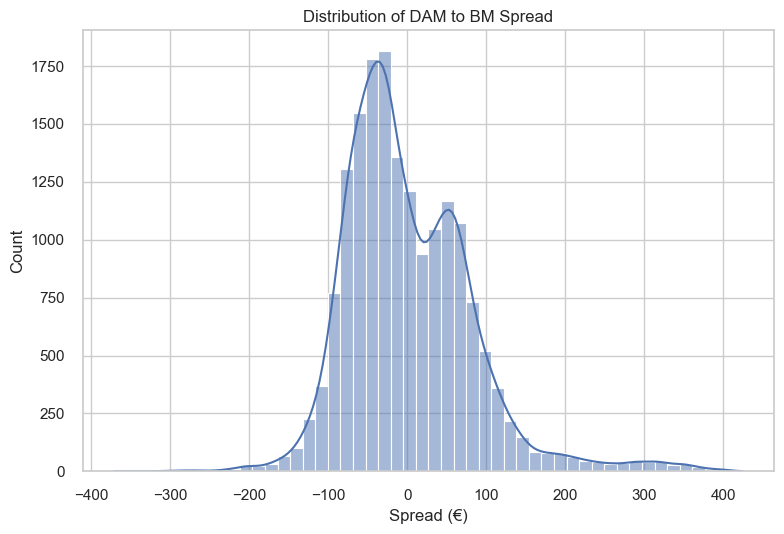

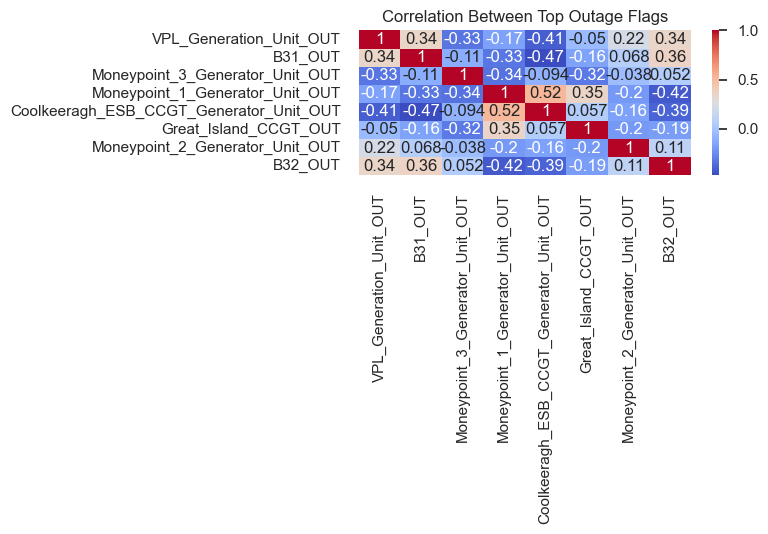

 3D.6 - [Diagnostic] Correlation of each plant outage with DAM–BM spread:
Coolkeeragh_ESB_CCGT_Generator_Unit_OUT    0.066516
Moneypoint_3_Generator_Unit_OUT            0.027153
Moneypoint_2_Generator_Unit_OUT            0.016447
B32_OUT                                    0.010114
Moneypoint_1_Generator_Unit_OUT            0.002375
B31_OUT                                   -0.017500
Great_Island_CCGT_OUT                     -0.020173
VPL_Generation_Unit_OUT                   -0.028126
Name: Spread_DAMtoBM, dtype: float64
 3D.7 - [Diagnostic] Correlation of each plant outage with DAM price:
B32_OUT                                    0.239581
Moneypoint_2_Generator_Unit_OUT            0.167882
Moneypoint_3_Generator_Unit_OUT            0.128816
B31_OUT                                    0.035192
VPL_Generation_Unit_OUT                   -0.019487
Great_Island_CCGT_OUT                     -0.129489
Coolkeeragh_ESB_CCGT_Generator_Unit_OUT   -0.177096
Moneypoint_1_Generator_Unit_OUT        

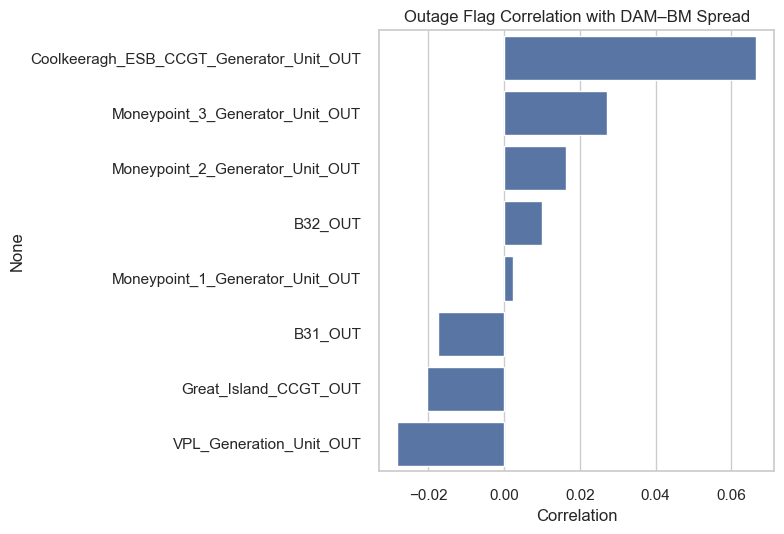

3D.9 - [Check] Units with multiple RegisteredCapacity values:


Series([], Name: RegisteredCapacity, dtype: int64)

In [8]:
# SECTION 3d: Diagnostics 

# 3D.1 - Recalculating the spread just to double check
combined_prices_df['Spread_DAMtoBM'] = combined_prices_df['PriceImbalance'] - combined_prices_df['PriceDAM']
assert 'Spread_DAMtoBM' in combined_prices_df.columns, "Spread_DAMtoBM is missing!"

# Printing the summary statistics for the spread
print("\n 3D.1 - [Diagnostic] Spread Summary with Percentiles:")
print(combined_prices_df['Spread_DAMtoBM'].describe(percentiles=[.01, .25, .5, .75, .99]))

# 3D.2 - Correlation with Spread - sorted the top correlations with Spread_DAMtoBM
spread_corr = combined_prices_df.corr(numeric_only=True)['Spread_DAMtoBM'].sort_values(ascending=False)
print(" 3D.2 - [Diagnostic] Correlation with DAM_to_BM_Spread:")
print(spread_corr.head(10))

# 3D.3 - Checking how often each high risk flag is triggered
flags = ['HighVolatility', 'HighRamp', 'HighDemand', 'LowWind', 'HighOutage', 'HighForecastError', 'LowRiskPeriod']
flag_counts = combined_prices_df[flags].sum().sort_values(ascending=False)
print(" 3D.3 - [Diagnostic] Flag trigger counts:")
print(flag_counts)

# 3D.4 - Plotting Histogram of the Spread
sns.histplot(combined_prices_df['Spread_DAMtoBM'].dropna(), bins=50, kde=True)
plt.title("Distribution of DAM to BM Spread")
plt.xlabel("Spread (€)")
plt.grid(True); plt.tight_layout(); plt.show()

# 3D.5 - Correlation Heatmap among outage flags
outage_flags = [col for col in combined_prices_df.columns if col.endswith('_OUT')]
overlap_corr = combined_prices_df[outage_flags].corr()
sns.heatmap(overlap_corr, cmap='coolwarm', annot=True)
plt.title("Correlation Between Top Outage Flags")
plt.tight_layout(); plt.show()

# 3D.6 - Correlation of each plant outage flag with the Spread
outage_flag_corr = combined_prices_df[outage_flags + ['Spread_DAMtoBM']].corr()
outage_vs_spread_corr = outage_flag_corr['Spread_DAMtoBM'].drop('Spread_DAMtoBM').sort_values(ascending=False)
print(" 3D.6 - [Diagnostic] Correlation of each plant outage with DAM–BM spread:")
print(outage_vs_spread_corr)

# 3D.7 - Correlation of outages with the DAM price
outage_flag_corr = combined_prices_df[outage_flags + ['PriceDAM']].corr()
outage_vs_price_corr = outage_flag_corr['PriceDAM'].drop('PriceDAM').sort_values(ascending=False)
print(" 3D.7 - [Diagnostic] Correlation of each plant outage with DAM price:")
print(outage_vs_price_corr)

# 3D.8 - Visualising Outage Correlations to the Spread
sns.barplot(x=outage_vs_spread_corr.values, y=outage_vs_spread_corr.index)
plt.title("Outage Flag Correlation with DAM–BM Spread")
plt.xlabel("Correlation"); plt.tight_layout(); plt.show()

# 3D.9 - Final data check - Looking for plants with inconsistent registered capacity
dupes_check = (
    df_Outages_enriched.groupby('UnitName')['RegisteredCapacity']
      .nunique().sort_values(ascending=False)
)
print("3D.9 - [Check] Units with multiple RegisteredCapacity values:")
display(dupes_check[dupes_check > 1])

[Section 4.1A] Found 17 unique units with ≥ 200 MW capacity:


Plexos_SEM_Unit_ID                                  UnitName  RegisteredCapacity
1571184          GU_400762                         Great Island CCGT               464.0
367500           GU_400850                   Aghada 2 Generator Unit               449.0
19414            GU_400930  Bord Gais ROI - Whitegate Generator Unit               444.0
442673           GU_500040       Coolkeeragh ESB CCGT Generator Unit               425.0
98               GU_400500               Dublin Bay  Generator Unit                415.0
597463           GU_400530                     Tynagh Generator Unit               404.0
510880           GU_400540                      VPL Generation Unit                400.0
476686           GU_504110                                       GT6               350.0
1191158          GU_504120                                       GT7               350.0
495486           GU_400480                    HPC1 Generation Unit                 342.0
85               GU_400272               Moneypoint 3 Generator Unit               285.0
231684           GU_400270               Moneypoint 1 Generator Unit               285.0
160389           GU_400271              Moneypoint 2 Generator Unit                285.0
509667           GU_503730                                       B32               247.0
401              GU_503720                                       B31               247.0
381911           GU_400324                           Shellybanks PBA               240.0
90               GU_400325                           Shellybanks PBB               236.0

[Section 4.2] Spread and Direction columns added.


StartDateTime  PriceDAM  PriceImbalance  Spread_DAMtoBM  SpreadDirection
0 2024-09-05 00:00:00    103.13          134.63           31.50                1
1 2024-09-05 00:30:00    103.13          145.08           41.95                1
2 2024-09-05 01:00:00     97.86          146.30           48.44                1
3 2024-09-05 01:30:00     97.86          144.33           46.47                1
4 2024-09-05 02:00:00     96.75          129.68           32.93                1
5 2024-09-05 02:30:00     96.75           90.59           -6.16                0
6 2024-09-05 03:00:00     94.10          140.55           46.45                1
7 2024-09-05 03:30:00     94.10          141.37           47.27                1
8 2024-09-05 04:00:00     94.94          141.37           46.43                1
9 2024-09-05 04:30:00     94.94          141.37           46.43                1

[Section 4.3] Outage impact (BM-DAM) — top movers:
                                         Difference
Coolkeeragh_ESB_CCGT_Generator_Unit_OUT   12.958044
Moneypoint_3_Generator_Unit_OUT            4.443552
Moneypoint_2_Generator_Unit_OUT            3.067759
B32_OUT                                    1.711515
Moneypoint_1_Generator_Unit_OUT            0.395930
B31_OUT                                   -3.708854
Great_Island_CCGT_OUT                     -4.488123
VPL_Generation_Unit_OUT                   -4.702074


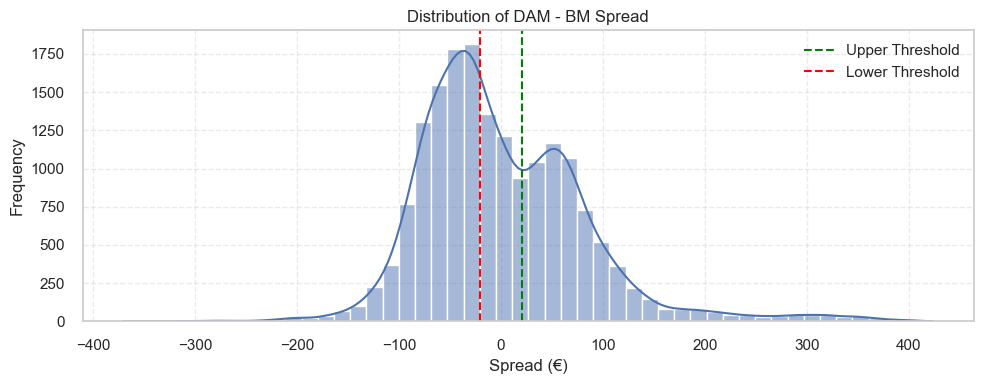


[Section 4.5] Top High-Impact Outage Plants (Filtered by 200MW+):
UnitName
VPL Generation Unit                         2767600
B31                                         2677714
Moneypoint 3 Generator Unit                 2363775
Moneypoint 1 Generator Unit                 1953394
Coolkeeragh ESB CCGT Generator Unit         1704775
Great Island CCGT                           1315904
Moneypoint 2 Generator Unit                 1279170
B32                                         1171808
Dublin Bay  Generator Unit                  1013712
Bord Gais ROI - Whitegate Generator Unit     965700
Aghada 2 Generator Unit                      821490
Shellybanks PBB                              636442
Tynagh Generator Unit                        616504
HPC1 Generation Unit                         439547
Shellybanks PBA                              395154
GT6                                          324377
GT7                                          158094
Name: UnavailableCapacityMW, dtype: int6

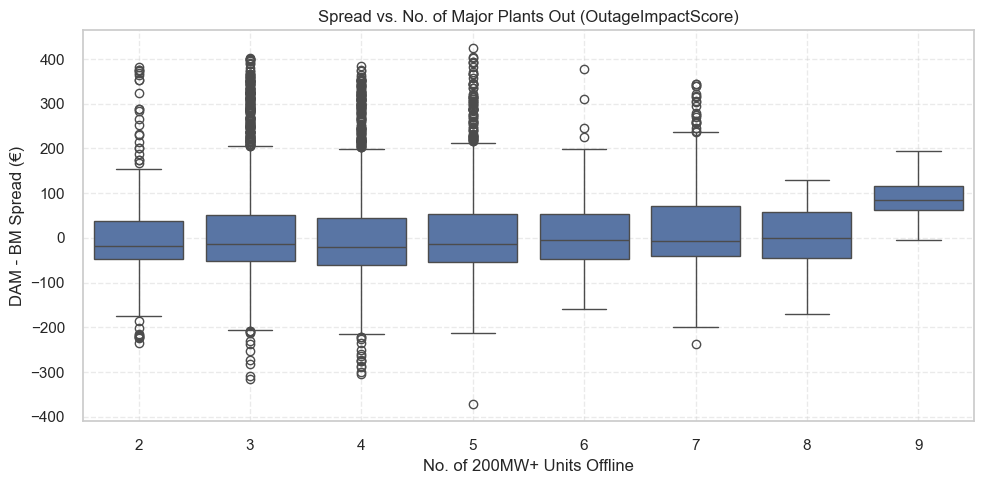

 4.10A [Check] OutageImpactScore stats:
count    17550.000000
mean         4.079658
std          1.317608
min          2.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          9.000000
Name: OutageImpactScore, dtype: float64
[Check] Rows with OutageImpactScore == 0: 0
 4.10B [Check] Spread threshold used (plot ref): 20.423844983005235
 4.10C [Check] SpreadDirection class distribution:
SpreadDirection
-1    0.475954
 1    0.366724
 0    0.157322
Name: proportion, dtype: float64
 4.10D [Check] OutageImpactMW stats:
count    17550.000000
mean       866.531225
std        287.557812
min         86.000000
25%        710.000000
50%        835.000000
75%       1064.000000
max       2033.000000
Name: OutageImpactMW, dtype: float64
 4.10E [Check] Correlation between OutageImpactScore and OutageImpactMW:
                   OutageImpactScore  OutageImpactMW
OutageImpactScore           1.000000        0.569668
OutageImpactMW              0.569668        1.000000
  4.1

In [9]:
# SECTION 4 - Ranking High-Impact Outage Plants

# Why I created this section:
# 1. To identify large units (over 200MW) and analyse their impact on the DAM-BM Spread
# 2. Create direction labels for spread with a no look ahead dynamic threshold (to prevent future leaking and inflated values etc)
# 3. Ensure outage flags are present, deduplicated and pruned if they are near constant.#
# 4. I built impact scores (count and MW weighted) then ran diagnostics on them.



# 4.1A - Get all units with RegisteredCapacity ≥ 200, dropped exact duplicates
# I restricted it to large plants because their outages are most likely to change system balances and prices
large_plants_df = (
    df_Outages_enriched[df_Outages_enriched['RegisteredCapacity'] >= 200]          # Note: This 200MW Threshold can be increased to eg 300MW to isolate even larger plants.
      .dropna(subset=['RegisteredCapacity'])
      .drop_duplicates(subset=['Plexos_SEM_Unit_ID'])
      .sort_values(by='RegisteredCapacity', ascending=False)
      [['Plexos_SEM_Unit_ID', 'UnitName', 'RegisteredCapacity']]
)
print(f"[Section 4.1A] Found {large_plants_df.shape[0]} unique units with ≥ 200 MW capacity:")
display(large_plants_df)

# 4.1B - Keeping a convenience list of names for filtering etc of the large plants
large_plant_names = large_plants_df['UnitName'].unique().tolist()


# =========== 4.2 - Construct DAM - BM Spread target variable (direction WITHOUT look-ahead) ================
# Spread_DAMtoBM is our core target/signal: positive means BM > DAM and then negative means BM < DAM
combined_prices_df['Spread_DAMtoBM'] = combined_prices_df['PriceImbalance'] - combined_prices_df['PriceDAM']


# I built a threshold here to label direction with no look ahead bias:
# - I used the expanding standard deviation of the lagged spread (shift(1)), requiring at least 2 days (or 96 half hours)
# - The direction will therefore = +1 if the spread is greater than +0.25 x this new expanded standard deviation for 96 half hours.
# - The direction will equal -1 if the spread is less than -0.25 x the expanded standard deviation, it will = 0 otherwise meaning no trade.
exp_std    = combined_prices_df['Spread_DAMtoBM'].shift(1).expanding(min_periods=96).std()

# Converting standard deviation to the threshold: fallback to global standard deviation x 0.25 if inital NA window
dyn_thresh = 0.25 * exp_std
_fallback  = float(dyn_thresh.dropna().iloc[0]) if dyn_thresh.notna().any() else combined_prices_df['Spread_DAMtoBM'].std() * 0.25

# Filling the early NA periods with a reasonable fallback so labels exist from the start
dyn_thresh = dyn_thresh.fillna(_fallback)


# Creating a 3 class label here which captures the actionable direction without future leakage
combined_prices_df['SpreadDirection'] = np.select(
    [
        combined_prices_df['Spread_DAMtoBM'] >  dyn_thresh,
        combined_prices_df['Spread_DAMtoBM'] < -dyn_thresh
    ],
    [1, -1],
    default=0
)
print("[Section 4.2] Spread and Direction columns added.")
display(combined_prices_df[['StartDateTime', 'PriceDAM', 'PriceImbalance', 'Spread_DAMtoBM', 'SpreadDirection']].head(10))

#========== 4.3 - Ranking the Outage Flags by mean spread difference ===========
# For a given binary outage flag, we are computing mean spread when plant is offline (=1) minus the mean spread. 
# We require at least 20 samples in and out to avoid tiny sample artificats
def avg_spread_diff(df, col):
    out_mask = df[col]==1
    in_mask  = df[col]==0
    if out_mask.sum() < 20 or in_mask.sum() < 20:
        return np.nan
    return df.loc[out_mask,'Spread_DAMtoBM'].mean() - df.loc[in_mask,'Spread_DAMtoBM'].mean()

# Evaluating all the OUT Flags currently in the dataset
outage_flag_cols = [c for c in combined_prices_df.columns if c.endswith('_OUT')]
impact = {c: avg_spread_diff(combined_prices_df, c) for c in outage_flag_cols}
impact_df = (pd.Series(impact, name='Difference')
             .dropna().sort_values(ascending=False).to_frame())
print("[Section 4.3] Outage impact (BM-DAM) — top movers:")
print(impact_df.head(10))

#========== 4.4 - Plotting Spread Distribution with the global reference thresholds  ===========
# For visual context only (fixed threshold = global standard deviation x 0.25, not used for labels)
spread_thresh = combined_prices_df['Spread_DAMtoBM'].std() * 0.25
plt.figure(figsize=(10, 4))
sns.histplot(combined_prices_df['Spread_DAMtoBM'], bins=50, kde=True)
plt.axvline(spread_thresh,  color='green', linestyle='--', label='Upper Threshold')
plt.axvline(-spread_thresh, color='red',   linestyle='--', label='Lower Threshold')
plt.title("Distribution of DAM - BM Spread")
plt.xlabel("Spread (€)"); plt.ylabel("Frequency"); plt.legend()
plt.grid(True, linestyle='--', alpha=0.4); plt.tight_layout(); plt.show()

#========== 4.5 - Filtering the outages for large units only ===========
# Focusing the subsequent ranking/flags on the large unit subset
filtered_outages = df_Outages_enriched[df_Outages_enriched['UnitName'].isin(large_plant_names)]

# Ranking the plants by the total unavailable MW across the period
top_units_filtered = (
    filtered_outages.groupby('UnitName')['UnavailableCapacityMW']
      .sum().sort_values(ascending=False)
)

# Maintaining ordering for deterministic flag creation below
top_unit_ids = top_units_filtered.index.tolist()
print("\n[Section 4.5] Top High-Impact Outage Plants (Filtered by 200MW+):")
print(top_units_filtered)

#========== 4.6 - Creating outage flags for any large units that are missing ===========
# We ensure each large unit has a binary OUT flag. Section 3 should have aready done this but just double checking.
flag_matrix = pd.DataFrame({'StartDateTime': combined_prices_df['StartDateTime'].unique()})
for unit in top_unit_ids:
    flag_name = unit.strip().replace(" ", "_").replace("__", "_") + "_OUT"
    if flag_name not in combined_prices_df.columns:
        outage_times = (
            filtered_outages[filtered_outages['UnitName'] == unit][['StartDateTime']]
              .drop_duplicates().dropna().copy()
        )
        outage_times[flag_name] = 1
        flag_matrix = pd.merge(flag_matrix, outage_times, on='StartDateTime', how='left')
        flag_matrix[flag_name] = flag_matrix[flag_name].fillna(0).astype(int)
        print(f" {flag_name} created — {flag_matrix[flag_name].sum()} outage intervals")

# 8. Merging any newly created flags back into the main dataframe
combined_prices_df = pd.merge(combined_prices_df, flag_matrix, on='StartDateTime', how='left')

#========== 4.7 - Outage flag fixing duplicates and near constants for Strict and OUT only ===========
# Deduplicate columns and drop near constants
out_cols = [c for c in combined_prices_df.columns if c.endswith('_OUT')]

# Removing the exact duplicate column names
seen, drop_list = set(), []
for c in out_cols:
    if c in seen:
        drop_list.append(c)
    else:
        seen.add(c)
if drop_list:
    print(f"[Section 4.7] Dropping duplicate outage flags: {drop_list}")
    combined_prices_df.drop(columns=drop_list, inplace=True)

# Drop near-constant flags (>99.5% same value), but ONLY those ending with OUT
near_constant = []
for col in out_cols:
    vc = combined_prices_df[col].value_counts(normalize=True, dropna=False)
    if not vc.empty and vc.iloc[0] >= 0.995:
        near_constant.append(col)

# safety:making sure it is only dropping true OUT columns
bad_candidates = [c for c in near_constant if not c.endswith('_OUT')]
if bad_candidates:
    print("[Section 4.7][WARN] Unexpected non-_OUT in near-constant list (will NOT drop):", bad_candidates)

if near_constant:
    print(f"[Section 4.7] Dropping near-constant outage flags: {near_constant}")
    mw_twins = [f"{c}_MW" for c in near_constant if f"{c}_MW" in combined_prices_df.columns]
    combined_prices_df.drop(columns=near_constant + mw_twins, inplace=True)




#========== 4.8 - Building the outage impact scores ===========
# 4.8A - This is count based: number of top units active in the interval
outage_flag_cols = [col for col in combined_prices_df.columns
                    if col.endswith('_OUT') and any(p.replace(" ", "_") in col for p in top_unit_ids)]
combined_prices_df['OutageImpactScore'] = combined_prices_df[outage_flag_cols].sum(axis=1)
print(f"[Section 4.8A] OutageImpactScore created using {len(outage_flag_cols)} top outage flags.")

# 4.8B - MW weighted: the sum of the OUT MW. If OUT MW is absent for a unit we can optionally approximate it by using flag x  unit capacity
existing_mw_cols = [c for c in combined_prices_df.columns if c.endswith('_OUT_MW')]
if existing_mw_cols:
    print("[Section 4] Detected existing time-varying *_OUT_MW from Section 3. Will not overwrite.")

plant_cap_map = dict(zip(large_plants_df['UnitName'], large_plants_df['RegisteredCapacity']))
for unit in large_plant_names:
    flag_col = unit.strip().replace(" ", "_").replace("__", "_") + "_OUT"
    mw_col   = flag_col + "_MW"
    # Only backfills if a) the flag exists, b) no _MW exists already and c) Section 3 didnt produce any OUT MW columns
    if flag_col in combined_prices_df.columns and mw_col not in combined_prices_df.columns and not existing_mw_cols:
        cap = plant_cap_map.get(unit)
        if cap is not None:
            combined_prices_df[mw_col] = combined_prices_df[flag_col] * cap

mw_flag_cols = [c for c in combined_prices_df.columns if c.endswith('_OUT_MW')]
combined_prices_df['OutageImpactMW'] = combined_prices_df[mw_flag_cols].sum(axis=1)
print(f"[Section 4.8] OutageImpactMW built from {len(mw_flag_cols)} time-varying MW flags.")

#========== 4.9 - Visualising the Spread vs the OutageImpactScore ===========
# Boxplot will help to see if higher counts of major unit outages push the spread distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='OutageImpactScore', y='Spread_DAMtoBM', data=combined_prices_df)
plt.title("Spread vs. No. of Major Plants Out (OutageImpactScore)")
plt.xlabel("No. of 200MW+ Units Offline"); plt.ylabel("DAM - BM Spread (€)")
plt.grid(True, linestyle='--', alpha=0.4); plt.tight_layout(); plt.show()

#========== 4.10 - Visualising the Spread vs the OutageImpactScore ===========
print(" 4.10A [Check] OutageImpactScore stats:")
print(combined_prices_df['OutageImpactScore'].describe())
print(f"[Check] Rows with OutageImpactScore == 0: {(combined_prices_df['OutageImpactScore'] == 0).sum()}")
print(" 4.10B [Check] Spread threshold used (plot ref):", spread_thresh)
print(" 4.10C [Check] SpreadDirection class distribution:")
print(combined_prices_df['SpreadDirection'].value_counts(normalize=True))
print(" 4.10D [Check] OutageImpactMW stats:")
print(combined_prices_df['OutageImpactMW'].describe())
print(" 4.10E [Check] Correlation between OutageImpactScore and OutageImpactMW:")
print(combined_prices_df[['OutageImpactScore', 'OutageImpactMW']].corr())

# End Integrity checks
nan_target = combined_prices_df['Spread_DAMtoBM'].isna().sum()
is_mono    = combined_prices_df['StartDateTime'].is_monotonic_increasing
dups_slots = combined_prices_df['StartDateTime'].duplicated().sum()
print(f"  4.10F [Integrity] NaNs in Spread_DAMtoBM: {nan_target} | StartDateTime monotonic: {is_mono} | duplicates: {dups_slots}")
print(" 4.10F [Integrity] Reminder: PriceImbalance and unshifted Spread are targets; they will be excluded/lagged in Section 5 features.")


# 4.11 (Optional repeat safety) — Outage flag hygiene again if upstream re-merges introduced duplicates
out_cols = [c for c in combined_prices_df.columns if c.endswith('_OUT')]

seen, drop_list = set(), []
for c in out_cols:
    if c in seen:
        drop_list.append(c)
    else:
        seen.add(c)
if drop_list:
    print(f"[Section 4.11A] Dropping duplicate outage flags: {drop_list}")
    combined_prices_df.drop(columns=drop_list, inplace=True)

near_constant = []
for col in out_cols:
    vc = combined_prices_df[col].value_counts(normalize=True, dropna=False)
    if not vc.empty and vc.iloc[0] >= 0.995:
        near_constant.append(col)

bad_candidates = [c for c in near_constant if not c.endswith('_OUT')]
if bad_candidates:
    print("[Section 4.11B][WARN] Unexpected non-_OUT in near-constant list (will NOT drop):", bad_candidates)

if near_constant:
    print(f"[Section 4.11C] Dropping near-constant outage flags: {near_constant}")
    mw_twins = [f"{c}_MW" for c in near_constant if f"{c}_MW" in combined_prices_df.columns]
    combined_prices_df.drop(columns=near_constant + mw_twins, inplace=True)

In [10]:
# ============================================== SECTION 5A — Predictive Modelling (Regression) ==============================================

# Goal:
# 1) Predict DAM→BM spread (Spread_DAMtoBM) with time-aware cross-validation (to avoid data leakage).
# 2) Use only features that would be available at decision time (no cheating with future info).
# 3) Rank model performance and compute feature importance (via permutation) to understand drivers.

from pycaret.regression import (
    setup, compare_models, finalize_model, predict_model, pull, get_config
)
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np
import pandas as pd

print("\n[Section 5A.0] Initializing PyCaret Regression Workflow...")

# ------------------------------
# 5A.1 – Build feature list (decision-time safe) + outage flags
# ------------------------------

# Select all outage flags from the dataset that end in _OUT
# Exclude 'LowRiskPeriod' as it's a special risk label not a raw outage flag
flag_cols = [c for c in combined_prices_df.columns if c.endswith('_OUT') and c != 'LowRiskPeriod']
print(f"[Section 5A.1] Outage flag columns detected: {len(flag_cols)}")

# Define the full set of decision-time-safe features for regression
# These are all safe to use at the time of decision-making
selected_features = [
    'TotalOutageMW',
    'TotalPercentUnavailable',
    'DemandForecast',
    'Meteo_ISEMDEMAND_DAM',
    'Meteo_ISEMWIND_DAM',
    'RenewableForecast',
    'PriceVolatility',
    'HighOutage', 'LowWind', 'HighDemand', 'HighVolatility', 'HighRamp', 'LowRiskPeriod'
] + flag_cols  # Add in unit-level outage flags

# Ensure target variables are not accidentally included as features
blacklist = {'PriceImbalance', 'Spread_DAMtoBM'}
selected_features = [f for f in selected_features if f not in blacklist]

# ------------------------------
# 5A.3 – Missing values check
# ------------------------------

# Check for missing values across all selected features and the target
features_plus_target = selected_features + ['Spread_DAMtoBM']
na_counts = combined_prices_df[features_plus_target].isna().sum()
na_counts = na_counts[na_counts > 0]

# Report columns that contain any NA values
if len(na_counts):
    print("\n[Section 5A.3] Missing values BEFORE dropna():")
    print(na_counts.sort_values(ascending=False))
else:
    print("[Section 5A.3] No missing values in selected columns.")

# ------------------------------
# 5A.4 – Final modelling frame
# ------------------------------

# Drop any rows with NA in features or target
modelling_df = combined_prices_df[features_plus_target].dropna()

# Print dataset shape after NA removal
print(f"\n[Section 5A.4] Modeling DataFrame: {modelling_df.shape[0]} rows × {modelling_df.shape[1]} cols")
print(f"[Section 5A.4] Rows dropped due to NA: {combined_prices_df.shape[0] - modelling_df.shape[0]}")

# Show final list of input features being used for modeling
print("\n[Section 5A.4] Final Feature Set:")
print(selected_features)

# Basic sanity checks
assert 'Spread_DAMtoBM' in modelling_df.columns, "Target column missing!"
assert modelling_df.shape[0] > 5000, "Not enough data points to build a robust model."

# ------------------------------
# 5A.5 – PyCaret setup (time-safe CV)
# ------------------------------

# Initialize PyCaret with strict time-aware setup to avoid leakage
# Key flags:
# - fold_strategy='timeseries' ensures time-based folds
# - fold_shuffle=False ensures that past doesn't see the future
# - normalize=True to standardize inputs
# - remove_multicollinearity=True to drop redundant features
# - feature_selection=True automatically removes unhelpful features

regression_setup = setup(
    data=modelling_df,
    target='Spread_DAMtoBM',
    train_size=0.7,  # Use 70% of data for training, 30% for testing
    session_id=42,   # For reproducibility
    normalize=True,
    remove_multicollinearity=True,
    feature_selection=True,
    fold_strategy='timeseries',
    fold=5,
    fold_shuffle=False,
    data_split_shuffle=False,
    verbose=True,
)

# ------------------------------
# 5A.6 – Compare & select model
# ------------------------------

print("\n[Section 5A.6] Comparing regression models (time-series CV)...")

# Automatically trains and evaluates multiple regression models using time-aware CV
# Selects best model based on PyCaret's default metric (usually R² or MAE)
best_model = compare_models()

# ------------------------------
# 5A.7 – Finalize best model
# ------------------------------

# Lock in the best model using full training set
final_model = finalize_model(best_model)
print("\n[Section 5A.7] Final model finalized.")

# ------------------------------
# 5A.8 – Feature importance (safe)
# ------------------------------

print("\n[Section 5A.8] Plotting feature importance (if supported by the best model)...")

# Plot native feature importance if the model supports it (e.g., LightGBM, Random Forest)
try:
    from pycaret.regression import plot_model
    plot_model(final_model, plot='feature')
except Exception as e:
    print("[Section 5A.8] Skipped native feature importance:", e)

# ------------------------------
# 5A.8b – Permutation importance on holdout (MAE-based)
# ------------------------------

print("\n[Section 5A.8] Permutation importance (holdout):")

# Extract holdout data from PyCaret config
X_test = get_config('X_test')
y_test = get_config('y_test')

# Define permutation importance scorer (use MAE for robustness over R²)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Permutation importance: shuffle each feature, see how much the model error increases
r = permutation_importance(
    final_model, X_test, y_test,
    n_repeats=5, random_state=42, n_jobs=-1, scoring=scorer
)

# Format and sort results
perm_imp = (pd.Series(r.importances_mean, index=X_test.columns)
            .sort_values(ascending=False)
            .to_frame('perm_importance_MAE'))

# Display as a DataFrame
display(perm_imp)

# ------------------------------
# 5A.9 – Leaderboard snapshot
# ------------------------------

# Pull the leaderboard of all models that were trained
leaderboard = pull()
print("\n[Section 5A.9] Model Leaderboard (time-safe):")

# Show leaderboard in notebook or print fallback
try:
    display(leaderboard)
except Exception:
    print(leaderboard)



[Section 5A.0] Initializing PyCaret Regression Workflow...
[Section 5A.1] Outage flag columns detected: 17

[Section 5A.3] Missing values BEFORE dropna():
DemandForecast       1186
RenewableForecast    1156
PriceVolatility         2
dtype: int64

[Section 5A.4] Modeling DataFrame: 16362 rows × 31 cols
[Section 5A.4] Rows dropped due to NA: 1188

[Section 5A.4] Final Feature Set:
['TotalOutageMW', 'TotalPercentUnavailable', 'DemandForecast', 'Meteo_ISEMDEMAND_DAM', 'Meteo_ISEMWIND_DAM', 'RenewableForecast', 'PriceVolatility', 'HighOutage', 'LowWind', 'HighDemand', 'HighVolatility', 'HighRamp', 'LowRiskPeriod', 'VPL_Generation_Unit_OUT', 'B31_OUT', 'Moneypoint_3_Generator_Unit_OUT', 'Moneypoint_1_Generator_Unit_OUT', 'Coolkeeragh_ESB_CCGT_Generator_Unit_OUT', 'Great_Island_CCGT_OUT', 'Moneypoint_2_Generator_Unit_OUT', 'B32_OUT', 'Dublin_Bay_Generator_Unit_OUT', 'Bord_Gais_ROI_-_Whitegate_Generator_Unit_OUT', 'Aghada_2_Generator_Unit_OUT', 'Shellybanks_PBB_OUT', 'Tynagh_Generator_Unit_OU


[Section 5A.6] Comparing regression models (time-series CV)...



[Section 5A.7] Final model finalized.

[Section 5A.8] Plotting feature importance (if supported by the best model)...
[Section 5A.8] Skipped native feature importance: Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.

[Section 5A.8] Permutation importance (holdout):


perm_importance_MAE
TotalOutageMW                                                 0.0
TotalPercentUnavailable                                       0.0
GT6_OUT                                                       0.0
Shellybanks_PBA_OUT                                           0.0
HPC1_Generation_Unit_OUT                                      0.0
Tynagh_Generator_Unit_OUT                                     0.0
Shellybanks_PBB_OUT                                           0.0
Aghada_2_Generator_Unit_OUT                                   0.0
Bord_Gais_ROI_-_Whitegate_Generator_Unit_OUT                  0.0
Dublin_Bay_Generator_Unit_OUT                                 0.0
B32_OUT                                                       0.0
Moneypoint_2_Generator_Unit_OUT                               0.0
Great_Island_CCGT_OUT                                         0.0
Coolkeeragh_ESB_CCGT_Generator_Unit_OUT                       0.0
Moneypoint_1_Generator_Unit_OUT                               0.0
Moneypoint_3_Generator_Unit_OUT                               0.0
B31_OUT                                                       0.0
VPL_Generation_Unit_OUT                                       0.0
LowRiskPeriod                                                 0.0
HighRamp                                                      0.0
HighVolatility                                                0.0
HighDemand                                                    0.0
LowWind                                                       0.0
HighOutage                                                    0.0
PriceVolatility                                               0.0
RenewableForecast                                             0.0
Meteo_ISEMWIND_DAM                                            0.0
Meteo_ISEMDEMAND_DAM                                          0.0
DemandForecast                                                0.0
GT7_OUT                                                       0.0


[Section 5A.9] Model Leaderboard (time-safe):


Model      MAE         MSE      RMSE      R2   RMSLE    MAPE  TT (Sec)
dummy                     Dummy Regressor  64.4483   6567.8499   80.5324 -0.0220  2.7736  1.1042     0.320
en                            Elastic Net  64.7685   6598.5157   80.6894 -0.0252  2.2478  1.6880     0.230
llar         Lasso Least Angle Regression  65.1971   6700.7020   81.3242 -0.0414  2.0909  1.9689     0.230
lasso                    Lasso Regression  65.1970   6700.6987   81.3242 -0.0414  2.0909  1.9689     1.674
omp           Orthogonal Matching Pursuit  65.1827   6702.1968   81.3360 -0.0418  2.2635  1.8677     0.258
br                         Bayesian Ridge  65.4705   6765.7196   81.7189 -0.0515  2.0077  2.0910     0.236
huber                     Huber Regressor  65.4113   6810.1781   81.8659 -0.0525  1.9859  2.0422     0.264
ridge                    Ridge Regression  65.5447   6784.6729   81.8343 -0.0544  1.9854  2.1301     1.706
lar                Least Angle Regression  65.5460   6784.9656   81.8361 -0.0545  1.9852  2.1305     0.236
lr                      Linear Regression  65.5460   6784.9679   81.8361 -0.0545  1.9852  2.1305     2.244
gbr           Gradient Boosting Regressor  66.4076   7090.2805   83.5578 -0.0985  1.7976  2.7352     0.488
par          Passive Aggressive Regressor  67.2442   7309.9942   84.9189 -0.1373  1.6596  3.2385     0.238
et                  Extra Trees Regressor  67.6984   7390.7229   85.5019 -0.1553  1.6920  2.6655     0.494
ada                    AdaBoost Regressor  69.4132   7520.9127   86.1153 -0.1874  1.9540  2.6344     0.320
catboost               CatBoost Regressor  68.7928   7730.9097   87.4088 -0.2050  1.5441  2.9311     1.812
lightgbm  Light Gradient Boosting Machine  70.0609   7937.0431   88.6920 -0.2463  1.5552  3.0661     0.418
rf                Random Forest Regressor  70.9760   8067.4793   89.3355 -0.2604  1.6091  3.5218     0.800
xgboost         Extreme Gradient Boosting  73.2022   8837.6634   93.4840 -0.3803  1.4783  3.6571     0.294
knn                 K Neighbors Regressor  76.5447   9620.9590   97.7150 -0.5337  1.4287  4.2241     0.256
dt                Decision Tree Regressor  89.9577  13303.5917  115.1810 -1.1369  1.3970  6.5182     0.256


[5b.1] Using Spread Threshold 75th pct: ±81.16 (from 5A y_train)

[5b.2] TradeSignal counts:
TradeSignal
0    13386
1     4164
Name: count, dtype: int64

[5b.2] Class balance:
TradeSignal
0    0.762735
1    0.237265
Name: proportion, dtype: float64
[5b.3] Keeping 17 outage flags

[5b.4] Classification DF: 16362 rows × 24 cols | features: 23



[5b.6] Final model:
Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['DemandForecast',
                                             'Meteo_ISEMDEMAND_DAM', 'RampRate',
                                             'PriceVolatility', 'LowWind',
                                             'TotalOutageMW',
                                             'VPL_Generation_Unit_OUT',
                                             'B31_OUT',
                                             'Moneypoint_3_Generator_Unit_OUT',
                                             'Moneypoint_1_Generator_Unit_OUT',
                                             'Coolkeeragh_ESB_CCGT_Generator_Unit_OUT',
                                             'G...
                 LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                                colsample_bytree=1.0, importance_


[5b.8] Confusion Matrix (holdout):
 [[3395  538]
 [ 250  726]]

[5b.8] Classification Report (holdout):
               precision    recall  f1-score   support

           0       0.93      0.86      0.90      3933
           1       0.57      0.74      0.65       976

    accuracy                           0.84      4909
   macro avg       0.75      0.80      0.77      4909
weighted avg       0.86      0.84      0.85      4909



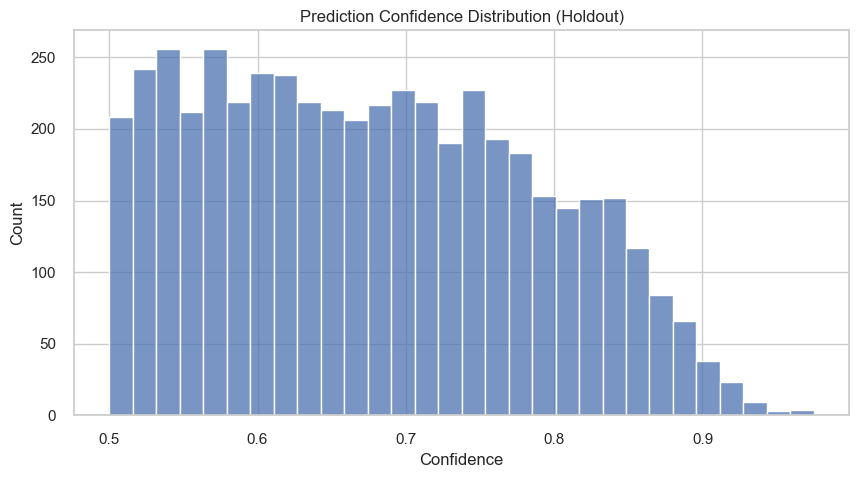

[5b.10] Wrote Predicted_TradeSignal & Prediction_Confidence (aligned to full index).

[5b.11] BuyFlag counts:
 BuyFlag
0    16275
1     1275
Name: count, dtype: int64
[5b.11] SellFlag counts:
 SellFlag
0    16439
1     1111
Name: count, dtype: int64

[5b.11] Final Prediction Summary (non null rows):
   Predicted_TradeSignal  Prediction_Confidence  TradeFlag  ProfitableTrade TradeDirection
2                    0.0                 0.8237          0                0           None
3                    0.0                 0.7545          0                0           None
4                    0.0                 0.8270          0                0           None
5                    0.0                 0.7691          0                0           None
6                    0.0                 0.8270          0                0           None

[5b.11] TradeFlag counts:
TradeFlag
0    13931
1     3619
Name: count, dtype: int64

[5b.11] Direction breakdown for confident trades:
TradeDirection
Bu

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7086  0.5617  0.2863  0.3943  0.3317  0.1514  0.1545
1       0.6158  0.5016  0.2363  0.2753  0.2543 -0.0024 -0.0024
2       0.6043  0.5703  0.4281  0.3776  0.4013  0.1075  0.1080
3       0.5954  0.5934  0.4609  0.3645  0.4071  0.1063  0.1080
4       0.6310  0.5222  0.3393  0.2280  0.2727  0.0381  0.0395
Mean    0.6310  0.5498  0.3502  0.3279  0.3334  0.0802  0.0815
Std     0.0406  0.0333  0.0842  0.0648  0.0632  0.0549  0.0557

In [11]:
# ==================== SECTION 5B: Classification Model to Predict Trade Signal ====================

# Purpose:
# Build a binary classifier to predict whether the DAM→BM spread exceeds a certain threshold,
# indicating a potential trade opportunity. The model uses time-series cross-validation
# to ensure no future information is used in training (i.e., no leakage).

from pycaret.classification import (
    setup as setup_clf,
    create_model,
    finalize_model,
    predict_model,
    get_config as get_config_clf,
    pull as pull_clf,
)
from pycaret.regression import get_config as get_config_reg
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# -----------------------------------
# 1) Determine spread threshold for trade definition (75th percentile)
# -----------------------------------
try:
    # Prefer y_train from regression section (5A) to keep time-safe subset
    X_train_reg = get_config_reg('X_train')
    y_train_reg = get_config_reg('y_train')
    spread_thresh = pd.Series(y_train_reg).abs().quantile(0.75)
    source_note = "(from 5A y_train)"
except Exception:
    # Fallback if 5A wasn't run — use full dataset
    spread_thresh = combined_prices_df['Spread_DAMtoBM'].abs().quantile(0.75)
    source_note = "(fallback from full DF)"

print(f"\n[5b.1] Using Spread Threshold 75th pct: ±{spread_thresh:.2f} {source_note}")

# -----------------------------------
# 2) Generate binary target labels and direction for diagnostics
# -----------------------------------
# TradeSignal: 1 if spread is large enough to be actionable
combined_prices_df['TradeSignal'] = (combined_prices_df['Spread_DAMtoBM'].abs() > spread_thresh).astype(int)

# ProfitableTrade (same as TradeSignal, placeholder for future backtesting alignment)
combined_prices_df['ProfitableTrade'] = combined_prices_df['TradeSignal']

# TradeDirection: 'Buy', 'Sell', or 'None' based on sign of spread
combined_prices_df['TradeDirection'] = combined_prices_df['Spread_DAMtoBM'].apply(
    lambda x: 'Buy' if x > spread_thresh else ('Sell' if x < -spread_thresh else 'None')
)

# Show class distribution
print("\n[5b.2] TradeSignal counts:")
print(combined_prices_df['TradeSignal'].value_counts())
print("\n[5b.2] Class balance:")
print(combined_prices_df['TradeSignal'].value_counts(normalize=True))

# -----------------------------------
# 3) Select time-safe features for classification
# -----------------------------------
base_features = [
    'DemandForecast', 'Meteo_ISEMDEMAND_DAM', 'RampRate',
    'PriceVolatility', 'LowWind', 'TotalOutageMW'
]

# Identify *_OUT flags and filter out rare ones (<0.5% active)
flag_cols_all = [c for c in combined_prices_df.columns if c.endswith('_OUT') and c != 'LowRiskPeriod']
rare_flags = [c for c in flag_cols_all if combined_prices_df[c].mean() < 0.005]
kept_flags = [c for c in flag_cols_all if c not in rare_flags]

if rare_flags:
    print(f"[5b.3] Dropping ultra rare outage flags (<0.5% active): {rare_flags}")
print(f"[5b.3] Keeping {len(kept_flags)} outage flags")

# Combine safe features with valid outage flags
candidate_features = base_features + kept_flags

# Filter out any BM-only or target-leaking columns
blacklist = {'PriceImbalance', 'Spread_DAMtoBM'}
clf_features = [f for f in candidate_features if f not in blacklist and f in combined_prices_df.columns]

# -----------------------------------
# 4) Build final classification DataFrame
# -----------------------------------
clf_df = combined_prices_df[clf_features + ['TradeSignal']].dropna()
assert clf_df.shape[0] > 1000, "Too few samples for classification"
print(f"\n[5b.4] Classification DF: {clf_df.shape[0]} rows × {clf_df.shape[1]} cols | features: {len(clf_features)}")

# -----------------------------------
# 5) PyCaret classification setup (time-aware)
# -----------------------------------
clf_setup = setup_clf(
    data=clf_df,
    target='TradeSignal',
    train_size=0.7,
    session_id=42,
    normalize=False,
    remove_multicollinearity=True,
    feature_selection=False,
    fix_imbalance=False,  # Avoid SMOTE — not time safe
    fold_strategy='timeseries',
    fold=5,
    fold_shuffle=False,
    data_split_shuffle=False,
    data_split_stratify=False,
    use_gpu=False,
    verbose=True,
)

# -----------------------------------
# 6) Train a LightGBM classifier with balanced weights
# -----------------------------------
best_clf_model = create_model('lightgbm', class_weight='balanced')
final_clf_model = finalize_model(best_clf_model)
print(f"\n[5b.6] Final model:\n{final_clf_model}")

# -----------------------------------
# 7) Show which features survived preprocessing
# -----------------------------------
clf_selected_features = get_config_clf('X_train').columns.tolist()
print("\n[5b.7] Features used:", clf_selected_features)

# -----------------------------------
# 8) Evaluate on holdout test set
# -----------------------------------
X_test_clf = get_config_clf('X_test')
y_test_clf = get_config_clf('y_test')
clf_preds_test = predict_model(final_clf_model, data=X_test_clf)
y_pred = clf_preds_test['prediction_label']

# Print confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_clf, y_pred)
print("\n[5b.8] Confusion Matrix (holdout):\n", conf_matrix)
print("\n[5b.8] Classification Report (holdout):\n", classification_report(y_test_clf, y_pred))

# -----------------------------------
# 9) Plot prediction confidence histogram
# -----------------------------------
plt.figure(figsize=(10, 5))
sns.histplot(clf_preds_test['prediction_score'], bins=30, kde=False)
plt.title("Prediction Confidence Distribution (Holdout)")
plt.xlabel("Confidence")
plt.grid(True)
plt.show()

# -----------------------------------
# 10) Predict on full dataset and write predictions back to main DF
# -----------------------------------
clf_preds_full = predict_model(final_clf_model, data=clf_df[clf_features])
combined_prices_df['Predicted_TradeSignal'] = np.nan
combined_prices_df['Prediction_Confidence'] = np.nan
combined_prices_df.loc[clf_df.index, 'Predicted_TradeSignal'] = clf_preds_full['prediction_label'].values
combined_prices_df.loc[clf_df.index, 'Prediction_Confidence'] = clf_preds_full['prediction_score'].values
print("[5b.10] Wrote Predicted_TradeSignal & Prediction_Confidence (aligned to full index).")

# -----------------------------------
# 11) Generate final trade signal based on confidence threshold
# -----------------------------------
confidence_threshold = 0.60
combined_prices_df['TradeFlag'] = (
    (combined_prices_df['Predicted_TradeSignal'] == 1) &
    (combined_prices_df['Prediction_Confidence'] >= confidence_threshold)
).astype(int)

# Add directional diagnostics (not used for trading yet)
combined_prices_df['BuyFlag'] = (
    (combined_prices_df['TradeFlag'] == 1) & (combined_prices_df['TradeDirection'] == 'Buy')
).astype(int)
combined_prices_df['SellFlag'] = (
    (combined_prices_df['TradeFlag'] == 1) & (combined_prices_df['TradeDirection'] == 'Sell')
).astype(int)

# Show diagnostics
print("\n[5b.11] BuyFlag counts:\n", combined_prices_df['BuyFlag'].value_counts())
print("[5b.11] SellFlag counts:\n", combined_prices_df['SellFlag'].value_counts())
print("\n[5b.11] Final Prediction Summary (non null rows):")
print(combined_prices_df[['Predicted_TradeSignal', 'Prediction_Confidence', 'TradeFlag', 'ProfitableTrade', 'TradeDirection']].dropna().head())
print("\n[5b.11] TradeFlag counts:")
print(combined_prices_df['TradeFlag'].value_counts())
print("\n[5b.11] Direction breakdown for confident trades:")
print(combined_prices_df[combined_prices_df['TradeFlag'] == 1]['TradeDirection'].value_counts())

# -----------------------------------
# 12) Print leaderboard of classification models
# -----------------------------------
leaderboard = pull_clf()
print("\n[5b.12] Classification Leaderboard:")
try:
    display(leaderboard)
except Exception:
    print(leaderboard)


 [Diagnostics] Model Performance Summary
→ Confident Trades: 3,619 out of 17,550 (20.62%)

→ Direction Distribution (Confident Trades):
TradeDirection
Buy     1275
None    1233
Sell    1111
Name: count, dtype: int64

 Strategy Hit Rate (Profitable Confidence Trades): 65.93% (2386 / 3619)

→ Spread Stats for Confident Trades:
count    3619.000000
mean       16.820879
std       121.198200
min      -370.710000
25%       -88.480000
50%         9.420000
75%       102.240000
max       424.250000
Name: Spread_DAMtoBM, dtype: float64

→ Mean Spread by Trade Direction (Flagged Only):
TradeDirection
Buy     149.502855
None     -1.877064
Sell   -114.695734
Name: Spread_DAMtoBM, dtype: float64

 Total Simulated Profit (Basic Model): €318,043.10
 Missed Profitable Trades: 1778


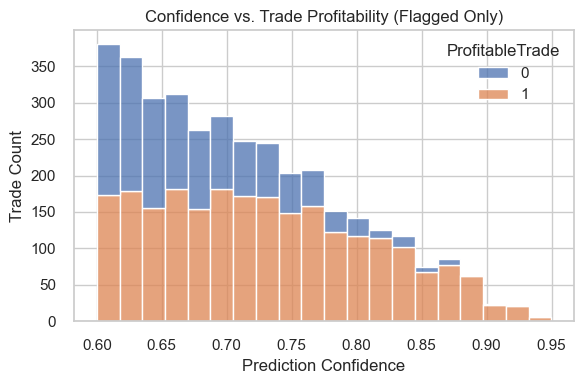


[Expected Value by Confidence Bin]


TradeCount      AvgPnL  TotalPnL   HitRate
ConfBin                                                 
(0.6, 0.62]          432   57.422593  24806.56  0.479167
(0.62, 0.64]         406   58.976305  23944.38  0.492611
(0.64, 0.66]         353   60.886147  21492.81  0.504249
(0.66, 0.68]         302   74.928841  22628.51  0.615894
(0.68, 0.7]          331   69.500604  23004.70  0.580060
(0.7, 0.72]          289   89.498443  25865.05  0.726644
(0.72, 0.74]         281   92.575552  26013.73  0.686833
(0.74, 0.76]         228  104.269035  23773.34  0.723684
(0.76, 0.78]         230  108.009087  24842.09  0.795652
(0.78, 0.8]          171  114.358421  19555.29  0.801170
(0.8, 0.82]          151  123.724636  18682.42  0.867550
(0.82, 0.84]         142  133.375000  18939.25  0.859155
(0.84, 0.86]          90  138.785444  12490.69  0.933333
(0.86, 0.88]          99  140.626869  13922.06  0.898990
(0.88, 0.9]           63  158.286825   9972.07  0.984127


[Classification Metrics for TradeFlag]
Precision: 0.66
Recall:    0.57
F1 Score:  0.61

 Plant-Outage vs TradeFlag Correlation:
B32_OUT                            0.196475
B31_OUT                            0.109971
GT7_OUT                            0.106249
VPL_Generation_Unit_OUT            0.064166
GT6_OUT                            0.053891
Moneypoint_2_Generator_Unit_OUT    0.053826
HPC1_Generation_Unit_OUT           0.041389
Moneypoint_3_Generator_Unit_OUT    0.039494
Great_Island_CCGT_OUT              0.025196
Tynagh_Generator_Unit_OUT          0.013478
Name: TradeFlag, dtype: float64


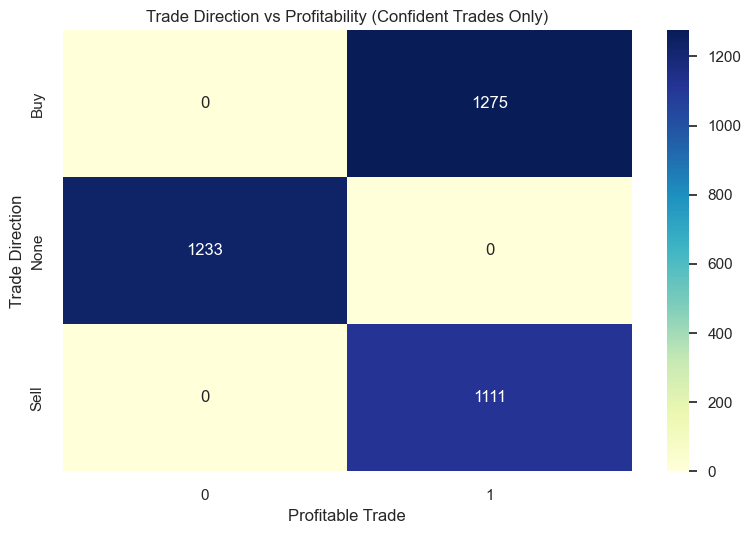

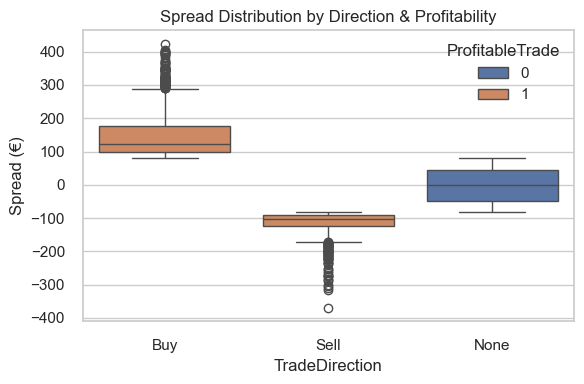

Missed High-Confidence Profitable Trades (≥75%): 35


In [12]:
# ========================== SECTION 5c — STRATEGY SNAPSHOT & DIAGNOSTICS ==========================

print(" [Diagnostics] Model Performance Summary")

# -----------------------------------------
# 1. Count total confident trades triggered by the classifier
# These are rows where the classifier predicted a trade (TradeFlag == 1)
total_trades = combined_prices_df['TradeFlag'].sum()

# 2. Total number of data points in the dataset (i.e., all timestamps)
total_points = len(combined_prices_df)

# Print the number and % of data points flagged as trades
print(f"→ Confident Trades: {total_trades:,} out of {total_points:,} ({100*total_trades/total_points:.2f}%)")

# -----------------------------------------
# 3. Directional breakdown of confident trades (Buy, Sell, None)
# Helps assess whether predictions are biased toward a specific direction
dir_dist = combined_prices_df[combined_prices_df['TradeFlag'] == 1]['TradeDirection'].value_counts()
print("\n→ Direction Distribution (Confident Trades):")
print(dir_dist)

# -----------------------------------------
# 4. Strategy Hit Rate: What % of confident trades were actually profitable
# ProfitableTrade == 1 indicates correct prediction (as defined earlier)
correct_trades = combined_prices_df[
    (combined_prices_df['TradeFlag'] == 1) &
    (combined_prices_df['ProfitableTrade'] == 1)
]
hit_rate = len(correct_trades) / total_trades if total_trades > 0 else 0
print(f"\n Strategy Hit Rate (Profitable Confidence Trades): {hit_rate:.2%} ({len(correct_trades)} / {total_trades})")

# -----------------------------------------
# 5. Descriptive statistics of spreads for only confident trades
print("\n→ Spread Stats for Confident Trades:")
print(combined_prices_df[combined_prices_df['TradeFlag'] == 1]['Spread_DAMtoBM'].describe())

# -----------------------------------------
# 6. Mean spread by trade direction (Buy, Sell, None) — helps validate economic sense
print("\n→ Mean Spread by Trade Direction (Flagged Only):")
print(
    combined_prices_df[combined_prices_df['TradeFlag'] == 1]
    .groupby('TradeDirection')['Spread_DAMtoBM']
    .mean()
)

# -----------------------------------------
# 7. Estimate Simulated Profit (basic model)
# If the trade was confident AND profitable, we assume profit = |spread|
# This is a naive PnL proxy (ignores cost, direction, position size)
combined_prices_df['SimulatedProfit'] = combined_prices_df.apply(
    lambda row: abs(row['Spread_DAMtoBM']) if row['TradeFlag'] == 1 and row['ProfitableTrade'] == 1 else 0,
    axis=1
)
print(f"\n Total Simulated Profit (Basic Model): €{combined_prices_df['SimulatedProfit'].sum():,.2f}")

# -----------------------------------------
# 8. Count missed profitable trades — i.e., cases where the model failed to signal
missed_opps = combined_prices_df[
    (combined_prices_df['ProfitableTrade'] == 1) &
    (combined_prices_df['TradeFlag'] == 0)
]
print(f" Missed Profitable Trades: {len(missed_opps)}")

# -----------------------------------------
# 9. Plot histogram: confidence vs trade profitability (stacked by outcome)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.histplot(
    data=combined_prices_df[combined_prices_df['TradeFlag'] == 1],
    x='Prediction_Confidence',
    hue='ProfitableTrade',
    bins=20,
    kde=False,
    multiple='stack'
)
plt.title("Confidence vs. Trade Profitability (Flagged Only)")
plt.xlabel("Prediction Confidence")
plt.ylabel("Trade Count")
plt.tight_layout()
plt.show()

# -----------------------------------------
# 10. Expected value by confidence bin
# Bins confidence into intervals and calculates:
# - Trade count
# - Average PnL
# - Total PnL
# - Hit rate (profitable trades / total)
import numpy as np
conf_bin_analysis = (
    combined_prices_df[combined_prices_df['TradeFlag'] == 1]
    .assign(ConfBin=lambda df: pd.cut(df['Prediction_Confidence'], bins=np.arange(0.6, 0.91, 0.02)))
    .groupby('ConfBin')
    .agg(
        TradeCount=('SimulatedProfit', 'count'),
        AvgPnL=('SimulatedProfit', 'mean'),
        TotalPnL=('SimulatedProfit', 'sum'),
        HitRate=('ProfitableTrade', 'mean')
    )
)
print("\n[Expected Value by Confidence Bin]")
display(conf_bin_analysis)

# -----------------------------------------
# 11. Classifier evaluation metrics using TradeFlag as the prediction
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = combined_prices_df['ProfitableTrade']  # ground truth
y_pred = combined_prices_df['TradeFlag']        # model prediction (based on confidence threshold)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\n[Classification Metrics for TradeFlag]")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

# -----------------------------------------
# 12. Correlation between each outage flag and TradeFlag
# Shows which outages the model considers predictive
plant_flags = [col for col in combined_prices_df.columns if col.endswith('_OUT')]
plant_trade_corr = (
    combined_prices_df[plant_flags + ['TradeFlag']]
    .corr()['TradeFlag']
    .drop('TradeFlag')
    .sort_values(ascending=False)
)
print("\n Plant-Outage vs TradeFlag Correlation:")
print(plant_trade_corr.head(10))

# -----------------------------------------
# 13. Heatmap of TradeDirection vs ProfitableTrade (confident trades only)
# Helps diagnose model alignment with direction and profitability
heatmap_data = pd.crosstab(
    combined_prices_df[combined_prices_df['TradeFlag'] == 1]['TradeDirection'],
    combined_prices_df[combined_prices_df['TradeFlag'] == 1]['ProfitableTrade']
)
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Trade Direction vs Profitability (Confident Trades Only)")
plt.xlabel("Profitable Trade")
plt.ylabel("Trade Direction")
plt.tight_layout()
plt.show()

# -----------------------------------------
# 14. Boxplot of spread distribution split by direction and profitability
# Helps visualize whether spread magnitudes match expected profitability
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=combined_prices_df[combined_prices_df['TradeFlag'] == 1],
    x='TradeDirection',
    y='Spread_DAMtoBM',
    hue='ProfitableTrade'
)
plt.title("Spread Distribution by Direction & Profitability")
plt.ylabel("Spread (€)")
plt.tight_layout()
plt.show()

# -----------------------------------------
# 15. Count how many profitable trades were missed (not flagged)
# even though their model confidence was high (≥ 0.75)
missed_high_conf = combined_prices_df[
    (combined_prices_df['ProfitableTrade'] == 1) &
    (combined_prices_df['TradeFlag'] == 0) &
    (combined_prices_df['Prediction_Confidence'] >= 0.75)
]
print(f"Missed High-Confidence Profitable Trades (≥75%): {len(missed_high_conf)}")


In [13]:
# ==================== SECTION 5d: ML → Signal Bridge — Annotated ====================

"""
Purpose:
--------
This section converts the trained regression model (from Section 5A)
into **tradeable ML-based signals** for downstream use.

It annotates the master DataFrame `combined_prices_df` with:
- ML_PredictedSpread     : Model's raw regression output (€ spread)
- ML_Direction           : -1, 0, or +1 indicating model's directional view
- ML_Confidence          : Confidence score [0, 1] based on prediction size vs. volatility
- ML_TradeFlag           : 1 if confident enough to trade, else 0
- ML_ProfitableTrade     : Whether trade would have been profitable (diagnostic only)
- ML_SimulatedProfit     : Estimated profit using a basic model (1 MW, symmetric payoff)

Preconditions:
--------------
- `final_model` is the trained PyCaret regression pipeline from 5A
- `combined_prices_df` contains **exact same features** used in model training
- No target leakage (BM price/spread) in features used during model prediction
"""

from pycaret.regression import get_config as get_config_reg, predict_model
import numpy as np
import pandas as pd

# ------------------------------------------------------------------------------------
# 0) Extract model training columns from PyCaret experiment
# ------------------------------------------------------------------------------------

# Recover the feature names (and their order) used during model training
X_cols = get_config_reg('X').columns.tolist()

# ------------------------------------------------------------------------------------
# 1) Build an inference matrix using only the trained feature columns
# ------------------------------------------------------------------------------------

# Slice `combined_prices_df` to match model input structure exactly
X_full = combined_prices_df[X_cols].copy()

# Use PyCaret to generate predictions on full dataset
# This automatically applies all preprocessing from training (scaling, imputation, etc.)
pred_out = predict_model(final_model, data=X_full)

# ------------------------------------------------------------------------------------
# 2) Extract the predicted spread from PyCaret output
# ------------------------------------------------------------------------------------

# The prediction column name may vary by PyCaret version:
if 'Label' in pred_out.columns:
    yhat = pred_out['Label']
elif 'prediction_label' in pred_out.columns:
    yhat = pred_out['prediction_label']
else:
    print('[5d] DEBUG: pred_out columns:', pred_out.columns.tolist())
    raise KeyError("PyCaret did not return 'Label' or 'prediction_label' for regression predictions.")

# ------------------------------------------------------------------------------------
# 3) Save model predictions to the master dataframe
# ------------------------------------------------------------------------------------

# This is the predicted € spread from DAM to BM for each half-hour
combined_prices_df['ML_PredictedSpread'] = yhat.values

# ------------------------------------------------------------------------------------
# 4) Generate directional signal based on sign of prediction
# ------------------------------------------------------------------------------------

# +1 = Long (BM > DAM), -1 = Short (BM < DAM), 0 = No strong view
combined_prices_df['ML_Direction'] = (
    np.sign(combined_prices_df['ML_PredictedSpread'])     # returns {-1.0, 0.0, +1.0}
      .replace({-0.0: 0})                                 # normalize -0.0 → 0
      .astype(int)                                        # ensure integer type
)

# ------------------------------------------------------------------------------------
# 5) Scale prediction into a confidence score [0, 1]
# ------------------------------------------------------------------------------------

# Use a 7-day (336 half-hours) rolling std of actual spreads for volatility
# min_periods=48 ensures early values are bootstrapped with at least 1 day of data
roll_vol = combined_prices_df['Spread_DAMtoBM'].shift(1).rolling(window=336, min_periods=48).std()

# Compute abs(pred) / recent volatility, capped and cleaned
scaled_abs = (
    (combined_prices_df['ML_PredictedSpread'].abs() / roll_vol.replace(0, np.nan))  # avoid div by 0
    .clip(0, 6)         # cap to avoid exploding confidence
    .fillna(0)          # early values become 0 confidence
)

# Apply exponential scaling to convert magnitude ratio into [0, 1] confidence
k = 1.2  # controls how steeply confidence increases with magnitude
combined_prices_df['ML_Confidence'] = (1 - np.exp(-k * scaled_abs)).clip(0, 1)

# ------------------------------------------------------------------------------------
# 6) Decide whether to trade based on confidence and predicted size
# ------------------------------------------------------------------------------------

# Optional fixed cost in €/MWh — set to 0 if no cost modeled
TC_EUR = 0.0

# TradeFlag = 1 only if:
# - Confidence is above threshold
# - Predicted spread exceeds fixed cost
combined_prices_df['ML_TradeFlag'] = (
    (combined_prices_df['ML_Confidence'] >= 0.65) &
    (combined_prices_df['ML_PredictedSpread'].abs() > TC_EUR)
).astype(int)

# ------------------------------------------------------------------------------------
# 7) Create diagnostic columns for ML trade evaluation
# ------------------------------------------------------------------------------------

# (a) ML_ProfitableTrade: 1 if trade taken AND correct direction
combined_prices_df['ML_ProfitableTrade'] = (
    (combined_prices_df['ML_TradeFlag'] == 1) &
    (combined_prices_df['ML_Direction'] * combined_prices_df['Spread_DAMtoBM'] > 0)
).astype(int)

# (b) ML_SimulatedProfit: PnL = signed spread - cost (if any), else 0
combined_prices_df['ML_SimulatedProfit'] = np.where(
    combined_prices_df['ML_TradeFlag'] == 1,
    combined_prices_df['ML_Direction'] * combined_prices_df['Spread_DAMtoBM']
    - np.sign(combined_prices_df['ML_Direction'] * combined_prices_df['Spread_DAMtoBM']) * TC_EUR,
    0.0
)

print("[5d] ML signals ready → ML_PredictedSpread, ML_Direction, ML_Confidence, ML_TradeFlag, ML_ProfitableTrade, ML_SimulatedProfit")


[5d] ML signals ready → ML_PredictedSpread, ML_Direction, ML_Confidence, ML_TradeFlag, ML_ProfitableTrade, ML_SimulatedProfit


In [14]:
# ==================== SECTION 6.0 — Outage Flag Cleaning & Preprocessing ====================

"""
Goal:
Clean all *_OUT columns to ensure they are:
- Strictly binary (0/1)
- Free of NaNs
- Exclude constant columns (all 0s or 1s) that add no information
"""

# Identify all outage-related flags (columns ending with '_OUT')
outage_flags = [c for c in combined_prices_df.columns if c.endswith('_OUT')]

# Clean the outage columns:
# - Fill missing values with 0 (no outage assumed)
# - Clip any values outside 0–1 (guards against merge artifacts like 0.2 or 1.3)
# - Convert to integer type (enforces binary semantics)
combined_prices_df[outage_flags] = (
    combined_prices_df[outage_flags]
        .fillna(0)
        .clip(0, 1)
        .astype(int)
)

# Identify constant columns (all values are the same — either all 0 or all 1)
const_flags = [c for c in outage_flags if combined_prices_df[c].nunique(dropna=False) <= 1]

# Drop constant flags (not useful for logic)
if const_flags:
    print(f"[6.0] Dropping constant outage flags: {const_flags}")
    combined_prices_df.drop(columns=const_flags, inplace=True)

# Create final list of usable outage flags (cleaned and variable)
OUTAGE_COLS_AVAILABLE = [
    c for c in outage_flags
    if c in combined_prices_df.columns and c not in const_flags
]

print(f"[6.0] Usable outage columns: {len(OUTAGE_COLS_AVAILABLE)}")






[6.0] Usable outage columns: 17


In [15]:
# ==================== SECTION 6.1A — Rule-Based Signal Construction ====================

"""
Goal:
Apply outage-based trading rules from 'filtered_outage_rules.csv' and track when each rule is active.

Outputs:
- Adds RULE_ACTIVE__<combo> columns for each rule combo
- Adds AnyRuleActive to flag any timestamp where at least one rule fires
- Prints diagnostics for profitability of each rule (diagnostic only, no trades placed yet)
"""

# Ensure required column exists before processing
required_cols = {'Spread_DAMtoBM'}
missing_req = [c for c in required_cols if c not in combined_prices_df.columns]
if missing_req:
    raise KeyError(f"[6.1] Missing required columns in combined_prices_df: {missing_req}")

# Load pre-filtered outage rules from CSV
rules_df = pd.read_csv("filtered_outage_rules.csv")
if 'Combination' not in rules_df.columns:
    raise KeyError("[6.1] 'filtered_outage_rules.csv' must include a 'Combination' column.")

# Validate that each rule combo references existing outage columns
available_cols = set(combined_prices_df.columns)
valid_combos = []
dropped = []

# Filter out rules referencing missing outage flags
for combo in rules_df['Combination']:
    units = [u.strip() for u in combo.split(" + ")]
    missing = [u for u in units if u not in available_cols]
    if missing:
        dropped.append((combo, missing))
    else:
        valid_combos.append(combo)

# Notify which combos were dropped, if any
if dropped:
    print(f"[6.1] Dropping {len(dropped)} rule combos that reference missing columns.")
    for combo, miss in dropped[:10]:
        print(f"  - {combo}  (missing: {miss})")
else:
    print("[6.1] No rule combos dropped for missing columns.")

# Retain only the valid combos in the dataframe
rules_df = rules_df[rules_df['Combination'].isin(valid_combos)].reset_index(drop=True)
print(f"[6.1] Compatible rule combos loaded: {len(valid_combos)}")

# If no valid rules remain, create empty outputs and exit
if not len(valid_combos):
    combined_prices_df['AnyRuleActive'] = False
    rule_stats_df = pd.DataFrame(columns=["Rule","TradeCount","TotalPnL","AvgPnL","HitRate"])
    display(rule_stats_df)

else:
    # For each valid rule combination, create a boolean column indicating when it's active
    for combo in rules_df['Combination']:
        units = [u.strip() for u in combo.split(" + ")]
        rule_col = f"RULE_ACTIVE__{combo}"
        # Rule is active if all constituent outages are active simultaneously
        combined_prices_df[rule_col] = (combined_prices_df[units].sum(axis=1) == len(units))

    # Master flag to indicate when any rule is active
    rule_cols = [f"RULE_ACTIVE__{combo}" for combo in rules_df['Combination']]
    if rule_cols:
        combined_prices_df['AnyRuleActive'] = combined_prices_df[rule_cols].any(axis=1)
    else:
        combined_prices_df['AnyRuleActive'] = False

    print(f"[6.1] Timestamps with ANY rule active: {int(combined_prices_df['AnyRuleActive'].sum())}")

    # Rule effectiveness diagnostics (using Spread_DAMtoBM)
    print("\n[Diagnostics] Individual Rule-Based Profitability:")
    rule_profit_stats = []
    has_profitable_flag = 'ProfitableTrade' in combined_prices_df.columns

    for rule_col in rule_cols:
        df_rule = combined_prices_df.loc[combined_prices_df[rule_col]]
        trade_count = len(df_rule)
        total_pnl = float(df_rule['Spread_DAMtoBM'].sum()) if trade_count else 0.0
        avg_pnl = (total_pnl / trade_count) if trade_count else 0.0
        hit_rate = float(df_rule['ProfitableTrade'].mean()) if (trade_count and has_profitable_flag) else np.nan

        rule_profit_stats.append({
            "Rule": rule_col.replace("RULE_ACTIVE__", ""),
            "TradeCount": trade_count,
            "TotalPnL": total_pnl,
            "AvgPnL": avg_pnl,
            "HitRate": hit_rate,
        })

    # Assemble and display rule scoreboard
    rule_stats_df = pd.DataFrame(rule_profit_stats).sort_values(by="TotalPnL", ascending=False)
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.max_colwidth', None)
    display(rule_stats_df)



[6.1] No rule combos dropped for missing columns.
[6.1] Compatible rule combos loaded: 207
[6.1] Timestamps with ANY rule active: 15682

[Diagnostics] Individual Rule-Based Profitability:


Rule  TradeCount  TotalPnL      AvgPnL   HitRate
18                                                                   Moneypoint_1_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT         664  35120.07   52.891672  0.337349
62                                                       Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT        1538  32367.28   21.045046  0.250975
0                                                            Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT         225  29560.04  131.377956  0.551111
1                          Moneypoint_1_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT         225  29560.04  131.377956  0.551111
79                                                                               B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT        1926  28632.70   14.866407  0.209761
..                                                                                                                             ...         ...       ...         ...       ...
87                                                                 Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Great_Island_CCGT_OUT         795  -4676.89   -5.882881  0.281761
155                                                                                      B31_OUT + Moneypoint_1_Generator_Unit_OUT        4666  -6277.98   -1.345474  0.216031
153                                    Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Great_Island_CCGT_OUT + Tynagh_Generator_Unit_OUT         664  -9485.63  -14.285587  0.209337
190                                                                              Great_Island_CCGT_OUT + Tynagh_Generator_Unit_OUT         664  -9485.63  -14.285587  0.209337
185  Moneypoint_1_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Great_Island_CCGT_OUT + Tynagh_Generator_Unit_OUT         664  -9485.63  -14.285587  0.209337

[207 rows x 5 columns]

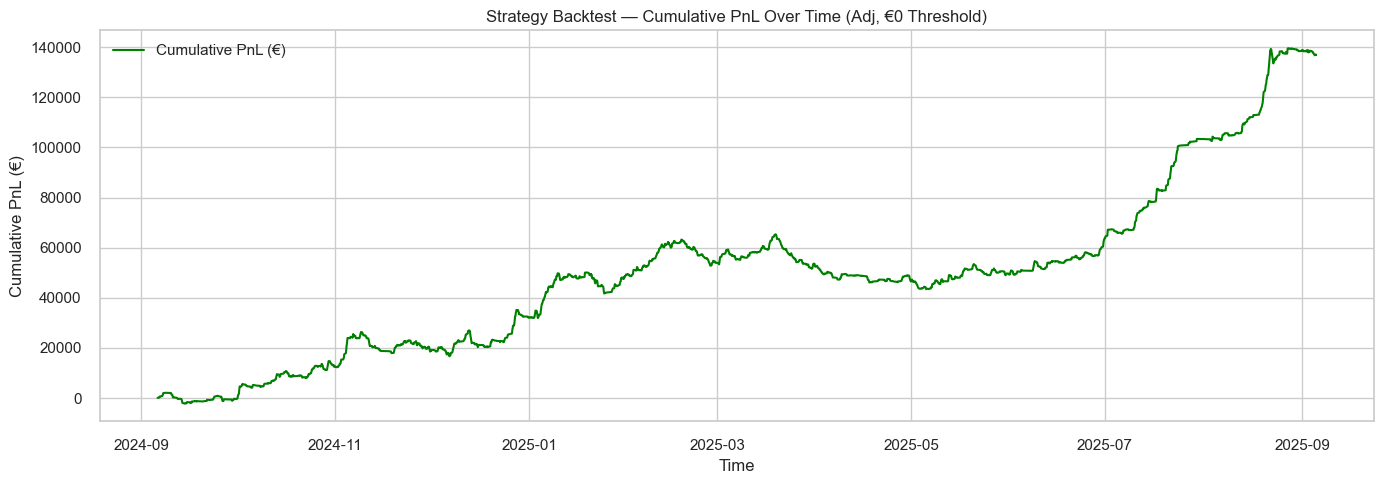


[Adjusted Strategy with €0 Threshold]
Trades Executed: 4164
Total Adjusted PnL: €136864.69
Average PnL per Trade: €32.87
Max Drawdown: €21877.19
Sharpe Ratio: 0.23
Win Rate: 54.95%
Profit Factor: 1.67
Payoff Ratio: 1.37
Expectancy per Trade: €32.87

Quarterly PnL:
 Quarter
2024Q3     -270.33
2024Q4    32324.91
2025Q1    20339.60
2025Q2    11377.62
2025Q3    73092.89
Freq: Q-DEC, Name: PnL_adj, dtype: float64


In [16]:
# ==================== SECTION 6.1B — Adjusted Strategy Backtest ====================

"""
Goal:
Backtest the rule-based strategy with optional transaction cost threshold.

Outputs:
- Cumulative PnL chart
- KPIs: Sharpe, drawdown, win rate, payoff, expectancy
"""

# --- Trade execution flag from rule signal
combined_prices_df['ExecuteTrade'] = combined_prices_df['TradeSignal'] == 1

# Copy to separate DataFrame for backtest tracking
backtest_df = combined_prices_df.copy()

# --- Transaction cost threshold (set to €0 here; can be changed)
transaction_cost_threshold = 0
backtest_df['ExecuteTrade_adj'] = (
    backtest_df['ExecuteTrade'] &
    (abs(backtest_df['Spread_DAMtoBM']) > transaction_cost_threshold)
)

# --- Simulate adjusted PnL: only apply spread if trade is executed
backtest_df['PnL_adj'] = backtest_df['ExecuteTrade_adj'] * backtest_df['Spread_DAMtoBM']
backtest_df['CumulativePnL_adj'] = backtest_df['PnL_adj'].cumsum()

# --- Calculate max drawdown
cumulative = backtest_df['CumulativePnL_adj']
running_max = cumulative.cummax()
drawdown = running_max - cumulative
max_drawdown = drawdown.max()

# --- Risk metrics: Sharpe ratio and win rate
returns = backtest_df.loc[backtest_df['ExecuteTrade_adj'], 'PnL_adj']
sharpe_ratio = returns.mean() / returns.std() if returns.std() != 0 else np.nan
win_rate = (returns > 0).mean()

# --- Plot cumulative PnL over time
executed_trades = backtest_df[backtest_df['ExecuteTrade_adj']]
pnl_over_time = executed_trades.groupby('StartDateTime')['PnL_adj'].sum().sort_index()
pnl_over_time_cum = pnl_over_time.cumsum()

plt.figure(figsize=(14, 5))
plt.plot(pnl_over_time_cum.index, pnl_over_time_cum.values, label='Cumulative PnL (€)', color='green')
plt.xlabel("Time")
plt.ylabel("Cumulative PnL (€)")
plt.title(f"Strategy Backtest — Cumulative PnL Over Time (Adj, €{transaction_cost_threshold} Threshold)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Summary KPIs
exec_trades = backtest_df['ExecuteTrade_adj'].sum()
total_pnl_adj = backtest_df['PnL_adj'].sum()
avg_pnl_adj = returns.mean()

print(f"\n[Adjusted Strategy with €{transaction_cost_threshold} Threshold]")
print(f"Trades Executed: {exec_trades}")
print(f"Total Adjusted PnL: €{total_pnl_adj:.2f}")
print(f"Average PnL per Trade: €{avg_pnl_adj:.2f}")
print(f"Max Drawdown: €{max_drawdown:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Win Rate: {win_rate * 100:.2f}%")

# --- Profitability metrics
profits = returns[returns > 0]
losses = returns[returns < 0]
profit_factor = profits.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan
avg_win = profits.mean()
avg_loss = abs(losses.mean())
payoff_ratio = avg_win / avg_loss if avg_loss > 0 else np.nan
expectancy = (win_rate * avg_win) - ((1 - win_rate) * avg_loss)

print(f"Profit Factor: {profit_factor:.2f}")
print(f"Payoff Ratio: {payoff_ratio:.2f}")
print(f"Expectancy per Trade: €{expectancy:.2f}")

# --- Quarterly regime PnL breakdown
backtest_df['Quarter'] = backtest_df['StartDateTime'].dt.to_period('Q')
quarterly_pnl = backtest_df.groupby('Quarter')['PnL_adj'].sum()
print("\nQuarterly PnL:\n", quarterly_pnl)

# --- Sync back to main dataframe
combined_prices_df['ExecuteTrade_adj'] = backtest_df['ExecuteTrade_adj']
combined_prices_df['PnL_adj'] = backtest_df['PnL_adj']


[6.2A] Using 17 outage columns.

[Section 6.2A] Outage Impact on DAM–BM Spread (top 20):
                                            Unit  AvgSpread_WhenOut  AvgSpread_WhenIn  Difference  PctDifference  OutageObservations
4        Coolkeeragh_ESB_CCGT_Generator_Unit_OUT          11.606829         -1.351214   12.958044     958.992423                3996
10                   Aghada_2_Generator_Unit_OUT          12.993974          0.267078   12.726896    4765.231650                1837
14                           Shellybanks_PBA_OUT           8.242222          0.012343    8.229879   66676.848727                3384
2                Moneypoint_3_Generator_Unit_OUT           3.946846         -0.496706    4.443552     894.603683                8278
6                Moneypoint_2_Generator_Unit_OUT           3.873045          0.805286    3.067759     380.952732                4542
11                           Shellybanks_PBB_OUT           3.652118          1.027117    2.625001     255.569800 

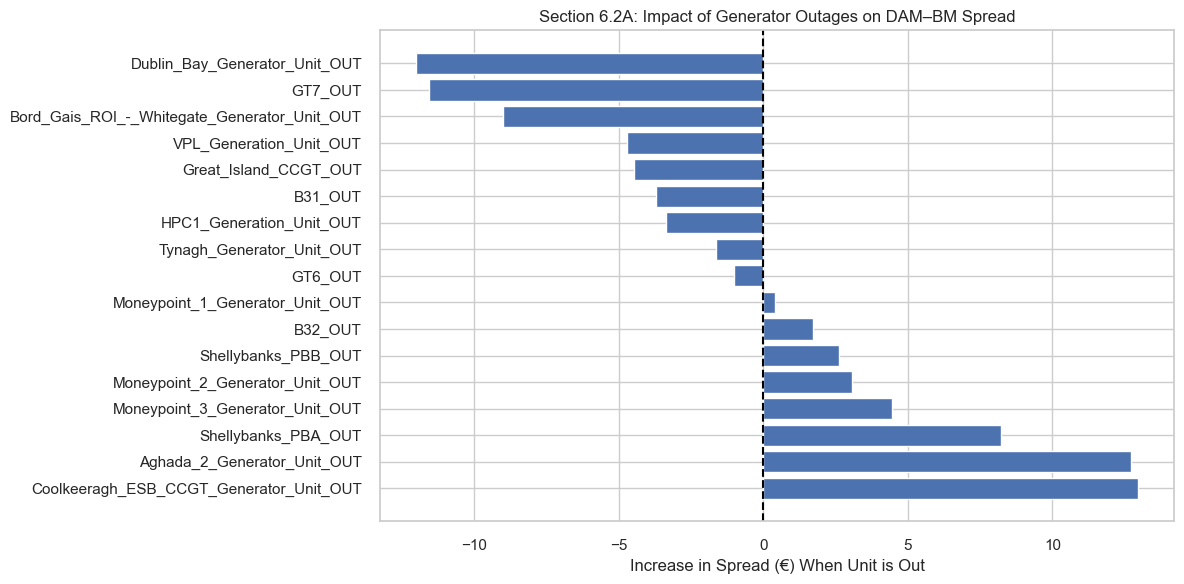

In [17]:
# ==================== Section 6.2A: Impact of generator outages on DAM–BM Spread ====================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Retrieve list of valid outage flags ---

# Use outage columns cleaned in Section 6.0 (binary, non-constant)
# Fall back to detecting *_OUT columns manually if OUTAGE_COLS_AVAILABLE is missing (e.g., new session)
if 'OUTAGE_COLS_AVAILABLE' in globals():
    outage_cols = OUTAGE_COLS_AVAILABLE.copy()  # ← Cleaned list from Section 6.0
else:
    candidate = [c for c in combined_prices_df.columns if c.endswith('_OUT')]  # Fallback: all *_OUT
    outage_cols = [c for c in candidate if combined_prices_df[c].nunique(dropna=False) > 1]  # Remove constants

# --- 2) Drop any *_OUT columns that don't exist in the DataFrame ---

# Defensive coding in case the list and actual data got out of sync
missing_cols = [c for c in outage_cols if c not in combined_prices_df.columns]
if missing_cols:
    print(f"[6.2A] Dropping {len(missing_cols)} missing outage columns: {missing_cols}")
    outage_cols = [c for c in outage_cols if c in combined_prices_df.columns]

# --- 3) Drop any constants still remaining (all 0s or all 1s) ---

constant_cols = [c for c in outage_cols if combined_prices_df[c].nunique(dropna=False) <= 1]
if constant_cols:
    print(f"[6.2A] Dropping {len(constant_cols)} constant outage columns: {constant_cols}")
    outage_cols = [c for c in outage_cols if c not in constant_cols]

print(f"[6.2A] Using {len(outage_cols)} outage columns.")

# --- 4) Calculate impact of each unit outage on the realized DAM–BM spread ---

impact_summary = []                    # Collect rows of impact metrics
spread_col = 'Spread_DAMtoBM'         # Column name for the target (realized spread)

for col in outage_cols:
    # Build boolean masks for when the unit is OUT and IN
    out_mask = combined_prices_df[col] == 1
    in_mask  = combined_prices_df[col] == 0

    # Extract the spread data when the unit is OUT and IN
    spread_out = combined_prices_df.loc[out_mask, spread_col]
    spread_in  = combined_prices_df.loc[in_mask, spread_col]

    # Mean spread in each case (with safety against empty slices)
    avg_spread_out = spread_out.mean() if not spread_out.empty else np.nan
    avg_spread_in  = spread_in.mean()  if not spread_in.empty  else np.nan

    # Compute the difference: how much the spread increases when the unit is OUT
    diff = (avg_spread_out - avg_spread_in
            if pd.notna(avg_spread_out) and pd.notna(avg_spread_in) else np.nan)

    # % difference relative to the absolute IN value, if possible
    pct_diff = ((diff / abs(avg_spread_in)) * 100
                if pd.notna(diff) and avg_spread_in not in (0, np.nan) else np.nan)

    # Store all metrics for this unit
    impact_summary.append({
        'Unit': col,
        'AvgSpread_WhenOut': avg_spread_out,
        'AvgSpread_WhenIn':  avg_spread_in,
        'Difference':        diff,
        'PctDifference':     pct_diff,
        'OutageObservations': int(out_mask.sum())
    })

# --- 5) Convert to DataFrame and sort by absolute effect size ---

impact_df = pd.DataFrame(impact_summary).sort_values(by='Difference', ascending=False)

# Print summary table (top 20 most impactful outages)
print("\n[Section 6.2A] Outage Impact on DAM–BM Spread (top 20):")
print(impact_df[['Unit', 'AvgSpread_WhenOut', 'AvgSpread_WhenIn',
                 'Difference', 'PctDifference', 'OutageObservations']].head(20))

# --- 6) Plot the spread impact for each unit as a horizontal bar chart ---

plt.figure(figsize=(12, 6))
plt.barh(impact_df['Unit'], impact_df['Difference'])
plt.axvline(0, color='black', linestyle='--')  # Dashed zero reference line
plt.xlabel("Increase in Spread (€) When Unit is Out")
plt.title("Section 6.2A: Impact of Generator Outages on DAM–BM Spread")
plt.tight_layout()
plt.show()



--- Analyzing 2-way Outage Combinations ---

--- Analyzing 3-way Outage Combinations ---

--- Analyzing 4-way Outage Combinations ---
[6.2B] Kept 461/649 combos with NumObs_WhenOut >= 200

Top 2-unit Outage Combinations:


Combination  NumUnits  AvgSpread_WhenAllOut  AvgSpread_WhenAllIn_orNotAllOut  Difference  PctDifference  NumObs_WhenOut  \
61       Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT         2            124.283288                        -0.690426  124.973713   18100.959410             225   
71                         Great_Island_CCGT_OUT + Aghada_2_Generator_Unit_OUT         2             63.343232                         2.096386   61.246846    2921.544594             253   
49               Moneypoint_1_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT         2             50.460231                         3.254266   47.205966    1450.587325             664   
62               Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBB_OUT         2             36.067540                        -1.025897   37.093437    3615.708060             476   
65               Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBA_OUT         2             33.949522                        -2.351568   36.301090    1543.697029             483   
74                                 Great_Island_CCGT_OUT + Shellybanks_PBA_OUT         2             29.789232                         1.407718   28.381514    2016.136818             341   
57   Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT         2             20.198779                        -2.435381   22.634160     929.388864             507   
38                 Moneypoint_3_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT         2             22.928178                         0.675665   22.252514    3293.426369             400   
30   Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT         2             19.529120                        -2.485568   22.014688     885.700648            1538   
81                       Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBA_OUT         2             18.420615                         0.071719   18.348895   25584.375751            1084   
16                           B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT         2             13.834621                        -2.538943   16.373564     644.896886            1926   
66                           Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + GT6_OUT         2             14.774626                        -0.844894   15.619519    1848.696507             590   
40                       Moneypoint_3_Generator_Unit_OUT + Shellybanks_PBA_OUT         2             11.619345                        -0.729770   12.349115    1692.192251            2304   
89                                               B32_OUT + Shellybanks_PBA_OUT         2              9.771236                        -1.181561   10.952797     926.977156            1092   
39                  Moneypoint_3_Generator_Unit_OUT + HPC1_Generation_Unit_OUT         2             10.702076                         0.015435   10.686641   69234.584812             262   
77                                   Moneypoint_2_Generator_Unit_OUT + B32_OUT         2             11.645558                         1.293010   10.352548     800.654935            2070   
31                     Moneypoint_3_Generator_Unit_OUT + Great_Island_CCGT_OUT         2              9.942544                         0.567078    9.375467    1653.295203             308   
90                                                           B32_OUT + GT6_OUT         2             10.824034                         1.571874    9.252160     588.606805             873   
80                       Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBB_OUT         2              9.324494                         0.461376    8.863118    1921.017447            1086   
82                                   Moneypoint_2_Generator_Unit_OUT + GT6_OUT         2             10.408769                         1.766176    8.642593     489.339390            1281   
114                                              Shellybanks_PBA_OUT + GT6_OU

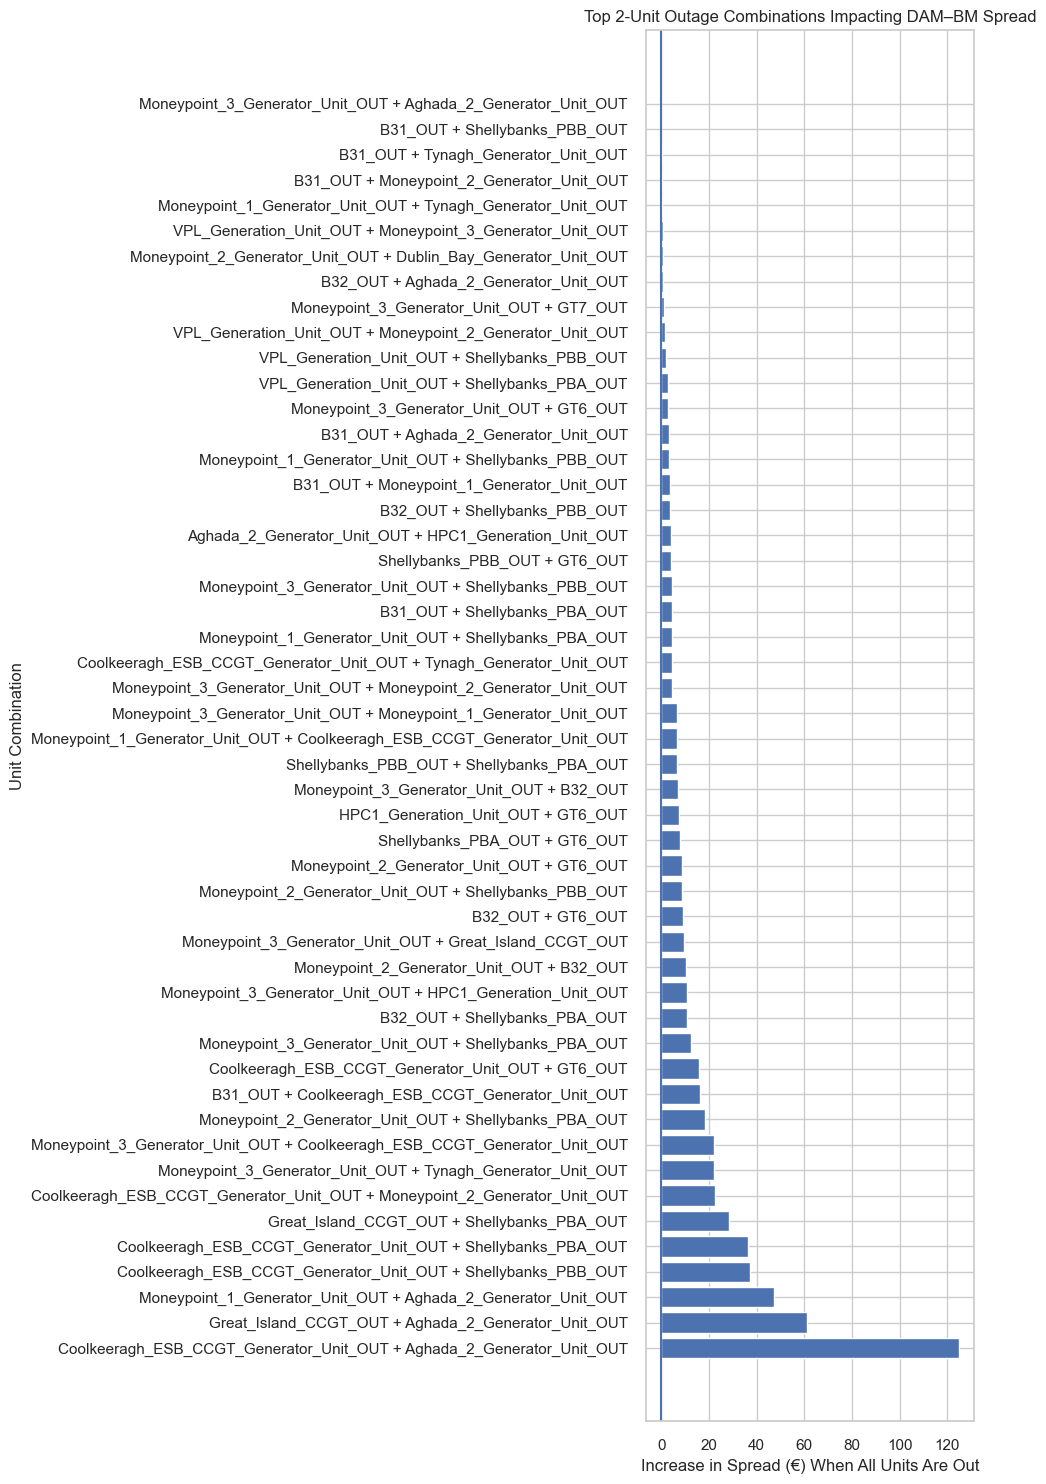


Top 3-unit Outage Combinations:


Combination  NumUnits  AvgSpread_WhenAllOut  AvgSpread_WhenAllIn_orNotAllOut  Difference  \
294      Moneypoint_1_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT         3            124.283288                         1.376866  122.906422   
298                        Moneypoint_1_Generator_Unit_OUT + Great_Island_CCGT_OUT + Aghada_2_Generator_Unit_OUT         3             72.038368                         4.231968   67.806400   
198                                B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT         3             53.903565                        -5.084868   58.988432   
258  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT         3             40.274429                        -7.551507   47.825936   
190                                        B31_OUT + Moneypoint_1_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT         3             37.423568                        -9.338739   46.762308   
327              Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBA_OUT         3             42.654948                        -3.365622   46.020571   
328                          Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + GT6_OUT         3             43.438282                        -2.165163   45.603445   
326              Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBB_OUT         3             41.051446                        -2.827244   43.878690   
261              Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBA_OUT         3             37.019522                        -2.890578   39.910100   
259              Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBB_OUT         3             36.019591                        -2.928315   38.947906   
197                                      B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBB_OUT         3             34.664525                        -2.538943   37.203468   
330                          Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBB_OUT + Shellybanks_PBA_OUT         3             33.333173                        -2.030614   35.363787   
200                                      B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBA_OUT         3             31.785317                        -2.766326   34.551643   
171                          B31_OUT + Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT         3             32.555675                         0.169355   32.386320   
262                          Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + GT6_OUT         3             30.232707                        -1.912409   32.145116   
345                                                          Moneypoint_2_Generator_Unit_OUT + B32_OUT + GT6_OUT         3             33.606085                         3.572585   30.033500   
268                      Moneypoint_3_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBA_OUT         3             25.632695                        -3.523979   29.156674   
333                                      Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBA_OUT + GT6_OUT         3             27.204871                        -1.253200   28.458071   
128                  VPL_Generation_Unit_OUT + Moneypoint_3_Generator_Unit_OUT + Moneypoint_1_Generator_Unit_OUT         3             26.629692                        -1.510596   28.140288   
201                                                  B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + GT6_OUT         3             28.446395                         1.020462   27.425933   
344                                             

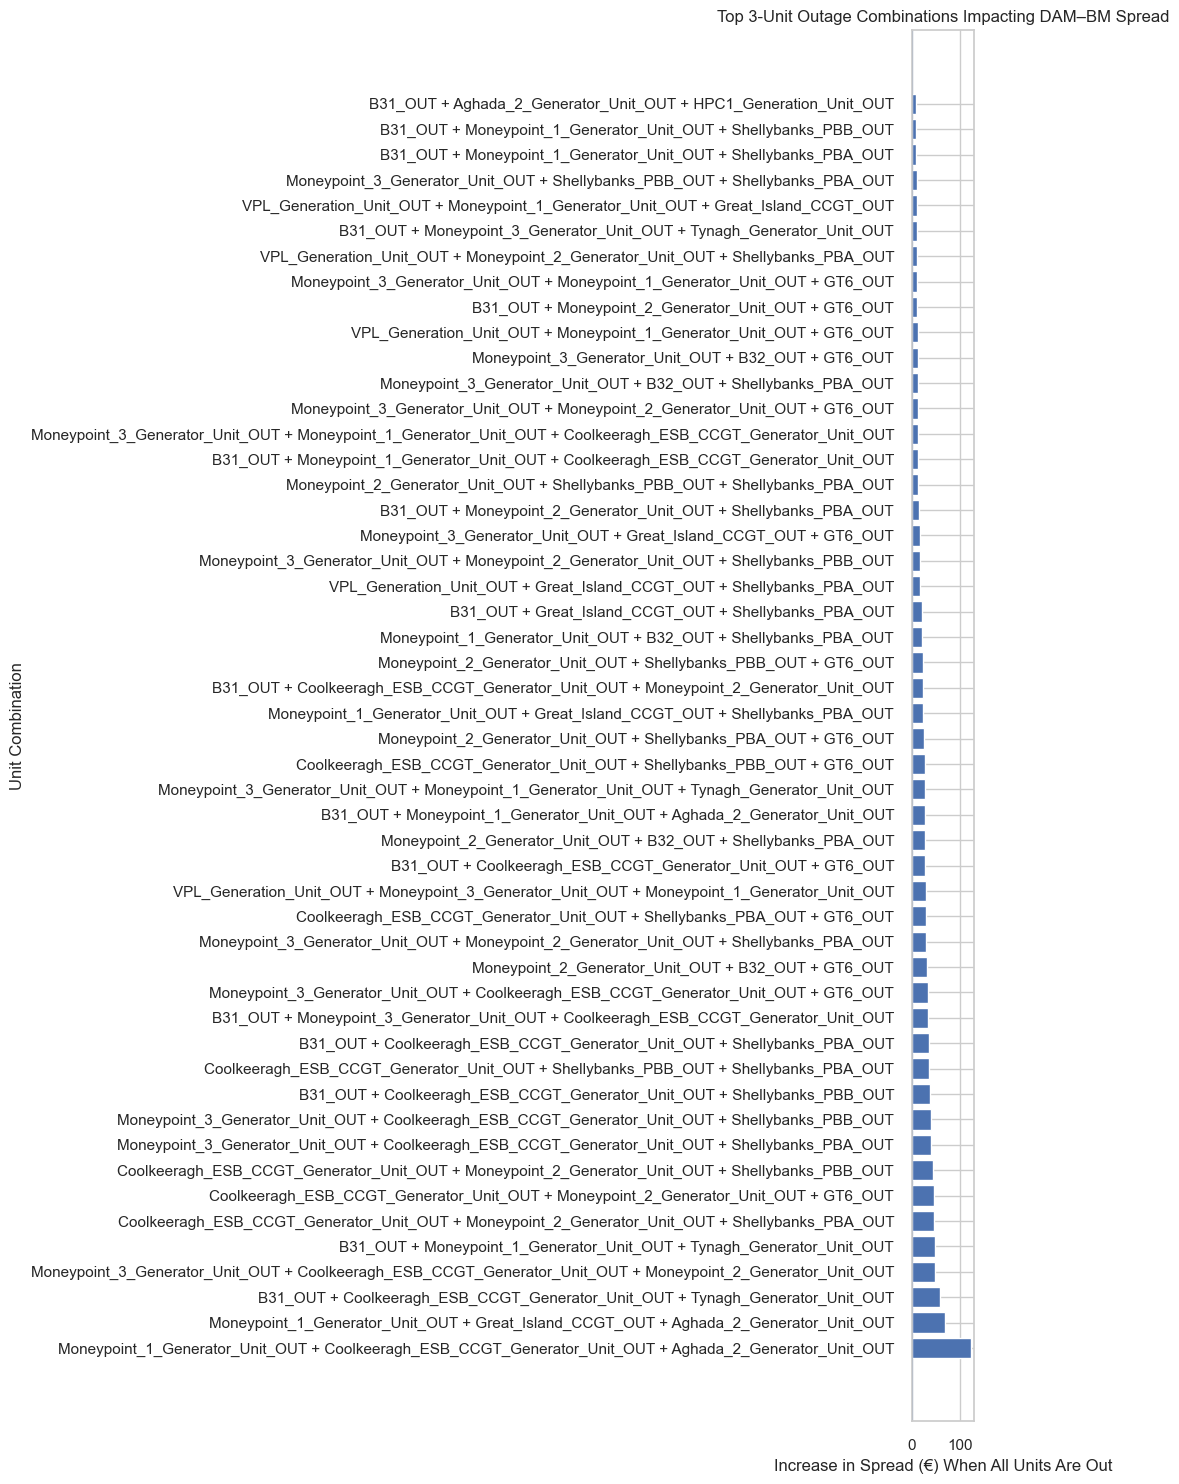


Top 4-unit Outage Combinations:


Combination  NumUnits  AvgSpread_WhenAllOut  \
508                    B31_OUT + Moneypoint_1_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT         4             53.903565   
583  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBA_OUT         4             42.654948   
584              Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + GT6_OUT         4             43.438282   
582  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBB_OUT         4             41.051446   
530                          B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBB_OUT         4             41.051446   
531                          B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBA_OUT         4             41.051446   
631                          Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBA_OUT + GT6_OUT         4             42.654948   
629              Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBB_OUT + Shellybanks_PBA_OUT         4             41.051446   
630                          Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBB_OUT + GT6_OUT         4             41.051446   
532                                      B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + GT6_OUT         4             41.051446   
585              Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBB_OUT + Shellybanks_PBA_OUT         4             36.019591   
477              B31_OUT + Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT         4             37.891091   
478                          B31_OUT + Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBB_OUT         4             36.019591   
480                          B31_OUT + Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBA_OUT         4             36.019591   
533                                      B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBB_OUT + Shellybanks_PBA_OUT         4             31.860483   
590                                              Moneypoint_3_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + B32_OUT + GT6_OUT         4             33.606085   
589                                  Moneypoint_3_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + B32_OUT + Shellybanks_PBA_OUT         4             30.994498   
587                          Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBA_OUT + GT6_OUT         4             27.204871   
594                                  Moneypoint_3_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBA_OUT + GT6_OUT         4             26.795796   
422                              VPL_Generation_Unit_OUT + Moneypoint_3_Generator_Unit_OUT + Moneypoint_1_Generator_Unit_OUT + GT6_OUT         4             27.162053   
586                          Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBB_OUT + GT6_OUT         4             25.860143   
481                                      B31_OUT + Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + GT6_OUT         4             28.446395   
632                                      Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Shellybanks_PBB_OUT + Shellybanks_PBA_OUT + GT6_OUT         4             25.860143   
593                                  Moneyp

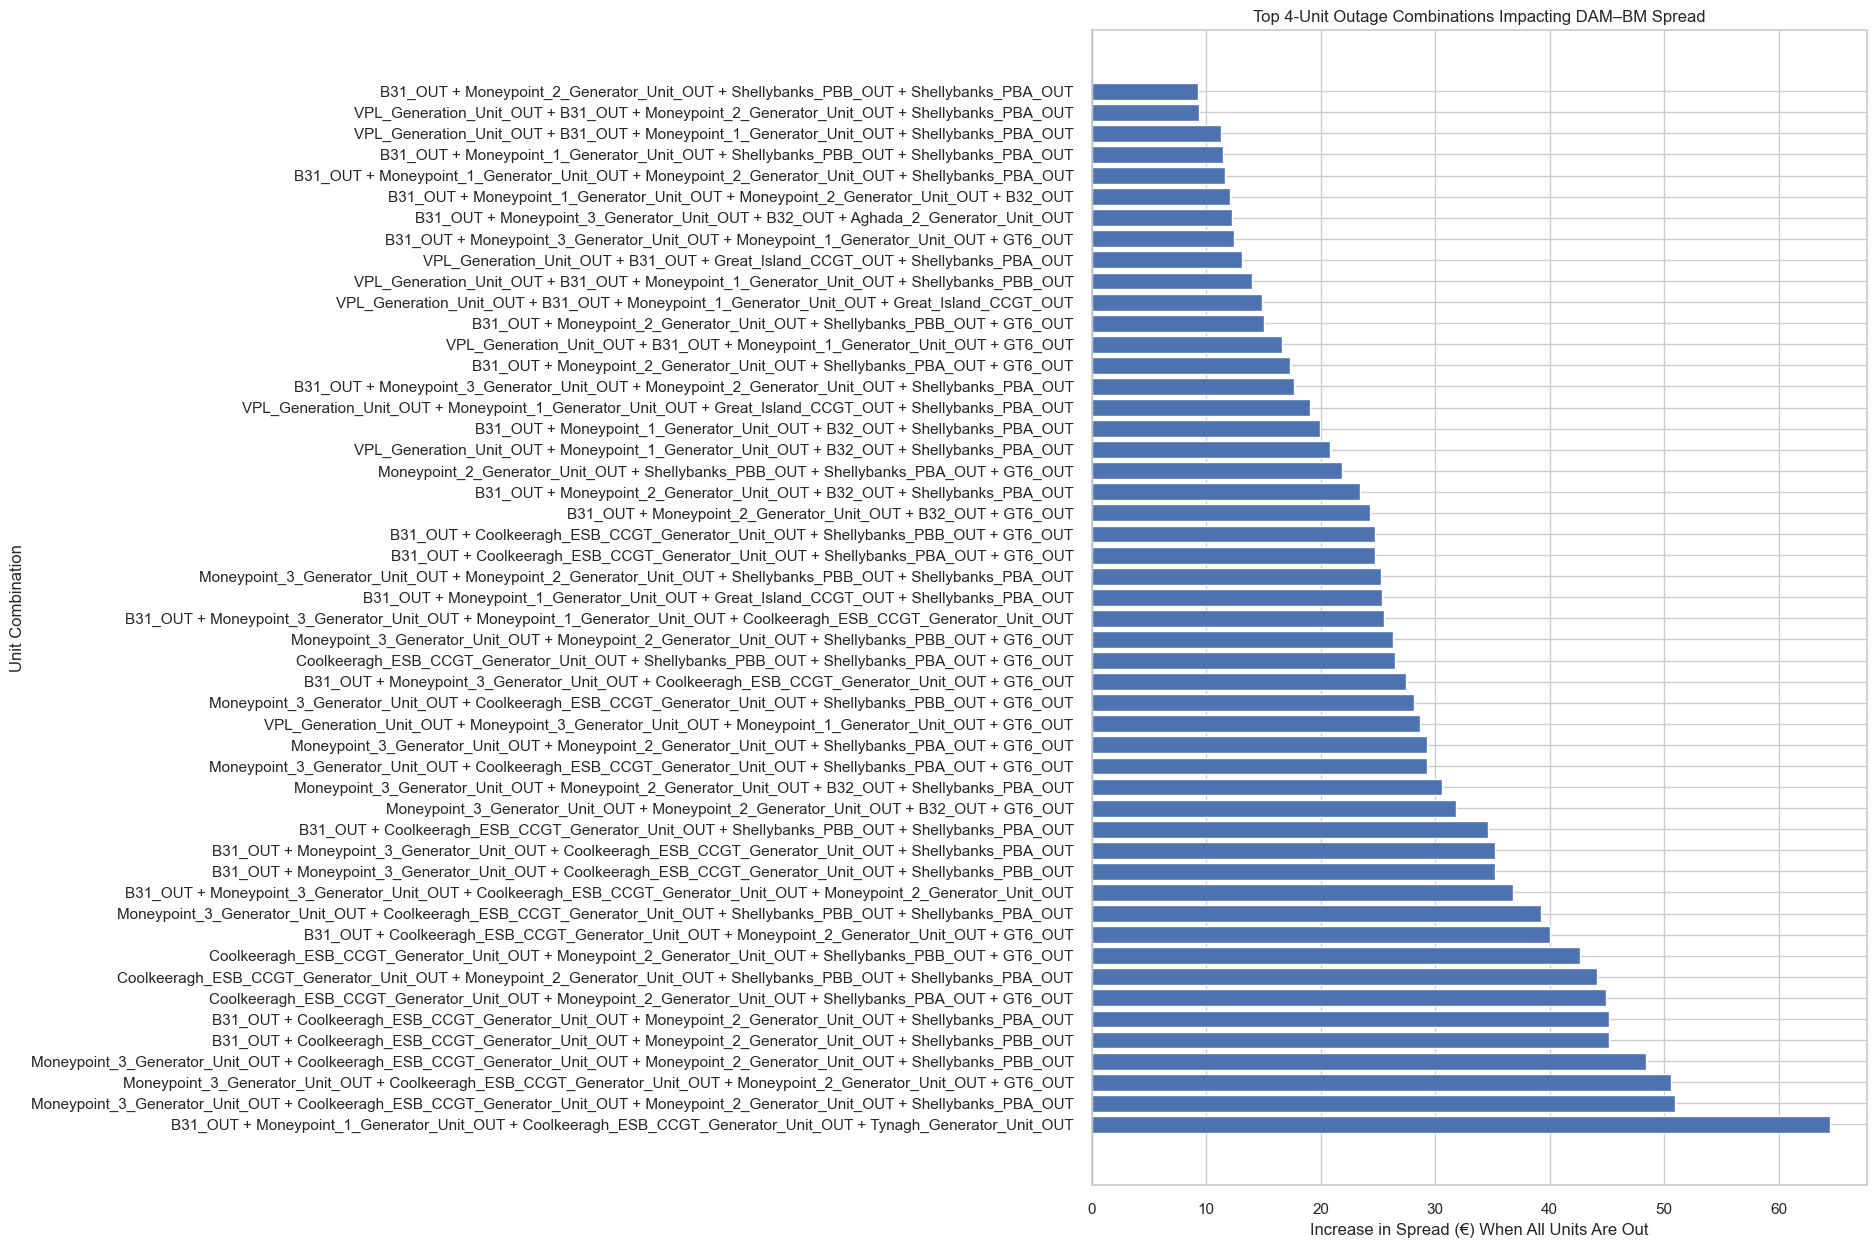


[6.2B] Saved 240 filtered rules with weights to 'filtered_outage_rules.csv'


In [18]:
# ==================== Section 6.2B: Multi-Unit Outage Combinations ====================

import itertools   # For generating combinations of outage units (2-way, 3-way, etc.)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- Controls / hyper-parameters ---------------------------------------

ALLOW_1WAY   = False   # If True, include single-outage effects (1-unit rules); else skip them.
MIN_OBS_SAVE = 200     # Minimum observations where all units are out to retain the combo in the final output.
SCAN_MIN_OBS = max(50, MIN_OBS_SAVE // 2)  # Lower threshold just to evaluate a combo before saving it.

# ----------------------------- Outage column universe (from 6.2A) --------------------------------

# Try to reuse vetted outage columns from Section 6.2A.
try:
    major_units = outage_cols  # These were already cleaned and checked in 6.2A.
except NameError:
    # If running from a fresh kernel, fall back to a manually curated list of outage flags.
    existing_cols = set(combined_prices_df.columns)
    requested_outage_cols = [
        'Great_Island_CCGT_OUT','Aghada_2_Generator_Unit_OUT',
        'Bord_Gais_ROI_-_Whitegate_Generator_Unit_OUT',
        'Coolkeeragh_ESB_CCGT_Generator_Unit_OUT','Dublin_Bay_Generator_Unit_OUT',
        'Tynagh_Generator_Unit_OUT','VPL_Generation_Unit_OUT',
        'GT7_OUT','GT6_OUT','HPC1_Generation_Unit_OUT',
        'Moneypoint_1_Generator_Unit_OUT','Moneypoint_2_Generator_Unit_OUT','Moneypoint_3_Generator_Unit_OUT',
        'B31_OUT','B32_OUT','Tarbert_4_Generator_Unit_OUT','Tarbert_3_Generator_Unit_OUT',
        'Shellybanks_PBA_OUT','Shellybanks_PBB_OUT'
    ]
    # Keep only those outage flags that actually exist in the current DataFrame
    major_units = [c for c in requested_outage_cols if c in existing_cols]
    print(f"[6.2B] Using {len(major_units)} available unit flags for combinations.")

# ----------------------------- Ensure spread column exists ---------------------------------------

# If DAM–BM spread is not in the DataFrame (e.g., fresh run), reconstruct it from price columns
if 'Spread_DAMtoBM' not in combined_prices_df.columns:
    combined_prices_df['Spread_DAMtoBM'] = (
        combined_prices_df['PriceImbalance'] - combined_prices_df['PriceDAM']
    )

# ----------------------------- Light winsorization for stability ---------------------------------

# Clip extreme values of the spread (1% tails) to reduce impact of outliers on mean differences
WINSOR = 0.01
low_q  = combined_prices_df['Spread_DAMtoBM'].quantile(WINSOR)
high_q = combined_prices_df['Spread_DAMtoBM'].quantile(1 - WINSOR)
combined_prices_df['Spread_W'] = combined_prices_df['Spread_DAMtoBM'].clip(lower=low_q, upper=high_q)
# 'Spread_W' is the winsorized spread used in this analysis

# ----------------------------- Scan all combinations ---------------------------------------------

all_combo_results = []   # List of dictionaries holding stats for each combo

# Choose which combo sizes to scan (2–4 unit combos by default)
combo_sizes = [1, 2, 3, 4] if ALLOW_1WAY else [2, 3, 4]

for r in combo_sizes:
    print(f"\n--- Analyzing {r}-way Outage Combinations ---")

    # Generate all unique combinations of r outage units
    for combo in itertools.combinations(major_units, r):
        cols = list(combo)  # List of column names in this combo

        # Define a mask for timestamps where all units in the combo are simultaneously out
        out_all = (combined_prices_df[cols].sum(axis=1) == r)
        n_out   = int(out_all.sum())  # Count how many such timestamps exist

        if n_out < SCAN_MIN_OBS:
            continue  # Skip this combo if too few data points

        # Pull the winsorized spread for these "all out" periods
        pnl_series = combined_prices_df.loc[out_all, 'Spread_W']
        avg_spread = float(pnl_series.mean())    # Average spread when all units are out
        total_pnl  = float(pnl_series.sum())     # Total (diagnostic) PnL

        # Baseline: find average spread when all of these units are **not all out**
        all_in_mask = (combined_prices_df[cols].sum(axis=1) == 0)
        if all_in_mask.sum() < SCAN_MIN_OBS:
            base_mask = ~out_all  # Fallback: use all timestamps that are NOT "all out"
        else:
            base_mask = all_in_mask

        base_spread = float(combined_prices_df.loc[base_mask, 'Spread_W'].mean())  # Baseline avg spread

        # Compute absolute and percentage effect size
        diff     = avg_spread - base_spread if pd.notna(base_spread) else np.nan
        denom    = abs(base_spread) if (pd.notna(base_spread) and base_spread != 0) else np.nan
        pct_diff = (diff / denom * 100) if pd.notna(diff) and pd.notna(denom) else np.nan

        # Hit-rate proxy: what fraction of these trades would’ve made money
        hit_rate = float((pnl_series > 0).mean()) if not pnl_series.empty else np.nan

        # Store all metrics for this combo
        all_combo_results.append({
            'Combination': " + ".join(combo),               # Human-readable format
            'NumUnits': r,                                  # How many units in the combo
            'AvgSpread_WhenAllOut': avg_spread,             # Mean spread when all are out
            'AvgSpread_WhenAllIn_orNotAllOut': base_spread, # Comparison baseline
            'Difference': diff,                             # Effect size
            'PctDifference': pct_diff,                      # Percent effect
            'NumObs_WhenOut': n_out,                        # Sample size
            'TotalPnL': total_pnl,                          # Sum of winsorized spread
            'AvgPnL': avg_spread,                           # Redundant alias
            'HitRate': hit_rate,                            # Fraction of positive outcomes
            'ComboType': f"{r}-way"                         # Helpful for grouping later
        })

# Convert to DataFrame and rank by absolute spread effect
combo_df_all = pd.DataFrame(all_combo_results).sort_values(by='Difference', ascending=False)

# ----------------------------- Evidence filter & rule weight -------------------------------------

# Filter out combos with too few observations to be reliable
before_n = combo_df_all.shape[0]
combo_df_all = combo_df_all[combo_df_all['NumObs_WhenOut'] >= MIN_OBS_SAVE].copy()
after_n = combo_df_all.shape[0]
print(f"[6.2B] Kept {after_n}/{before_n} combos with NumObs_WhenOut >= {MIN_OBS_SAVE}")

# Add a custom 'RuleWeight' score to prioritize strong and frequent combos
combo_df_all['RuleWeight'] = combo_df_all['Difference'] * np.log1p(combo_df_all['NumObs_WhenOut'])

# ----------------------------- Reporting & plots by combo size -----------------------------------

for r in combo_sizes:
    # Get top 50 combos for this combo size (sorted by spread difference)
    top_r_df = combo_df_all[combo_df_all['NumUnits'] == r].head(50)
    if top_r_df.empty:
        print(f"\nNo {r}-unit combinations met criteria.")
        continue

    print(f"\nTop {r}-unit Outage Combinations:")
    display(top_r_df)

    # Horizontal bar plot for visualizing impact of each combo
    plt.figure(figsize=(10, min(15, 1 + 0.4 * len(top_r_df))))
    plt.barh(top_r_df['Combination'], top_r_df['Difference'])
    plt.axvline(0)  # Zero line for reference
    plt.title(f"Top {r}-Unit Outage Combinations Impacting DAM–BM Spread")
    plt.xlabel("Increase in Spread (€) When All Units Are Out")
    plt.ylabel("Unit Combination")
    plt.tight_layout()
    plt.show()

# ----------------------------- Export filtered rules to CSV --------------------------------------

# Keep only profitable, well-supported combos for downstream strategy (e.g., 6.1A)
filtered_rules = combo_df_all[
    (combo_df_all['Difference'] > 0) & (combo_df_all['NumObs_WhenOut'] >= MIN_OBS_SAVE)
].copy()

# Define final export columns
cols_to_save = [
    'Combination','NumUnits','AvgSpread_WhenAllOut','AvgSpread_WhenAllIn_orNotAllOut',
    'Difference','PctDifference','NumObs_WhenOut','TotalPnL','AvgPnL','HitRate',
    'ComboType','RuleWeight'
]

# Save results to CSV for rule-based strategy use in Section 6.1A
filtered_rules.to_csv("filtered_outage_rules.csv", index=False, columns=cols_to_save)
print(f"\n[6.2B] Saved {len(filtered_rules)} filtered rules with weights to 'filtered_outage_rules.csv'")

# Artifacts created/updated by this section:
#   - combined_prices_df['Spread_W']         : winsorized spread used for more stable analysis
#   - combo_df_all                           : DataFrame of evaluated combos, with metrics and RuleWeight
#   - filtered_outage_rules.csv              : Final filtered rules used for signal activation in 6.1A



[Rule-Based Backtest]
Trades Triggered by Rules: 15752
Total PnL from Rules: €42674.34
Average PnL per Rule-Based Trade: €2.71


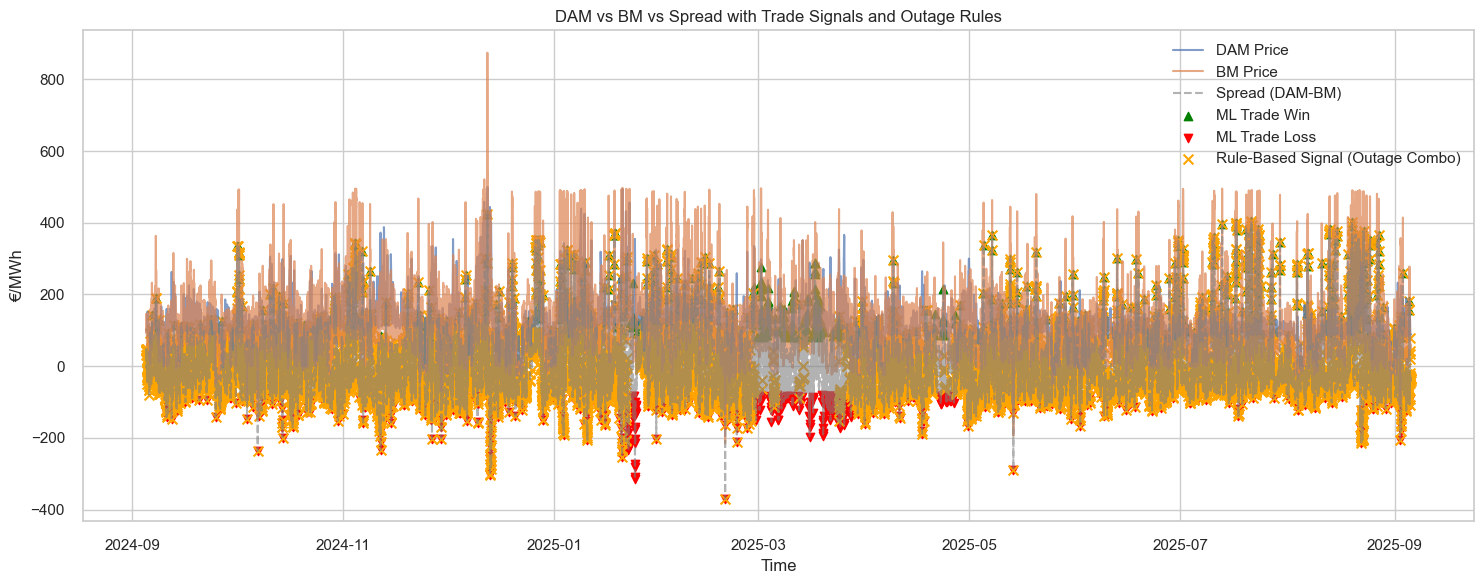


[SignalSource Summary]
SignalSource
Rule    12058
Both     3694
None     1328
ML        470
Name: count, dtype: int64


In [19]:
# ==================== SECTION 6.3 — Incorporating Rule-Based Outage Signals with RuleScore ====================
#
# Purpose:
# --------
# 1) Load the mined outage *combinations* (from 6.2B) and project them onto the full timeline
#    as boolean columns: RULE_ACTIVE__<combo>.
# 2) Build a master “AnyRuleActive” flag and a numeric “RuleScore” that sums the weights
#    of *all* active rules at each timestamp.
# 3) (Optional) Identify the “top” rules (by HitRate from 6.1A diagnostics) and create a
#    TopRuleActive flag.
# 4) Produce a simple rule-only backtest (1 MW, raw spread) and a combined visual showing
#    DAM/BM prices, spread, ML trade markers, and rule markers.
# 5) Label the source of each signal (ML / Rule / Both) for later analysis.
# ---------------------------------------------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------- Step 1: Load the filtered rule combinations from Section 6.2B ---------------------------------

# These rules are combinations of outage flags with strong positive impact on spread.
# Each row includes:
# - 'Combination': unit flags joined by " + "
# - 'RuleWeight' : weight for the rule = Difference × log(1 + observations)
rules_df = pd.read_csv("filtered_outage_rules.csv")

# For each rule combo, create a boolean column RULE_ACTIVE__<combo>
# A rule is "active" when all its constituent units are simultaneously OUT (value 1)
for combo in rules_df['Combination']:
    units = combo.split(" + ")                            # List of unit flag names (e.g., ['B31_OUT', 'Shellybanks_PBA_OUT'])
    rule_col = f"RULE_ACTIVE__{combo}"                    # Name of new column indicating rule activation
    combined_prices_df[rule_col] = (
        combined_prices_df[units].sum(axis=1) == len(units)  # Rule active if all units are OUT (sum equals length of combo)
    )

# --------------------------------- Step 2: Build master boolean flag if ANY rule is active ---------------------------------

# This flag is True when *at least one* rule is active at that timestamp
rule_cols = [f"RULE_ACTIVE__{combo}" for combo in rules_df['Combination']]
combined_prices_df['AnyRuleActive'] = combined_prices_df[rule_cols].any(axis=1)

# --------------------------------- Step 3: Create RuleScore by summing weights of active rules ---------------------------------

# Create a lookup dictionary: combo → rule weight
rule_weight_map = dict(zip(rules_df['Combination'], rules_df['RuleWeight']))

# Initialize RuleScore column to 0
combined_prices_df['RuleScore'] = 0.0

# For each rule, add its weight to RuleScore wherever that rule is active
for combo in rules_df['Combination']:
    col = f"RULE_ACTIVE__{combo}"                         # Boolean column for this rule
    weight = rule_weight_map[combo]                       # Retrieve corresponding weight
    combined_prices_df.loc[combined_prices_df[col], 'RuleScore'] += weight  # Add weight if rule is active

# --------------------------------- Step 4: Optionally mark top 10 high-HitRate rules from 6.1A ---------------------------------

# These top rules are used to track stronger historical performance
top_rules = rule_stats_df.sort_values(by='HitRate', ascending=False).head(10)['Rule'].tolist()
top_rule_cols = [f"RULE_ACTIVE__{rule}" for rule in top_rules]

# Create a convenience boolean flag: True if *any* of the top rules are active
combined_prices_df['TopRuleActive'] = combined_prices_df[top_rule_cols].any(axis=1)

# --------------------------------- Step 5: Simple diagnostic rule-only backtest ---------------------------------

# Create a filtered dataframe of all timestamps where any rule is active
rule_trade_df = combined_prices_df[combined_prices_df['AnyRuleActive']].copy()

# Define PnL as the raw DAM–BM spread at those timestamps (1 MW notional, no costs)
rule_trade_df['Rule_PnL'] = rule_trade_df['Spread_DAMtoBM']

# Output some summary statistics
print("\n[Rule-Based Backtest]")
print(f"Trades Triggered by Rules: {rule_trade_df.shape[0]}")
print(f"Total PnL from Rules: €{rule_trade_df['Rule_PnL'].sum():.2f}")
print(f"Average PnL per Rule-Based Trade: €{rule_trade_df['Rule_PnL'].mean():.2f}")

# --------------------------------- Step 6: Visual overlay of DAM, BM, spread, ML, and rule signals ------------------------------

fig, ax = plt.subplots(figsize=(15, 6))

# Plot DAM and BM prices
ax.plot(combined_prices_df['StartDateTime'], combined_prices_df['PriceDAM'],        label='DAM Price', alpha=0.7)
ax.plot(combined_prices_df['StartDateTime'], combined_prices_df['PriceImbalance'],  label='BM Price',  alpha=0.7)

# Overlay the realized DAM–BM spread as a dashed gray line
ax.plot(
    combined_prices_df['StartDateTime'], combined_prices_df['Spread_DAMtoBM'],
    label='Spread (DAM-BM)', linestyle='--', color='gray', alpha=0.6
)

# Extract ML trade markers (from ExecuteTrade_adj in Section 6.1B)
trades_executed = combined_prices_df[combined_prices_df['ExecuteTrade_adj']]
win_trades  = trades_executed[trades_executed['PnL_adj'] > 0]
lose_trades = trades_executed[trades_executed['PnL_adj'] <= 0]

# Green triangles for ML wins
ax.scatter(win_trades['StartDateTime'], win_trades['Spread_DAMtoBM'],
           color='green', marker='^', label='ML Trade Win')

# Red downward triangles for ML losses
ax.scatter(lose_trades['StartDateTime'], lose_trades['Spread_DAMtoBM'],
           color='red', marker='v', label='ML Trade Loss')

# Orange X markers for timestamps where *any* rule is active
rule_signals = combined_prices_df[combined_prices_df['AnyRuleActive']]
ax.scatter(rule_signals['StartDateTime'], rule_signals['Spread_DAMtoBM'],
           color='orange', marker='x', s=50, label='Rule-Based Signal (Outage Combo)')

# Optionally, add shading for major outages if this flag exists
if 'MajorOutage' in combined_prices_df.columns:
    major_outage_periods = combined_prices_df[combined_prices_df['MajorOutage']]
    for _, row in major_outage_periods.iterrows():
        ax.axvline(row['StartDateTime'], color='purple', alpha=0.02)  # light line for visibility

# Final chart styling
ax.set_title("DAM vs BM vs Spread with Trade Signals and Outage Rules")
ax.set_xlabel("Time")
ax.set_ylabel("€/MWh")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------------- Step 7: Label signal origin — ML, Rule, Both, or None ---------------------------------

# Start everyone as 'None'
combined_prices_df['SignalSource'] = 'None'

# Label rows where a rule fired
combined_prices_df.loc[combined_prices_df['AnyRuleActive'], 'SignalSource'] = 'Rule'

# Overwrite with 'ML' where ML trade was executed
combined_prices_df.loc[combined_prices_df['ExecuteTrade_adj'], 'SignalSource'] = 'ML'

# Overwrite with 'Both' where both rule and ML were active simultaneously
combined_prices_df.loc[
    (combined_prices_df['AnyRuleActive']) & (combined_prices_df['ExecuteTrade_adj']),
    'SignalSource'
] = 'Both'

# --------------------------------- Step 8: Output signal source breakdown and save diagnostics ------------------------------

# Count the number of timestamps under each signal source category
signal_counts = combined_prices_df['SignalSource'].value_counts()
print("\n[SignalSource Summary]")
print(signal_counts)

# Save the diagnostic performance summary of each rule from Section 6.1A
rule_stats_df.to_csv("rule_performance_summary.csv", index=False)

# ---------------------------------------------------------------------------------------------------------------
# Notes:
# - RuleScore combines the effect sizes of all rules that are active at a timestamp.
# - The rule-only backtest shown here uses full spread (directionless, no costs).
# ---------------------------------------------------------------------------------------------------------------



[6.4] KPIs (1 MW sizing, leak-guarded)
Ensemble  -> Trades: 2884, Total: €82958.18, Win: 52.53%, Sharpe: 0.12, Payoff: 2.12, Expect: €28.76
RulesOnly -> Trades: 1657, Total: €46126.82, Win: 51.36%, Sharpe: 0.08, Payoff: 2.10, Expect: €27.84
ML Only   -> Trades: 17411, Total: €28035.03, Win: 43.36%, Sharpe: 0.02, Payoff: 1.38, Expect: €1.61


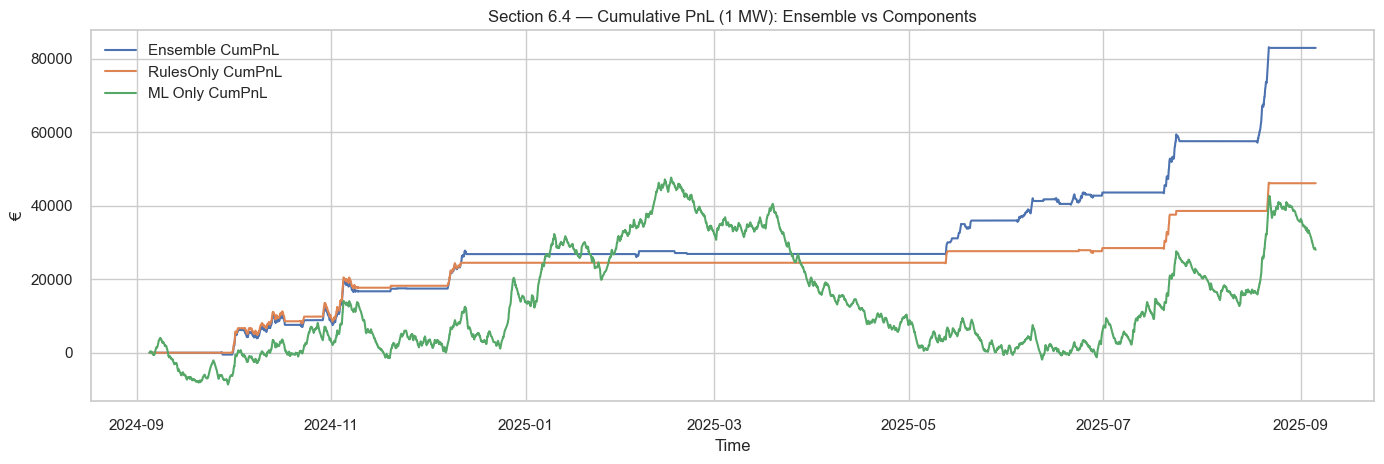

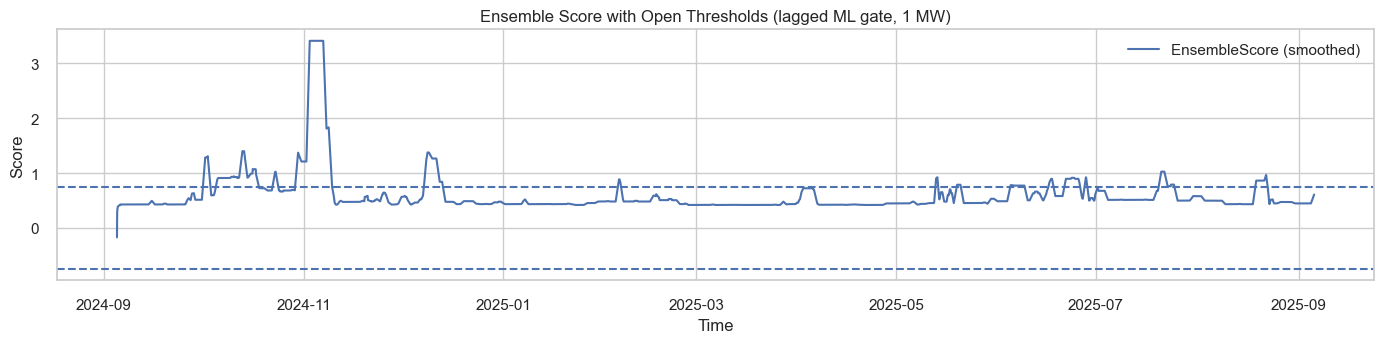


[6.4 Debug]
Share ML_Gate_exec True: 0.9999430199430199
Share |EnsembleScore| >= OPEN_TH among ML_Gate_exec: 0.16536554789446692
[6.4] Wrote ensemble_signals.csv (1 MW).


In [20]:
# ===================== SECTION 6.4 — ENSEMBLE TRADING (with plots, 1 MW, no costs) =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Tunables (weights/thresholds). Sizing is FIXED at 1 MW everywhere.
# ---------------------------------------------------------------------
W_RULES    = 0.40     # weight of the (normalized) rules score in the ensemble
W_ML       = 0.60     # weight of the (lagged) ML score in the ensemble
OPEN_TH    = 0.75     # threshold on |EnsembleScore| to open a trade
ML_OPEN_TH = 0.45     # magnitude gate for ML confidence (abs(ML_Score) >= ML_OPEN_TH)
COST_FILT  = 0.0      # optional absolute-spread filter in €, disabled because costs unknown
USE_LAG    = True     # execute at t using signals from t-1 (prevents lookahead)

# ---------------------------------------------------------------------
# Base columns & realized spread (for PnL ONLY; not used to build signals)
# ---------------------------------------------------------------------
assert 'StartDateTime' in combined_prices_df.columns, "[6.4] StartDateTime missing."

# If needed, build realized spread; this is used for PnL calculation only.
if 'Spread_DAMtoBM' not in combined_prices_df.columns:
    combined_prices_df['Spread_DAMtoBM'] = (
        combined_prices_df['PriceImbalance'] - combined_prices_df['PriceDAM']
    )
spread = combined_prices_df['Spread_DAMtoBM'].astype(float)

# =========================================
# 1) RULE COMPONENT — RuleScoreZ and RuleDir
# =========================================
# Load mined rules from 6.2B. If the file is missing, neutralize the rules leg.
try:
    rules_df = pd.read_csv("filtered_outage_rules.csv")
except FileNotFoundError:
    rules_df = pd.DataFrame(columns=['Combination', 'Difference', 'RuleWeight'])

# Keep only rules whose unit columns exist in the dataframe.
available_cols = set(combined_prices_df.columns)
usable = []
for _, r in rules_df.iterrows():
    combo = r['Combination']
    units = [u.strip() for u in combo.split(" + ")]
    if all(u in available_cols for u in units):
        usable.append((combo, units, float(r['Difference']), float(r['RuleWeight'])))

# Build a raw, signed rule score by summing active rule weights:
# +weight if the rule's historical Difference > 0, else -weight (penalize negative combos).
if not usable:
    combined_prices_df['RuleScoreRaw'] = 0.0
else:
    rs = np.zeros(len(combined_prices_df), dtype=float)
    for combo, units, diff, weight in usable:
        # Ensure a boolean activity column exists for the rule (active if all units are out)
        col = f"RULE_ACTIVE__{combo}"
        if col not in combined_prices_df.columns:
            combined_prices_df[col] = (combined_prices_df[units].sum(axis=1) == len(units))
        # Signed contribution: positive-impact rules push score up; negative-impact push down
        sign = 1.0 if diff > 0 else -1.0
        rs += sign * weight * combined_prices_df[col].astype(float).to_numpy()
    combined_prices_df['RuleScoreRaw'] = rs

# Normalize RuleScoreRaw to RuleScoreZ for scale comparability, and derive a rule direction.
rs = combined_prices_df['RuleScoreRaw'].astype(float)
denom = rs.std(ddof=0)
denom = denom if np.isfinite(denom) and denom > 1e-12 else 1.0  # guard tiny/zero stdev
combined_prices_df['RuleScoreZ'] = (rs - rs.mean()) / denom
combined_prices_df['RuleDir']    = np.sign(combined_prices_df['RuleScoreZ']).astype(int)

# ====================================================
# 2) ML COMPONENT — lagged, magnitude gated, no lookahead
# ====================================================
# Require the ex-ante ML prediction (from Section 5D). This must NOT be realized spread.
assert 'ML_PredictedSpread' in combined_prices_df.columns, \
    "[6.4] ML_PredictedSpread missing (expected from 5D)."

# Pull ML predictions as floats.
s = combined_prices_df['ML_PredictedSpread'].astype(float)

# Scale ML predictions to a confidence-like score in [-1, 1]:
# Use the 0.80 quantile of |prediction| for robustness (0.90 was too brittle for flat series).
scale = s.abs().quantile(0.80)
if not np.isfinite(scale) or scale < 1e-6:
    scale = 50.0  # hard fallback if series is near-constant

# ML_Score ~ confidence/probability proxy; ML_Dir ~ sign of predicted spread.
combined_prices_df['ML_Score'] = (s / scale).clip(-1, 1)
combined_prices_df['ML_Dir']   = np.sign(s).astype(int)

# Clean magnitude-based ML gate (no use of realized values); opens when |ML_Score| >= ML_OPEN_TH.
ml_gate_clean = (combined_prices_df['ML_Score'].abs() >= ML_OPEN_TH)

# Enforce ex ante timing: shift ML signals by one period so we always trade on **last** period's info.
if USE_LAG:
    combined_prices_df['ML_Score_exec'] = combined_prices_df['ML_Score'].shift(1)
    combined_prices_df['ML_Dir_exec']   = combined_prices_df['ML_Dir'].shift(1).fillna(0).astype(int)
    combined_prices_df['ML_Gate_exec']  = ml_gate_clean.shift(1).fillna(False)
else:
    combined_prices_df['ML_Score_exec'] = combined_prices_df['ML_Score']
    combined_prices_df['ML_Dir_exec']   = combined_prices_df['ML_Dir']
    combined_prices_df['ML_Gate_exec']  = ml_gate_clean

# Coverage guard: if the lag kills the gate (<2% on), relax gate slightly to 0.40 (once).
coverage = float(combined_prices_df['ML_Gate_exec'].mean())
if coverage < 0.02:
    ml_gate_soft = (combined_prices_df['ML_Score'].abs() >= 0.40)
    combined_prices_df['ML_Gate_exec'] = (ml_gate_soft.shift(1).fillna(False) if USE_LAG else ml_gate_soft)

# =========================================
# 3) ENSEMBLE SCORE / OPEN FLAGS (1 MW sizing)
# =========================================
# Combine lagged ML score and normalized rules score with weights to form the ensemble score.
ml_score_for_ens = combined_prices_df['ML_Score_exec'].fillna(0)
combined_prices_df['EnsembleScore'] = W_ML*ml_score_for_ens + W_RULES*combined_prices_df['RuleScoreZ']
combined_prices_df['EnsembleDir']   = np.sign(combined_prices_df['EnsembleScore']).astype(int)

# Open an ensemble trade only when:
#   (a) |EnsembleScore| is strong enough, AND
#   (b) the lagged ML gate is open (rules cannot trade solo in the ensemble path).
combined_prices_df['OpenEnsemble'] = (
    (combined_prices_df['EnsembleScore'].abs() >= OPEN_TH) &
    (combined_prices_df['ML_Gate_exec'])
)

# Optional: filter out tiny realized spreads if you had a known cost; disabled here.
if COST_FILT > 0:
    combined_prices_df['OpenEnsemble'] &= (spread.abs() >= COST_FILT)

# Diagnostic-only open flags for components (not used to size in ensemble)
combined_prices_df['OpenRulesOnly'] = (combined_prices_df['RuleScoreZ'].abs() >= OPEN_TH)  # rules-only diagnostic
combined_prices_df['OpenMLOnly']    = combined_prices_df['ML_Gate_exec']                   # ML-only diagnostic

# =========================================
# 4) PnL (ALL AT 1 MW)
# =========================================
# PnL is simply Direction * RealizedSpread when open; otherwise 0. (No costs, 1 MW fixed size.)
combined_prices_df['Ensemble_PnL']  = np.where(combined_prices_df['OpenEnsemble'],
                                               combined_prices_df['EnsembleDir'] * spread, 0.0)
combined_prices_df['RulesOnly_PnL'] = np.where(combined_prices_df['OpenRulesOnly'],
                                               combined_prices_df['RuleDir'] * spread, 0.0)
combined_prices_df['MLOnly_PnL']    = np.where(combined_prices_df['OpenMLOnly'],
                                               combined_prices_df['ML_Dir_exec'] * spread, 0.0)

# =========================================
# 5) KPIs
# =========================================
def _kpis(pnl):
    """Compute basic KPIs for a PnL series at 1 MW: trades, total, win%, sharpe, payoff, expectancy."""
    s = pnl.dropna()
    trades = int((s != 0).sum())
    total  = float(s.sum())
    wins   = s[s > 0]; losses = s[s < 0]
    win_rate  = (len(wins)/trades) if trades else np.nan
    sharpe    = (s.mean()/s.std()) if np.isfinite(s.std()) and s.std() > 0 else np.nan
    payoff    = (wins.mean()/abs(losses.mean())) if len(losses) else np.nan
    expectancy= (win_rate*wins.mean() - (1-win_rate)*abs(losses.mean())) if len(losses) else np.nan
    return dict(trades=trades,total=total,win_rate=win_rate,sharpe=sharpe,payoff=payoff,expectancy=expectancy)

kpi_ens  = _kpis(combined_prices_df['Ensemble_PnL'])
kpi_rule = _kpis(combined_prices_df['RulesOnly_PnL'])
kpi_ml   = _kpis(combined_prices_df['MLOnly_PnL'])

print("\n[6.4] KPIs (1 MW sizing, leak-guarded)")
print(f"Ensemble  -> Trades: {kpi_ens['trades']}, Total: €{kpi_ens['total']:.2f}, "
      f"Win: {kpi_ens['win_rate']*100 if pd.notna(kpi_ens['win_rate']) else 0:.2f}%, "
      f"Sharpe: {kpi_ens['sharpe']:.2f}, Payoff: {kpi_ens['payoff']:.2f}, Expect: €{kpi_ens['expectancy']:.2f}")
print(f"RulesOnly -> Trades: {kpi_rule['trades']}, Total: €{kpi_rule['total']:.2f}, "
      f"Win: {kpi_rule['win_rate']*100 if pd.notna(kpi_rule['win_rate']) else 0:.2f}%, "
      f"Sharpe: {kpi_rule['sharpe']:.2f}, Payoff: {kpi_rule['payoff']:.2f}, Expect: €{kpi_rule['expectancy']:.2f}")
print(f"ML Only   -> Trades: {kpi_ml['trades']}, Total: €{kpi_ml['total']:.2f}, "
      f"Win: {kpi_ml['win_rate']*100 if pd.notna(kpi_ml['win_rate']) else 0:.2f}%, "
      f"Sharpe: {kpi_ml['sharpe']:.2f}, Payoff: {kpi_ml['payoff']:.2f}, Expect: €{kpi_ml['expectancy']:.2f}")

# =========================================
# 6) Plots (matplotlib only; one chart per figure; no custom colors)
# =========================================

# A) Equity curves — cumulative PnL per timestamp for ensemble and components
eq_df = (combined_prices_df[['StartDateTime','Ensemble_PnL','RulesOnly_PnL','MLOnly_PnL']]
         .dropna(subset=['StartDateTime']).copy())
eq_df['StartDateTime'] = pd.to_datetime(eq_df['StartDateTime'])
per_ts = (eq_df.sort_values('StartDateTime')
              .groupby('StartDateTime')[['Ensemble_PnL','RulesOnly_PnL','MLOnly_PnL']].sum())
equity = per_ts.cumsum()

plt.figure(figsize=(14, 4.8))
plt.plot(equity.index, equity['Ensemble_PnL'], label='Ensemble CumPnL')
plt.plot(equity.index, equity['RulesOnly_PnL'], label='RulesOnly CumPnL')
plt.plot(equity.index, equity['MLOnly_PnL'], label='ML Only CumPnL')
plt.title("Section 6.4 — Cumulative PnL (1 MW): Ensemble vs Components")
plt.xlabel("Time"); plt.ylabel("€"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# B) Ensemble score (smoothed) with open thresholds (helps visualize regime intensity vs triggers)
sc_df = combined_prices_df[['StartDateTime','EnsembleScore']].dropna().copy()
sc_df['StartDateTime'] = pd.to_datetime(sc_df['StartDateTime'])
sc_df = sc_df.sort_values('StartDateTime').set_index('StartDateTime')
sc_df['ScoreSmooth'] = sc_df['EnsembleScore'].rolling(window=48, min_periods=1).mean()  # ~one day if 30-min bars

plt.figure(figsize=(14, 3.6))
plt.plot(sc_df.index, sc_df['ScoreSmooth'], label='EnsembleScore (smoothed)')
plt.axhline(OPEN_TH, linestyle='--'); plt.axhline(-OPEN_TH, linestyle='--')
plt.title("Ensemble Score with Open Thresholds (lagged ML gate, 1 MW)")
plt.xlabel("Time"); plt.ylabel("Score"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# =========================================
# 7) Quick debug prints (sanity)
# =========================================
print("\n[6.4 Debug]")
print("Share ML_Gate_exec True:", float(combined_prices_df['ML_Gate_exec'].mean()))
print("Share |EnsembleScore| >= OPEN_TH among ML_Gate_exec:",
      float((combined_prices_df.loc[combined_prices_df['ML_Gate_exec'], 'EnsembleScore']
             .abs() >= OPEN_TH).mean()))

# =========================================
# 8) Export (signals + PnL columns)
# =========================================
out_cols = [
    'StartDateTime','PriceDAM','PriceImbalance','Spread_DAMtoBM',
    'RuleScoreRaw','RuleScoreZ','RuleDir',
    'ML_Score','ML_Dir','ML_Gate_exec',
    'EnsembleScore','EnsembleDir','OpenEnsemble','OpenMLOnly','OpenRulesOnly',
    'Ensemble_PnL','RulesOnly_PnL','MLOnly_PnL'
]
combined_prices_df.loc[:, [c for c in out_cols if c in combined_prices_df.columns]].to_csv(
    "ensemble_signals.csv", index=False
)
print("[6.4] Wrote ensemble_signals.csv (1 MW).")


[6.5] Created compatibility aliases: {'RuleOnly_Open': 'OpenRulesOnly', 'RuleOnly_PnL_1MW': 'RulesOnly_PnL', 'MLOnly_Open': 'OpenMLOnly', 'MLOnly_PnL_1MW': 'MLOnly_PnL', 'Ensemble_PnL_1MW': 'Ensemble_PnL', 'MLOnly_Dir': 'ML_Dir_exec', 'RuleOnly_Dir': 'RuleDir'}

[6.5] Top 15 Outage Combos by Realized Rule-Only PnL (1 MW):
                                                                                                   Rule    TotalPnL  TradeCount    AvgPnL  HitRate
                              Moneypoint_1_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT 1992.650791         216  9.225235 0.643519
                                  Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT 1517.108333          58 26.157040 0.948276
Moneypoint_1_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT 1517.108333          58 26.157040 0.948276
                                          Moneypoint_1_Generator_Unit_OUT + Aghada_2_Gen

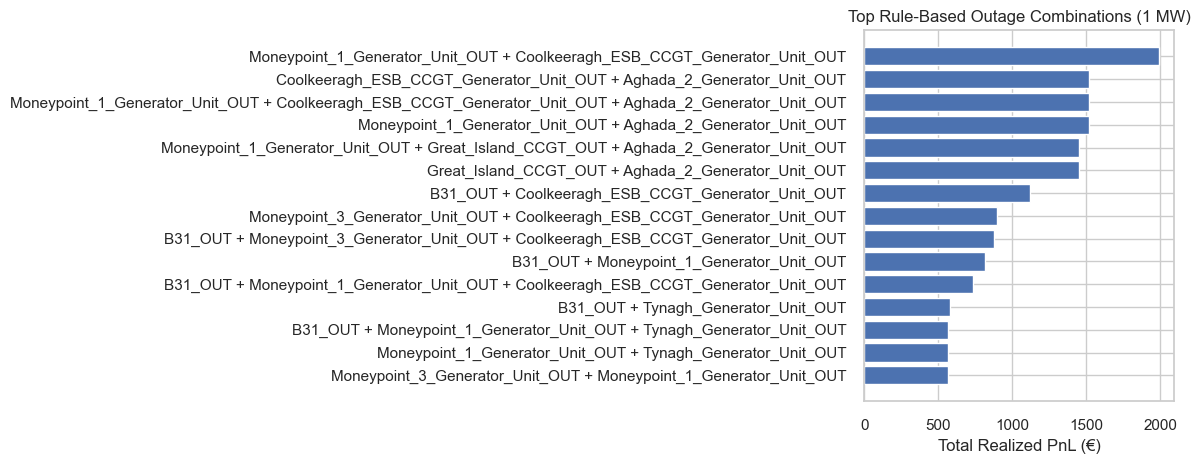


[6.5] Unit-Level Attribution (Top 15 by PnL Share):
                                         TotalPnL  TradeCount  AvgPnLPerTrade
Unit                                                                         
Coolkeeragh_ESB_CCGT_Generator_Unit_OUT   7222.46     5068.83            1.42
B31_OUT                                   5965.41     9781.50            0.61
Moneypoint_1_Generator_Unit_OUT           5871.71     2123.25            2.77
Moneypoint_3_Generator_Unit_OUT           5359.95    12779.00            0.42
Shellybanks_PBA_OUT                       4303.74    15395.08            0.28
Aghada_2_Generator_Unit_OUT               3543.45      583.83            6.07
Shellybanks_PBB_OUT                       2729.48    11753.08            0.23
Moneypoint_2_Generator_Unit_OUT           2621.76     6104.50            0.43
GT6_OUT                                   2492.41    11614.08            0.21
Tynagh_Generator_Unit_OUT                 2149.65      443.42            4.85
Great_Islan

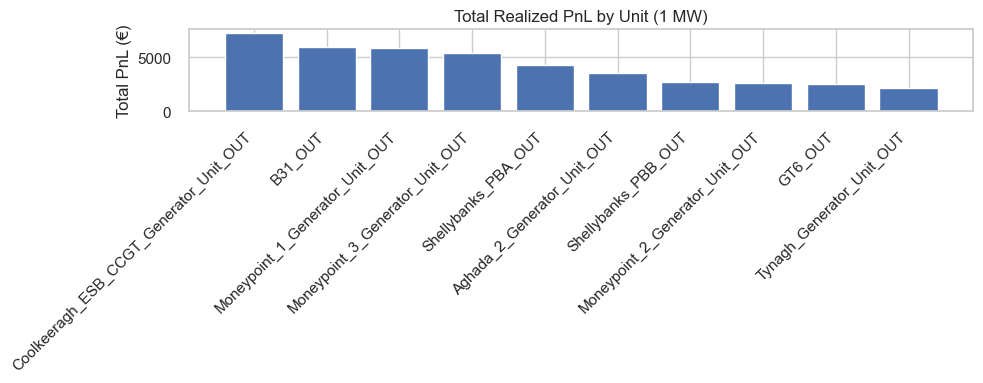

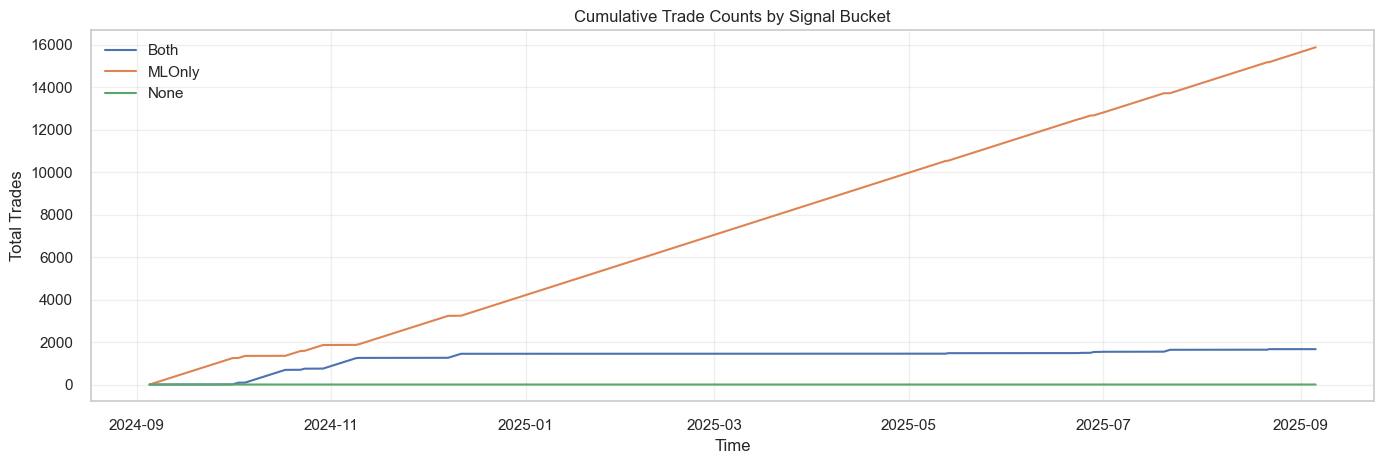


[6.5] Avg Ensemble PnL (€) by Day of Week and Signal Bucket:
SignalBucket   Both  MLOnly  None
DayOfWeek                        
Monday        50.06    0.98   0.0
Tuesday       31.55    4.45   0.0
Wednesday     14.74    7.08   0.0
Thursday       9.36    1.17   0.0
Friday         2.52    0.32   0.0
Saturday      22.84    2.44   0.0
Sunday        49.06    0.05   0.0


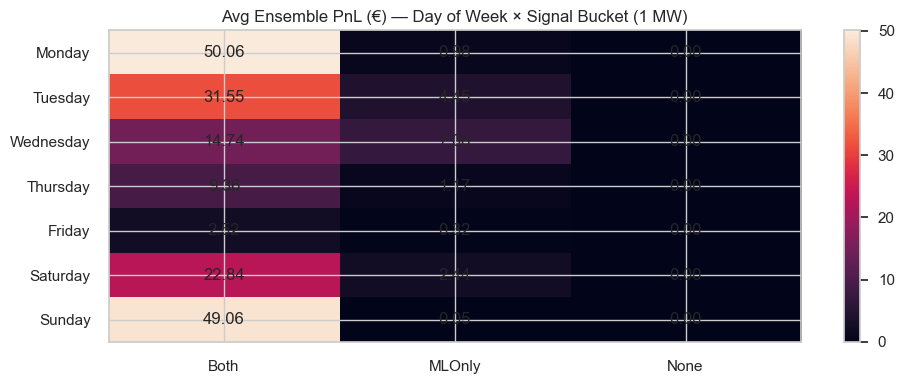

In [21]:
# ==================== SECTION 6.5 — Attribution & Drilldown (1 MW, leak-guarded) ====================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# Purpose
#   - Attribute realized PnL (1 MW) back to outage *rules* and then to *units*.
#   - Show signal mix (RuleOnly / MLOnly / Both / None) over time.
#   - Provide a DOW (day-of-week) view of average ensemble PnL.
# Assumptions
#   - Section 6.4 already produced: OpenRulesOnly, RulesOnly_PnL, OpenMLOnly, MLOnly_PnL, Ensemble_PnL.
#   - Rule active flags (RULE_ACTIVE__<combo>) exist (from 6.3/6.4); if not, we rebuild them here.
#   - All PnL is already sized at 1 MW and contains no transaction costs.
# ------------------------------------------------------------------------------

# --- 0) Compatibility layer: map legacy names used below to the columns we emitted in 6.4.
#     This lets the analysis run whether columns are named "OpenRulesOnly" (new)
#     or "RuleOnly_Open" (old). If a destination name is missing but the source
#     exists, we copy it so the rest of this section can rely on a stable schema.
alias_pairs = [
    ("RuleOnly_Open",     "OpenRulesOnly"),   # whether rules-only strategy is 'open' at t
    ("RuleOnly_PnL_1MW",  "RulesOnly_PnL"),   # realized rules-only PnL at 1 MW
    ("MLOnly_Open",       "OpenMLOnly"),
    ("MLOnly_PnL_1MW",    "MLOnly_PnL"),
    ("Ensemble_PnL_1MW",  "Ensemble_PnL"),    # realized ensemble PnL at 1 MW
]

# Prefer the *executed* (lagged) ML direction if available; otherwise fall back to raw ML sign.
ml_dir_src = "ML_Dir_exec" if "ML_Dir_exec" in combined_prices_df.columns else (
             "ML_Dir" if "ML_Dir" in combined_prices_df.columns else None)
if ml_dir_src is not None:
    alias_pairs.append(("MLOnly_Dir", ml_dir_src))

# If RuleDir wasn’t stored in 6.4, derive it from the sign of RuleScoreZ (same convention as 6.4).
if "RuleDir" not in combined_prices_df.columns and "RuleScoreZ" in combined_prices_df.columns:
    combined_prices_df["RuleDir"] = np.sign(combined_prices_df["RuleScoreZ"]).astype(int)
# And expose that as the legacy-friendly "RuleOnly_Dir".
alias_pairs.append(("RuleOnly_Dir", "RuleDir"))

def _ensure_alias(dst, src, df):
    """Create df[dst] = df[src] if dst missing and src present; return True if created."""
    if dst not in df.columns and src in df.columns:
        df[dst] = df[src]
        return True
    return False

# Apply all alias mappings; print which ones we created so the log is transparent.
made = {d: s for (d, s) in alias_pairs if _ensure_alias(d, s, combined_prices_df)}
if made:
    print("[6.5] Created compatibility aliases:", made)

# --- 1) Minimal required columns after aliasing.
#     If any are still missing at this point, earlier sections didn’t populate them.
REQ = [
    'StartDateTime', 'Spread_DAMtoBM', 'RuleScoreZ',
    'RuleOnly_Open', 'RuleOnly_Dir', 'RuleOnly_PnL_1MW',
    'MLOnly_Open',   'MLOnly_Dir',   'MLOnly_PnL_1MW',
    'Ensemble_PnL_1MW'
]
missing = [c for c in REQ if c not in combined_prices_df.columns]
if missing:
    raise KeyError(f"[6.5] Missing inputs after 6.4: {missing}")

# --- 2) Load rules table and derive a sign per rule.
#     'Difference' (>0 means the combo tends to increase the spread) gives the long/short sign we attribute with.
rules_df = pd.read_csv("filtered_outage_rules.csv", usecols=['Combination','Difference'])
rules_df['Sign'] = np.where(rules_df['Difference'] > 0, 1.0, -1.0)

# Ensure we have an activity flag column for every rule combo:
# RULE_ACTIVE__<combo> is True at t iff *all* units in the combo are out at t.
active_cols = []
for combo in rules_df['Combination']:
    col = f"RULE_ACTIVE__{combo}"
    if col not in combined_prices_df.columns:
        units = [u.strip() for u in combo.split(" + ")]
        # Only rebuild if *all* constituent unit flags exist in the dataframe.
        if all(u in combined_prices_df.columns for u in units):
            combined_prices_df[col] = (combined_prices_df[units].sum(axis=1) == len(units))
        else:
            # Skip combos that reference missing unit columns (keeps execution robust).
            continue
    active_cols.append(col)

# ================= 3) Rule-level realized PnL (only when Rule strategy is OPEN) =================
# Method:
#   - At each timestamp where the rules-only strategy is open, split the realized spread evenly
#     across all *active* rules, then multiply by that rule’s sign to get its contribution.
rule_stats = pd.DataFrame(columns=['Rule','TotalPnL','TradeCount','AvgPnL','HitRate'])

if active_cols:
    # Minimal working frame with timestamp, realized spread, the open-flag, and all rule activity flags.
    w = combined_prices_df[['StartDateTime','Spread_DAMtoBM','RuleOnly_Open'] + active_cols].copy()
    w['StartDateTime'] = pd.to_datetime(w['StartDateTime'])
    w.sort_values('StartDateTime', inplace=True)

    # Number of active rules at each timestamp.
    w['NumActive'] = w[active_cols].sum(axis=1).astype(int)

    # Base € contribution per *active* rule at an instant:
    #   - take realized spread / (# active rules) when rules-only is open
    #   - otherwise 0
    denom = w['NumActive'].where(w['NumActive'] > 0, other=1).astype(float)  # avoid /0
    base  = (w['Spread_DAMtoBM'] / denom).where(w['RuleOnly_Open'] & (w['NumActive'] > 0), other=0.0)

    # Build a per-rule contribution series for each combo, signed by the rule’s historical effect.
    contrib   = {}
    col_list  = []
    sign_map  = dict(zip(rules_df['Combination'], rules_df['Sign']))

    for combo in rules_df['Combination']:
        col = f"RULE_ACTIVE__{combo}"
        if col in w.columns:
            col_list.append(combo)
            contrib[combo] = base.where(w[col], other=0.0) * float(sign_map.get(combo, 0.0))

    # Assemble into a DataFrame aligned to time.
    contrib_df = pd.DataFrame(contrib, index=w.index, columns=col_list) if contrib else pd.DataFrame()

    if not contrib_df.empty:
        # Aggregate across time → per-rule totals, counts, and wins.
        total  = contrib_df.sum(axis=0)             # € contribution per rule
        trades = (contrib_df != 0).sum(axis=0)      # # timestamps where rule contributed
        hits   = (contrib_df > 0).sum(axis=0)       # # positive contributions

        # Package as a tidy table with averages and hit-rates.
        rule_stats = pd.DataFrame({
            'Rule':       col_list,
            'TotalPnL':   total.to_numpy(),
            'TradeCount': trades.to_numpy()
        })
        nz = rule_stats['TradeCount'].replace(0, np.nan).to_numpy()
        rule_stats['AvgPnL']  = (rule_stats['TotalPnL'].to_numpy() / nz)
        rule_stats['HitRate'] = (hits.to_numpy() / nz)
        rule_stats = rule_stats.sort_values('TotalPnL', ascending=False).reset_index(drop=True)

print("\n[6.5] Top 15 Outage Combos by Realized Rule-Only PnL (1 MW):")
print(rule_stats.head(15).to_string(index=False))

# Plot the best-performing rules by realized PnL contribution.
if not rule_stats.empty:
    top_rules = rule_stats.head(15)
    plt.figure(figsize=(12, 4.8))
    plt.barh(top_rules['Rule'], top_rules['TotalPnL'])
    plt.xlabel("Total Realized PnL (€)")
    plt.title("Top Rule-Based Outage Combinations (1 MW)")
    plt.gca().invert_yaxis()  # highest at the top
    plt.tight_layout()
    plt.show()

# ================= 4) Unit-level attribution (split each rule’s PnL evenly across its units) =====
# The simplest fair split: if rule A+B earns X€, credit X/2 to A and X/2 to B.
if not rule_stats.empty:
    rows = []
    for _, r in rule_stats.iterrows():
        units = [u.strip() for u in r['Rule'].split(" + ")]
        if not units:
            continue
        share_pnl    = r['TotalPnL']   / len(units)
        share_trades = r['TradeCount'] / len(units)
        for u in units:
            rows.append({'Unit': u, 'PnLShare': share_pnl, 'TradeShare': share_trades})

    unit_df  = pd.DataFrame(rows)
    unit_sum = (unit_df.groupby('Unit', as_index=True)
                .agg(TotalPnL=('PnLShare','sum'),
                     TradeCount=('TradeShare','sum'))
                .sort_values('TotalPnL', ascending=False))
    unit_sum['AvgPnLPerTrade'] = unit_sum['TotalPnL'] / unit_sum['TradeCount'].replace(0, np.nan)

    print("\n[6.5] Unit-Level Attribution (Top 15 by PnL Share):")
    print(unit_sum.head(15).round(2).to_string())

    # Plot top individual units by their attributed PnL.
    plt.figure(figsize=(10, 4))
    top_units = unit_sum.head(10)
    plt.bar(top_units.index, top_units['TotalPnL'])
    plt.ylabel("Total PnL (€)")
    plt.title("Total Realized PnL by Unit (1 MW)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ================= 5) Signal mix over time (RuleOnly / MLOnly / Both / None) =====================
# Classify each timestamp into a bucket depending on which legs are open.
df = combined_prices_df[['StartDateTime','RuleOnly_Open','MLOnly_Open']].copy()
df['StartDateTime'] = pd.to_datetime(df['StartDateTime'])
df.sort_values('StartDateTime', inplace=True)

def _bucket(row):
    r, m = bool(row['RuleOnly_Open']), bool(row['MLOnly_Open'])
    return 'Both' if (r and m) else ('RuleOnly' if r else ('MLOnly' if m else 'None'))

df['SignalBucket'] = df.apply(_bucket, axis=1)

# Compute cumulative counts by bucket through time to see mix / activity drift.
counts = df.groupby(['StartDateTime','SignalBucket']).size().unstack(fill_value=0).cumsum()

plt.figure(figsize=(14, 4.8))
for c in counts.columns:
    plt.plot(counts.index, counts[c], label=c)
plt.title("Cumulative Trade Counts by Signal Bucket")
plt.ylabel("Total Trades")
plt.xlabel("Time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ================= 6) Day-of-week table for Ensemble PnL (mean, 1 MW) ===========================
# Average ensemble PnL by weekday × signal bucket to spot seasonal patterns.
d2 = combined_prices_df[['StartDateTime','Ensemble_PnL_1MW','RuleOnly_Open','MLOnly_Open']].copy()
d2['StartDateTime'] = pd.to_datetime(d2['StartDateTime'])
d2['DayOfWeek']    = d2['StartDateTime'].dt.day_name()
d2['SignalBucket'] = np.where(d2['RuleOnly_Open'] & d2['MLOnly_Open'], 'Both',
                       np.where(d2['RuleOnly_Open'], 'RuleOnly',
                       np.where(d2['MLOnly_Open'], 'MLOnly', 'None')))

dow = (d2.pivot_table(index='DayOfWeek', columns='SignalBucket',
                      values='Ensemble_PnL_1MW', aggfunc='mean')
         .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
         .fillna(0.0)).round(2)

print("\n[6.5] Avg Ensemble PnL (€) by Day of Week and Signal Bucket:")
print(dow.to_string())

# Simple matplotlib heatmap for quick visual inspection of that table.
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(dow.values, aspect='auto')
ax.set_xticks(range(len(dow.columns)), labels=list(dow.columns))
ax.set_yticks(range(len(dow.index)),  labels=list(dow.index))
ax.set_title("Avg Ensemble PnL (€) — Day of Week × Signal Bucket (1 MW)")
for i in range(dow.shape[0]):
    for j in range(dow.shape[1]):
        ax.text(j, i, f"{dow.values[i, j]:.2f}", ha='center', va='center')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()



[6.6] Top parameter sets (sorted by Sharpe, then Total PnL):
 trades    total  win_rate   sharpe   payoff  expectancy  W_ML  W_RULES  OPEN_TH  ML_OPEN_TH  open_share
   2917 86075.33  0.528282 0.120139 2.134284   29.508169   0.4      0.6     0.60        0.35    0.167236
   2917 86075.33  0.528282 0.120139 2.134284   29.508169   0.4      0.6     0.60        0.45    0.167236
   2917 86075.33  0.528282 0.120139 2.134284   29.508169   0.4      0.6     0.60        0.55    0.167236
   2884 82958.18  0.525312 0.116950 2.119032   28.764972   0.6      0.4     0.75        0.35    0.165356
   2884 82958.18  0.525312 0.116950 2.119032   28.764972   0.6      0.4     0.75        0.45    0.165356
   2884 82958.18  0.525312 0.116950 2.119032   28.764972   0.6      0.4     0.75        0.55    0.165356
   3627 86481.77  0.515578 0.114818 1.934395   23.843885   0.5      0.5     0.60        0.35    0.208604
   3627 86481.77  0.515578 0.114818 1.934395   23.843885   0.5      0.5     0.60        0.45    0.

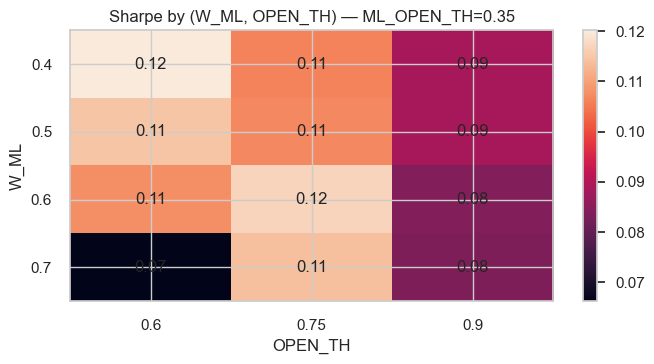

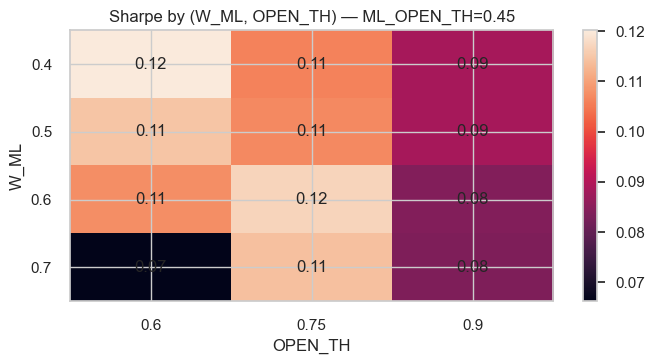

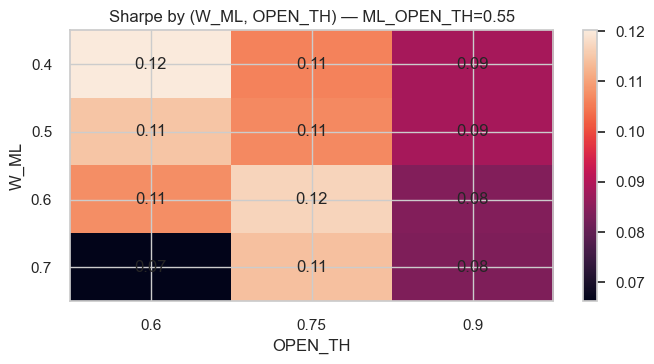

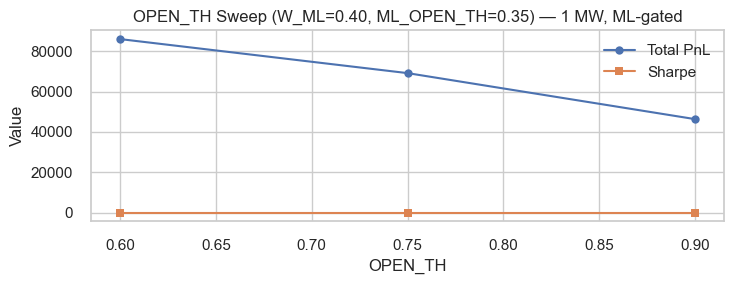

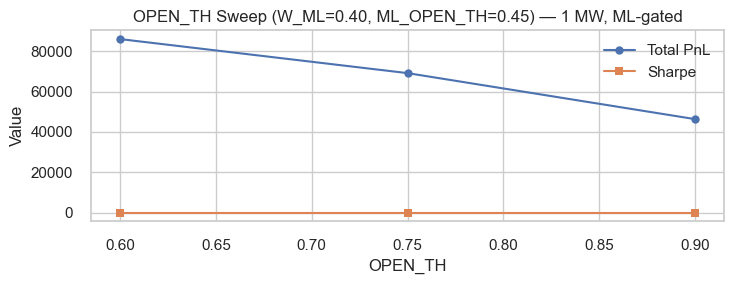

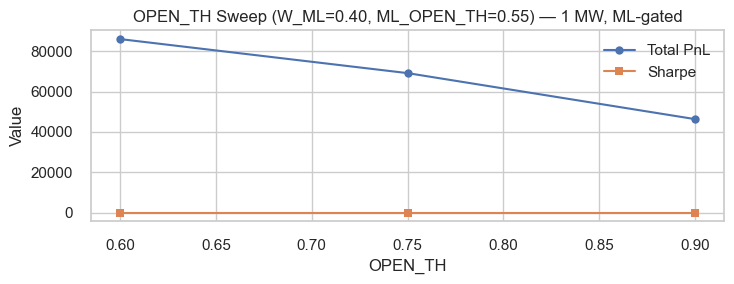

In [22]:
# ===================== SECTION 6.6 — Robustness Grid (W_ML × OPEN_TH × ML_OPEN_TH) =====================
#
# Goal
# ----
# Stress–test the ensemble against *three* knobs:
#   1) W_ML         -> weight on the ML score inside the EnsembleScore (rules get 1 - W_ML)
#   2) OPEN_TH      -> |EnsembleScore| threshold to open a trade (1 MW sizing)
#   3) ML_OPEN_TH   -> |ML_Score| threshold for the **ML gate** (post-lag, ex-ante)
#
# Notes
# -----
# - Strictly 1 MW sizing; no transaction costs.
# - Uses the SAME scaling and lag logic as 6.4 (0.80 abs-quantile scaling; 1-step lag).
# - Rules leg is taken from RuleScoreZ already computed in 6.3/6.4.
# - Produces KPIs per (W_ML, OPEN_TH, ML_OPEN_TH) and a few simple matplotlib plots.
#
# Outputs
# -------
# - Printed top parameter sets (sorted by Sharpe, then Total PnL).
# - CSV: ensemble_grid3_kpis.csv
# - Plots:
#     • One Sharpe heatmap per ML_OPEN_TH (W_ML × OPEN_TH)
#     • Threshold sweep line chart (OPEN_TH on x) at the best W_ML for each ML_OPEN_TH

import numpy as np                     # numerical ops (arrays, NaNs, quantiles used via pandas)
import pandas as pd                    # dataframe manipulation
import matplotlib.pyplot as plt        # plotting (matplotlib only per project rules)

# ------------------------------- Sanity checks / inputs --------------------------------
req_cols = ['StartDateTime', 'Spread_DAMtoBM', 'RuleScoreZ', 'ML_PredictedSpread']  # columns required from prior sections
missing = [c for c in req_cols if c not in combined_prices_df.columns]              # check which are absent
if missing:                                                                         # fail fast if any prerequisite is missing
    raise KeyError(f"[6.6] Missing required inputs from earlier sections: {missing}")

# Use a copy to avoid mutating the master frame while sweeping parameters.
gdf = combined_prices_df.copy()                      # keep master data clean while we iterate

# Ensure datetime sorting (helps groupby & plotting)
gdf['StartDateTime'] = pd.to_datetime(gdf['StartDateTime'])  # normalize datetime dtype
gdf = gdf.sort_values('StartDateTime').reset_index(drop=True)  # chronological order for stable plots/results

# -------------------------------- ML score & lag (shared) -------------------------------
# 1) Build the *prediction-based* ML score (same as 6.4 but done ONCE here).
s = gdf['ML_PredictedSpread'].astype(float)         # ex-ante model predictions (continuous € spread)

# Robust scale on the 0.80 abs-quantile (less brittle than medians when preds are low-variance).
scale = s.abs().quantile(0.80)                      # scale factor for mapping predictions to [-1, 1]
if not np.isfinite(scale) or scale < 1e-6:          # guard against degenerate/constant predictions
    scale = 50.0                                    # hard fallback to avoid divide-by-near-zero

gdf['ML_Score_base'] = (s / scale).clip(-1, 1)      # normalized confidence-like score in [-1, 1]
gdf['ML_Dir_base']   = np.sign(s).astype(int)       # directional signal {-1, 0, +1} from the prediction sign

# 2) Enforce one-step lag (signals at t-1 used to trade at t) to prevent lookahead.
USE_LAG = True                                      # matches Section 6.4
if USE_LAG:
    gdf['ML_Score_exec_base'] = gdf['ML_Score_base'].shift(1)          # use yesterday's score to trade today
    gdf['ML_Dir_exec_base']   = gdf['ML_Dir_base'].shift(1).fillna(0).astype(int)  # lagged direction; fill initial NA with 0
else:
    gdf['ML_Score_exec_base'] = gdf['ML_Score_base']                   # no lag path (not used here)
    gdf['ML_Dir_exec_base']   = gdf['ML_Dir_base']

# -------------------------------- Helper: KPI calculator --------------------------------
def _kpis_from_pnl(series: pd.Series) -> dict:
    """Compute trade KPIs from a PnL time series where non-zero rows indicate trades (1 MW)."""
    s = series.dropna()                                            # ignore NA rows (no trades there anyway)
    trades = int((s != 0).sum())                                   # count how many timestamps we traded
    total  = float(s.sum())                                        # cumulative PnL (€)
    wins   = s[s > 0]                                              # positive outcomes
    losses = s[s < 0]                                              # negative outcomes
    win_rate  = (len(wins)/trades) if trades else np.nan           # fraction of winning trades
    stdev     = s.std(ddof=0)                                      # population stdev of trade outcomes
    sharpe    = (s.mean()/stdev) if (np.isfinite(stdev) and stdev > 0) else np.nan  # Sharpe proxy at trade granularity
    payoff    = (wins.mean()/abs(losses.mean())) if len(losses) else np.nan        # avg win / |avg loss|
    expectancy= (win_rate*wins.mean() - (1-win_rate)*abs(losses.mean())) if len(losses) else np.nan  # expected € per trade
    return dict(trades=trades, total=total, win_rate=win_rate, sharpe=sharpe,
                payoff=payoff, expectancy=expectancy)

# -------------------------------- Parameter grids ---------------------------------------
W_ML_GRID       = [0.4, 0.5, 0.6, 0.7]   # ML weight in ensemble (rules weight is 1 - W_ML)
OPEN_TH_GRID    = [0.60, 0.75, 0.90]     # absolute ensemble-score threshold to open a trade
ML_OPEN_TH_GRID = [0.35, 0.45, 0.55]     # absolute ML score threshold for the ML gate (post-lag)

# -------------------------------- Grid evaluation ---------------------------------------
results = []                                           # list of KPI dicts for every parameter triple

spread = gdf['Spread_DAMtoBM'].astype(float)          # realized spread used ONLY for PnL computation
rule_z = gdf['RuleScoreZ'].astype(float)              # normalized rules evidence (already computed in 6.3/6.4)

for ml_th in ML_OPEN_TH_GRID:                         # sweep across ML gate thresholds
    # Build the ML gate for this threshold.
    #   • gate_pre  = |ML_Score_base| >= ml_th
    #   • gate_exec = gate_pre shifted by 1 step (already lagged scores in ML_Score_exec_base)
    gate_pre = (gdf['ML_Score_base'].abs() >= ml_th)  # gate decision at time t based on contemporaneous score
    ML_Gate_exec = gate_pre.shift(1).fillna(False) if USE_LAG else gate_pre  # use previous period’s gate (ex-ante)

    # Keep a view with the lagged ML score for the ensemble combination.
    ml_score_exec = gdf['ML_Score_exec_base'].fillna(0)  # NaNs (first row) treated as 0 contribution

    for w_ml in W_ML_GRID:                             # sweep across ML weights in the ensemble
        w_rules = 1.0 - w_ml                           # complementary weight assigned to rules leg

        # Ensemble score & direction (note: *no leakage* — only ML lagged score is used)
        ensemble_score = w_ml*ml_score_exec + w_rules*rule_z   # linear blend of ML and rules evidence
        ensemble_dir   = np.sign(ensemble_score).astype(int)   # trading direction from ensemble sign

        for th in OPEN_TH_GRID:                        # sweep across open thresholds
            # Open only when:
            #   a) |EnsembleScore| >= th  AND
            #   b) ML gate is open (prevents noisy rule-only fires)
            open_flag = (ensemble_score.abs() >= th) & ML_Gate_exec  # boolean mask of trade timestamps

            # 1 MW PnL: sign(ensemble) * realized spread when open, else 0
            pnl = np.where(open_flag, ensemble_dir * spread, 0.0)    # vectorized PnL computation

            k = _kpis_from_pnl(pd.Series(pnl))                       # compute KPIs for this parameter combo
            k.update(dict(W_ML=w_ml, W_RULES=w_rules, OPEN_TH=th,    # record the parameters used
                          ML_OPEN_TH=ml_th, open_share=float(open_flag.mean())))  # share of timestamps traded
            results.append(k)                                        # stash result row

# Collate results
grid_df = pd.DataFrame(results)                                      # long-form table of KPIs over the grid
grid_df = grid_df.sort_values(by=['sharpe', 'total'],                # rank by Sharpe (primary), then PnL
                              ascending=[False, False]).reset_index(drop=True)

print("\n[6.6] Top parameter sets (sorted by Sharpe, then Total PnL):")  # human-readable summary
print(grid_df.head(10).to_string(index=False))                           # show the top 10 rows

# Save CSV for the report
grid_df.to_csv("ensemble_grid3_kpis.csv", index=False)              # artifact for the appendix/report
print("[6.6] Wrote ensemble_grid3_kpis.csv")

# -------------------------------- Visualization (matplotlib only) -----------------------
# A) One Sharpe heatmap per ML_OPEN_TH (axes: W_ML × OPEN_TH)
for ml_th in ML_OPEN_TH_GRID:
    sub = grid_df[grid_df['ML_OPEN_TH'] == ml_th]                   # isolate rows for this gate threshold
    # Build matrix with rows=W_ML, cols=OPEN_TH (sorted)
    row_vals = sorted(W_ML_GRID)                                    # y-axis labels
    col_vals = sorted(OPEN_TH_GRID)                                 # x-axis labels
    M = np.empty((len(row_vals), len(col_vals)))                    # allocate matrix for Sharpe values
    M[:] = np.nan                                                   # initialize as NaN
    for i, wm in enumerate(row_vals):                               # fill the matrix cell-by-cell
        for j, th in enumerate(col_vals):
            val = sub[(sub['W_ML'] == wm) & (sub['OPEN_TH'] == th)] # lookup the row for (wm, th)
            M[i, j] = float(val['sharpe'].iloc[0]) if not val.empty else np.nan  # store Sharpe or NaN

    plt.figure(figsize=(7, 3.8))                                    # create the heatmap figure
    plt.imshow(M, aspect='auto')                                    # render heatmap
    plt.title(f"Sharpe by (W_ML, OPEN_TH) — ML_OPEN_TH={ml_th}")    # title indicates fixed ML_OPEN_TH
    plt.xticks(range(len(col_vals)), [str(x) for x in col_vals])    # label columns with OPEN_TH values
    plt.yticks(range(len(row_vals)), [str(x) for x in row_vals])    # label rows with W_ML values
    plt.xlabel("OPEN_TH")                                           # x-axis label
    plt.ylabel("W_ML")                                              # y-axis label
    # annotate cells
    for i in range(M.shape[0]):                                     # write Sharpe numbers on cells
        for j in range(M.shape[1]):
            if np.isfinite(M[i, j]):
                plt.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center")
    plt.colorbar()                                                  # legend for intensity
    plt.tight_layout()                                              # tidy margins
    plt.show()                                                      # display plot

# B) OPEN_TH sweep lines at the *best W_ML per ML_OPEN_TH* (by Sharpe)
for ml_th in ML_OPEN_TH_GRID:
    sub = grid_df[grid_df['ML_OPEN_TH'] == ml_th]                   # consider one ML gate level at a time
    # pick best W_ML by Sharpe (tie-breaker: total PnL)
    best_w = (sub.sort_values(['sharpe', 'total'],                  # choose the W_ML that maximizes Sharpe
                              ascending=[False, False])
                 .iloc[0]['W_ML'])
    sweep = sub[sub['W_ML'] == best_w].sort_values('OPEN_TH')       # trace performance across OPEN_TH for that W_ML
    plt.figure(figsize=(7.5, 3))                                    # figure for line chart
    plt.plot(sweep['OPEN_TH'], sweep['total'], marker='o', label='Total PnL')   # PnL vs threshold
    plt.plot(sweep['OPEN_TH'], sweep['sharpe'], marker='s', label='Sharpe')     # Sharpe vs threshold
    plt.title(f"OPEN_TH Sweep (W_ML={best_w:.2f}, ML_OPEN_TH={ml_th}) — 1 MW, ML-gated")
    plt.xlabel("OPEN_TH")                                           # x-axis label
    plt.ylabel("Value")                                             # y-axis label (shared)
    plt.grid(True)                                                  # light grid for readability
    plt.legend()                                                    # legend for the two lines
    plt.tight_layout()                                              # tidy margins
    plt.show()                                                      # display plot



[6.7] Top Outage-Based Trade Setups by Expectancy (min trades = 50):
                                                                                                           Rule  TradeCount    AvgPnL  HitRate    AvgWin   AvgLoss  Expectancy
                          Moneypoint_1_Generator_Unit_OUT + Great_Island_CCGT_OUT + Aghada_2_Generator_Unit_OUT          55 26.425561 0.945455 28.667179 12.429167   26.425561
                                                            Great_Island_CCGT_OUT + Aghada_2_Generator_Unit_OUT          55 26.425561 0.945455 28.667179 12.429167   26.425561
                                          Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT          58 26.157040 0.948276 28.261742 12.429167   26.157040
        Moneypoint_1_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT          58 26.157040 0.948276 28.261742 12.429167   26.157040
                                                  Money

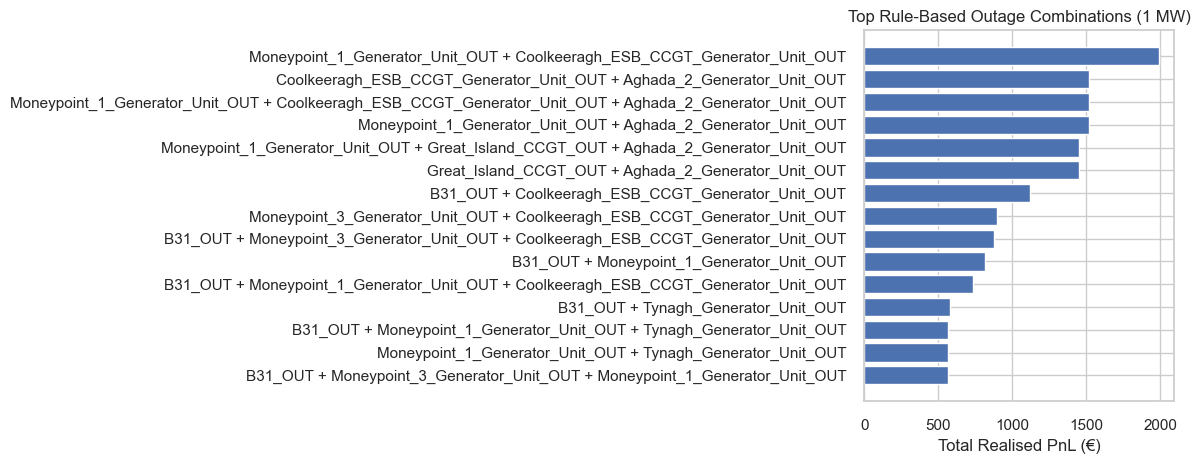

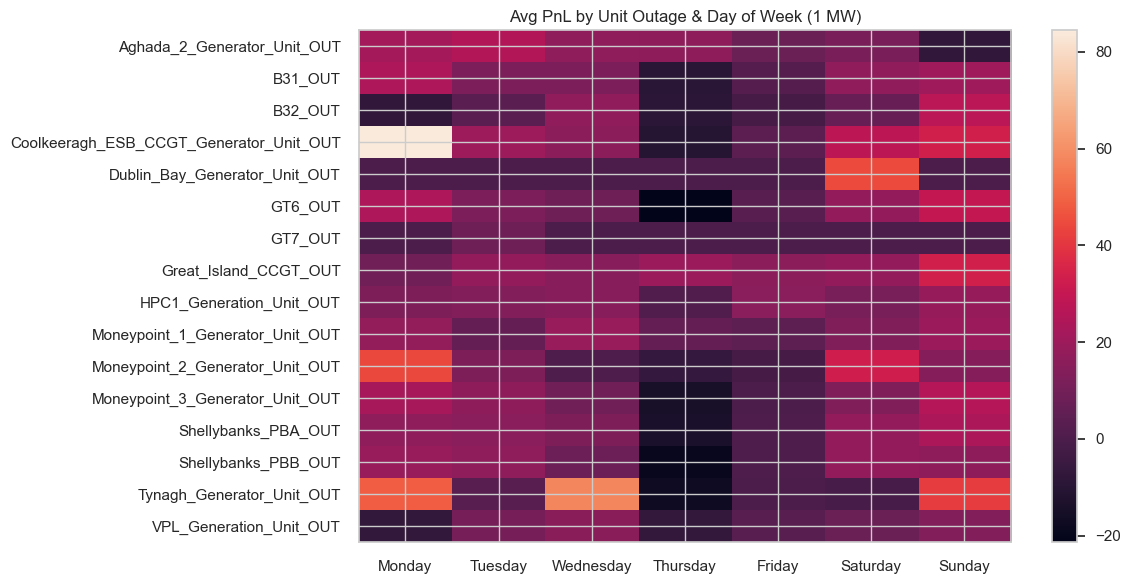

[6.7] Saved tiered playbook to playbook_rules_tiered.csv (Tier1≥200, Tier2≥100). Counts — Tier1: 130, Tier2: 46, Tier3: 64)
[6.7] Saved 130 high-confidence (Tier 1) rules to playbook_rules_tier1.csv


In [23]:
# ==================== SECTION 6.7 — Strategy Playbook (Hardened, Min-Trade Filter, Matplotlib-only) ====================
# Purpose
# -------
# Build a *trustable* “playbook” of outage-combination rules by:
#   1) computing realised PnL contributions per rule when the **Rule-only** leg is open,
#   2) ranking rules by **expectancy** (AvgWin/AvgLoss × HitRate) with a **minimum trade filter**,
#   3) tiering rules by evidence (TradeCount) so rare events don't dominate,
#   4) producing a unit × weekday diagnostic heatmap (informational only),
#   5) saving a CSV playbook (1 MW sizing; no costs; ex-ante logic preserved from earlier sections).
#
# Notes
# -----
# - Strictly 1 MW sizing (PnL is realised spread × direction). No transaction-cost assumptions.
# - Uses columns produced in 6.3–6.5/6.4 (compat aliases provided below).
# - Matplotlib only (no seaborn).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 0) Compatibility aliases
# -------------------------
# We may reach 6.7 with slightly different column names depending on which earlier sections ran.
# _alias maps the "friendly" names used below to the actual columns present in combined_prices_df.
_alias = {}
if 'OpenRulesOnly' in combined_prices_df.columns:
    _alias['RuleOnly_Open'] = 'OpenRulesOnly'          # whether rules-only strategy is open at time t
if 'RulesOnly_PnL' in combined_prices_df.columns:
    _alias['RuleOnly_PnL_1MW'] = 'RulesOnly_PnL'       # realised rules-only PnL at 1 MW
if 'MLOnly_PnL' in combined_prices_df.columns:
    _alias['MLOnly_PnL_1MW'] = 'MLOnly_PnL'            # realised ML-only PnL at 1 MW
if 'Ensemble_PnL' in combined_prices_df.columns:
    _alias['Ensemble_PnL_1MW'] = 'Ensemble_PnL'        # realised ensemble PnL at 1 MW
if 'ML_Dir_exec' in combined_prices_df.columns:
    _alias['MLOnly_Dir'] = 'ML_Dir_exec'               # ML trade direction at *execution* time (lagged)
if 'RuleDir' in combined_prices_df.columns:
    _alias['RuleOnly_Dir'] = 'RuleDir'                 # rule-only trade direction (sign of RuleScoreZ)

def col(name: str) -> str:
    """Resolve a friendly name to an actual dataframe column (or return name as-is if no alias)."""
    return _alias.get(name, name)

# Choose the realised PnL series used for analytics/plots in this section.
# Priority order: Ensemble PnL (best summary of strategy) > PnL_adj from 6.1B > raw spread.
if 'Ensemble_PnL' in combined_prices_df.columns:
    PNL_SRC = 'Ensemble_PnL'
elif 'PnL_adj' in combined_prices_df.columns:
    PNL_SRC = 'PnL_adj'
else:
    PNL_SRC = 'Spread_DAMtoBM'  # safe fallback if neither exists

# Ensure time column is proper datetime for grouping/ordering and time-based diagnostics.
combined_prices_df['StartDateTime'] = pd.to_datetime(combined_prices_df['StartDateTime'])

# -------------------------------
# 1) Load rules & ensure activity
# -------------------------------
# Pull the outage-combination rules mined in 6.2B; we need their *sign* to apply direction to PnL.
rules_df = pd.read_csv("filtered_outage_rules.csv", usecols=['Combination', 'Difference'])
rules_df['Sign'] = np.where(rules_df['Difference'] > 0, 1.0, -1.0)  # +1 if rule historically increases spread, else -1

# For every rule, ensure we have a boolean column RULE_ACTIVE__<combo> = True when ALL units in that combo are out.
active_cols = []
for combo in rules_df['Combination']:
    colname = f"RULE_ACTIVE__{combo}"
    if colname not in combined_prices_df.columns:
        # If the constituent unit flags exist, build the activity flag now.
        units = [u.strip() for u in combo.split(" + ")]
        if all(u in combined_prices_df.columns for u in units):
            combined_prices_df[colname] = (combined_prices_df[units].sum(axis=1) == len(units))
        else:
            # If we can't build it (missing unit column), skip this combo in downstream analytics.
            continue
    active_cols.append(colname)

# ---------------------------------------------------------
# 2) Per-rule realised PnL / expectancy (Rule-only gating)
# ---------------------------------------------------------
# We attribute realised PnL to rules *only when the Rule-only strategy is open*.
# If multiple rules are active at the same timestamp, we *split PnL equally* across those active rules.
rule_stats = []

if active_cols and col('RuleOnly_Open') in combined_prices_df.columns:
    # Build a minimal working frame containing time, the chosen PnL series, the rule-open flag, and all activity flags.
    w = combined_prices_df[['StartDateTime', PNL_SRC, col('RuleOnly_Open')] + active_cols].copy()
    w.sort_values('StartDateTime', inplace=True)  # chronological order for any time-based operations

    # Count of simultaneously-active rules at each timestamp (used to split PnL fairly).
    w['NumActive'] = w[active_cols].sum(axis=1).astype(int)

    # Base per-rule PnL share:
    #   - if RuleOnly is open AND at least one rule is active -> realised PnL / NumActive
    #   - otherwise -> 0 (no contribution attributed)
    denom = w['NumActive'].where(w['NumActive'] > 0, other=1).astype(float)  # guard divide-by-zero
    base = (w[PNL_SRC] / denom).where(w[col('RuleOnly_Open')] & (w['NumActive'] > 0), other=0.0)

    # Map each combo to its sign (+1 or -1) so we apply direction to the base contribution.
    sign_map = dict(zip(rules_df['Combination'], rules_df['Sign']))
    for combo in rules_df['Combination']:
        colname = f"RULE_ACTIVE__{combo}"
        if colname not in w.columns:
            continue  # skip combos we couldn't build

        # PnL credited to this rule only when the rule is active; multiply by rule sign to make it directional.
        per_trade = base.where(w[colname], other=0.0) * float(sign_map.get(combo, 0.0))

        # Compute KPIs for this rule's per-trade series.
        trades = int((per_trade != 0).sum())                       # number of timestamps that contributed
        wins = per_trade[per_trade > 0]
        losses = per_trade[per_trade < 0]

        total = float(per_trade.sum())                             # total realised € for this rule
        avg_pnl = float(per_trade[per_trade != 0].mean()) if trades else 0.0
        hit = float(len(wins) / trades) if trades else np.nan      # win-rate
        avg_win = float(wins.mean()) if len(wins) else np.nan
        avg_loss = float(abs(losses.mean())) if len(losses) else np.nan
        # Expectancy per trade: HitRate*AvgWin - (1-HitRate)*AvgLoss  (classic expectancy formula)
        expectancy = (
            (hit * (avg_win if np.isfinite(avg_win) else 0.0))
            - ((1 - hit) * (avg_loss if np.isfinite(avg_loss) else 0.0))
        ) if np.isfinite(hit) else np.nan

        # Collect stats row for this rule.
        rule_stats.append({
            'Rule': combo,
            'TradeCount': trades,
            'TotalPnL': total,
            'AvgPnL': avg_pnl,
            'HitRate': hit,
            'AvgWin': avg_win,
            'AvgLoss': avg_loss,
            'Expectancy': expectancy
        })

# Collate per-rule results into a dataframe (may be empty if no rules/flags were available).
rule_stats_df = pd.DataFrame(rule_stats)

# ------------------------------------------
# 3) Evidence safeguards and ranked outputs
# ------------------------------------------
# We don't want rare events to top the table, so apply a minimum trade filter before printing/plotting.
MIN_TRADES_TOP = 50         # Only show rules with >= 50 contributing timestamps
TIER1_MIN_TRADES = 200      # High-confidence tier threshold
TIER2_MIN_TRADES = 100      # Medium-confidence tier threshold

if not rule_stats_df.empty:
    # Keep an untouched copy for tiering/exports later.
    _all_rules_stats = rule_stats_df.copy()

    # Apply visibility filter for the "Top Setups" ranking/plot.
    rule_stats_df = rule_stats_df[rule_stats_df['TradeCount'] >= MIN_TRADES_TOP].copy()

    # Rank primarily by Expectancy (desc), then by evidence (TradeCount desc), then by TotalPnL (desc).
    rule_stats_df = (rule_stats_df
                     .sort_values(['Expectancy', 'TradeCount', 'TotalPnL'],
                                  ascending=[False, False, False])
                     .reset_index(drop=True))

    # Show the top 15 trade setups with their key KPIs.
    print(f"\n[6.7] Top Outage-Based Trade Setups by Expectancy (min trades = {MIN_TRADES_TOP}):")
    print(rule_stats_df[['Rule','TradeCount','AvgPnL','HitRate','AvgWin','AvgLoss','Expectancy']]
          .head(15)
          .to_string(index=False))
else:
    # If we have neither rule stats nor the rule-open flag, alert the user to check inputs.
    print("\n[6.7] No rule statistics available (check RuleOnly_Open or rule flags).")

# --------------------------------------
# 4) Plot top rules by Total Realised PnL
# --------------------------------------
# Visualises which combos *contributed the most euros* (after the min-trade filter).
if not rule_stats_df.empty:
    top_rules = rule_stats_df.sort_values('TotalPnL', ascending=False).head(15)
    plt.figure(figsize=(12, 4.8))
    plt.barh(top_rules['Rule'], top_rules['TotalPnL'])
    plt.gca().invert_yaxis()  # most profitable at the top
    plt.xlabel("Total Realised PnL (€)")
    plt.title("Top Rule-Based Outage Combinations (1 MW)")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 5) Unit × Day-of-Week heatmap (informational diagnostic)
# ---------------------------------------------------------
# We *describe* average PnL by unit and weekday for colour — it is not a tradable filter here.
rows = []
dow = combined_prices_df['StartDateTime'].dt.day_name()     # weekday labels per row
pnl_series = combined_prices_df[PNL_SRC].astype(float)      # PnL measure to average in the heatmap

for combo in rules_df['Combination']:
    colname = f"RULE_ACTIVE__{combo}"
    if colname not in combined_prices_df.columns:
        continue  # skip rules we couldn't build
    idx = combined_prices_df.index[combined_prices_df[colname]]  # rows where this rule is active
    units = [u.strip() for u in combo.split(" + ")]              # split combo into its constituent unit flags
    if len(idx) == 0:
        continue
    # For every unit in this combo, record the PnL values by weekday when the rule is active.
    for u in units:
        rows.append(pd.DataFrame({
            'Unit': u,
            'DayOfWeek': dow.loc[idx].values,
            'PnL': pnl_series.loc[idx].values
        }))

# Assemble all rows; if empty, create an empty frame with expected columns.
unit_day_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=['Unit','DayOfWeek','PnL'])
if not unit_day_df.empty:
    # Unit × Day pivot of *mean* PnL; fill missing with 0 for a clean heatmap.
    heat = unit_day_df.pivot_table(index='Unit', columns='DayOfWeek', values='PnL', aggfunc='mean').fillna(0.0)
    ordered_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    # Ensure all seven weekday columns exist in order (add zeros where absent).
    for d in ordered_days:
        if d not in heat.columns:
            heat[d] = 0.0
    heat = heat[ordered_days]

    # Plain matplotlib heatmap (no seaborn) with readable sizing.
    fig, ax = plt.subplots(figsize=(12, max(6, 0.35*len(heat))))
    im = ax.imshow(heat.values, aspect='auto')
    ax.set_yticks(range(len(heat.index))); ax.set_yticklabels(list(heat.index))
    ax.set_xticks(range(len(ordered_days))); ax.set_xticklabels(ordered_days)
    ax.set_title("Avg PnL by Unit Outage & Day of Week (1 MW)")
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 6) Tiered playbook and exports
# ------------------------------
# Build tier labels for all rules (not just the min-trade display subset) and export to CSV.
# Tiers:
#   - Tier1: TradeCount ≥ 200 and Expectancy > 0  (high-confidence, appears often and profitable on average)
#   - Tier2: 100 ≤ TradeCount < 200 and Expectancy > 0  (medium confidence)
#   - Tier3: TradeCount < 100  (kept for research; low evidence)
if '_all_rules_stats' in locals():
    all_stats = _all_rules_stats.copy()

    # Boolean masks for tier assignment.
    cond_t1 = (all_stats['TradeCount'] >= TIER1_MIN_TRADES) & (all_stats['Expectancy'] > 0)
    cond_t2 = (all_stats['TradeCount'] >= TIER2_MIN_TRADES) & (all_stats['TradeCount'] < TIER1_MIN_TRADES) & (all_stats['Expectancy'] > 0)
    cond_t3 = (all_stats['TradeCount'] < TIER2_MIN_TRADES)

    # Assign final Tier label.
    all_stats['Tier'] = np.where(cond_t1, 'Tier1',
                          np.where(cond_t2, 'Tier2', 'Tier3'))

    # Sort for readability in the CSV (Tier then signal quality indicators).
    all_stats = all_stats.sort_values(['Tier','Expectancy','TradeCount','TotalPnL'],
                                      ascending=[True, False, False, False])

    # Save the full tiered playbook (all tiers in one file).
    all_stats.to_csv("playbook_rules_tiered.csv", index=False)
    print(f"[6.7] Saved tiered playbook to playbook_rules_tiered.csv "
          f"(Tier1≥{TIER1_MIN_TRADES}, Tier2≥{TIER2_MIN_TRADES}). "
          f"Counts — Tier1: {(all_stats['Tier']=='Tier1').sum()}, "
          f"Tier2: {(all_stats['Tier']=='Tier2').sum()}, "
          f"Tier3: {(all_stats['Tier']=='Tier3').sum()})")

    # Optional: export a *high-confidence* subset (Tier 1 only) for direct use in live rules.
    playbook_t1 = all_stats[all_stats['Tier'] == 'Tier1'].copy()
    playbook_t1.to_csv("playbook_rules_tier1.csv", index=False)
    print(f"[6.7] Saved {len(playbook_t1)} high-confidence (Tier 1) rules to playbook_rules_tier1.csv")
else:
    # If for some reason we never built _all_rules_stats (e.g., no rules present), skip export.
    print("[6.7] No playbook export (no rule stats computed).")


In [24]:
# ==================== SECTION 7.0 — Setup & Compat Aliases (Leak Guarded) ====================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Work on a *copy* of the master frame so grid sweeps / plotting can't mutate earlier sections.
walkforward_df = combined_prices_df.copy()
# Ensure the time column is a proper datetime (needed for sorting, grouping, plotting).
walkforward_df['StartDateTime'] = pd.to_datetime(walkforward_df['StartDateTime'])

# ---- Compatibility aliases: map any "legacy" names to the canonical columns emitted in §6.4–6.7.
# This makes the section robust if you ran cells in a different order.
_alias = {
    'RuleOnly_Open'     : 'OpenRulesOnly',
    'RuleOnly_Dir'      : 'RuleDir',
    'RuleOnly_PnL_1MW'  : 'RulesOnly_PnL',
    'MLOnly_Open'       : 'OpenMLOnly',
    'MLOnly_Dir'        : 'ML_Dir_exec',      # IMPORTANT: use *lagged* ML direction only (no lookahead)
    'MLOnly_PnL_1MW'    : 'MLOnly_PnL',
    'Ensemble_PnL_1MW'  : 'Ensemble_PnL',
}
# If an "old" name is missing but the canonical column exists, create the alias column.
for old, new in _alias.items():
    if (old not in walkforward_df.columns) and (new in walkforward_df.columns):
        walkforward_df[old] = walkforward_df[new]

# ---- Hard safety: make sure the ensemble inputs from §6.4 are present.
REQ = [
    'Spread_DAMtoBM',     # realized spread; used ONLY to compute PnL (never for signal creation)
    'OpenEnsemble',       # ensemble open flag (already ML-gated & lagged in §6.4)
    'EnsembleDir',        # ensemble direction sign (+1/-1) from §6.4
    'OpenRulesOnly', 'RuleDir',         # rule-only gate + direction
    'OpenMLOnly', 'ML_Dir_exec'         # ML-only gate + lagged direction (ex-ante)
]
missing = [c for c in REQ if c not in walkforward_df.columns]
if missing:
    raise KeyError(f"[7] Missing required inputs from 6.4: {missing}")

# Keep references to thresholds (not required to run; used only for context in reporting).
OPEN_TH     = globals().get('OPEN_TH', 0.75)
ML_OPEN_TH  = globals().get('ML_OPEN_TH', 0.45)


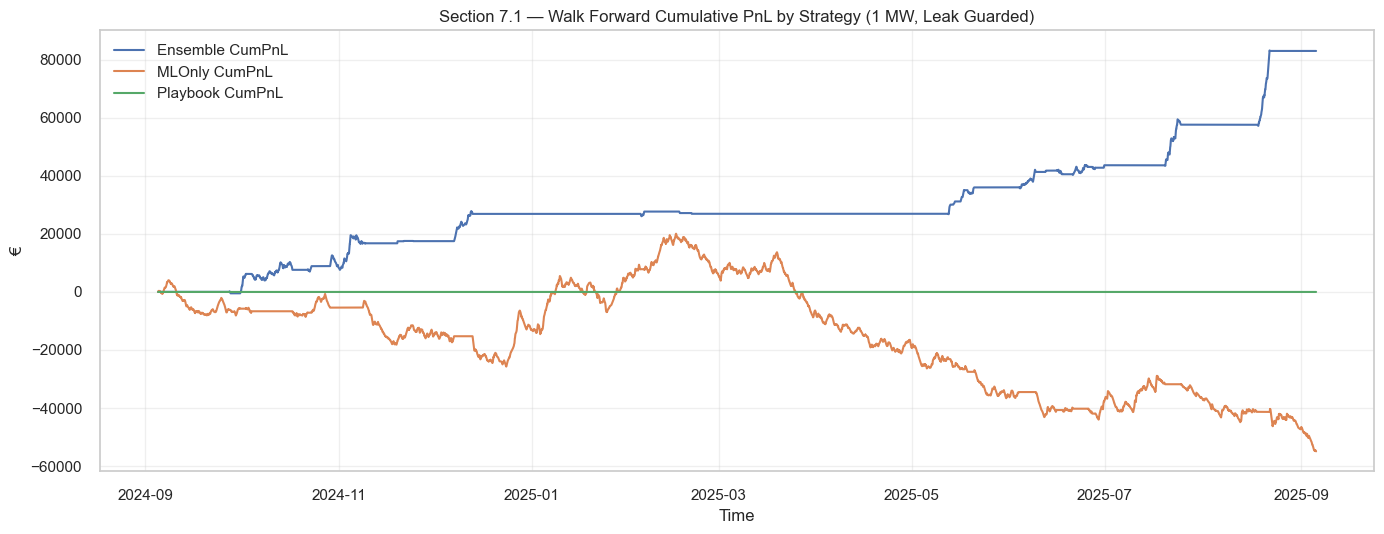


[7.1] Walk Forward Strategy Performance Summary (1 MW):

 Playbook
  Trades: 1
  Total PnL: €-31.50
  Win Rate: 0.00%
  Sharpe: nan
  Payoff: nan
  Expectancy: €-31.50

 MLOnly
  Trades: 14527
  Total PnL: €-54923.15
  Win Rate: 41.54%
  Sharpe: -0.05
  Payoff: 1.24
  Expectancy: €-3.75

 Ensemble
  Trades: 2884
  Total PnL: €82958.18
  Win Rate: 52.53%
  Sharpe: 0.30
  Payoff: 2.12
  Expectancy: €28.59

[7.1] Trade count by bucket (1 MW):
StrategyType
MLOnly      14647
Ensemble     2902
Playbook        1

[7.1] Gate diagnostics (share of periods open):
{'OpenEnsemble_share': 0.165, 'OpenRulesOnly_share': 0.095, 'OpenMLOnly_share': 1.0, 'Playbook_share': 0.862}


In [25]:
# ==================== SECTION 7.1 — Walk Forward Simulation (Ensemble Centric, 1 MW) ====================

# ---- (1) Load the *playbook* built in §6.7.
# Prefer Tier 1 file (high-confidence rules). If missing, fall back to a generic playbook or in-memory stats.
playbook_rules = []
for fname in ["playbook_rules_tier1.csv", "playbook_rules.csv"]:
    try:
        _pb = pd.read_csv(fname)
        # Two possible schemas: 'Combination' (6.2B/6.7) or 'Rule' (6.5/6.7).
        if 'Combination' in _pb.columns:
            playbook_rules = _pb['Combination'].dropna().astype(str).tolist()
            break
        if 'Rule' in _pb.columns:
            playbook_rules = _pb['Rule'].dropna().astype(str).tolist()
            break
    except Exception:
        # Silently continue if file not found—this section still runs without a playbook.
        pass

# If no file but we still have rule_stats_df in RAM, construct a conservative Tier 1 from it.
if (not playbook_rules) and ('rule_stats_df' in globals()):
    playbook_rules = (
        rule_stats_df.loc[(rule_stats_df['TradeCount'] >= 200) & (rule_stats_df['Expectancy'] > 0), 'Rule']
        .dropna().astype(str).tolist()
    )

# Ensure we have a boolean activity flag for each playbook rule; create if necessary.
playbook_cols = []
if playbook_rules:
    for combo in playbook_rules:
        col = f"RULE_ACTIVE__{combo}"
        if col in walkforward_df.columns:
            # Already built in §6.3/6.4 → reuse for speed/consistency.
            playbook_cols.append(col)
            continue
        # Otherwise, (re)build from the constituent unit outage flags (active if *all* sub-units are out).
        units = [u.strip() for u in combo.split(" + ")]
        if all(u in walkforward_df.columns for u in units):
            walkforward_df[col] = (walkforward_df[units].sum(axis=1) == len(units))
            playbook_cols.append(col)

# Master playbook flag (True if *any* Tier 1 rule is active). Used for diagnostics / optional filtering only.
walkforward_df['PlaybookRuleActive'] = walkforward_df[playbook_cols].any(axis=1) if playbook_cols else False

# ---- (2) Assign a *mutually-exclusive* strategy bucket per timestamp (no double counting).
# Priority order: Ensemble > RuleOnly > MLOnly > Playbook > None (so only one bucket trades per period).
def _bucket(row):
    if bool(row['OpenEnsemble']):       # fully leak-guarded in §6.4
        return 'Ensemble'
    if bool(row['OpenRulesOnly']):      # rule-only open flag (thresholded RuleScoreZ)
        return 'RuleOnly'
    if bool(row['OpenMLOnly']):         # ML-only (lagged, magnitude-gated)
        return 'MLOnly'
    if bool(row['PlaybookRuleActive']): # passive playbook presence (no trade sizing)
        return 'Playbook'
    return 'None'

walkforward_df['StrategyType'] = walkforward_df.apply(_bucket, axis=1)

# ---- (3) Map each bucket to its *direction* column (all ex-ante compliant).
_dir_col = {
    'Ensemble': 'EnsembleDir',
    'RuleOnly': 'RuleDir',
    'MLOnly'  : 'ML_Dir_exec',  # lagged ML direction
    'Playbook': 'RuleDir',      # for diagnostics only; playbook uses rule sign
}
def _dir_lookup(row):
    dcol = _dir_col.get(row['StrategyType'])
    return int(row[dcol]) if dcol and (dcol in walkforward_df.columns) else 0

walkforward_df['StrategyDir'] = walkforward_df.apply(_dir_lookup, axis=1).astype(int)

# ---- (4) Execute at exactly *1 MW* whenever a bucket is active; no transaction costs, no stacking.
walkforward_df['TradeSizeMW'] = np.where(walkforward_df['StrategyType'].eq('None'), 0, 1).astype(int)

# PnL driver (realized spread). Never used for *gating*, only for PnL calculation → leak-safe.
spread = walkforward_df['Spread_DAMtoBM'].astype(float)

# Per-period PnL (1 MW): direction × realized spread if trading, else 0.
walkforward_df['WF_PnL'] = walkforward_df['TradeSizeMW'] * walkforward_df['StrategyDir'] * spread
walkforward_df['WF_CumulativePnL'] = walkforward_df['WF_PnL'].cumsum()

# ---- (5) Plot cumulative PnL by bucket (stacked view over time).
pnl_by_type = (
    walkforward_df
    .groupby(['StartDateTime', 'StrategyType'])['WF_PnL']
    .sum().unstack(fill_value=0).sort_index().cumsum()
)

plt.figure(figsize=(14, 5.5))
for col in pnl_by_type.columns:
    plt.plot(pnl_by_type.index, pnl_by_type[col], label=f"{col} CumPnL")
plt.title("Section 7.1 — Walk Forward Cumulative PnL by Strategy (1 MW, Leak Guarded)")
plt.xlabel("Time"); plt.ylabel("€"); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# ---- (6) KPI helper: compute trades/total/win-rate/sharpe/payoff/expectancy for a PnL series.
def _kpis(series):
    s = series.dropna()
    trades = s.ne(0).sum()                    # one "trade" = one non-zero-PnL period at 1 MW
    wins   = s[s > 0]; losses = s[s < 0]
    win_rate   = (len(wins) / trades) if trades else np.nan
    std = s.std()                             # sample std (ddof=1); OK for reporting
    sharpe     = (s.mean()/std) if (std and np.isfinite(std) and std > 0) else np.nan
    payoff     = (wins.mean()/abs(losses.mean())) if len(losses) else np.nan
    expectancy = s.mean()                     # € per trade-period @ 1 MW
    return dict(trades=int(trades), total=float(s.sum()),
                win_rate=win_rate, sharpe=sharpe, payoff=payoff, expectancy=expectancy)

# Print KPIs for the main buckets (order chosen for readability).
print("\n[7.1] Walk Forward Strategy Performance Summary (1 MW):")
for strategy in ['RuleOnly','Playbook','MLOnly','Ensemble']:
    mask = walkforward_df['StrategyType'].eq(strategy)
    pnl  = walkforward_df.loc[mask, 'WF_PnL']
    if pnl.empty or (pnl.ne(0).sum() == 0):
        continue
    k = _kpis(pnl)
    print(f"\n {strategy}")
    print(f"  Trades: {k['trades']}")
    print(f"  Total PnL: €{k['total']:.2f}")
    print(f"  Win Rate: {k['win_rate']*100 if pd.notna(k['win_rate']) else 0:.2f}%")
    print(f"  Sharpe: {k['sharpe']:.2f}")
    print(f"  Payoff: {k['payoff']:.2f}")
    print(f"  Expectancy: €{k['expectancy']:.2f}")

# ---- (7) Diagnostics to sanity-check gates and exclusivity.
# Count of non-zero trade periods per bucket (sums should be <= total rows due to exclusivity).
trade_counts = walkforward_df.loc[walkforward_df['TradeSizeMW'] == 1, 'StrategyType'].value_counts()
print("\n[7.1] Trade count by bucket (1 MW):")
print(trade_counts.to_string())

# Share of time each gate is open (helps detect accidental lookahead or a dead gate).
gate_diag = {
    'OpenEnsemble_share' : float(walkforward_df['OpenEnsemble'].mean()),
    'OpenRulesOnly_share': float(walkforward_df['OpenRulesOnly'].mean()),
    'OpenMLOnly_share'   : float(walkforward_df['OpenMLOnly'].mean()),
    'Playbook_share'     : float(walkforward_df['PlaybookRuleActive'].mean()),
}
print("\n[7.1] Gate diagnostics (share of periods open):")
print({k: round(v, 3) for k, v in gate_diag.items()})



[7.2] Walk-Forward Strategy Performance Comparison (1 MW):
Strategy  Trades  Total PnL (€)  Win Rate (%)  Sharpe Ratio  Payoff Ratio  Expectancy (€)
Ensemble    2902       82958.18     52.205376      0.298021      2.119032       28.586554
  MLOnly   14647      -54923.15     41.196149     -0.048403      1.242734       -3.749788
Playbook       1         -31.50      0.000000           NaN           NaN      -31.500000


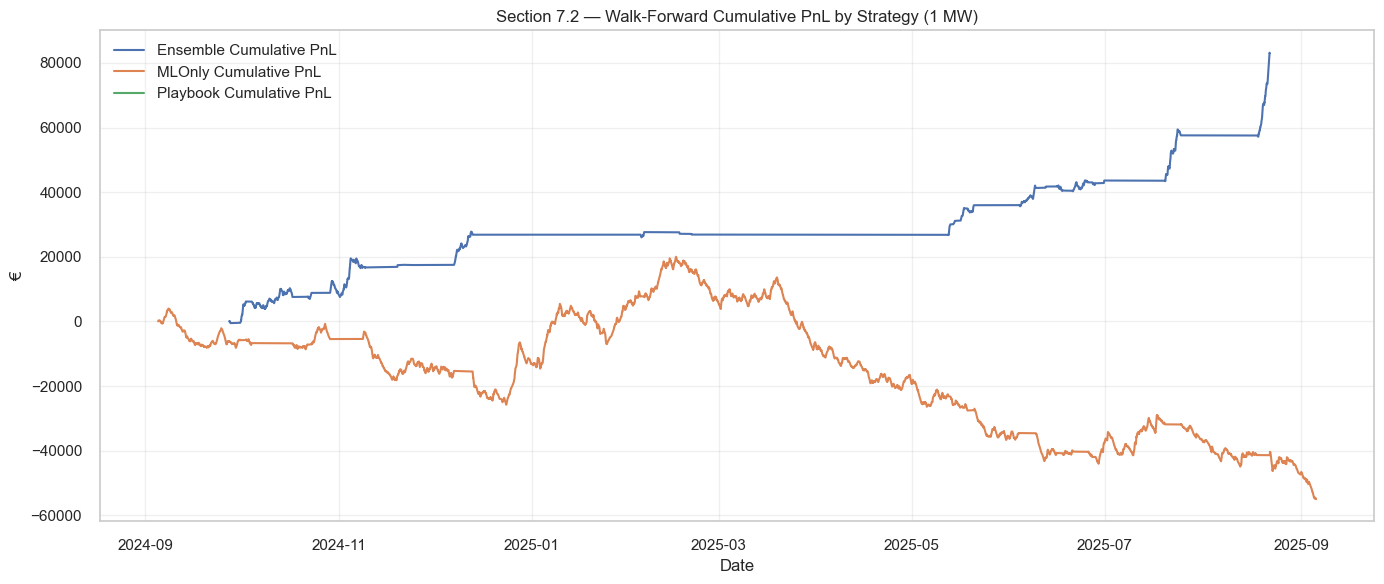

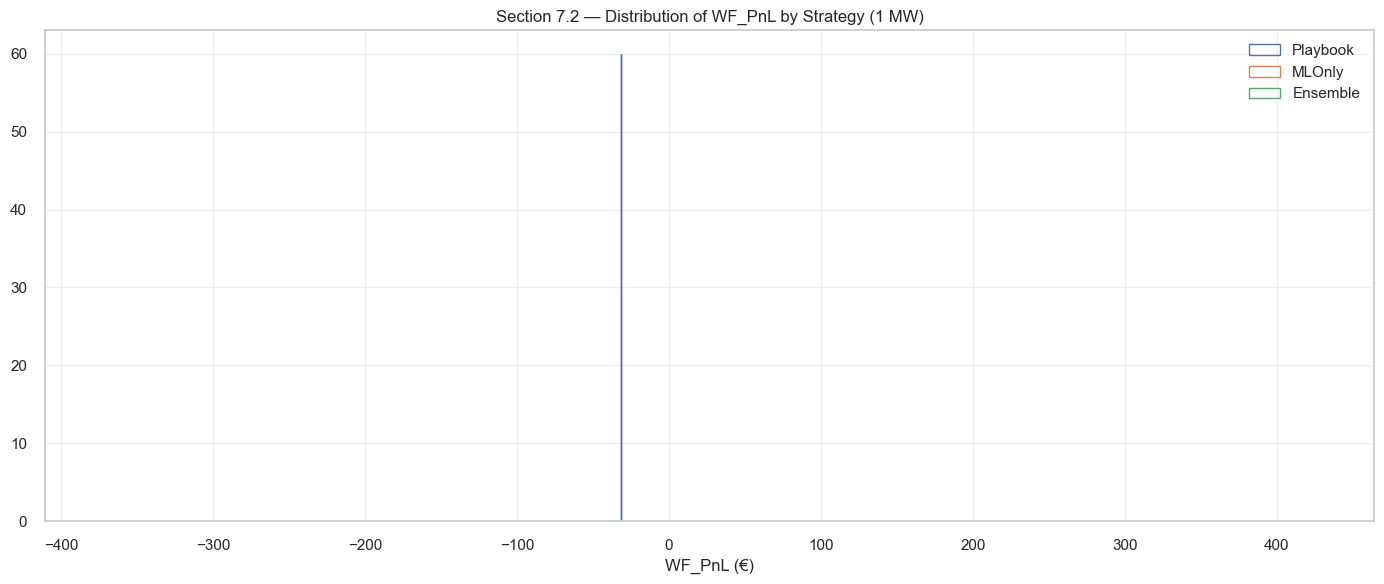

In [26]:
# ==================== SECTION 7.2: Summary & Comparisons (Walk-Forward) ====================
# Objective:
# - Take the walk-forward results produced in 7.0/7.1
# - Rebuild any missing fields defensively (StrategyType, StrategyDir, TradeSize, WF_PnL, cumulatives)
# - Produce a compact KPI table per strategy bucket (Ensemble / RuleOnly / MLOnly / Playbook / None)
# - Plot cumulative PnL by strategy and the distribution of per-period PnL for each bucket
# Constraints:
# - 1 MW fixed sizing, no transaction costs, no seaborn, one chart per figure, default matplotlib styling

import numpy as np                      # numerical helpers (nan handling, vectorized ops)
import pandas as pd                     # tabular manipulation and groupby/aggregation
import matplotlib.pyplot as plt         # plotting (matplotlib only per spec)

# --- A) Ensure walkforward_df exists and has essentials ---
# We must have the dataframe constructed in 7.0/7.1; fail fast if it's not in scope.
assert 'walkforward_df' in globals(), "[7.2] walkforward_df missing. Run 7.0/7.1 first or keep this cell."

# Work on a copy so we never mutate the master in-place while summarising/plotting.
wf = walkforward_df.copy()

# If StrategyType wasn't persisted by 7.1, rebuild it using the same priority:
# Ensemble > RuleOnly > MLOnly > Playbook > None.
if 'StrategyType' not in wf.columns:
    def _bucket(row):
        # Ensemble takes precedence if its open flag is True at the timestamp
        if 'OpenEnsemble' in row and bool(row['OpenEnsemble']):   return 'Ensemble'
        # Next, RuleOnly
        if 'OpenRulesOnly' in row and bool(row['OpenRulesOnly']): return 'RuleOnly'
        # Then MLOnly
        if 'OpenMLOnly' in row and bool(row['OpenMLOnly']):       return 'MLOnly'
        # Passive Playbook presence if neither Ensemble/RuleOnly/MLOnly are on
        if 'PlaybookRuleActive' in row and bool(row['PlaybookRuleActive']): return 'Playbook'
        # Otherwise, no strategy active
        return 'None'
    # Apply row-wise to assign a single exclusive bucket per timestamp
    wf['StrategyType'] = wf.apply(_bucket, axis=1)

# StrategyDir (execution direction) may also need to be rebuilt.
# Map each strategy bucket to the direction column already computed in earlier sections.
if 'StrategyDir' not in wf.columns:
    dir_map = {
        'Ensemble':  'EnsembleDir',  # direction from ensemble score sign
        'RuleOnly':  'RuleDir',      # direction from rules score sign
        'Playbook':  'RuleDir',      # playbook reuses the rules direction
        'MLOnly':    'ML_Dir_exec'   # LAGGED ML direction (ex-ante)
    }
    def _dir_lookup(row):
        # Fetch the appropriate direction column for the active bucket
        dcol = dir_map.get(row['StrategyType'])
        if dcol in wf.columns:
            try:
                return int(row[dcol])  # cast to int {-1, 0, +1}
            except Exception:
                return 0               # on any parsing issue, be safe and treat as flat
        return 0                       # if no direction available, flat (no position)
    # Compute per-row direction aligned with the chosen bucket
    wf['StrategyDir'] = wf.apply(_dir_lookup, axis=1).astype(int)

# TradeSize: if not persisted, default to the project spec — 1 MW when *any* strategy is active, else 0.
if 'TradeSize' not in wf.columns:
    wf['TradeSize'] = np.where(wf['StrategyType'].eq('None'), 0, 1).astype(int)

# WF_PnL: compute if missing using *realized* spread (no look-ahead) and the bucket direction at 1 MW.
if 'WF_PnL' not in wf.columns:
    # Guard: we need the realized spread series built earlier (DAM->BM)
    assert 'Spread_DAMtoBM' in wf.columns, "[7.2] Spread_DAMtoBM missing."
    spread = wf['Spread_DAMtoBM'].astype(float)                   # realized € / MWh
    wf['WF_PnL'] = wf['TradeSize'] * wf['StrategyDir'] * spread   # per-period PnL at 1 MW

# Cumulative PnL: build if missing for plotting equity-like curves by strategy.
if 'WF_CumulativePnL' not in wf.columns:
    wf['WF_CumulativePnL'] = wf['WF_PnL'].cumsum()

# --- B) Push back to main DF (only columns that exist) ---
# Keep the master combined_prices_df in sync so later sections / exports can reuse these series.
for col in ['StrategyType','TradeSize','WF_PnL','WF_CumulativePnL']:
    if col in wf.columns:
        combined_prices_df[col] = wf[col].values

# --- C) Strategy-level summary KPIs (1 MW) ---
# Helper to compute a Sharpe-like ratio safely (mean / std, with guards for zero std)
def _safe_sharpe(x):
    std = x.std()
    return (x.mean()/std) if (std is not None and std > 0) else np.nan

# Aggregate KPIs per strategy bucket:
# - Trades       : count of rows (periods) in the bucket
# - Total PnL    : sum of per-period PnL
# - Win Rate     : share of positive PnL rows (%)
# - Sharpe Ratio : mean/std of PnL
# - Payoff Ratio : avg(win) / |avg(loss)|, if losses exist
# - Expectancy   : mean € per period in the bucket (1 MW)
summary_df = (
    wf.groupby('StrategyType')
      .agg(
          Trades=('WF_PnL', 'count'),
          Total_PnL=('WF_PnL', 'sum'),
          WinRate=('WF_PnL', lambda x: (x > 0).mean() * 100),
          Sharpe=('WF_PnL', _safe_sharpe),
          Payoff=('WF_PnL', lambda x: (x[x > 0].mean() / abs(x[x < 0].mean())) if len(x[x < 0]) > 0 else np.nan),
          Expectancy=('WF_PnL', 'mean')
      )
      .reset_index()
      .rename(columns={
          'StrategyType': 'Strategy',
          'Total_PnL': 'Total PnL (€)',
          'WinRate': 'Win Rate (%)',
          'Sharpe': 'Sharpe Ratio',
          'Payoff': 'Payoff Ratio',
          'Expectancy': 'Expectancy (€)'
      })
)

# Print a tidy table so it drops straight into the report.
print("\n[7.2] Walk-Forward Strategy Performance Comparison (1 MW):")
print(summary_df.to_string(index=False))

# --- D) Cumulative PnL by strategy ---
# Build an equity-curve style table: cumulative sum of WF_PnL per strategy over time.
cum_df = (
    wf.sort_values('StartDateTime')                          # chronological order
      .groupby(['StrategyType','StartDateTime'])['WF_PnL']   # sum PnL per bucket per timestamp
      .sum()
      .groupby(level=0).cumsum()                             # cumulative PnL within each bucket
      .reset_index()
)

# Plot a single figure with one line per strategy bucket.
plt.figure(figsize=(14,6))
for strategy in cum_df['StrategyType'].unique():
    s = cum_df[cum_df['StrategyType'] == strategy]
    plt.plot(s['StartDateTime'], s['WF_PnL'], label=f"{strategy} Cumulative PnL")
plt.title("Section 7.2 — Walk-Forward Cumulative PnL by Strategy (1 MW)")
plt.xlabel("Date"); plt.ylabel("€")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- E) Distribution of WF_PnL by strategy ---
# For each bucket, plot the histogram of per-period PnL (60 bins, normalised density, step outline)
plt.figure(figsize=(14,6))
for strategy in wf['StrategyType'].dropna().unique():
    data = wf.loc[wf['StrategyType'] == strategy, 'WF_PnL']  # series for the bucket
    data = data[np.isfinite(data)]                           # drop NaN/inf just in case
    if data.empty:
        continue                                             # skip buckets with no observations
    plt.hist(data, bins=60, density=True, histtype='step', label=strategy)
plt.title("Section 7.2 — Distribution of WF_PnL by Strategy (1 MW)")
plt.xlabel("WF_PnL (€)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



[7.3] Diagnostics — Weekday/Confidence Filters on Ensemble (1 MW)
 Auto-identified bad weekdays (mean Ensemble WF_PnL < 0): None
 ML confidence keep-share on Ensemble (HIGH_CONF_TH=0.65): 0.000
 Original Ensemble trades: 2884
 After removing bad weekdays: 2884
 After removing low ML confidence: 0
 Remaining after both filters: 0

[7.3] Ensemble KPI (WF_PnL) — Before vs After Filters (1 MW)
 BEFORE -> Trades: 2884, Total: €82958.18, Win: 52.53%, Sharpe: 0.30, Payoff: 2.12, Expect: €28.76
 AFTER  -> Trades: 0, Total: €0.00, Win: 0.00%, Sharpe: nan, Payoff: nan, Expect: €nan


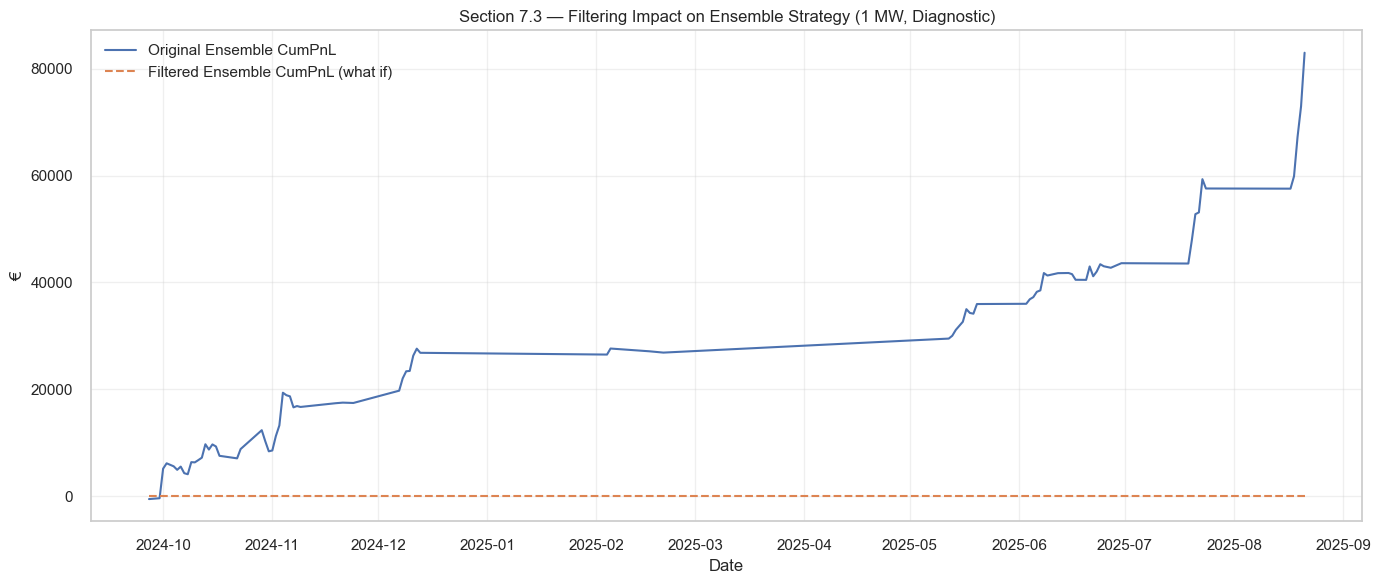

In [27]:
# ==================== SECTION 7.3 — Strategy Filters (Ensemble, Diagnostic Only) ====================
# Purpose (WHAT-IF ONLY):
#   - Sanity-check simple filters on the Ensemble strategy without changing baseline WF results.
#   - Filters explored:
#       (1) Weekday effect: auto-identify weekdays with negative mean Ensemble WF_PnL and hypothetically skip them.
#       (2) ML "high-confidence" screen: require a stricter bar above the ML gate used for trading.
# Notes:
#   - 1 MW sizing everywhere, no transaction costs.
#   - Matplotlib-only plots. We DO NOT write filtered results back to combined_prices_df.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) Guards & setup ----------
# Ensure we have timestamps and convert to datetime for grouping/plots
if 'StartDateTime' not in combined_prices_df.columns:
    raise KeyError("[7.3] StartDateTime missing. Run earlier sections first.")
s73 = combined_prices_df.copy()
s73['StartDateTime'] = pd.to_datetime(s73['StartDateTime'])

# Pre-compute a boolean mask for Ensemble rows; we will apply filters only on those
ens_mask = (s73['StrategyType'] == 'Ensemble')

# ---------- 1) Weekday diagnostic filter ----------
# Extract weekday names ("Monday", ..., "Sunday") for each row
s73['Weekday'] = s73['StartDateTime'].dt.day_name()

# Compute the mean per-period WF_PnL for the Ensemble bucket by weekday
weekday_mean = (
    s73.loc[ens_mask]
      .groupby(s73.loc[ens_mask, 'StartDateTime'].dt.day_name())['WF_PnL']
      .mean()
      .sort_index()
)

# Define "bad" weekdays as those with negative average PnL (you will hypothetically skip these)
bad_days = weekday_mean[weekday_mean < 0].index.tolist()

# Flag timestamps that fall on identified "bad" weekdays
s73['IsBadDay'] = s73['Weekday'].isin(bad_days)

# ---------- 2) ML high-confidence diagnostic filter ----------
# Retrieve the ML gate used in §6.4 (if present); default to 0.45 as in your ensemble code.
ML_OPEN_TH = float(globals().get('ML_OPEN_TH', 0.45))

# Set a stricter bar than the trading gate (here: max of 0.65 and ML_OPEN_TH + 0.10)
# NOTE: If this bar is too high relative to your |ML_Score_exec| distribution, it may exclude all trades.
HIGH_CONF_TH = max(0.65, ML_OPEN_TH + 0.10)

# If a calibrated ML confidence column exists in [0,1], use that; otherwise proxy with |ML_Score_exec|.
if 'ML_Confidence' in s73.columns:
    s73['LowMLConfidence'] = s73['ML_Confidence'].astype(float) < HIGH_CONF_TH
elif 'ML_Score_exec' in s73.columns:
    s73['LowMLConfidence'] = s73['ML_Score_exec'].astype(float).abs() < HIGH_CONF_TH
else:
    # If neither confidence nor score are present, do not filter on confidence
    s73['LowMLConfidence'] = False

# ---------- 3) Combine filters (WHAT IF only) ----------
# A period is filtered out if it is either a "bad" weekday OR below the high-confidence bar
s73['FilteredOut'] = s73['IsBadDay'] | s73['LowMLConfidence']

# IMPORTANT: Take a fresh view of Ensemble rows AFTER creating the new columns above
ens_df = s73.loc[ens_mask].copy()

# Diagnostics: share of Ensemble rows that pass the confidence screen (for context)
conf_keep_share = float((~ens_df['LowMLConfidence']).mean())

# Trade counts below are computed over TRUE trade events only (non-zero PnL rows)
ens_trades_total = int((ens_df['WF_PnL'] != 0).sum())
ens_trades_wkday = int(((ens_df['WF_PnL'] != 0) & (~ens_df['IsBadDay'])).sum())
ens_trades_conf  = int(((ens_df['WF_PnL'] != 0) & (~ens_df['LowMLConfidence'])).sum())
ens_trades_both  = int(((ens_df['WF_PnL'] != 0) & (~ens_df['FilteredOut'])).sum())

print("\n[7.3] Diagnostics — Weekday/Confidence Filters on Ensemble (1 MW)")
print(" Auto-identified bad weekdays (mean Ensemble WF_PnL < 0):", bad_days if bad_days else "None")
print(f" ML confidence keep-share on Ensemble (HIGH_CONF_TH={HIGH_CONF_TH:.2f}): {conf_keep_share:.3f}")
print(f" Original Ensemble trades: {ens_trades_total}")
print(f" After removing bad weekdays: {ens_trades_wkday}")
print(f" After removing low ML confidence: {ens_trades_conf}")
print(f" Remaining after both filters: {ens_trades_both}")

# ---------- 4) KPI before/after (WHAT IF) ----------
def _kpis(series: pd.Series) -> dict:
    """Compute KPIs on non-zero trades (1 MW) — total, win%, Sharpe, payoff, expectancy."""
    s = series.dropna()
    s = s[s != 0]  # only evaluate real trades
    trades = int(s.size)
    total  = float(s.sum())
    wins   = s[s > 0]; losses = s[s < 0]
    winrate = (len(wins) / trades) if trades else np.nan
    sharpe  = (s.mean()/s.std()) if (np.isfinite(s.std()) and s.std() > 0) else np.nan
    payoff  = (wins.mean()/abs(losses.mean())) if len(losses) else np.nan
    expect  = s.mean() if trades else np.nan
    return dict(trades=trades, total=total, winrate=winrate, sharpe=sharpe, payoff=payoff, expect=expect)

# BEFORE: KPIs on the actual Ensemble trades (no filters applied)
k_before = _kpis(ens_df['WF_PnL'])

# AFTER (WHAT IF): zero out Ensemble PnL on filtered rows; other strategies remain untouched
s73['FilteredPnL'] = np.where(ens_mask & (~s73['FilteredOut']), s73['WF_PnL'], 0.0)
k_after = _kpis(s73.loc[ens_mask, 'FilteredPnL'])

print("\n[7.3] Ensemble KPI (WF_PnL) — Before vs After Filters (1 MW)")
print(f" BEFORE -> Trades: {k_before['trades']}, Total: €{k_before['total']:.2f}, "
      f"Win: {k_before['winrate']*100 if pd.notna(k_before['winrate']) else 0:.2f}%, "
      f"Sharpe: {k_before['sharpe']:.2f}, Payoff: {k_before['payoff']:.2f}, Expect: €{k_before['expect']:.2f}")
print(f" AFTER  -> Trades: {k_after['trades']}, Total: €{k_after['total']:.2f}, "
      f"Win: {k_after['winrate']*100 if pd.notna(k_after['winrate']) else 0:.2f}%, "
      f"Sharpe: {k_after['sharpe']:.2f}, Payoff: {k_after['payoff']:.2f}, Expect: €{k_after['expect']:.2f}")

# ---------- 5) Plot (daily cumulative WHAT IF) ----------
# Aggregate to daily to smooth noise and show the hypothetical impact clearly
daily_original = (
    ens_df.groupby(ens_df['StartDateTime'].dt.date)['WF_PnL']
          .sum().cumsum()
)
daily_filtered = (
    s73.loc[ens_mask].groupby(s73.loc[ens_mask, 'StartDateTime'].dt.date)['FilteredPnL']
          .sum().cumsum()
)

# Plot the original vs "what-if filtered" cumulative PnL
plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(daily_original.index), daily_original.values, label='Original Ensemble CumPnL')
plt.plot(pd.to_datetime(daily_filtered.index), daily_filtered.values,
         label='Filtered Ensemble CumPnL (what if)', linestyle='--')
plt.title("Section 7.3 — Filtering Impact on Ensemble Strategy (1 MW, Diagnostic)")
plt.xlabel("Date"); plt.ylabel("€")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# NOTE: This section is diagnostic. We do NOT persist any filtered results back to combined_prices_df.



[7.4] Ensemble Daily KPIs (1 MW) — Before vs After Sharpe Overlay
 BEFORE -> Days traded: 84, Total: €82958.18, Win: 60.71%, Sharpe: 0.21, Payoff: 3.03, Expect/day: €252.15
 AFTER  -> Days traded: 71, Total: €65878.29, Win: 59.15%, Sharpe: 0.18, Payoff: 2.80, Expect/day: €200.24


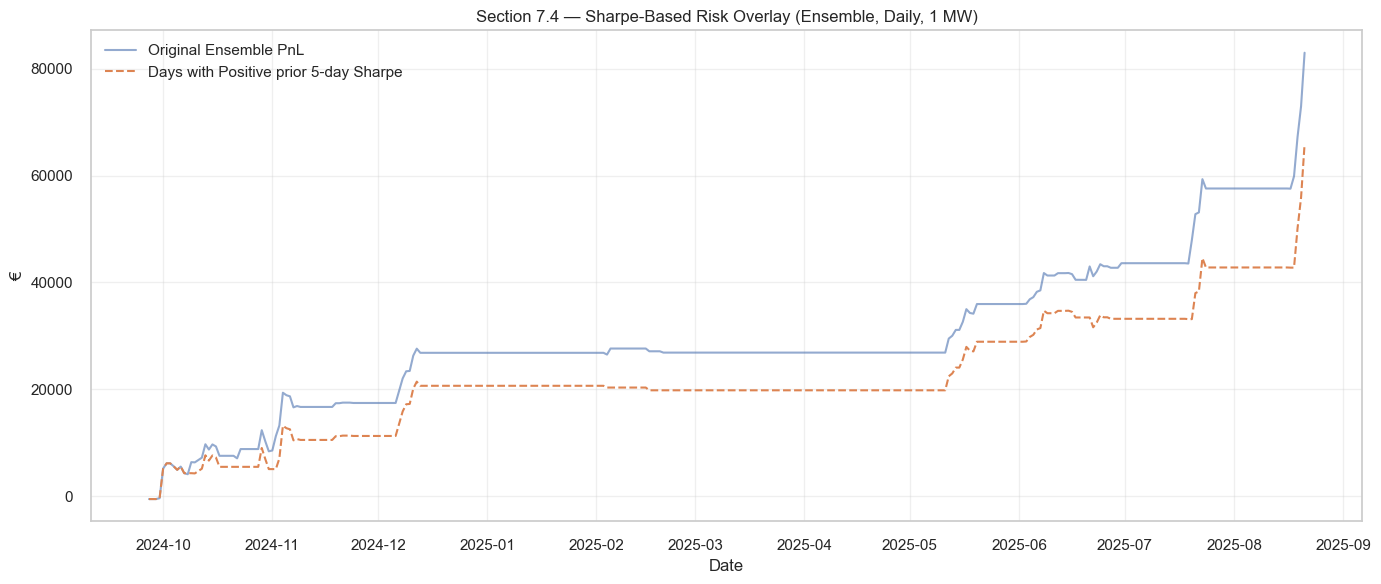

In [28]:
# ==================== SECTION 7.4 — Risk Overlay: 5-Day Sharpe Targeting (Ensemble, leak-guarded) ====================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- 1) Build a daily Ensemble PnL series (1 MW) --------
# We start from the walk-forward results: each row has WF_PnL (per timestamp) and StrategyType.
# Convert StartDateTime to calendar date so we can aggregate to days.
df = combined_prices_df.copy()
df['StartDateTime'] = pd.to_datetime(df['StartDateTime'])
df['Date'] = df['StartDateTime'].dt.floor('D')  # date at midnight

# Keep only rows when the *Ensemble* bucket was active in §7.1, then sum to daily totals.
# We resample to *all* calendar days so the rolling window has consistent spacing,
# filling missing Ensemble days with 0 (no Ensemble trades that day).
ens_daily = (
    df.loc[df['StrategyType'] == 'Ensemble', ['Date', 'WF_PnL']]
      .groupby('Date', as_index=True)['WF_PnL']
      .sum()
      .rename('DailyPnL')
      .to_frame()
      .asfreq('D', fill_value=0.0)   # include quiet days explicitly
)

# -------- 2) Rolling stats for a 5-day Sharpe signal (using only *prior* data) --------
# Rolling mean & std over the past 5 days *excluding today* to avoid look-ahead.
# We do this by computing the rolling values and then shifting by 1 day.
window = 5
eps = 1e-6  # small guard to avoid division by zero

ens_daily['RollMean_5d'] = ens_daily['DailyPnL'].rolling(window=window, min_periods=window).mean().shift(1)
ens_daily['RollStd_5d']  = ens_daily['DailyPnL'].rolling(window=window, min_periods=window).std().shift(1)

# Sharpe proxy (mean / std) for the prior 5 days; NaN when we don't yet have 5 full prior days.
ens_daily['Sharpe_5d_prior'] = ens_daily['RollMean_5d'] / (ens_daily['RollStd_5d'] + eps)

# -------- 3) Pause rule from the prior-day signal --------
# If yesterday’s 5-day Sharpe (using data up to t-1) is < 0, we *pause* the Ensemble for day t.
# On days with insufficient look-back (NaN), we *do not* pause (stay neutral about the rule).
ens_daily['PauseToday'] = ens_daily['Sharpe_5d_prior'] < 0

# Apply the pause: when paused, replace today’s Ensemble PnL with 0;
# otherwise leave the realized PnL unchanged (this is a WHAT-IF overlay; we’re not re-trading intraday).
ens_daily['FilteredPnL'] = np.where(ens_daily['PauseToday'], 0.0, ens_daily['DailyPnL'])

# -------- 4) KPIs before vs after (daily perspective, 1 MW) --------
def _kpis_daily(pnl: pd.Series) -> dict:
    """Basic KPIs for a daily PnL series (notional 1 MW)."""
    s = pnl.dropna()
    trades = int((s != 0).sum())  # treat any nonzero day as a 'trade day'
    total  = float(s.sum())
    wins   = s[s > 0]; losses = s[s < 0]
    win_rate  = (len(wins)/trades) if trades else np.nan
    stdev     = s.std(ddof=0)
    sharpe    = (s.mean()/stdev) if (np.isfinite(stdev) and stdev > 0) else np.nan
    payoff    = (wins.mean()/abs(losses.mean())) if len(losses) else np.nan
    expectancy= s.mean()  # € per calendar day
    return dict(trades=trades,total=total,win_rate=win_rate,sharpe=sharpe,payoff=payoff,expectancy=expectancy)

k_before = _kpis_daily(ens_daily['DailyPnL'])
k_after  = _kpis_daily(ens_daily['FilteredPnL'])

print("\n[7.4] Ensemble Daily KPIs (1 MW) — Before vs After Sharpe Overlay")
print(f" BEFORE -> Days traded: {k_before['trades']}, Total: €{k_before['total']:.2f}, "
      f"Win: {k_before['win_rate']*100 if pd.notna(k_before['win_rate']) else 0:.2f}%, "
      f"Sharpe: {k_before['sharpe']:.2f}, Payoff: {k_before['payoff']:.2f}, Expect/day: €{k_before['expectancy']:.2f}")
print(f" AFTER  -> Days traded: {k_after['trades']}, Total: €{k_after['total']:.2f}, "
      f"Win: {k_after['win_rate']*100 if pd.notna(k_after['win_rate']) else 0:.2f}%, "
      f"Sharpe: {k_after['sharpe']:.2f}, Payoff: {k_after['payoff']:.2f}, Expect/day: €{k_after['expectancy']:.2f}")

# -------- 5) Cumulative curves (original vs overlay) --------
ens_daily['CumPnL_Original'] = ens_daily['DailyPnL'].cumsum()
ens_daily['CumPnL_Filtered'] = ens_daily['FilteredPnL'].cumsum()

plt.figure(figsize=(14, 6))
plt.plot(ens_daily.index, ens_daily['CumPnL_Original'], label='Original Ensemble PnL', alpha=0.6)
plt.plot(ens_daily.index, ens_daily['CumPnL_Filtered'], label='Days with Positive prior 5-day Sharpe', linestyle='--')
plt.title("Section 7.4 — Sharpe-Based Risk Overlay (Ensemble, Daily, 1 MW)")
plt.xlabel("Date"); plt.ylabel("€")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


In [29]:
# ============================ SECTION 8.0 — OOS & Diagnostics (Compat Bootstrap) ============================
#
# Purpose
# -------
# This block "bootstraps" Section 8 so that regardless of how the notebook was run (from start or mid-way),
# we have:
#   - A consistent strategy label column (`StrategyType`)
#   - A single unified **per-bar PnL** column (preferably WF_PnL at 1 MW sizing)
#   - Component PnL legs (Ensemble, RulesOnly, MLOnly) rebuilt if they are missing
#   - A few backward-compatibility aliases so older cells continue to work
#
# Design rules carried forward from Sections 1–7.5:
#   - Strict 1 MW sizing (no leverage or pyramiding)
#   - No transaction costs (unknown in our data)
#   - No lookahead: all ML signals must be lagged (`ML_Score_exec`, `ML_Dir_exec`)
#   - ML "gate" enforced via `ML_Gate_exec` where needed
#
# This block is **idempotent** → it only *adds* missing columns but does not overwrite existing results.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ----------------------------- 0) Basic guards & timestamp typing -----------------------------

# Ensure we always have a proper datetime column for time indexing
if 'StartDateTime' not in combined_prices_df.columns:
    raise KeyError("[8.0] Missing 'StartDateTime'. Run earlier sections (3–7) first.")
combined_prices_df['StartDateTime'] = pd.to_datetime(combined_prices_df['StartDateTime'])

# Ensure the realized spread column exists (PnL driver for all strategies)
if 'Spread_DAMtoBM' not in combined_prices_df.columns:
    # If it's missing, rebuild from raw prices (if available)
    if {'PriceImbalance', 'PriceDAM'}.issubset(combined_prices_df.columns):
        combined_prices_df['Spread_DAMtoBM'] = (
            combined_prices_df['PriceImbalance'].astype(float)
            - combined_prices_df['PriceDAM'].astype(float)
        )
    else:
        raise KeyError("[8.0] Missing 'Spread_DAMtoBM' (and cannot rebuild from prices).")


# ----------------------------- 1) StrategyType (rebuild if missing) -----------------------------

# If StrategyType was never created (e.g. user skipped Section 7.1),
# infer it deterministically from Section 6.4 "open" flags
if 'StrategyType' not in combined_prices_df.columns:

    def _infer_strategy(row: pd.Series) -> str:
        # Safely pull flags (default False if column missing)
        e = bool(row.get('OpenEnsemble', False))
        r = bool(row.get('OpenRulesOnly', False))
        m = bool(row.get('OpenMLOnly', False))

        # Priority: Ensemble > MLOnly > RuleOnly > None
        # Note: "Both" (MLOnly & RuleOnly open) is included for completeness
        if e:
            return 'Ensemble'
        if m and r:
            return 'Both'  # diagnostic only; not used in trading
        if m:
            return 'MLOnly'
        if r:
            return 'RuleOnly'
        return 'None'

    combined_prices_df['StrategyType'] = combined_prices_df.apply(_infer_strategy, axis=1)


# ----------------------------- 2) Ensure component PnL legs exist -----------------------------

# Helper function: builds per-bar PnL if missing
def _ensure_component_pnl(open_col: str, dir_col: str, out_col: str):
    """
    If 'out_col' (PnL column) is missing, but we have an open flag and direction column:
    - Compute per-bar PnL = 1 MW * direction * spread when open, else 0
    - Uses realized spread ('Spread_DAMtoBM') as the driver
    """
    if (
        out_col not in combined_prices_df.columns
        and open_col in combined_prices_df.columns
        and dir_col in combined_prices_df.columns
    ):
        open_flag = combined_prices_df[open_col].astype(bool)
        direction = pd.to_numeric(combined_prices_df[dir_col], errors='coerce').fillna(0).astype(int)
        combined_prices_df[out_col] = np.where(open_flag, direction * combined_prices_df['Spread_DAMtoBM'], 0.0)

# Try to reconstruct each component if it does not exist
_ensure_component_pnl('OpenEnsemble', 'EnsembleDir', 'Ensemble_PnL')
_ensure_component_pnl('OpenRulesOnly', 'RuleDir', 'RulesOnly_PnL')

# ML leg must always use the **lagged** direction (ML_Dir_exec)
ml_dir_col = (
    'ML_Dir_exec' if 'ML_Dir_exec' in combined_prices_df.columns
    else ('ML_Dir' if 'ML_Dir' in combined_prices_df.columns else None)
)
if ml_dir_col is not None:
    _ensure_component_pnl('OpenMLOnly', ml_dir_col, 'MLOnly_PnL')


# ----------------------------- 3) Choose a unified per-bar PnL column -----------------------------

# Preference order:
#   1) WF_PnL (Section 7 walk-forward; 1 MW, leak-guarded ground truth)
#   2) Ensemble_PnL (Section 6.4; also 1 MW)
#   3) Composite per-bar PnL routed by StrategyType
PNL_COL = None
for candidate in ['WF_PnL', 'Ensemble_PnL']:
    if candidate in combined_prices_df.columns:
        PNL_COL = candidate
        break

if PNL_COL is None:
    # Build a composite PnL if neither WF_PnL nor Ensemble_PnL exists
    for need in ['MLOnly_PnL', 'RulesOnly_PnL', 'Ensemble_PnL']:
        if need not in combined_prices_df.columns:
            combined_prices_df[need] = 0.0  # safe default

    PNL_COL = 'StrategyPnL_auto'
    combined_prices_df[PNL_COL] = 0.0

    # Route PnL by StrategyType (strict 1 MW sizing, no stacking)
    mask = combined_prices_df['StrategyType'] == 'Ensemble'
    combined_prices_df.loc[mask, PNL_COL] = combined_prices_df.loc[mask, 'Ensemble_PnL']

    mask = combined_prices_df['StrategyType'] == 'MLOnly'
    combined_prices_df.loc[mask, PNL_COL] = combined_prices_df.loc[mask, 'MLOnly_PnL']

    mask = combined_prices_df['StrategyType'] == 'RuleOnly'
    combined_prices_df.loc[mask, PNL_COL] = combined_prices_df.loc[mask, 'RulesOnly_PnL']

    # Note: "Both" and "None" remain 0.0 by construction


# ----------------------------- 4) Backward-compatibility aliases -----------------------------

# Map older variable names used in draft sections to the new canonical ones
_aliases = {
    'TradeType': 'StrategyType',  # old name for strategy bucket
    'PnL_adj': PNL_COL,           # older sections used this as per-bar PnL
    'SimulatedProfit': PNL_COL,   # another legacy alias
}

_alias_made = {}
for old, new in _aliases.items():
    if old not in combined_prices_df.columns and new in combined_prices_df.columns:
        combined_prices_df[old] = combined_prices_df[new]
        _alias_made[old] = new


# ----------------------------- 5) Final confirmation message -----------------------------
print(f"[8.0] Using per-bar PnL column: '{PNL_COL}'. Back-compat aliases created: {_alias_made}")


[8.0] Using per-bar PnL column: 'WF_PnL'. Back-compat aliases created: {'TradeType': 'StrategyType'}


[8.1] OOS split: OOS starts at 2025-06-06 (4400 bars OOS / 13150 bars IS)

[8.1] IS KPIs (per-bar, 1 MW)
 Trades: 13047, Total: €2713.23, Win: 45.62%, Sharpe: 0.00, Payoff: 1.20, Expect: €0.21, MaxDD: €48329.16, Calmar: 0.06

[8.1] OOS KPIs (per-bar, 1 MW)
 Trades: 4365, Total: €25290.30, Win: 36.59%, Sharpe: 0.06, Payoff: 2.07, Expect: €5.79, MaxDD: €14908.84, Calmar: 1.70


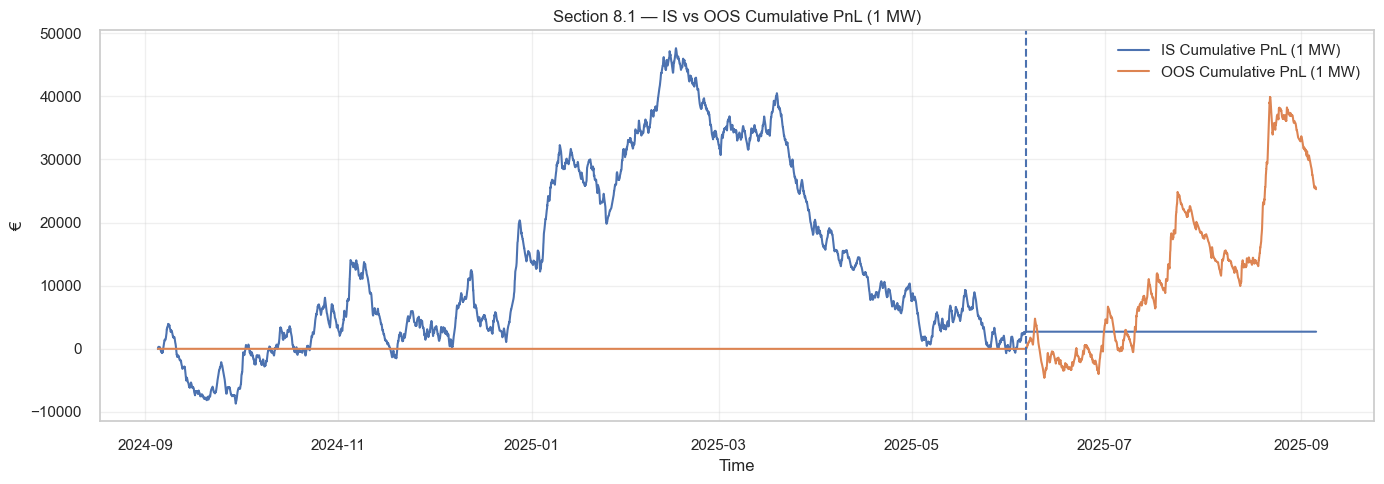


[8.1] OOS Monthly PnL (1 MW):
         OOS_MonthlyPnL
Month                  
2025-06         3824.50
2025-07        13802.51
2025-08        16057.76
2025-09        -8394.47

[8.1] OOS Strategy Exposure (share of bars):
              Share
StrategyType       
MLOnly        78.02
Ensemble      21.98


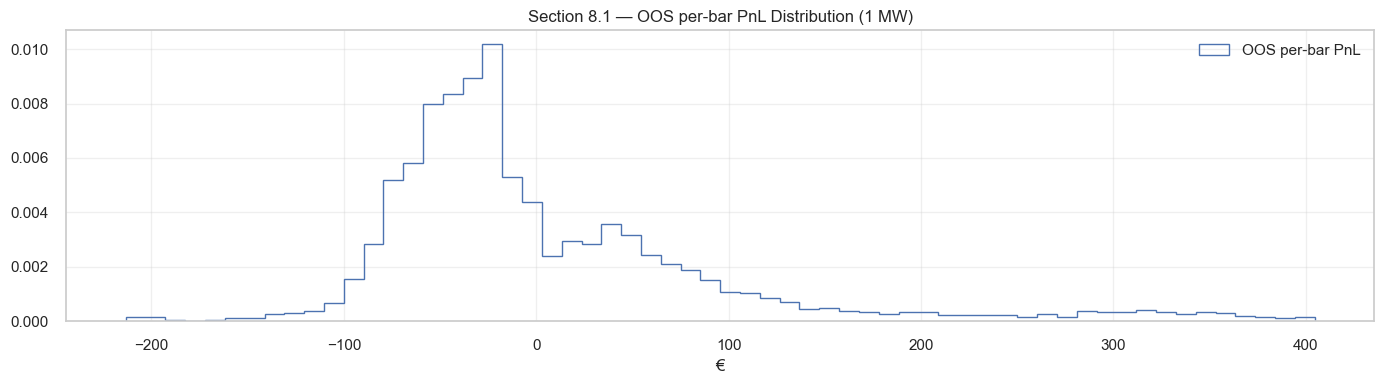


[8.1] Wrote oos_is_summary_8_1.csv


In [30]:
# ========================================= SECTION 8.1 — OOS Split & Core Diagnostics (1 MW) =========================================
#
# Goal
# ----
# Create a clean, reproducible **out-of-sample (OOS)** evaluation for our 1 MW strategy, using only
# the leak-guarded artifacts produced in Sections 6.4 and 7.x. This cell:
# 1) Chooses an IS/OOS split by date (robust defaults + manual override hook).
# 2) Computes KPIs in-sample (IS) vs out-of-sample (OOS) using the **same** per-bar PnL column.
# 3) Plots cumulative PnL for IS and OOS and prints stability tables (monthly, exposure, etc.).
#
# Assumptions carried from Sections 1–7.5
# ---------------------------------------
# - All PnL is at **1 MW** per bar (strict; no sizing).
# - No transaction costs (unknown), so KPIs are cost-free diagnostics.
# - No lookahead: ML signals used for trading are lagged (ML_*_exec), as established in 6.4.
# - Section 8.0 already selected a unified **per-bar PnL** column (PNL_COL), preferring WF_PnL.
#
# Dependencies
# ------------
# - combined_prices_df (master timeline)
# - Column `StartDateTime` (datetime-like)
# - Column `StrategyType` (from 7.1) to describe what was actually traded at each bar
# - Variable `PNL_COL` defined in 8.0 (string with the chosen per-bar PnL column name)
#
# Notes
# -----
# - Matplotlib only; one plot per figure.
# - This is **pure evaluation**; it does not mutate earlier results or add any future-looking info.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- 0) Guards & convenience handles --------------------------------
# Ensure the time column exists; we use it for date splitting, grouping and plotting.
if 'StartDateTime' not in combined_prices_df.columns:
    raise KeyError("[8.1] 'StartDateTime' is missing. Run earlier sections first.")

# Coerce to pandas datetime (idempotent) so downstream filters work reliably.
combined_prices_df['StartDateTime'] = pd.to_datetime(combined_prices_df['StartDateTime'])

# Ensure we know which per-bar PnL series to evaluate.
# Section 8.0 normally sets `PNL_COL` to 'WF_PnL' (preferred) or 'Ensemble_PnL'.
# If the user ran cells out of order, we try to infer that choice here.
if 'PNL_COL' not in globals():
    # Fallback priority: WF_PnL (walk-forward) > Ensemble_PnL (section 6.4)
    PNL_COL = 'WF_PnL' if 'WF_PnL' in combined_prices_df.columns else (
        'Ensemble_PnL' if 'Ensemble_PnL' in combined_prices_df.columns else None
    )
    if PNL_COL is None:
        raise KeyError("[8.1] Could not locate a per-bar PnL column (WF_PnL or Ensemble_PnL). "
                       "Please run Section 8.0 first.")

# Create a typed Series view we will use for *all* KPIs and plots below (strict float).
pnl_series = combined_prices_df[PNL_COL].astype(float)

# ----------------------------- 1) Choose an IS/OOS split ---------------------------------------
# Manual override hook:
# - If the notebook/session defines `OOS_START_DATE` earlier (string or datetime),
#   we respect it; otherwise we compute a data-driven split (last 25% of dates = OOS).
OOS_START_DATE = globals().get('OOS_START_DATE', None)

if OOS_START_DATE is None:
    # Normalize times to midnight so quantiles are on calendar days, not half-hours, etc.
    all_dates = combined_prices_df['StartDateTime'].dt.normalize()

    # 75th percentile date ≈ start of the last quartile of the sample (our OOS window).
    q_date = all_dates.quantile(0.75)

    # Convert to a clean midnight datetime (no timezone change).
    OOS_START_DATE = pd.to_datetime(q_date.date())
else:
    # Normalize user-provided date/time to midnight for consistency.
    OOS_START_DATE = pd.to_datetime(OOS_START_DATE).normalize()

# Boolean masks for OOS (>= split date) and IS (< split date). We keep the full time axis intact.
oos_mask = (combined_prices_df['StartDateTime'] >= OOS_START_DATE)
is_mask  = ~oos_mask

# Add a human-readable label to the main frame (purely for tables/plots; does not affect signals).
combined_prices_df['Set_8x'] = np.where(oos_mask, 'OOS', 'IS')

print(f"[8.1] OOS split: OOS starts at {OOS_START_DATE.date()} "
      f"({int(oos_mask.sum())} bars OOS / {int(is_mask.sum())} bars IS)")

# ----------------------------- 2) KPI helpers ---------------------------------------------------
def _kpis_per_bar(pnl: pd.Series) -> dict:
    """
    Compute per-bar KPIs with 1 MW sizing:

    Definitions (consistent with earlier sections):
    - trades:     number of *non-zero* PnL bars (execution events at 1 MW)
    - total:      sum of PnL over non-zero bars only (easier to interpret per-trade totals)
    - win_rate:   wins / trades (wins are pnl > 0 among non-zero bars)
    - sharpe:     mean / std on non-zero bars (simple, not annualized)
    - payoff:     average win / |average loss| (non-zero bars)
    - expectancy: average PnL per *trade* (non-zero bars)
    - max_dd:     maximum drawdown on the *cumulative* PnL including zero bars
    - calmar:     total cumulative PnL / max_dd (if max_dd > 0), computed on full series order
    """

    # (a) "Trade" view — restrict to bars where there was an actual executed position (PnL != 0)
    s_trades = pnl[pnl != 0].copy()
    trades   = int(s_trades.size)
    total    = float(s_trades.sum())
    wins     = s_trades[s_trades > 0]
    losses   = s_trades[s_trades < 0]
    win_rate = (len(wins) / trades) if trades else np.nan
    sharpe   = (s_trades.mean()/s_trades.std()) if (np.isfinite(s_trades.std()) and s_trades.std() > 0) else np.nan
    payoff   = (wins.mean()/abs(losses.mean())) if len(losses) else np.nan
    expectancy = s_trades.mean() if trades else np.nan

    # (b) "Time-ordered" risk view — compute drawdown on the full series (including zeros)
    s_all = pnl.fillna(0).copy()        # keep every timestamp; zeros preserve temporal structure
    cum   = s_all.cumsum()              # equity curve
    dd    = (cum.cummax() - cum)        # drawdown from running peak
    max_dd = float(dd.max()) if not dd.empty else 0.0
    calmar = (float(cum.iloc[-1]) / max_dd) if (max_dd > 0 and not cum.empty) else np.nan

    return dict(trades=trades, total=total, win_rate=win_rate, sharpe=sharpe,
                payoff=payoff, expectancy=expectancy, max_dd=max_dd, calmar=calmar)

# Build two *aligned* PnL series on the same time axis, zeroing out the "other" side each time.
# This lets us plot IS & OOS equity on the same x-axis and keeps drawdown computation well-defined.
pnl_is  = pnl_series.where(is_mask,  0.0)
pnl_oos = pnl_series.where(oos_mask, 0.0)

# Compute KPI dictionaries for each slice.
k_is  = _kpis_per_bar(pnl_is)
k_oos = _kpis_per_bar(pnl_oos)

# Print a compact KPI summary for both sets.
print("\n[8.1] IS KPIs (per-bar, 1 MW)")
print(f" Trades: {k_is['trades']}, Total: €{k_is['total']:.2f}, "
      f"Win: {k_is['win_rate']*100 if pd.notna(k_is['win_rate']) else 0:.2f}%, "
      f"Sharpe: {k_is['sharpe']:.2f}, Payoff: {k_is['payoff']:.2f}, "
      f"Expect: €{k_is['expectancy']:.2f}, MaxDD: €{k_is['max_dd']:.2f}, Calmar: {k_is['calmar']:.2f}")

print("\n[8.1] OOS KPIs (per-bar, 1 MW)")
print(f" Trades: {k_oos['trades']}, Total: €{k_oos['total']:.2f}, "
      f"Win: {k_oos['win_rate']*100 if pd.notna(k_oos['win_rate']) else 0:.2f}%, "
      f"Sharpe: {k_oos['sharpe']:.2f}, Payoff: {k_oos['payoff']:.2f}, "
      f"Expect: €{k_oos['expectancy']:.2f}, MaxDD: €{k_oos['max_dd']:.2f}, Calmar: {k_oos['calmar']:.2f}")

# ----------------------------- 3) Plots: IS vs OOS equity curves -------------------------------
# Prepare cumulative curves on the shared timeline.
ts      = combined_prices_df['StartDateTime']
cum_is  = pnl_is.cumsum()
cum_oos = pnl_oos.cumsum()

plt.figure(figsize=(14, 5))
plt.plot(ts, cum_is,  label='IS Cumulative PnL (1 MW)')
plt.plot(ts, cum_oos, label='OOS Cumulative PnL (1 MW)')
plt.axvline(OOS_START_DATE, linestyle='--')  # vertical guide for the split date
plt.title("Section 8.1 — IS vs OOS Cumulative PnL (1 MW)")
plt.xlabel("Time"); plt.ylabel("€")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# ----------------------------- 4) OOS Monthly table & exposure/stability -----------------------
# Create an OOS-only mini-frame with the per-bar PnL and the chosen StrategyType, for diagnostics.
oos_df = combined_prices_df.loc[oos_mask, ['StartDateTime', PNL_COL, 'StrategyType']].copy()

# Month label for each row (period type keeps calendar grouping clean).
oos_df['Month'] = oos_df['StartDateTime'].dt.to_period('M')

# Monthly aggregation of OOS PnL to inspect stability/drift by calendar month.
oos_monthly = oos_df.groupby('Month')[PNL_COL].sum().to_frame('OOS_MonthlyPnL')
print("\n[8.1] OOS Monthly PnL (1 MW):")
print(oos_monthly.round(2).to_string())

# How often each strategy bucket was *active* (share of OOS rows) — exposure profile.
oos_exposure = oos_df['StrategyType'].value_counts(normalize=True).rename('Share').to_frame()
print("\n[8.1] OOS Strategy Exposure (share of bars):")
print((oos_exposure * 100).round(2).to_string())

# (Optional but informative) — distribution of per-bar OOS PnL for shape/outlier checks.
plt.figure(figsize=(14, 4))
data = oos_df[PNL_COL].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
if not data.empty:
    plt.hist(data, bins=60, density=True, histtype='step', label='OOS per-bar PnL')
    plt.title("Section 8.1 — OOS per-bar PnL Distribution (1 MW)")
    plt.xlabel("€"); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()
else:
    print("\n[8.1] OOS distribution skipped (no OOS data).")

# ----------------------------- 5) Save small summary for reporting -----------------------------
# Export a tiny CSV with the IS/OOS KPI dictionaries for later reporting/appendix use.
summary_8_1 = pd.DataFrame([
    dict(Set='IS',  **{k: v for k, v in k_is.items()}),
    dict(Set='OOS', **{k: v for k, v in k_oos.items()}),
])
summary_8_1.to_csv("oos_is_summary_8_1.csv", index=False)
print("\n[8.1] Wrote oos_is_summary_8_1.csv")



[8.2] Counterfactual Impact Summary — target units: Moneypoint_3_Generator_Unit_OUT, Coolkeeragh_ESB_CCGT_Generator_Unit_OUT
 Occurrences: 1,538
 Avg Spread (€/MWh): 21.05
 Avg PnL (€): 21.05
 Hit Rate (%): 42.33
 Sharpe Ratio: 0.21


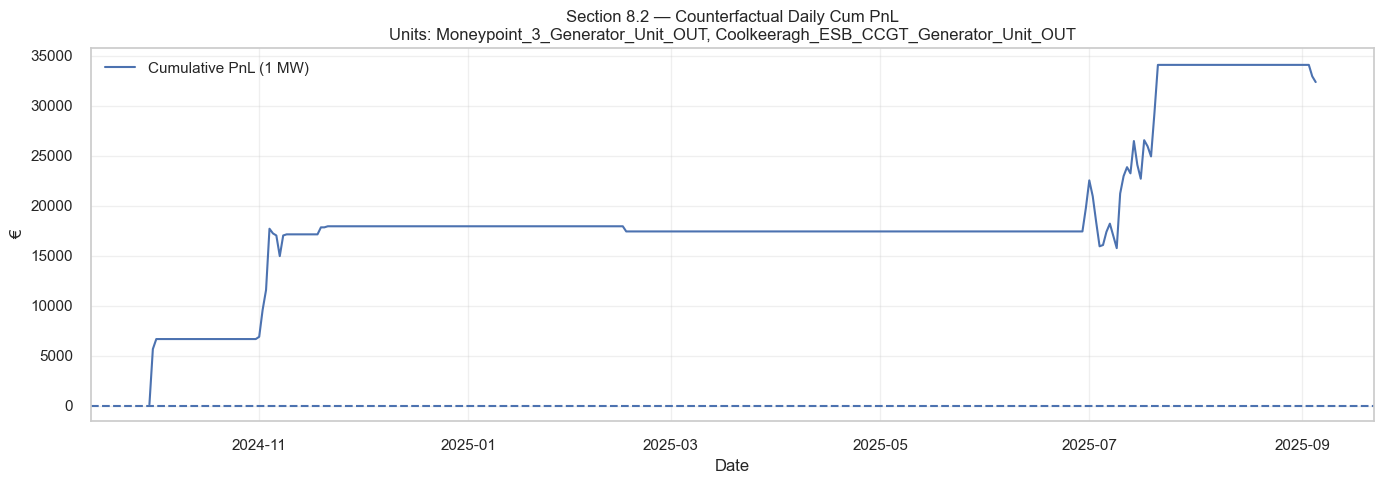

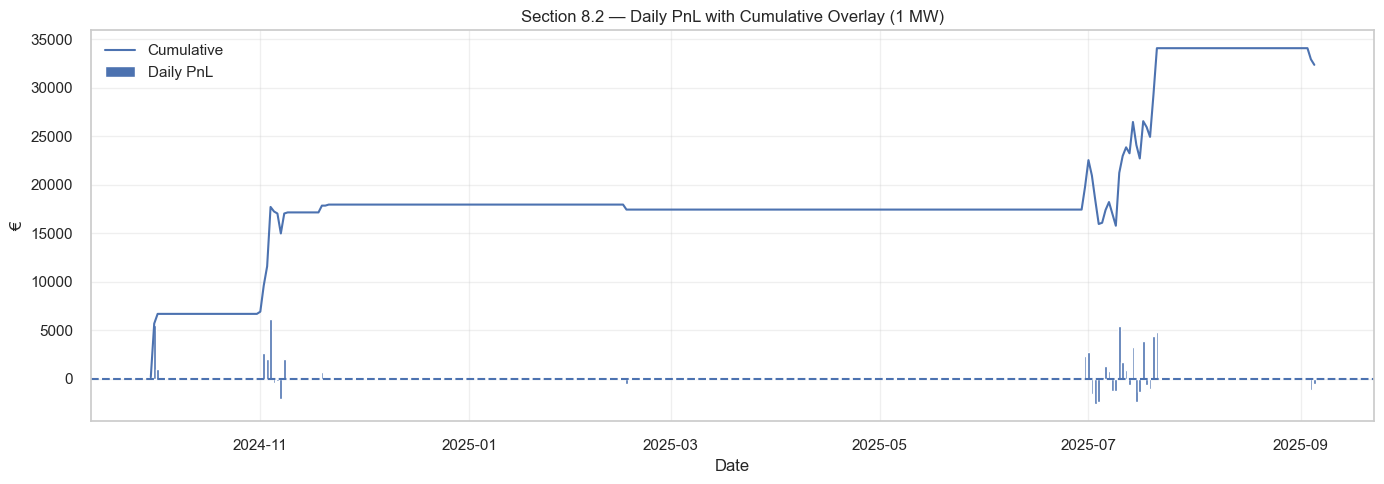


[8.2] Top Exact-Combo Leaders (min count = 10 )


Combo  \
0                                                                                                                  Aghada_2_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Great_Island_CCGT_OUT + Moneypoint_1_Generator_Unit_OUT   
1                                                                                                                                                      Aghada_2_Generator_Unit_OUT + B31_OUT + B32_OUT + GT6_OUT + Moneypoint_3_Generator_Unit_OUT   
2                                                                                                                                        B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_1_Generator_Unit_OUT + Shellybanks_PBB_OUT   
3                                                                             Aghada_2_Generator_Unit_OUT + B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Great_Island_CCGT_OUT + HPC1_Generation_Unit_OUT + Moneypoint_1_Generator_Unit_OUT   
4                                                                                                                                          Aghada_2_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_1_Generator_Unit_OUT   
5                                                                                                B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_1_Generator_Unit_OUT + Moneypoint_3_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT   
6                                      B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Dublin_Bay_Generator_Unit_OUT + GT6_OUT + Moneypoint_2_Generator_Unit_OUT + Moneypoint_3_Generator_Unit_OUT + Shellybanks_PBA_OUT + Shellybanks_PBB_OUT   
7  B31_OUT + B32_OUT + Bord_Gais_ROI_-_Whitegate_Generator_Unit_OUT + GT6_OUT + HPC1_Generation_Unit_OUT + Moneypoint_1_Generator_Unit_OUT + Moneypoint_3_Generator_Unit_OUT + Shellybanks_PBA_OUT + Shellybanks_PBB_OUT + VPL_Generation_Unit_OUT   
8                                                                                                                                                  B31_OUT + Moneypoint_2_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT + VPL_Generation_Unit_OUT   
9                                                                                                                         B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + GT6_OUT + HPC1_Generation_Unit_OUT + Moneypoint_3_Generator_Unit_OUT   

   Count  Avg PnL (€)    Sharpe  Hit Rate (%)  
0     27   279.180741  2.340178     96.296296  
1     13   142.916923  1.168944     84.615385  
2     13   133.453077  4.184665    100.000000  
3     28   112.624286  1.121723     92.857143  
4    167   106.882874  0.825355     65.269461  
5    102    97.473039  0.676811     61.764706  
6     13    95.877692  1.356519    100.000000  
7     30    90.481667  1.537384     90.000000  
8     15    90.288000  0.915787     73.333333  
9     27    77.682222  0.979680     74.074074

In [31]:
# ============================ SECTION 8.2 — Counterfactual Combo Analysis ============================
# Goal:
# - Diagnose performance when *specific outage units are jointly active*.
# - Relies on RULE_ACTIVE__<combo> flags built earlier (6.3/6.4) and the unified per-bar PnL (PNL_COL) from 8.0.
# - Read-only: never mutates the baseline results or sizing (still 1 MW everywhere).
# ================================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) Guards & light prep ----------
# Ensure we have a timestamp column and it is typed as datetime (needed for resampling/plots)
if 'StartDateTime' not in combined_prices_df.columns:
    raise KeyError("[8.2] StartDateTime missing. Please run earlier sections.")
combined_prices_df['StartDateTime'] = pd.to_datetime(combined_prices_df['StartDateTime'])

# Ensure realized spread exists; if not, rebuild from DAM and Imbalance prices (purely for reference)
if 'Spread_DAMtoBM' not in combined_prices_df.columns:
    combined_prices_df['Spread_DAMtoBM'] = (
        combined_prices_df['PriceImbalance'].astype(float) - combined_prices_df['PriceDAM'].astype(float)
    )

# Pick the per-bar PnL column chosen in §8.0; fall back to WF_PnL → Ensemble_PnL if needed
if 'PNL_COL' not in globals():
    PNL_COL = 'WF_PnL' if 'WF_PnL' in combined_prices_df.columns else (
        'Ensemble_PnL' if 'Ensemble_PnL' in combined_prices_df.columns else None
    )
if PNL_COL is None:
    raise KeyError("[8.2] No PnL column available (WF_PnL/Ensemble_PnL). Run §§6.4–7 first.")

# ---------- 1) Collect rule-active columns & map to unit lists ----------
# Gather all boolean “rule active” columns built earlier (pattern: RULE_ACTIVE__A + B + C)
rule_cols = [c for c in combined_prices_df.columns if c.startswith('RULE_ACTIVE__')]

def _units_from_col(col_name: str) -> list:
    """
    Convert column name 'RULE_ACTIVE__A + B + C' -> ['A','B','C'] for later set logic.
    """
    return [u.strip() for u in col_name.replace('RULE_ACTIVE__', '').split(' + ')]

# Pre-map each rule-active column to its list of units to avoid recomputing in the row loop
rule_col_to_units = {c: _units_from_col(c) for c in rule_cols}

def _extract_unit_set(row) -> list | None:
    """
    For one timestamp (row), collect units from all *active* rule columns and
    return a unique, sorted list. If nothing is active, return None.
    """
    active_units = []
    for c in rule_cols:
        if bool(row.get(c, False)):                  # rule combo is active at this bar
            active_units.extend(rule_col_to_units[c])# add all units that define this combo
    return sorted(set(active_units)) if active_units else None

# Build a list-of-units per row so we can filter on exact/superset combos
combined_prices_df['ComboList'] = combined_prices_df.apply(_extract_unit_set, axis=1)

# ---------- 2) Choose the “counterfactual” target (edit as desired) ----------
# Example target: bars where BOTH of these units are out at the same time.
target_units = [
    'Moneypoint_3_Generator_Unit_OUT',
    'Coolkeeragh_ESB_CCGT_Generator_Unit_OUT',
]

def _superset_match(x: list | None, target: list) -> bool:
    """
    Superset check: return True if x contains *all* target units (x may have more).
    """
    return isinstance(x, list) and set(target).issubset(set(x))

# Boolean mask for bars where every target unit is present (superset criterion)
mask_cf = combined_prices_df['ComboList'].apply(lambda x: _superset_match(x, target_units))
# Slice the master DF down to the counterfactual subset only
counterfactual_df = combined_prices_df.loc[mask_cf].copy()

if counterfactual_df.empty:
    # If nothing matches, inform the user (no changes to state)
    print("\n[8.2] No rows match the example counterfactual combo; "
          "adjust `target_units` to another set of outages.")
else:
    # ---------- 3) Summary impact stats for the chosen target ----------
    # Describe realized spread & PnL behavior during these target bars (1 MW, per-bar PnL)
    avg_spread = float(counterfactual_df['Spread_DAMtoBM'].mean())
    pnl_mean   = float(counterfactual_df[PNL_COL].mean())
    pnl_std    = float(counterfactual_df[PNL_COL].std()) if counterfactual_df[PNL_COL].std() is not None else np.nan
    sharpe     = (pnl_mean / pnl_std) if (np.isfinite(pnl_std) and pnl_std > 0) else np.nan
    hit_rate   = float((counterfactual_df[PNL_COL] > 0).mean() * 100.0)

    impact_summary = {
        "Occurrences": int(len(counterfactual_df)),   # how many bars match the target combo
        "Avg Spread (€/MWh)": avg_spread,             # average realized spread
        "Avg PnL (€)": pnl_mean,                      # mean per-bar PnL at 1 MW
        "Hit Rate (%)": hit_rate,                     # % bars with positive PnL
        "Sharpe Ratio": sharpe,                       # simple Sharpe proxy on per-bar PnL
    }

    print("\n[8.2] Counterfactual Impact Summary — target units:", ", ".join(target_units))
    for k, v in impact_summary.items():
        if isinstance(v, (int, np.integer)):
            print(f" {k}: {v:,d}")
        else:
            print(f" {k}: {v:.2f}")

    # ---------- 4) Plots (matplotlib only; one plot per figure) ----------
    # A) Daily cumulative PnL on the target subset (smooths intraday noise)
    cf_daily = (
        counterfactual_df
            .set_index('StartDateTime')[PNL_COL]
            .resample('1D')     # sum to daily PnL
            .sum()
            .cumsum()           # cumulative curve (equity)
    )
    plt.figure(figsize=(14, 5))
    plt.plot(cf_daily.index, cf_daily.values, label='Cumulative PnL (1 MW)')
    plt.axhline(0, linestyle='--')
    plt.title(f"Section 8.2 — Counterfactual Daily Cum PnL\nUnits: {', '.join(target_units)}")
    plt.xlabel("Date"); plt.ylabel("€")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    # B) Daily bars with cumulative overlay to see both bursts and long-run effect together
    daily = (
        counterfactual_df
        .set_index('StartDateTime')[PNL_COL]
        .resample('1D').sum()
    )
    cum = daily.cumsum()
    plt.figure(figsize=(14, 5))
    plt.bar(daily.index, daily.values, label='Daily PnL')
    plt.plot(cum.index, cum.values, label='Cumulative', linewidth=1.5)
    plt.axhline(0, linestyle='--')
    plt.title("Section 8.2 — Daily PnL with Cumulative Overlay (1 MW)")
    plt.xlabel("Date"); plt.ylabel("€")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    # ---------- 5) Rank *exact* combos by Avg PnL (optional leaderboard) ----------
    # Here we evaluate *exact* unit sets (not supersets) and require a minimum count for stability.
    MIN_COUNT = 10  # stability guard: avoid highlighting combos seen only a handful of times

    # Convert lists to tuples so they are hashable for groupby-like operations
    combo_series = combined_prices_df['ComboList'].dropna().apply(tuple)
    unique_sets  = combo_series.unique()

    rows = []
    for s in unique_sets:
        # exact-match selector: active set must equal this candidate set (order-agnostic)
        sel  = (combined_prices_df['ComboList'].apply(lambda x: isinstance(x, list) and set(x) == set(s)))
        df_s = combined_prices_df.loc[sel, [PNL_COL]]
        if len(df_s) >= MIN_COUNT:
            avg  = float(df_s[PNL_COL].mean())
            std  = float(df_s[PNL_COL].std()) if df_s[PNL_COL].std() is not None else np.nan
            shar = (avg / std) if (np.isfinite(std) and std > 0) else np.nan
            hit  = float((df_s[PNL_COL] > 0).mean() * 100.0)
            rows.append({
                "Combo": " + ".join(s),     # human-readable descriptor of the unit set
                "Count": int(len(df_s)),    # sample size for this exact combo
                "Avg PnL (€)": avg,         # per-bar average PnL at 1 MW
                "Sharpe": shar,             # simple Sharpe proxy at the per-bar level
                "Hit Rate (%)": hit         # % of winning bars
            })

    # Build a leaderboard table sorted by Avg PnL (tie-break by Count)
    combo_stats_df = (
        pd.DataFrame(rows)
        .sort_values(['Avg PnL (€)', 'Count'], ascending=[False, False])
        .reset_index(drop=True)
    )

    if not combo_stats_df.empty:
        print("\n[8.2] Top Exact-Combo Leaders (min count =", MIN_COUNT, ")")
        # display() if available (Jupyter); otherwise print a plain table
        try:
            display(combo_stats_df.head(10))
        except Exception:
            print(combo_stats_df.head(10).to_string(index=False))
    else:
        print(f"\n[8.2] No exact combos met MIN_COUNT={MIN_COUNT}. Consider lowering the threshold or broadening targets.")




[8.3] Top 10 combos by AvgSpread (support ≥ 25 bars):


AvgSpread  \
ComboName                                                                                                                                                                                                                                                     
Aghada_2_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Great_Island_CCGT_OUT + Moneypoint_1_Generator_Unit_OUT                                                                                                                  279.180741   
Aghada_2_Generator_Unit_OUT + B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Great_Island_CCGT_OUT + HPC1_Generation_Unit_OUT + Moneypoint_1_Generator_Unit_OUT                                                                             112.624286   
Aghada_2_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_1_Generator_Unit_OUT                                                                                                                                          106.882874   
B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_1_Generator_Unit_OUT + Moneypoint_3_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT                                                                                                 97.473039   
B31_OUT + B32_OUT + Bord_Gais_ROI_-_Whitegate_Generator_Unit_OUT + GT6_OUT + HPC1_Generation_Unit_OUT + Moneypoint_1_Generator_Unit_OUT + Moneypoint_3_Generator_Unit_OUT + Shellybanks_PBA_OUT + Shellybanks_PBB_OUT + VPL_Generation_Unit_OUT   90.481667   
B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + GT6_OUT + HPC1_Generation_Unit_OUT + Moneypoint_3_Generator_Unit_OUT                                                                                                                          77.682222   
B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_3_Generator_Unit_OUT + Shellybanks_PBA_OUT + Shellybanks_PBB_OUT                                                                                                                   77.331905   
GT6_OUT + Great_Island_CCGT_OUT + Moneypoint_1_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Moneypoint_3_Generator_Unit_OUT + VPL_Generation_Unit_OUT                                                                                   69.718000   
B31_OUT + GT6_OUT + Moneypoint_2_Generator_Unit_OUT + Moneypoint_3_Generator_Unit_OUT + Shellybanks_PBA_OUT + Shellybanks_PBB_OUT + VPL_Generation_Unit_OUT                                                                                       66.100417   
Aghada_2_Generator_Unit_OUT + B31_OUT + GT6_OUT + Great_Island_CCGT_OUT + HPC1_Generation_Unit_OUT + Moneypoint_1_Generator_Unit_OUT                                                                                                              60.712581   

                                                                                                                                                                                                                                                  SpreadStd  \
ComboName                                                                                                                                                                                                                                                     
Aghada_2_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Great_Island_CCGT_OUT + Moneypoint_1_Generator_Unit_OUT                                                                                                                  119.298940   
Aghada_2_Generator_Unit_OUT + B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Great_Island_CCGT_OUT + HPC1_Generation_Unit_OUT + Moneypoint_1_Generator_Unit_OUT                                                                             100.402963   
Aghada_2_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_1_Generator_Unit_OUT                                                          

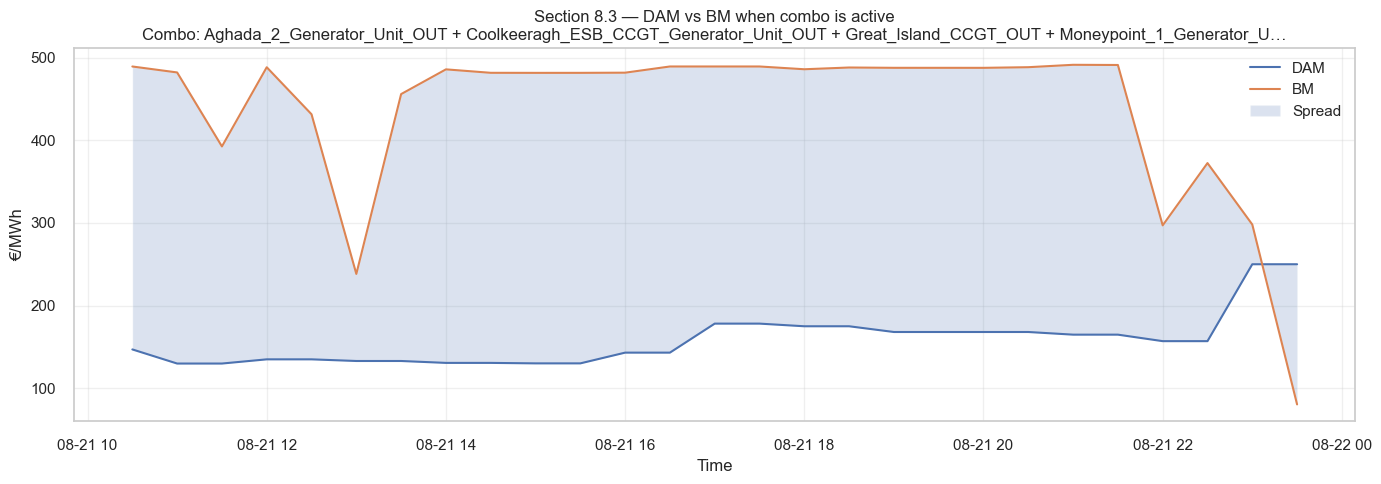

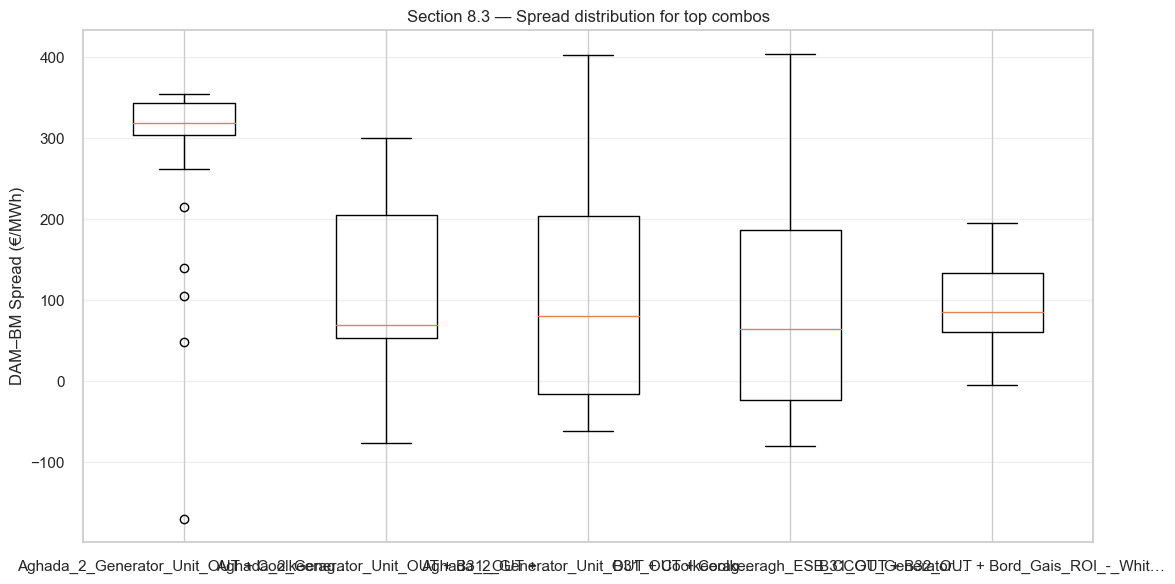

In [32]:
# =============================== 8.3 — Price-Shape Validation by Outage Combinations ===============================
# Goal:
# - Sanity–check that combos which look profitable also make sense in prices.
# - Show DAM vs BM when a top combo is active, and compare spread distributions across top combos.
# Inputs:
# - combined_prices_df (built through Sections 1 → 7.5)
# - RULE_ACTIVE__<combo> boolean columns (from 6.3/6.4)
# - PNL_COL chosen in Section 8.0 (WF_PnL preferred; always 1 MW sizing)
# Notes:
# - If ComboList (created in 8.2) is missing, we reconstruct it from RULE_ACTIVE__ columns.
# - Descriptive only — does not mutate state or change results anywhere else.
# ===================================================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) Guards & setup ----------
# Ensure we have a timestamp for filtering/plotting; fail fast if absent
if 'StartDateTime' not in combined_prices_df.columns:
    raise KeyError("[8.3] StartDateTime missing. Please run earlier sections first.")

# Work on a copy to avoid accidental mutation
df_shape = combined_prices_df.copy()
# Force datetime dtype (resampling/plotting relies on this)
df_shape['StartDateTime'] = pd.to_datetime(df_shape['StartDateTime'])

# Ensure a consistent per-bar PnL column (picked in 8.0); fallback to WF_PnL → Ensemble_PnL; otherwise create 0€ placeholder
if 'PNL_COL' not in globals():
    _fallbacks = ['WF_PnL', 'Ensemble_PnL']
    PNL_COL = next((c for c in _fallbacks if c in df_shape.columns), None)
    if PNL_COL is None:
        # Keep the section runnable (plots/tables will still render but show zeros)
        PNL_COL = 'PNL_derived_zero'
        df_shape[PNL_COL] = 0.0
        print("[8.3] WARNING: No WF_PnL/Ensemble_PnL found; using 0€ placeholder PnL.")

# ---------- 1) Ensure we have a list of active units per bar (ComboList) ----------
# If 8.2 already created ComboList, reuse it. Otherwise derive it from RULE_ACTIVE__* flags.
if 'ComboList' not in df_shape.columns or df_shape['ComboList'].isna().all():
    # Collect all boolean “rule active” columns (each column corresponds to a unit-combo)
    rule_cols = [c for c in df_shape.columns if c.startswith('RULE_ACTIVE__')]

    def _units_from_rulecol(col_name: str) -> list[str]:
        """Turn 'RULE_ACTIVE__A + B + C' → ['A','B','C'] (keeps original order)."""
        return col_name.replace('RULE_ACTIVE__', '').split(' + ')

    # Pre-map each RULE_ACTIVE__ column to its list of units for faster row-wise evaluation
    rule_col_to_units = {c: _units_from_rulecol(c) for c in rule_cols}

    def _extract_unit_set(row) -> list | None:
        """For a row, collect units from all *active* rule columns; dedupe & sort. Return None if none active."""
        units = []
        for c in rule_cols:
            if c in row and bool(row[c]):             # this combo is active at this bar
                units.extend(rule_col_to_units[c])    # add all units belonging to the combo
        # Return sorted unique list for stable labeling; None if empty
        return sorted(set(units)) if units else None

    # Build ComboList column: a list of active units (or None) for each timestamp
    df_shape['ComboList'] = df_shape.apply(_extract_unit_set, axis=1)

# Keep only rows where at least one outage unit is active (we’re validating *combination* periods)
df_shape = df_shape[df_shape['ComboList'].notna()].copy()

# If nothing is left, we can’t validate price shapes by combos
if df_shape.empty:
    print("\n[8.3] No rows with outage combinations found — run Sections 6.3/6.4 (rules) first.")
else:
    # ---------- 2) Build a human-readable combo label ----------
    # Convert list of units like ['A','B','C'] → "A + B + C"; sorted for canonical naming
    df_shape['ComboName'] = df_shape['ComboList'].apply(
        lambda x: " + ".join(sorted(x)) if isinstance(x, list) else None
    )

    # ---------- 3) Aggregate diagnostics per combo ----------
    # Summarize spread and realized per-bar PnL (1 MW) for each *exact* unit-set combo
    agg = (
        df_shape.groupby('ComboName')
        .agg(
            AvgSpread=('Spread_DAMtoBM', 'mean'),   # mean DAM–BM spread when this exact combo is active
            SpreadStd=('Spread_DAMtoBM', 'std'),    # spread volatility
            AvgPnL=(PNL_COL, 'mean'),               # mean realized per-bar PnL at 1 MW
            Occurrences=(PNL_COL, 'count'),         # number of bars where this combo is active
            AvgDAM=('PriceDAM', 'mean'),            # average DAM level during combo activity
            AvgBM=('PriceImbalance', 'mean')        # average BM level during combo activity
        )
        .sort_values('AvgSpread', ascending=False)  # show combos with widest positive spreads first
    )

    # Minimum support guard to avoid tiny-sample artifacts (tuneable)
    MIN_OCC = 25
    agg = agg[agg['Occurrences'] >= MIN_OCC]

    if agg.empty:
        print(f"\n[8.3] No combos meet the minimum occurrence threshold (MIN_OCC={MIN_OCC}).")
    else:
        # Print or display (notebook) the top rows for quick inspection
        print("\n[8.3] Top 10 combos by AvgSpread (support ≥", MIN_OCC, "bars):")
        try:
            display(agg.head(10))
        except Exception:
            print(agg.head(10).round(2).to_string())

        # ---------- 4) DAM vs BM time series for the single top combo ----------
        # Pick the best combo by AvgSpread and plot its DAM/BM series to validate spread shape visually
        top_combo = agg.index[0]
        sel = df_shape[df_shape['ComboName'] == top_combo].copy()

        plt.figure(figsize=(14, 5))
        plt.plot(sel['StartDateTime'], sel['PriceDAM'], label='DAM')
        plt.plot(sel['StartDateTime'], sel['PriceImbalance'], label='BM')
        # Shade the area between DAM and BM to visually emphasize the spread
        plt.fill_between(
            sel['StartDateTime'],
            sel['PriceDAM'],
            sel['PriceImbalance'],
            alpha=0.2,
            label='Spread'
        )
        ttl = f"Section 8.3 — DAM vs BM when combo is active\nCombo: {top_combo[:120]}{'…' if len(top_combo)>120 else ''}"
        plt.title(ttl)
        plt.xlabel("Time"); plt.ylabel("€/MWh")
        plt.legend(); plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

        # ---------- 5) Spread distribution comparison for top-N combos ----------
        # Compare the distribution of spreads across the top-N combos using a boxplot
        topN = min(5, len(agg))
        top_list = agg.head(topN).index.tolist()

        plt.figure(figsize=(12, 6))
        # Collect spread arrays for each selected combo
        data_for_box = [df_shape.loc[df_shape['ComboName'] == c, 'Spread_DAMtoBM'].values for c in top_list]
        # Trim labels for readability in the figure
        short_labels = [c if len(c) <= 40 else (c[:40] + '…') for c in top_list]
        plt.boxplot(data_for_box, labels=short_labels)
        plt.title("Section 8.3 — Spread distribution for top combos")
        plt.ylabel("DAM–BM Spread (€/MWh)")
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout(); plt.show()


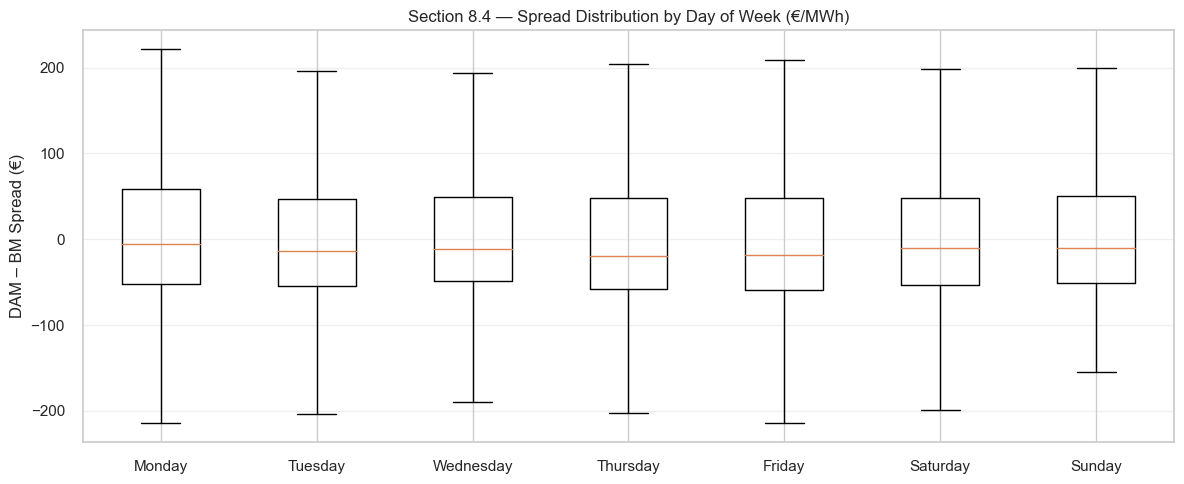


[8.4] Correlation with Spread (available drivers):


Spread_DAMtoBM  TotalOutageMW  DemandForecast  Meteo_ISEMWIND_DAM  PriceImbalance
Spread_DAMtoBM            1.000000       0.019991        0.017879           -0.024496        0.804003
TotalOutageMW             0.019991       1.000000       -0.179434           -0.031103       -0.069102
DemandForecast            0.017879      -0.179434        1.000000            0.152018        0.373267
Meteo_ISEMWIND_DAM       -0.024496      -0.031103        0.152018            1.000000       -0.231514
PriceImbalance            0.804003      -0.069102        0.373267           -0.231514        1.000000

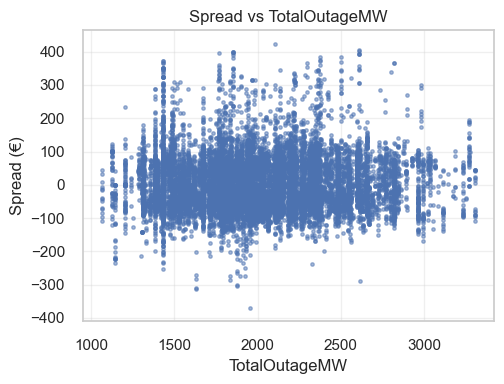

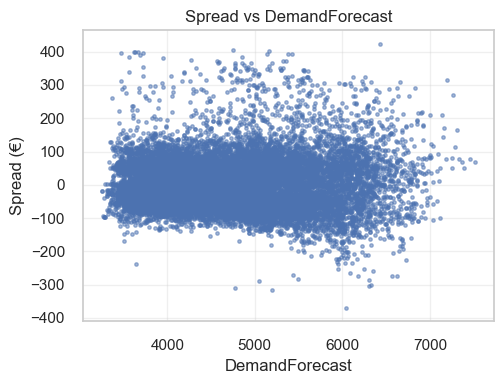

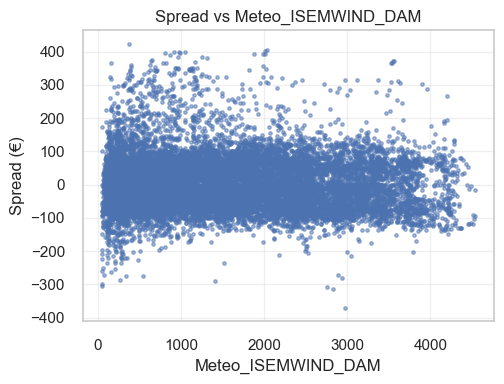

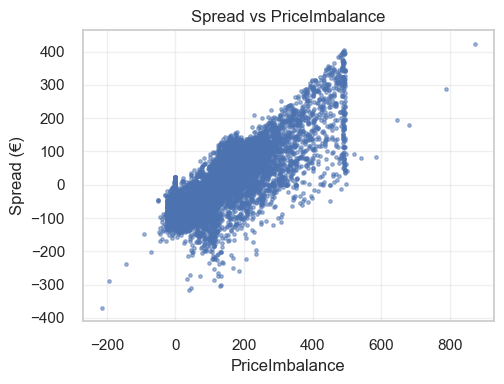


[8.4] Mean Spread by StrategyType (diagnostic only):


MeanSpread (€)
StrategyType                
Playbook           31.500000
Ensemble           21.259549
MLOnly             -3.172818

In [33]:
# ================================
# SECTION 8.4 — Economic Interpretation
# --------------------------------
# Purpose:
#   Sanity-check that the realized DAM–BM spread co-moves with basic system drivers
#   (outages, demand, wind). Purely diagnostic: no state changes, strict 1 MW context.
# Design:
#   - Uses realized per-bar PnL column selected in §8.0 (WF_PnL preferred).
#   - Matplotlib only; one chart per figure.
#   - Robust to missing optional columns (keeps what exists).
# ================================

import numpy as np                     # numerical helpers (NaN checks, arrays)
import pandas as pd                    # tabular wrangling
import matplotlib.pyplot as plt        # plotting (matplotlib only, per spec)

# ---------- 0) Guards & column selection ----------

# Ensure we have a timestamp column and it is typed as pandas datetime
if 'StartDateTime' not in combined_prices_df.columns:                 # fail early if time index missing
    raise KeyError("[8.4] StartDateTime missing. Run earlier sections first.")
combined_prices_df['StartDateTime'] = pd.to_datetime(                  # normalize to Timestamp dtype
    combined_prices_df['StartDateTime']
)

# Decide which realized per-bar PnL to *optionally* include in the diagnostics table.
# Preference matches §8.0: WF_PnL (walk-forward) > Ensemble_PnL (from §6.4). If neither, keep None.
PNL_COL = 'WF_PnL' if 'WF_PnL' in combined_prices_df.columns else (
    'Ensemble_PnL' if 'Ensemble_PnL' in combined_prices_df.columns else None
)

# List of columns we’d *like* to analyze. Many are optional, so we’ll subset to those that exist.
econ_cols = [
    'StartDateTime',            # time key for grouping/plots
    'Spread_DAMtoBM',           # realized spread (€/MWh): PriceImbalance - PriceDAM (built earlier)
    'PriceDAM',                 # DAM level (€/MWh) — for price-shape sanity
    'PriceImbalance',           # BM/Imbalance level (€/MWh)
    'TotalOutageMW',            # system-wide MW offline (if created in earlier sections)
    'TotalPercentUnavailable',  # optional % of capacity unavailable
    'DemandForecast',           # demand proxy (if available)
    'Meteo_ISEMWIND_DAM',       # wind proxy (if available)
    'StrategyType'              # what bucket was active (Ensemble / MLOnly / RuleOnly / None)
]
if PNL_COL is not None:                   # include realized PnL column only if we actually have it
    econ_cols.append(PNL_COL)

# Keep only columns that truly exist in the master frame (robust to partially-run notebooks)
avail_cols = [c for c in econ_cols if c in combined_prices_df.columns]

# The spread is mandatory for this section; stop if it’s not present
if 'Spread_DAMtoBM' not in avail_cols:
    raise KeyError("[8.4] Spread_DAMtoBM not found. Create it earlier (PriceImbalance - PriceDAM).")

# Build a compact working dataframe with the available columns and drop rows with any missing values
# (ensures comparisons use aligned, complete observations only)
df_econ = combined_prices_df[avail_cols].dropna().copy()

# ---------- 1) Derive calendar fields for stratification ----------

# Day-of-week label used for the boxplot (makes weekday comparison human-readable)
df_econ['DayOfWeek'] = df_econ['StartDateTime'].dt.day_name()

# Month string (YYYY-MM) — kept for potential seasonal drill-downs (not plotted here)
df_econ['Month'] = df_econ['StartDateTime'].dt.to_period('M').astype(str)

# ---------- 2) Spread distribution by weekday (boxplot) ----------

plt.figure(figsize=(12, 5))                                           # one figure (per spec)
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']  # fixed order
# Collect the spread values per weekday in the defined order; empty arrays if a weekday is absent
box_data = [df_econ.loc[df_econ['DayOfWeek'] == d, 'Spread_DAMtoBM'].values for d in weekday_order]
plt.boxplot(box_data, labels=weekday_order, showfliers=False)         # boxplot: hide extreme fliers for clarity
plt.title("Section 8.4 — Spread Distribution by Day of Week (€/MWh)") # descriptive title
plt.ylabel("DAM – BM Spread (€)")                                     # axis label units
plt.grid(True, axis='y', alpha=0.3)                                   # light grid on y for readability
plt.tight_layout()                                                    # tidy margins
plt.show()                                                            # render figure

# ---------- 3) Simple correlations between Spread and available drivers ----------

# Drivers we’ll attempt to correlate with the spread; filter to those present after dropna()
driver_candidates = ['TotalOutageMW', 'DemandForecast', 'Meteo_ISEMWIND_DAM', 'PriceImbalance']
drivers = [c for c in driver_candidates if c in df_econ.columns]      # only keep installed drivers

if drivers:
    # Build a small correlation matrix with Spread plus the available drivers
    corr_df = df_econ[['Spread_DAMtoBM'] + drivers].corr()

    print("\n[8.4] Correlation with Spread (available drivers):")     # header for the table
    # Nice display in notebooks; safe print fallback otherwise
    try:
        display(corr_df)
    except Exception:
        print(corr_df)

    # Quick scatterplots for each driver vs Spread (compact, one small figure per driver)
    for col in drivers:
        plt.figure(figsize=(5.2, 4.0))                                # small, consistent size
        plt.scatter(                                                  
            df_econ[col],                                            # x: driver
            df_econ['Spread_DAMtoBM'],                               # y: realized spread
            s=6, alpha=0.5                                           # tiny semi-transparent dots
        )
        plt.title(f"Spread vs {col}")                                 # chart title
        plt.xlabel(col)                                               # x label is the driver’s name
        plt.ylabel("Spread (€)")                                      # y label with units
        plt.grid(True, alpha=0.3)                                     # light grid
        plt.tight_layout()                                            # clean layout
        plt.show()                                                    # render figure
else:
    # If no driver columns were present in the data, note that the correlation step is skipped
    print("\n[8.4] No driver columns available for correlation (skipped).")

# ---------- 4) (Optional) Strategy-type overlay check ----------

# If StrategyType exists in this working set, show mean spread per bucket
# (useful to confirm that Ensemble tends to appear in higher-spread regimes)
if 'StrategyType' in df_econ.columns:
    strat_means = (df_econ
                   .groupby('StrategyType')['Spread_DAMtoBM']         # group by bucket (Ensemble / MLOnly / etc.)
                   .mean()                                            # average realized spread per bucket
                   .sort_values(ascending=False))                     # sort: highest mean spread first

    print("\n[8.4] Mean Spread by StrategyType (diagnostic only):")   # label output
    try:
        display(strat_means.to_frame("MeanSpread (€)"))               # nice table in notebooks
    except Exception:
        print(strat_means)                                            # safe text fallback

# Notes:
# • This cell is purely diagnostic: it *reads* realized quantities (spread, prices, drivers) and
#   optionally the realized per-bar PnL, but does not modify any earlier results.
# • All numbers are per-MW (1 MW sizing) consistent with the project spec.
# • Charts are matplotlib-only and one figure per plot, as required.


In [34]:
# ============================================== SECTION 8.5 — Confidence Scoring (Rule informed) ==============================================
# Goal
# ----
# Build an interpretable *confidence score* per bar for DIAGNOSTICS ONLY (we do NOT rescale trades here).
# The score blends three ex-ante elements, all shifted/constructed to avoid lookahead:
#   (a) trailing win rate of the *top* active rule combo,
#   (b) recent spread volatility (lower vol → higher confidence),
#   (c) rule overlap (how many outage-rule combos agree).
#
# Consistency
# -----------
# - Works off Section 6.4 signals and Section 7 walk-forward outputs.
# - Uses the unified per-bar realized PnL column `PNL_COL` selected in §8.0 (1 MW normalization).
# - Degrades gracefully if rules/weights are missing (still computes a score from what’s available).

import numpy as np            # numerical helpers (nan, inf, vector ops)
import pandas as pd           # tabular transforms and rolling ops

# ---------- 0) Basic guards ----------
if 'StartDateTime' not in combined_prices_df.columns:                         # ensure time axis is present
    raise KeyError("[8.5] StartDateTime missing. Please run earlier sections first.")
combined_prices_df['StartDateTime'] = pd.to_datetime(                         # standardize dtype to Timestamp
    combined_prices_df['StartDateTime']
)

# Ensure we have a *per-bar realized PnL* column name in scope (preferred: WF_PnL; fallback: Ensemble_PnL)
if 'PNL_COL' not in globals():                                                # if the name wasn't exported by §8.0
    PNL_COL = 'WF_PnL' if 'WF_PnL' in combined_prices_df.columns else (       # prefer walk-forward realized PnL
        'Ensemble_PnL' if 'Ensemble_PnL' in combined_prices_df.columns else None
    )
if PNL_COL is None or PNL_COL not in combined_prices_df.columns:              # last-resort: create a safe placeholder
    PNL_COL = 'PNL_COL_fallback'                                              # name for synthetic 0€ PnL
    combined_prices_df[PNL_COL] = 0.0                                         # constant zero keeps diagnostics running

# ---------- 1) Load rule weights (if available) ----------
# Read the mined rules file (from §6.2B/§6.5/§6.7). If absent, continue with zero weights.
try:
    rules_table = pd.read_csv("filtered_outage_rules.csv", usecols=['Combination', 'RuleWeight'])
except Exception:
    rules_table = pd.DataFrame(columns=['Combination', 'RuleWeight'])         # empty → every weight defaults to 0

# Build a Python dict: { "A + B + C": weight }
rule_weight = dict(zip(rules_table['Combination'], rules_table['RuleWeight']))

# Find all boolean columns indicating which outage combinations are active: RULE_ACTIVE__<combo>
active_rule_cols = [c for c in combined_prices_df.columns if c.startswith('RULE_ACTIVE__')]

# ---------- 2) Identify the "top" active rule per bar (by highest RuleWeight) ----------
def _top_rule_name(row):
    """
    Scan all RULE_ACTIVE__* flags in this row and return the *combo* (string name without prefix)
    with the highest RuleWeight. If none active, return None.
    """
    best_name, best_w = None, -np.inf                                        # initialize with -inf so any real weight wins
    for c in active_rule_cols:                                               # loop over all rule-active flags
        if bool(row.get(c, False)):                                          # if this combo is active at the bar
            combo = c.replace('RULE_ACTIVE__', '')                            # recover human-readable combo name
            w = float(rule_weight.get(combo, 0.0))                            # look up its weight (default 0)
            if w > best_w:                                                   # keep the heaviest
                best_name, best_w = combo, w
    return best_name

# Compute the top active combo name for every row (vectorized via .apply on rows)
combined_prices_df['TopRuleActive'] = combined_prices_df.apply(_top_rule_name, axis=1)

# ---------- 3) Define win/loss series using realized PnL (EX POST) ----------
# We treat a "trade bar" as one where realized PnL != 0 (per §7's convention).
# For non-trade bars, we put NaN in the win indicator to EXCLUDE them from trailing win-rate means.
was_trade = combined_prices_df[PNL_COL].astype(float) != 0.0                 # boolean: true if a trade occurred
wins = np.where(                                                              # numeric win indicator:
    was_trade,                                                                #   if it was a trade:
    (combined_prices_df[PNL_COL].astype(float) > 0).astype(float),            #     1.0 if PnL>0 else 0.0
    np.nan                                                                    #   else NaN so rolling mean ignores it
)
combined_prices_df['WasProfitable'] = wins                                    # store for rolling win-rate calc

# ---------- 4) Trailing win rate per *top rule* (ex ante) ----------
# For each *rule name*, compute a 7-bar trailing mean of WasProfitable, but SHIFT by 1 bar so today's
# confidence only uses information available at t-1 (strict no-lookahead).
def _rolling_winrate(series: pd.Series) -> pd.Series:
    return series.shift(1).rolling(window=7, min_periods=1).mean()            # shift(1) enforces ex-ante

# Group the global 'WasProfitable' series by the categorical key 'TopRuleActive'
# and apply the rolling win-rate per group, then align back to the original index.
combined_prices_df['RollingWinRate'] = (
    combined_prices_df
        .groupby('TopRuleActive', dropna=True)['WasProfitable']
        .transform(_rolling_winrate)
)

# ---------- 5) Recent spread volatility (ex ante) ----------
# Ensure realized spread exists (Spread_DAMtoBM = PriceImbalance - PriceDAM).
if 'Spread_DAMtoBM' not in combined_prices_df.columns:
    if 'PriceImbalance' in combined_prices_df.columns and 'PriceDAM' in combined_prices_df.columns:
        combined_prices_df['Spread_DAMtoBM'] = (
            combined_prices_df['PriceImbalance'].astype(float) - combined_prices_df['PriceDAM'].astype(float)
        )
    else:
        combined_prices_df['Spread_DAMtoBM'] = np.nan                         # keep pipeline alive if prices missing

# Compute 7-bar rolling std on the *lagged* spread → ex-ante volatility proxy (available at t-1).
combined_prices_df['RollingSpreadVol'] = (
    combined_prices_df['Spread_DAMtoBM'].astype(float).shift(1).rolling(7, min_periods=1).std()
)

# ---------- 6) Rule overlap (how many active combos concur) ----------
# Count how many RULE_ACTIVE__* flags are True at the same bar. If none exist, set to 0.0.
if active_rule_cols:
    combined_prices_df['NumRulesActive'] = combined_prices_df[active_rule_cols].sum(axis=1).astype(float)
else:
    combined_prices_df['NumRulesActive'] = 0.0

# Normalise by the maximum overlap observed in-sample to map into [0, 1] (avoid divide-by-zero with max(1.0, ...))
overlap_max = float(max(1.0, combined_prices_df['NumRulesActive'].max()))
combined_prices_df['RuleOverlapScore'] = combined_prices_df['NumRulesActive'] / overlap_max

# ---------- 7) Volatility score (lower vol → higher score) ----------
# Normalize RollingSpreadVol to [0,1] across the sample, then invert: low vol → score near 1.
vol = combined_prices_df['RollingSpreadVol'].astype(float)
vol_min, vol_max = float(vol.min(skipna=True)), float(vol.max(skipna=True))   # global min/max (ignoring NaN)
den = (vol_max - vol_min) if np.isfinite(vol_max - vol_min) and (vol_max - vol_min) > 0 else 1.0
vol_norm = (vol - vol_min) / den                                              # scaled into [0,1]
combined_prices_df['VolatilityScore'] = 1.0 - vol_norm                        # invert so lower vol → higher score

# ---------- 8) Final confidence score ----------
# Weighted blend of components (tuned but fixed for reproducibility):
#   40% trailing win-rate (per top rule), 30% low-vol score, 30% rule-overlap score
combined_prices_df['ConfidenceScore'] = (
    0.40 * combined_prices_df['RollingWinRate'].fillna(0.0).astype(float) +
    0.30 * combined_prices_df['VolatilityScore'].fillna(0.0).astype(float) +
    0.30 * combined_prices_df['RuleOverlapScore'].fillna(0.0).astype(float)
)

# ---------- 9) Confidence buckets (quintiles) ----------
# Discretize into 5 buckets (0..4). If qcut fails due to ties/low variance, fall back to rank-based bins.
try:
    combined_prices_df['ConfidenceQuantile'] = pd.qcut(
        combined_prices_df['ConfidenceScore'].rank(method='first'),           # break ties deterministically
        q=5, labels=False                                                     # 0..4
    )
except Exception:
    r = combined_prices_df['ConfidenceScore'].rank(pct=True)                  # percentile rank in [0,1]
    combined_prices_df['ConfidenceQuantile'] = np.floor(5 * r).clip(0, 4).astype(int)

# ---------- 10) Preview ----------
print("\n[8.5] ConfidenceScore ready (ex ante, 1 MW diagnostics only). Sample tail:")

# Show a compact tail view of the key diagnostic columns (StartDateTime, ID of top rule, realized PnL,
# components of the score, the final score, and the discrete bucket)
display(
    combined_prices_df[['StartDateTime', 'TopRuleActive', PNL_COL,
                        'RollingWinRate', 'VolatilityScore', 'RuleOverlapScore',
                        'ConfidenceScore', 'ConfidenceQuantile']].tail(8)
)



[8.5] ConfidenceScore ready (ex ante, 1 MW diagnostics only). Sample tail:


StartDateTime                                                              TopRuleActive  WF_PnL  RollingWinRate  VolatilityScore  RuleOverlapScore  ConfidenceScore  ConfidenceQuantile
17542 2025-09-05 12:00:00  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT  -26.41        0.428571         0.777912          0.150442         0.449935                   3
17543 2025-09-05 12:30:00  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT  -27.94        0.428571         0.847537          0.150442         0.470822                   3
17544 2025-09-05 13:00:00  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT  -28.18        0.285714         0.852683          0.150442         0.415224                   2
17545 2025-09-05 13:30:00  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT  -35.50        0.142857         0.878802          0.150442         0.365916                   2
17546 2025-09-05 14:00:00  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT  -36.05        0.000000         0.970402          0.150442         0.336253                   2
17547 2025-09-05 14:30:00  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT  -34.21        0.000000         0.983930          0.150442         0.340312                   2
17548 2025-09-05 15:00:00  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT  -41.18        0.000000         0.983259          0.150442         0.340110                   2
17549 2025-09-05 15:30:00  Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT  -34.99        0.000000         0.977288          0.150442         0.338319                   2

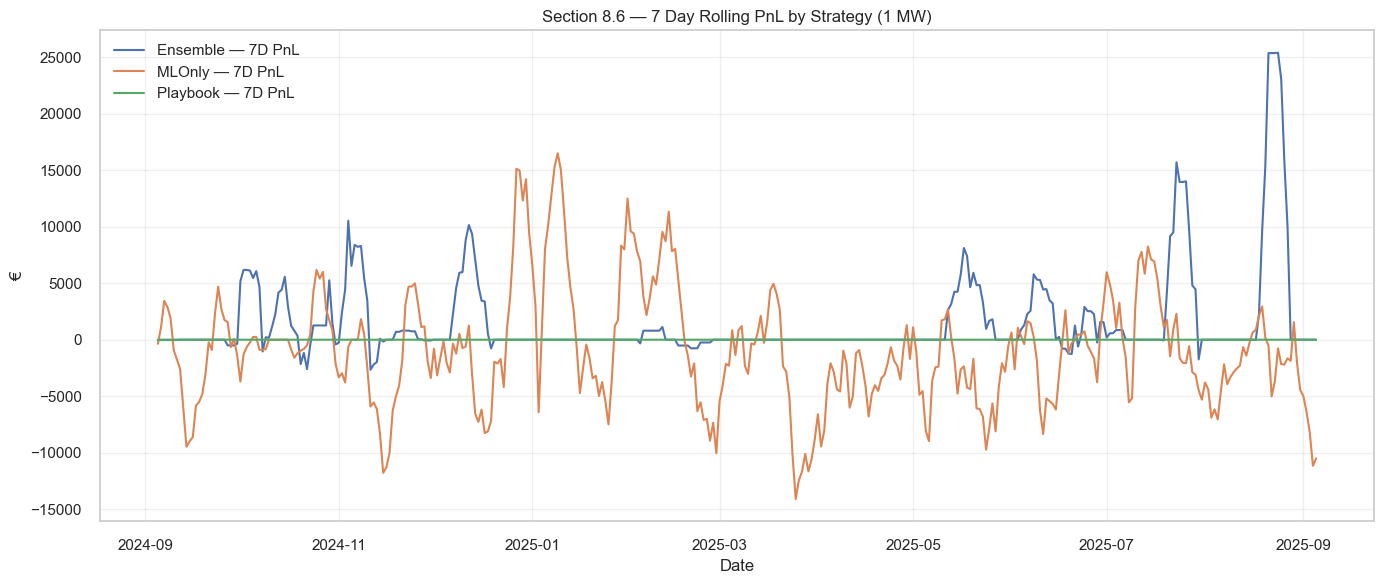

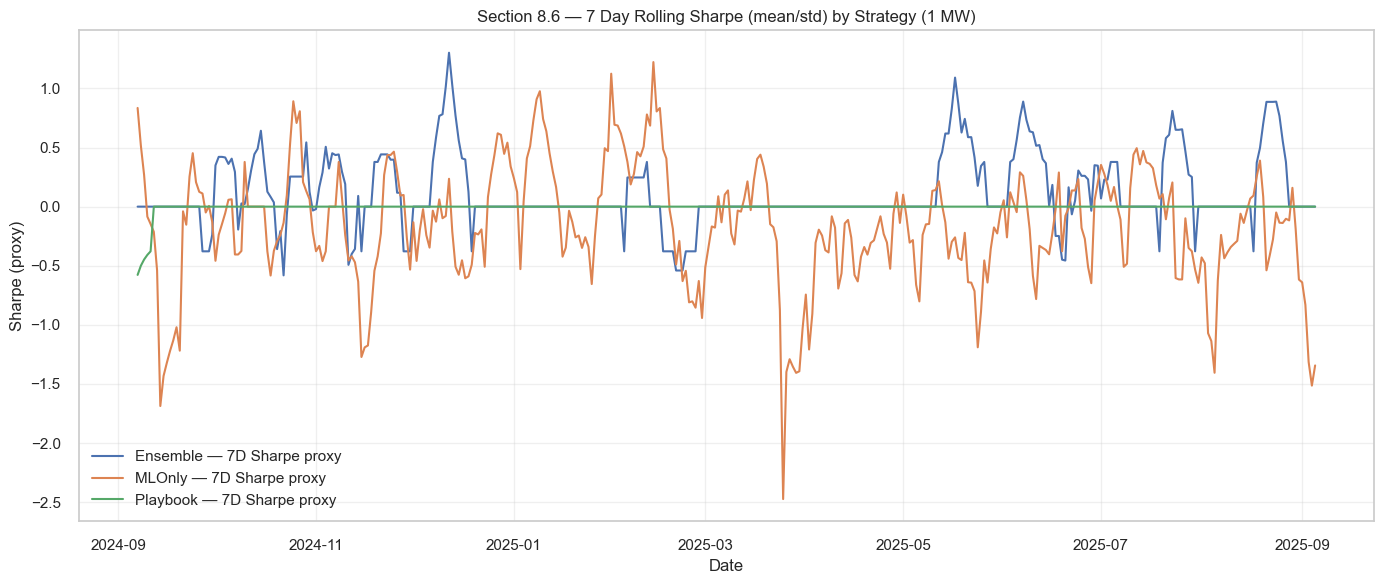

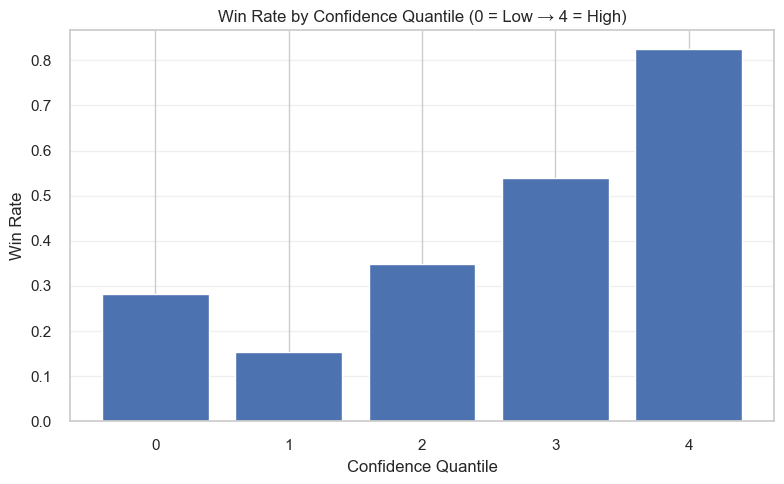


[8.6] Rolling dashboards complete (1 MW, diagnostic only).


In [35]:
# ============================= SECTION 8.6 — Rolling Performance Dashboards =============================
# Purpose:
#   - Build simple rolling dashboards to monitor strategy health over time.
#   - Three diagnostics:
#       (1) 7-day rolling PnL per strategy type.
#       (2) 7-day rolling Sharpe proxy (mean / std) per strategy type.
#       (3) Confidence quantile effectiveness (win rate by confidence bucket).
#
# Notes:
#   - All results use strict 1 MW sizing, consistent with the project spec.
#   - No transaction costs or leverage applied.
#   - Diagnostic only: this section does not alter prior results.
#   - Matplotlib only, one plot per figure.
# ========================================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) Guards & preparation ----------
# Ensure we have the required columns before proceeding:
#   - 'StartDateTime' → time index for grouping
#   - 'StrategyType'  → which strategy was active at each bar
#   - PNL_COL         → chosen per-bar PnL column (from §8.0, usually 'WF_PnL')
req_cols = ['StartDateTime', 'StrategyType', PNL_COL]
missing = [c for c in req_cols if c not in combined_prices_df.columns]
if missing:
    raise KeyError(f"[8.6] Missing required columns: {missing}. "
                   "Run §7.1/§7.2 (and §8.0 for PNL_COL aliasing) first.")

# Work on a copy to avoid altering the master dataframe.
df_dash = combined_prices_df.copy()

# Coerce 'StartDateTime' to datetime (drops rows where parsing fails).
df_dash['StartDateTime'] = pd.to_datetime(df_dash['StartDateTime'], errors='coerce')
df_dash = df_dash.dropna(subset=['StartDateTime'])

# Create a pure calendar-day key (daily resolution), 
# ensuring clean aggregation even if we had intraday bars.
df_dash['Date'] = df_dash['StartDateTime'].dt.floor('D')


# ---------- 1) 7-day rolling PnL per strategy ----------
# Aggregate per day and per StrategyType (sum of per-bar PnL at 1 MW).
# Unstack → pivot so each strategy is a column. Fill missing combos with 0.
per_day = (
    df_dash
    .groupby(['Date', 'StrategyType'])[PNL_COL]
    .sum()
    .unstack(fill_value=0)
    .sort_index()
)

# Compute a 7-day rolling sum of daily PnL (captures trailing performance).
roll_pnl = per_day.rolling(window=7, min_periods=1).sum()

# Plot 7-day rolling PnL for each strategy.
plt.figure(figsize=(14, 6))
for c in roll_pnl.columns:
    plt.plot(roll_pnl.index, roll_pnl[c], label=f"{c} — 7D PnL")
plt.title("Section 8.6 — 7 Day Rolling PnL by Strategy (1 MW)")
plt.xlabel("Date"); plt.ylabel("€")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


# ---------- 2) 7-day rolling Sharpe proxy per strategy ----------
# Define a rolling Sharpe proxy = rolling mean / rolling std, per strategy.
#   - Rolling window: 7 days.
#   - min_periods=3 avoids spurious NaN values in the first few days.
#   - Add epsilon to denominator to avoid divide-by-zero.
roll_mean = per_day.rolling(window=7, min_periods=3).mean()
roll_std  = per_day.rolling(window=7, min_periods=3).std()
roll_sharpe = roll_mean / (roll_std + 1e-9)

# Plot rolling Sharpe proxy curves.
plt.figure(figsize=(14, 6))
for c in roll_sharpe.columns:
    plt.plot(roll_sharpe.index, roll_sharpe[c], label=f"{c} — 7D Sharpe proxy")
plt.title("Section 8.6 — 7 Day Rolling Sharpe (mean/std) by Strategy (1 MW)")
plt.xlabel("Date"); plt.ylabel("Sharpe (proxy)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


# ---------- 3) Confidence quantile effectiveness (win rate) ----------
# Uses 'ConfidenceQuantile' from §8.5:
#   - 0 = lowest confidence
#   - 4 = highest confidence
if 'ConfidenceQuantile' in df_dash.columns:
    # Ensure quantiles are numeric (pd.qcut may produce categorical labels).
    q = df_dash['ConfidenceQuantile']
    if not np.issubdtype(q.dtype, np.number):
        df_dash['ConfidenceQuantile'] = q.astype(int)

    # ProfitFlag = True if PnL > 0 (profitable bar), False otherwise.
    df_dash['ProfitFlag'] = df_dash[PNL_COL] > 0

    # Compute average win rate per quantile bucket.
    conf_win = (
        df_dash.groupby('ConfidenceQuantile')['ProfitFlag']
        .mean()
        .reindex(sorted(df_dash['ConfidenceQuantile'].dropna().unique()))
    )

    # Plot win rate by confidence quantile.
    plt.figure(figsize=(8, 5))
    plt.bar(conf_win.index.astype(str), conf_win.values)
    plt.title("Win Rate by Confidence Quantile (0 = Low → 4 = High)")
    plt.xlabel("Confidence Quantile")
    plt.ylabel("Win Rate")
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    # If §8.5 was not run, this diagnostic is skipped.
    print("[8.6] ConfidenceQuantile not found (run Section 8.5 first).")


print("\n[8.6] Rolling dashboards complete (1 MW, diagnostic only).")


In [36]:
# =========================================
# 9A — Setup & Helpers
# =========================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt   # core libs: data/arrays/plots

# --- toggles for outputs ---
EXPORT_TO_CSV = True                    # if True, later sections can write PowerBI-ready CSVs
TRANSACTION_EUR = 1.0                   # € threshold per 1 MW (kept for future gating; not used here)
ROLL_HALF_HOURS_PER_WEEK = 48*7         # rolling window length in half-hours (~1 week at 30-min bars)

# --- utility functions ---
def pick(df, *candidates, default=None):
    """Return the first column name that exists in df from a list of candidates; else 'default'."""
    for c in candidates:
        if c in df.columns:
            return c
    return default

def winsorize(s, p=0.995):
    """Clip a Series to the [1-p, p] quantiles to prevent extreme outliers dominating downstream math."""
    s = pd.to_numeric(s, errors='coerce')
    lo, hi = s.quantile(1-p), s.quantile(p)
    return s.clip(lo, hi)

def minmax(s):
    """Normalize a Series to [0,1]; safe for flat series (returns zeros)."""
    s = pd.to_numeric(s, errors='coerce').fillna(0.0)
    r = s.max() - s.min()
    return (s - s.min()) / r if r != 0 else pd.Series(0.0, index=s.index)


def zscore(s):
    """Standardize a Series to zero-mean, unit-variance; adds small epsilon to avoid divide-by-zero."""
    s = pd.to_numeric(s, errors='coerce').fillna(0.0)
    return (s - s.mean()) / (s.std() + 1e-9)

def safe_num(x):
    """
    Convert input to numeric safely.
    - Series: coerce to numeric, drop inf to NaN, fill with 0.
    - DataFrame: apply per column.
    - Scalar: float() with NaN/inf → 0.
    """
    if isinstance(x, pd.Series):
        return pd.to_numeric(x, errors='coerce').replace([np.inf,-np.inf], np.nan).fillna(0.0)
    if isinstance(x, pd.DataFrame):
        return x.apply(lambda c: pd.to_numeric(c, errors='coerce')).replace([np.inf,-np.inf], np.nan).fillna(0.0)
    try:
        val = float(x)
    except Exception:
        return 0.0
    return 0.0 if (pd.isna(val) or np.isinf(val)) else val

# --- base prep on the working dataframe ---
combined_prices_df['StartDateTime'] = pd.to_datetime(combined_prices_df['StartDateTime'])  # ensure datetime type
combined_prices_df = combined_prices_df.sort_values('StartDateTime').copy()                # sort chronologically & isolate copy

# detect price columns consistently using the 'pick' helper (accept various naming variants)
dam_col = pick(combined_prices_df, 'PriceDAM','DAMPrice')                      # DAM price column name
bm_col  = pick(combined_prices_df, 'PriceImbalance','BMPrice','ImbalancePrice')# BM/imbalance price column name
spread_col = pick(combined_prices_df, 'Spread_DAMtoBM')                        # realized spread column name, if already present

# if spread not already present, construct DAM–BM spread from detected price columns
if spread_col is None:
    combined_prices_df['Spread_DAMtoBM'] = combined_prices_df[dam_col] - combined_prices_df[bm_col]  # DAM minus BM
    spread_col = 'Spread_DAMtoBM'                                                                    # remember the new column name

# =========================================
# 9B — Inputs & ML hookup (robust detection)
# =========================================

# Try to locate an ML spread prediction column under common names
ml_pred_col = pick(
    combined_prices_df,
    'ML_SpreadPrediction','ML_Spread_Estimate','Reg_Spread_Pred',
    'WF_Spread_Pred','Pred_Spread','PredictedSpread'
)
# Try to locate an ML confidence column (0–1 or proxy); several name variants supported
ml_conf_col = pick(combined_prices_df, 'ML_Confidence','ConfidenceScore','Confidence','WF_Confidence')

# Fallback 1: if no spread prediction, derive it from DAM and BM ML predictions if both exist
if ml_pred_col is None:
    dam_pred = pick(combined_prices_df,'DAM_Price_Pred','DAM_ML_Estimate','DAM_Pred')       # ML DAM price estimate
    bm_pred  = pick(combined_prices_df,'BM_Price_Pred','Imbalance_ML_Estimate','BM_Pred')   # ML BM price estimate
    if dam_pred and bm_pred:
        combined_prices_df['ML_SpreadPrediction'] = safe_num(combined_prices_df[dam_pred]) - safe_num(combined_prices_df[bm_pred])
        ml_pred_col = 'ML_SpreadPrediction'                                                 # use the derived prediction

# Fallback 2: classification-based directional ML signal (probability/sign scaled by recent magnitude)
prob_col = pick(combined_prices_df,'ML_Long_Prob','Prob_Long','Class_Prob_Up')              # optional long probability
dir_col  = pick(combined_prices_df,'ML_Direction','Dir_Pred','Class_Pred_Up')               # optional +1/-1 direction
if ml_pred_col is None and (prob_col or dir_col):
    # Build a lagged magnitude proxy from realized spread (weekly rolling mean of |spread|), to scale direction/prob
    lag_mag = (combined_prices_df[spread_col].abs()
               .rolling(ROLL_HALF_HOURS_PER_WEEK, min_periods=24).mean()
               .shift(1).bfill())
    # Signed directional core: from probability (centered at 0.5) or from discrete direction
    if prob_col:
        signed = 2.0*safe_num(combined_prices_df[prob_col]) - 1.0                           # map [0,1] → [-1,1]
    else:
        signed = np.where(safe_num(combined_prices_df[dir_col])>0, 1.0, -1.0)               # +1 for up, -1 for down
    # Form a pseudo-spread prediction consistent with scale of recent spreads
    combined_prices_df['ML_SpreadPrediction'] = signed * lag_mag
    ml_pred_col = 'ML_SpreadPrediction'                                                      # adopt derived prediction

# confidence handling: build/normalize a confidence signal if none detected above
if ml_conf_col is None:
    q = pick(combined_prices_df,'ConfidenceQuantile')                                        # try diagnostic quantile (0..4)
    if q:
        v = safe_num(combined_prices_df[q])
        combined_prices_df['ML_Confidence'] = v / (v.max() or 1.0)                           # normalize quantile to ~[0,1]
    elif prob_col:
        p = safe_num(combined_prices_df[prob_col])
        combined_prices_df['ML_Confidence'] = 1.0 - 2.0*np.abs(p - 0.5)                      # high near 0 or 1, low near 0.5
    else:
        # final fallback: inverse normalized volatility (high vol → lower confidence)
        vol = combined_prices_df[spread_col].rolling(48,min_periods=12).std().bfill()
        combined_prices_df['ML_Confidence'] = 1.0 - (vol-vol.min())/(vol.max()-vol.min()+1e-9)
    ml_conf_col = 'ML_Confidence'                                                            # record the chosen confidence column

# final ML weighted prediction (spread × confidence), staying in € units per 1 MW
combined_prices_df['ML_Weighted'] = safe_num(combined_prices_df[ml_pred_col]) * safe_num(combined_prices_df[ml_conf_col])

print("ML columns in use:", ml_pred_col, ml_conf_col)                                        # quick audit of chosen cols
print("Non-zero ML_Weighted share:", round(float((combined_prices_df['ML_Weighted'].abs() > 1e-9).mean()), 3))  # activity share

# =========================================
# 9C — Core fundamentals & rule signals
# =========================================

# --- fundamentals normalised into [0,1] (if available) ---
outage_mw_col = pick(combined_prices_df,'TotalOutageMW','Outage_MW_Reduction')              # system outages (MW)
demand_col    = pick(combined_prices_df,'DemandForecast','Forecasted_Demand','Meteo_ISEMDEMAND_DAM')  # demand proxy
wind_col      = pick(combined_prices_df,'Meteo_ISEMWIND_DAM','WindForecast')                # wind proxy
solar_col     = pick(combined_prices_df,'SolarForecast')                                    # solar proxy (optional)

# Normalize fundamentals; if a column is missing, set to scalar 0.0 so downstream math is safe
combined_prices_df['NormOutage'] = minmax(combined_prices_df[outage_mw_col]) if outage_mw_col else 0.0
combined_prices_df['NormDemand'] = minmax(combined_prices_df[demand_col])    if demand_col  else 0.0
combined_prices_df['NormWind']   = minmax(combined_prices_df[wind_col])      if wind_col    else 0.0
combined_prices_df['NormSolar']  = minmax(combined_prices_df[solar_col])     if solar_col   else 0.0

# --- Top rules selection (impact on spread) ---
N_TOP_RULES, MIN_ACTIVATIONS = 50, 20                                           # keep up to 50 rules with enough samples
rule_cols = [c for c in combined_prices_df.columns if c.startswith('RULE_ACTIVE__')]  # boolean active flags per outage combo
top_rules_filtered, spread_impact_df = [], pd.DataFrame(columns=['MeanSpreadDifference'])  # placeholders

if rule_cols:
    # rank rules by absolute correlation with spread (heuristic: which active flags align with large spreads)
    corr = combined_prices_df[rule_cols].corrwith(combined_prices_df[spread_col]).abs().sort_values(ascending=False)
    top_initial = corr.head(N_TOP_RULES).index.tolist()                          # take top-N by |corr|
    # keep only rules that fired often enough to be meaningful
    act_counts = combined_prices_df[top_initial].sum().sort_values(ascending=False)
    top_rules_filtered = [r for r in top_initial if act_counts[r] >= MIN_ACTIVATIONS]

    # estimate spread impact per rule: average spread when rule is ON minus when OFF
    impact = {}
    for r in top_rules_filtered:
        a = combined_prices_df.loc[combined_prices_df[r]==1, spread_col].mean()  # mean spread when rule active
        i = combined_prices_df.loc[combined_prices_df[r]==0, spread_col].mean()  # mean spread otherwise
        impact[r] = float(a - i)                                                 # directional impact (€/MWh)
    # build a DataFrame sorted by absolute impact (largest structural shifters first)
    spread_impact_df = (
        pd.DataFrame.from_dict(impact, orient='index', columns=['MeanSpreadDifference'])
        .sort_values('MeanSpreadDifference', key=lambda s: s.abs(), ascending=False)
    )

    # weighted rule signal per bar:
    # take the active flags and weight them by |impact|, then max-normalize to [0,1] for scale robustness
    weights = spread_impact_df['MeanSpreadDifference'].abs().reindex(top_rules_filtered).fillna(0.0)
    sig = (combined_prices_df[top_rules_filtered] * weights).sum(axis=1)
    combined_prices_df['RuleSignal'] = sig / (sig.max() if sig.max() else 1.0)
else:
    combined_prices_df['RuleSignal'] = 0.0                                      # no rules available → neutral signal

# signed rule driver: align the RuleSignal to spread direction via overall correlation sign, then z-score it
rule_corr = pd.Series(combined_prices_df['RuleSignal']).corr(combined_prices_df[spread_col])  # sign of association
rule_sign = 1.0 if (pd.notna(rule_corr) and rule_corr >= 0) else -1.0                         # +1 if positively aligned
combined_prices_df['RuleSignal_Signed'] = rule_sign * zscore(combined_prices_df['RuleSignal'])# signed standardized rules signal

print(f"RuleSignal built from {len(top_rules_filtered)} active rules.")        # footprint of rules contributing

# =========================================
# 9D — Adaptive Ensemble (confidence gated)
# =========================================

# --- check all inputs exist before combining ---
req = ['ML_Weighted','RuleSignal_Signed','NormOutage','NormDemand','NormWind','NormSolar',spread_col,ml_conf_col]
missing = [c for c in req if c not in combined_prices_df.columns]
assert not missing, f"[9D] Missing inputs: {missing}"                           # fail fast if any required input absent

df9 = combined_prices_df.copy()                                                 # local working copy

# ex-ante scaler for magnitude (in €): median(|spread|) over ~1 week, then stabilized & lagged
scaler = (df9[spread_col].abs()
          .rolling(ROLL_HALF_HOURS_PER_WEEK, min_periods=48).median()          # robust weekly median of |spread|
          .bfill().expanding().mean())                                         # stabilize by expanding mean
df9['SpreadScaler_lag'] = winsorize(scaler, p=0.995).shift(1).bfill()          # clip extremes, lag by 1 bar, fill early NaNs
combined_prices_df['SpreadScaler_lag'] = df9['SpreadScaler_lag'].values        # store back on master frame for reuse

# weights for "other" components (rules + fundamentals); start with a prior mix
W_OTHER = dict(rules=0.40, outage=0.24, demand=0.24, wind=0.08, solar=0.04)
if combined_prices_df['NormSolar'].nunique(dropna=False) <= 1:                  # if no solar variability, zero its weight
    W_OTHER['solar'] = 0.0
# renormalize weights to sum to 1 after the solar tweak
s = sum(W_OTHER.values()) or 1.0
for k in W_OTHER: 
    W_OTHER[k] /= s
print("9D Weights:", W_OTHER)                                                  # show effective component weights

# --- streams to blend ---
model_stream = safe_num(df9['ML_Weighted'])                                    # ML estimate already in € units (confidence-weighted)
other_stream = (                                                               # fundamentals+rules stream, all scaled to €
    W_OTHER['rules']  * safe_num(df9['RuleSignal_Signed']) * df9['SpreadScaler_lag'] +
    W_OTHER['outage'] * zscore(df9['NormOutage'])          * df9['SpreadScaler_lag'] +
    W_OTHER['demand'] * zscore(df9['NormDemand'])          * df9['SpreadScaler_lag'] +
    W_OTHER['wind']   * zscore(1 - df9['NormWind'])         * df9['SpreadScaler_lag'] +  # (1 - wind): lower wind → tighter system
    W_OTHER['solar']  * zscore(df9['NormSolar'])            * df9['SpreadScaler_lag']
)

# confidence gate g ∈ [0,1]: controls how much weight goes to ML vs. "other" stream bar-by-bar
g = safe_num(df9[ml_conf_col]).clip(0,1)

# combine ML + other streams: raw ensemble estimate in €; then winsorize to reduce shock sensitivity
raw = g*model_stream + (1.0-g)*other_stream
raw = winsorize(raw, p=0.995)

# smoothed ensemble spread estimate (EWMA for stability)
combined_prices_df['Ensemble_Spread_Estimate'] = raw.ewm(alpha=0.35,adjust=False).mean()

# contribution breakdowns (in €) for diagnostics: how much each component contributed bar-by-bar
combined_prices_df['Ensemble_contrib_ML']     = g * model_stream
combined_prices_df['Ensemble_contrib_Rules']  = (1.0-g)*W_OTHER['rules']  * safe_num(df9['RuleSignal_Signed']) * df9['SpreadScaler_lag']
combined_prices_df['Ensemble_contrib_Outage'] = (1.0-g)*W_OTHER['outage'] * zscore(df9['NormOutage'])          * df9['SpreadScaler_lag']
combined_prices_df['Ensemble_contrib_Demand'] = (1.0-g)*W_OTHER['demand'] * zscore(df9['NormDemand'])          * df9['SpreadScaler_lag']
combined_prices_df['Ensemble_contrib_Wind']   = (1.0-g)*W_OTHER['wind']   * zscore(1-df9['NormWind'])          * df9['SpreadScaler_lag']
combined_prices_df['Ensemble_contrib_Solar']  = (1.0-g)*W_OTHER['solar']  * zscore(df9['NormSolar'])           * df9['SpreadScaler_lag']

print("9D  Ensemble built (confidence-gated ML + rules/fundamentals).")        # final status message


ML columns in use: ML_SpreadPrediction ML_Confidence
Non-zero ML_Weighted share: 0.997
RuleSignal built from 50 active rules.
9D Weights: {'rules': 0.4166666666666667, 'outage': 0.25, 'demand': 0.25, 'wind': 0.08333333333333334, 'solar': 0.0}
9D  Ensemble built (confidence-gated ML + rules/fundamentals).



[9E] KPI Summary (1 MW, diagnostic only)
MAE: 63.0109
ME: -2.1902
RMSE: 83.0990
DirectionalAccuracy_%: 52.7521
TotalPnL_€: 68764.8300
Trades: 13130.0000
WinRate_%: 40.1197
Sharpe: 0.0549
MaxDrawdown_€: 23580.3900
ProfitFactor: 1.1816


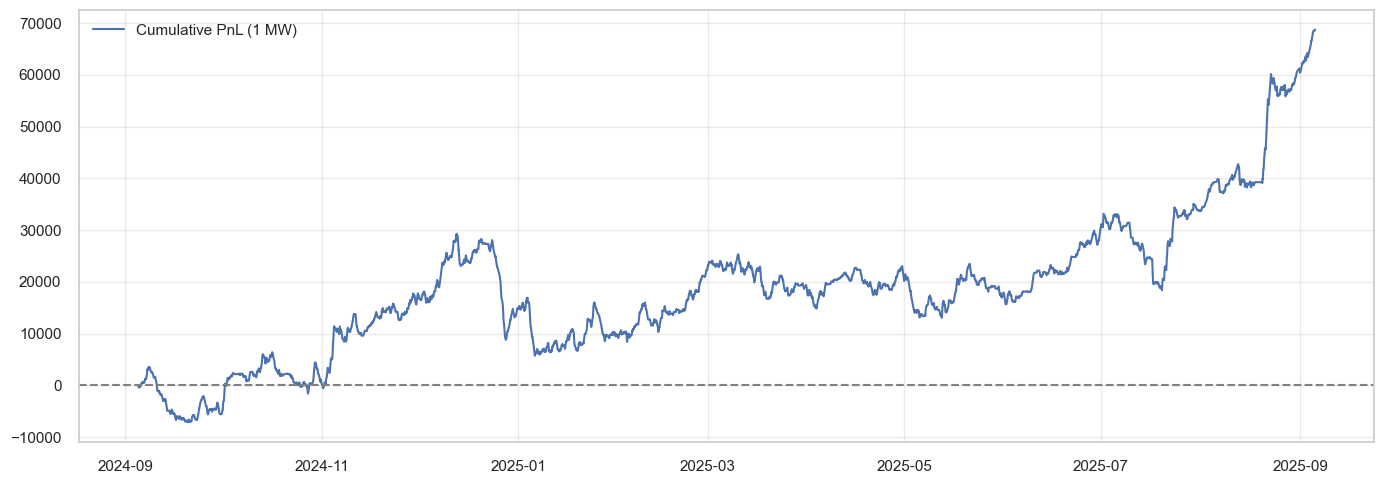


[9F] Ablation (gated like 9D, 1 MW, no costs):
ML-only              PnL€=28,090 | Win%=42.60 | Trades=17238
Rules-only           PnL€=126,420 | Win%=55.93 | Trades=17238
Fundamentals-only    PnL€=8,771 | Win%=49.90 | Trades=17238
Ensemble (full)      PnL€=90,349 | Win%=52.26 | Trades=17238


In [37]:
# 9E — PnL (1 MW) + Key Performance Indicators (diagnostic only, no costs applied)
# ======================================================================================

# Toggle: apply entry gating or not. If False, we simply trade the sign of the forecast.
USE_GATING = True
# Minimum ML confidence to allow a trade (0–1 scale)
CONF_MIN = 0.55
# Or, allow a trade if the forecast magnitude is large relative to historical spread (scaled ≥ 10%)
SCALED_MAG_MIN = 0.10

# Forecast time series in €/MWh (already smoothed by 9D)
f = combined_prices_df['Ensemble_Spread_Estimate']

# Only consider bars where DAM→BM spread is at least ±TRANSACTION_EUR, to skip trivial/noise bars
tradable = (combined_prices_df[spread_col].abs() > TRANSACTION_EUR)

if USE_GATING:
    # Leak-safe confidence (already ex-ante); default to 1.0 if missing
    conf = safe_num(combined_prices_df.get('ML_Confidence', 1.0))
    # Lagged median-abs-spread scaler from 9D (ex-ante magnitude baseline)
    scaler = safe_num(combined_prices_df.get('SpreadScaler_lag', 1.0))
    # Forecast magnitude relative to recent spread size
    scaled_mag = (f.abs() / (scaler + 1e-9))
    # Gate: trade if confidence high OR forecast magnitude is large
    allow = (conf >= CONF_MIN) | (scaled_mag >= SCALED_MAG_MIN)
    # Convert to direction (+1/-1) only when allowed; else 0 (flat)
    sig = np.where(allow, np.sign(f), 0)
else:
    # Ungated mode: always take the sign of the forecast
    sig = np.sign(f)

# Final position: ±1 MW when tradable and signal ≠ 0; else 0 MW
combined_prices_df['EnsembleSignal'] = np.where(tradable, sig, 0).astype(int)

# Realized PnL at strict 1 MW: signal × realized spread (no costs)
combined_prices_df['SimulatedPnL_Ensemble'] = combined_prices_df['EnsembleSignal'] * combined_prices_df[spread_col]

# Cumulative PnL over time for visualization
combined_prices_df['CumulativePnL_Ensemble'] = combined_prices_df['SimulatedPnL_Ensemble'].cumsum()


# --- KPI Calculation (diagnostics only) ---

# Mild smoothing of the forecast (3-pt mean) to stabilize error metrics
forecast = f.rolling(3, center=True, min_periods=1).mean()

# Forecast error (forecast minus realized)
err = forecast - combined_prices_df[spread_col]

# Directional accuracy: forecast sign equals realized spread sign
dir_hit = np.sign(forecast) == np.sign(combined_prices_df[spread_col])

# Helper: simple Sharpe (mean/std), no risk-free, operates on PnL series
def _sharpe(x):
    x = safe_num(x)
    s = x.std()
    return float(x.mean()/(s+1e-9)) if s else 0.0

# Helper: max drawdown from a cumulative PnL series
def _maxdd(cs):
    cs = safe_num(cs)
    peak = cs.cummax()
    return float((peak - cs).max()) if len(cs) else 0.0

# KPI summary (all in 1 MW units, no costs/slippage)
KPI_SUMMARY = {
    'MAE': float(err.abs().mean()),                                   # mean absolute error (€/MWh)
    'ME': float(err.mean()),                                          # mean error (bias)
    'RMSE': float(np.sqrt((err**2).mean())),                          # root mean squared error
    'DirectionalAccuracy_%': float(100*dir_hit.mean()),               # % correct direction
    'TotalPnL_€': float(combined_prices_df['SimulatedPnL_Ensemble'].sum()),  # total € PnL
    'Trades': int((combined_prices_df['EnsembleSignal']!=0).sum()),   # number of non-zero trades
    'WinRate_%': float(100*(combined_prices_df['SimulatedPnL_Ensemble']>0).mean()),  # % profitable trades
    'Sharpe': _sharpe(combined_prices_df['SimulatedPnL_Ensemble']),   # simple Sharpe (per-bar)
    'MaxDrawdown_€': _maxdd(combined_prices_df['CumulativePnL_Ensemble']),           # worst peak-to-trough
    'ProfitFactor': float(                                            # total gains / total losses
        combined_prices_df.loc[combined_prices_df['SimulatedPnL_Ensemble']>0, 'SimulatedPnL_Ensemble'].sum() /
        abs(combined_prices_df.loc[combined_prices_df['SimulatedPnL_Ensemble']<0, 'SimulatedPnL_Ensemble'].sum())
    ) if (combined_prices_df['SimulatedPnL_Ensemble']<0).any() else np.nan
}

# Pretty print KPIs
print("\n[9E] KPI Summary (1 MW, diagnostic only)")
for k,v in KPI_SUMMARY.items():
    print(f"{k}: {v:.4f}" if isinstance(v,(int,float)) else f"{k}: {v}")

# Plot the cumulative curve for a quick health check
plt.figure(figsize=(14,5))
plt.plot(combined_prices_df['StartDateTime'], combined_prices_df['CumulativePnL_Ensemble'], label='Cumulative PnL (1 MW)')
plt.axhline(0, linestyle='--', color='grey')
plt.legend(); plt.grid(True, alpha=0.4); plt.tight_layout(); plt.show()


# ======================================================================================
# 9F — Ablation Study (fair comparison of ML vs Rules vs Fundamentals vs Full Ensemble)
# ======================================================================================

# Sanity: ensure 9D outputs exist (scaler, ensemble estimate, ML weighted stream)
assert all(c in combined_prices_df.columns for c in ['SpreadScaler_lag','Ensemble_Spread_Estimate','ML_Weighted']), \
    "Run 9D first (requires SpreadScaler_lag, Ensemble_Spread_Estimate, ML_Weighted)."

# Helper: normalized weights for the non-ML stream (rules + fundamentals)
def _other_weights(df):
    w = {'rules': 0.40, 'outage': 0.24, 'demand': 0.24, 'wind': 0.08, 'solar': 0.04}
    # If solar is effectively constant, drop it
    if 'NormSolar' not in df.columns or pd.Series(df['NormSolar']).std(skipna=True) < 1e-12:
        w['solar'] = 0.0
    s = sum(v for v in w.values() if v > 0)
    return {k: (v/s if s > 0 else 0.0) for k, v in w.items()}

# Helper: recover a signed rules series if the pre-signed column is absent
def _rule_signed(df):
    if 'RuleSignal_Signed' in df.columns:
        return safe_num(df['RuleSignal_Signed'])
    base = safe_num(df['RuleSignal']) if 'RuleSignal' in df.columns else 0.0
    corr = pd.Series(base).corr(df[spread_col])
    sign = 1.0 if pd.notna(corr) and corr >= 0 else -1.0
    return sign * zscore(base).fillna(0.0)

# Helper: rebuild ensemble-like estimate with components toggled on/off (mirrors 9D logic)
def _build_est_9Dmirror(df, keep_ml=True, keep_rules=True, keep_fund=True):
    Scale = safe_num(df['SpreadScaler_lag'])                  # magnitude scaler (ex-ante)
    g = safe_num(df.get('ML_Confidence', 1.0)).clip(0, 1)     # confidence gate

    # ML stream (in €); switched off if keep_ml=False
    ml_stream = safe_num(df['ML_Weighted']) if keep_ml else 0.0

    # Other stream (rules + fundamentals) in €; toggle rules/fundamentals via keep_* flags
    W = _other_weights(df)
    other_stream = 0.0
    if keep_rules:
        other_stream += W['rules'] * _rule_signed(df) * Scale
    if keep_fund:
        out_drv = zscore(df['NormOutage']) if 'NormOutage' in df else 0.0
        dem_drv = zscore(df['NormDemand']) if 'NormDemand' in df else 0.0
        win_drv = zscore(1.0 - safe_num(df['NormWind'])) if 'NormWind' in df else 0.0
        sol_drv = zscore(df['NormSolar']) if 'NormSolar' in df else 0.0
        other_stream += (
            W['outage'] * out_drv * Scale +
            W['demand'] * dem_drv * Scale +
            W['wind']   * win_drv * Scale +
            W['solar']  * sol_drv * Scale
        )

    # Combine via confidence gating, clip tail risk, then smooth (EWMA)
    raw = g * ml_stream + (1.0 - g) * other_stream
    raw = winsorize(raw, p=0.995)
    return raw.ewm(alpha=0.35, adjust=False).mean()

# Build the four variants: ML-only, Rules-only, Fundamentals-only, and Full ensemble
combined_prices_df['ML_only_est']            = _build_est_9Dmirror(combined_prices_df, keep_ml=True,  keep_rules=False, keep_fund=False)
combined_prices_df['Rules_only_est']         = _build_est_9Dmirror(combined_prices_df, keep_ml=False, keep_rules=True,  keep_fund=False)
combined_prices_df['Fundamentals_only_est']  = _build_est_9Dmirror(combined_prices_df, keep_ml=False, keep_rules=False, keep_fund=True)
combined_prices_df['Full_ensemble_est']      = combined_prices_df['Ensemble_Spread_Estimate']  # the 9D baseline

# Helper: convert an estimate column → ±1 MW signal with tradability filter
def _signal_from_est(est_col):
    s = np.sign(safe_num(combined_prices_df[est_col])).astype(int)
    tradable = (combined_prices_df[spread_col].abs() > TRANSACTION_EUR)
    return np.where(tradable, s, 0).astype(int)

# For each variant, create signal and realized PnL columns
for est in ['ML_only_est','Rules_only_est','Fundamentals_only_est','Full_ensemble_est']:
    s = est.replace('_est','_Signal')
    p = est.replace('_est','_PnL')
    combined_prices_df[s] = _signal_from_est(est)                       # ±1 MW signal
    combined_prices_df[p] = combined_prices_df[s] * combined_prices_df[spread_col]  # realized € PnL

# Compact printer for a quick head-to-head comparison
def _sum(label, pnl_col, sig_col):
    pnl, sig = combined_prices_df[pnl_col], combined_prices_df[sig_col]
    print(f"{label:<20} PnL€={pnl.sum():,.0f} | Win%={(pnl>0).mean()*100:5.2f} | Trades={(sig!=0).sum()}")

print("\n[9F] Ablation (gated like 9D, 1 MW, no costs):")
_sum("ML-only",            "ML_only_PnL",           "ML_only_Signal")
_sum("Rules-only",         "Rules_only_PnL",        "Rules_only_Signal")
_sum("Fundamentals-only",  "Fundamentals_only_PnL", "Fundamentals_only_Signal")
_sum("Ensemble (full)",    "Full_ensemble_PnL",     "Full_ensemble_Signal")




[9E] KPI Summary (1 MW, diagnostic only)
MAE: 63.0109
ME: -2.1902
RMSE: 83.0990
DirectionalAccuracy_%: 52.7521
TotalPnL_€: 68772.9900
Trades: 13397.0000
WinRate_%: 40.5584
Sharpe: 0.0549
MaxDrawdown_€: 23578.2700
ProfitFactor: 1.1816


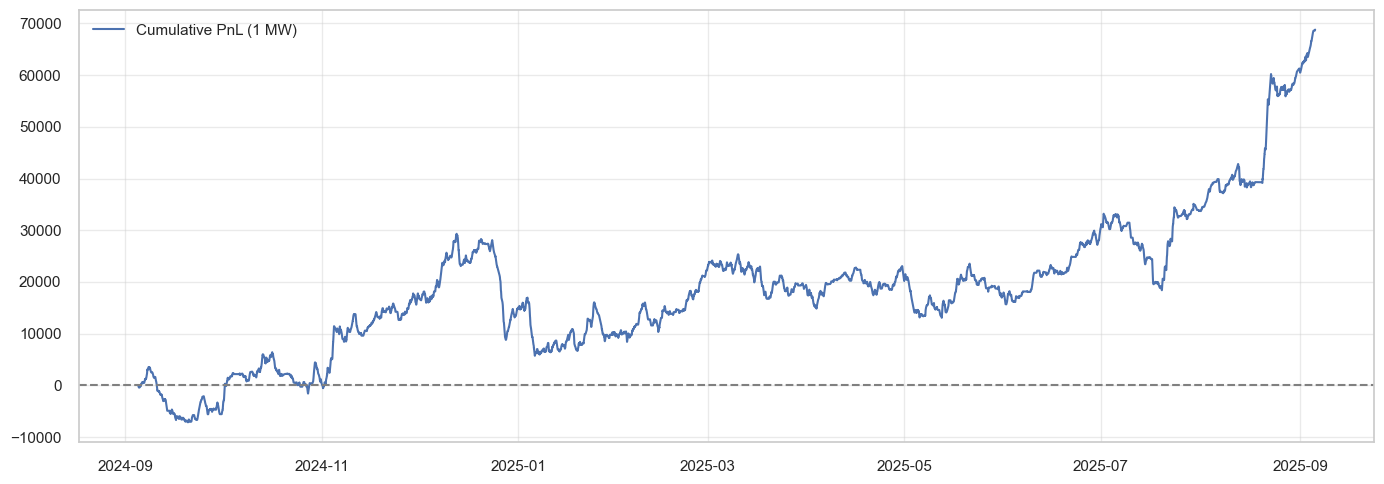


[9F] Ablation (gated like 9D, 1 MW, no costs):
ML-only              PnL€=28,067 | Win%=43.02 | Trades=17550
Rules-only           PnL€=126,436 | Win%=56.47 | Trades=17550
Fundamentals-only    PnL€=8,774 | Win%=50.42 | Trades=17550
Ensemble (full)      PnL€=90,364 | Win%=52.81 | Trades=17550

[9G] Top 15 rules by allocated PnL (test window):


AllocatedPnL  Activations  AvgPnL_per_activation
RULE_ACTIVE__B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT                                                                       6287.817499         1326               4.741944
RULE_ACTIVE__Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT                                                   5920.554740          197              30.053577
RULE_ACTIVE__Moneypoint_1_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT                 5920.554740          197              30.053577
RULE_ACTIVE__B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT                                           3405.219564          248              13.730724
RULE_ACTIVE__B31_OUT + Moneypoint_1_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT         3405.219564          248              13.730724
RULE_ACTIVE__Moneypoint_1_Generator_Unit_OUT + Aghada_2_Generator_Unit_OUT                                                           2400.815105          197              12.186879
RULE_ACTIVE__B31_OUT + Moneypoint_1_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT                                                   2367.068753          248               9.544632
RULE_ACTIVE__B31_OUT + Moneypoint_3_Generator_Unit_OUT + Tynagh_Generator_Unit_OUT                                                   1322.649277          102              12.967150
RULE_ACTIVE__Moneypoint_1_Generator_Unit_OUT + Great_Island_CCGT_OUT + Aghada_2_Generator_Unit_OUT                                   1227.686102           27              45.469856
RULE_ACTIVE__B31_OUT + Moneypoint_3_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT                                     1134.119983          314               3.611847
RULE_ACTIVE__Great_Island_CCGT_OUT + Aghada_2_Generator_Unit_OUT                                                                     1078.110228           27              39.930008
RULE_ACTIVE__B31_OUT + Moneypoint_3_Generator_Unit_OUT + Moneypoint_1_Generator_Unit_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT    948.771250          314               3.021564
RULE_ACTIVE__B31_OUT + Coolkeeragh_ESB_CCGT_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBA_OUT                  0.000000            0                    NaN
RULE_ACTIVE__B31_OUT + Moneypoint_3_Generator_Unit_OUT + Moneypoint_2_Generator_Unit_OUT + Shellybanks_PBA_OUT                          0.000000            0                    NaN
RULE_ACTIVE__Moneypoint_3_Generator_Unit_OUT + Shellybanks_PBA_OUT                                                                      0.000000            0                    NaN

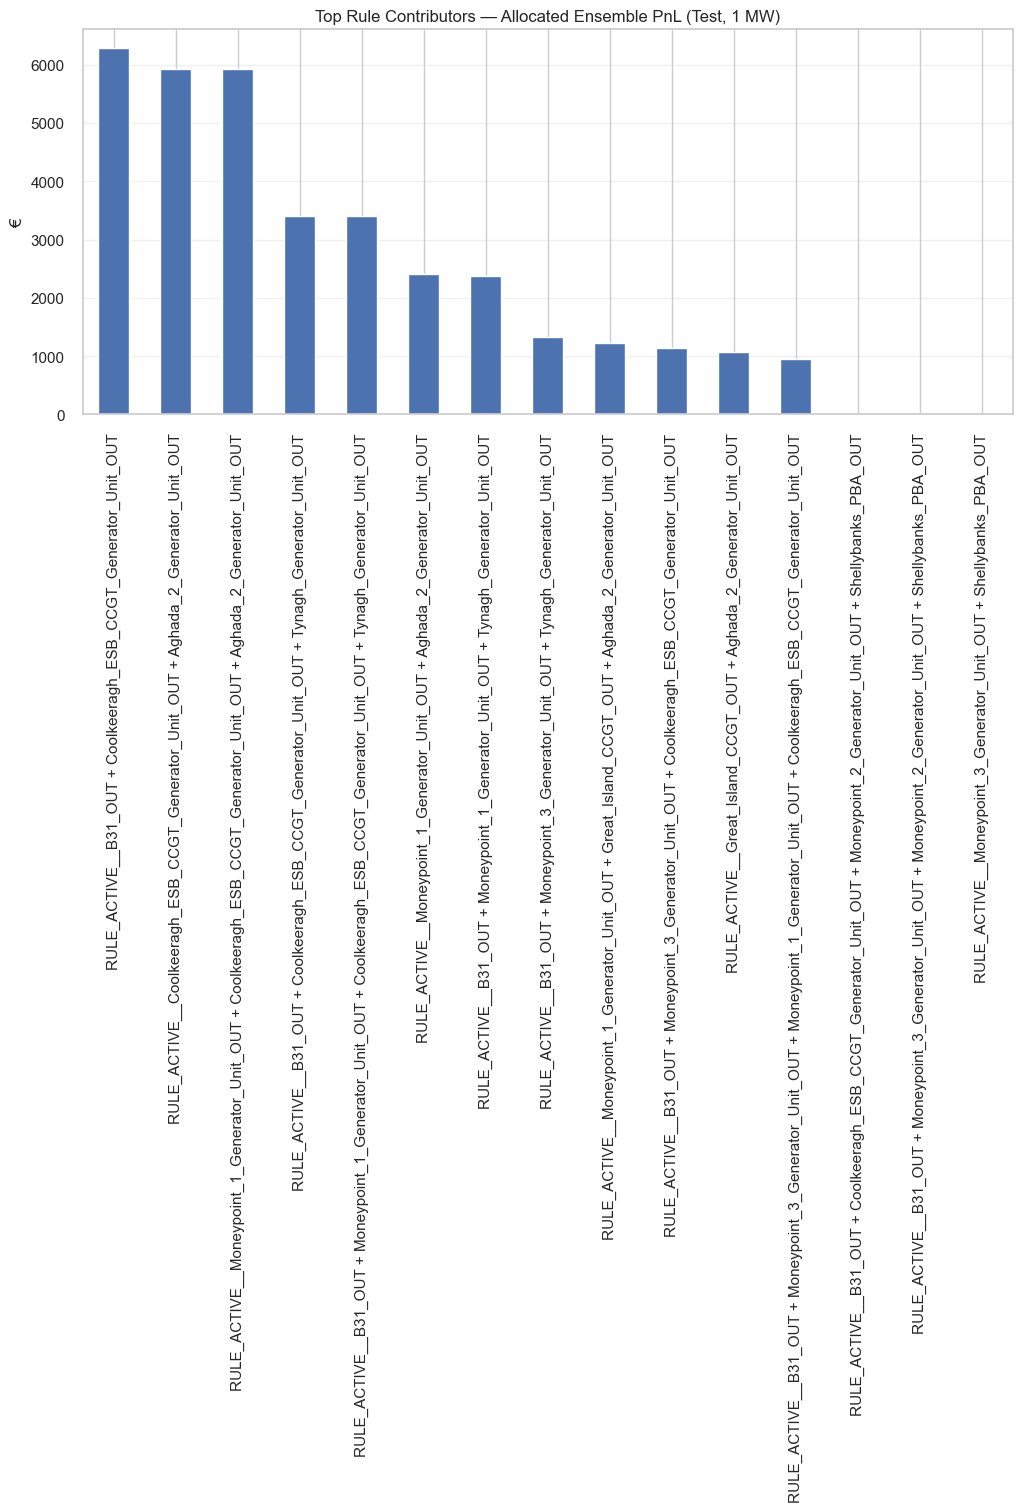


[9H] Walk-forward summary (no refit, diagnostic):


TrainStart            TrainEnd           TestStart             TestEnd  MAE_train  RMSE_train  DirAcc_train_%  PnL_train  Trades_train  WinRate_train_%   MAE_test   RMSE_test  \
0 2024-09-05 00:00:00 2024-12-04 02:30:00 2024-12-04 03:00:00 2025-01-03 03:30:00  60.069488   75.317205       47.665280   16057.34          3292        37.147480  68.908844   90.622486   
1 2024-10-05 01:00:00 2025-01-03 03:30:00 2025-01-03 04:00:00 2025-02-02 04:30:00  67.092164   85.124349       49.653259   12426.32          3392        40.221914  74.216408   97.428169   
2 2024-11-04 02:00:00 2025-02-02 04:30:00 2025-02-02 05:00:00 2025-03-04 05:30:00  71.007094   92.092631       50.277393    4617.22          3499        41.863153  68.067274   84.445091   
3 2024-12-04 03:00:00 2025-03-04 05:30:00 2025-03-04 06:00:00 2025-04-03 07:30:00  70.397509   90.986549       52.450301    7307.73          3335        41.054092  67.405581   80.589112   
4 2025-01-03 04:00:00 2025-04-03 07:30:00 2025-04-03 08:00:00 2025-05-03 08:30:00  69.896421   87.783496       52.149792     607.92          3199        38.326399  52.216901   64.092177   
5 2025-02-02 05:00:00 2025-05-03 08:30:00 2025-05-03 09:00:00 2025-06-02 09:30:00  62.563252   76.883864       53.814147    6625.35          3123        38.395747  59.424183   72.872026   
6 2025-03-04 06:00:00 2025-06-02 09:30:00 2025-06-02 10:00:00 2025-07-02 10:30:00  59.682222   72.830269       50.878410   -5650.75          3196        37.193712  56.560032   73.007467   
7 2025-04-03 08:00:00 2025-07-02 10:30:00 2025-07-02 11:00:00 2025-08-01 11:30:00  56.067039   70.114738       52.658345   17234.65          3045        37.447989  64.995615   94.217384   
8 2025-05-03 09:00:00 2025-08-01 11:30:00 2025-08-01 12:00:00 2025-08-31 12:30:00  60.326610   80.658411       51.109570   17717.71          3039        36.199723  66.035842  106.484978   

   DirAcc_test_%  PnL_test  Trades_test  WinRate_test_%  
0      51.525659  -1431.47         1226       45.423024  
1      49.514563  -4723.17         1155       39.320388  
2      56.310680  13462.37          954       38.418863  
3      50.624133  -8131.28         1090       37.239945  
4      54.507628   1294.26         1079       39.528433  
5      47.503467   1186.27         1027       34.812760  
6      55.963939  14754.12          939       38.002774  
7      49.861304   1777.32         1073       35.783634  
8      70.180305  26893.04         1212       60.818308

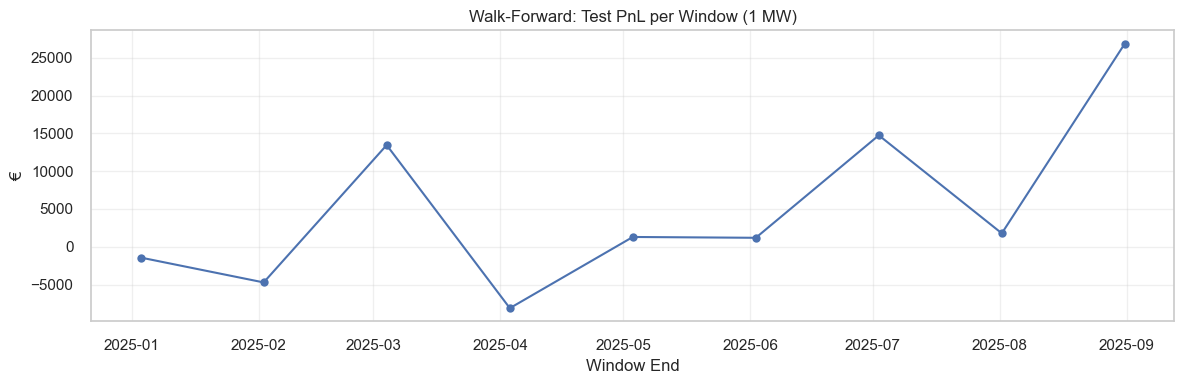

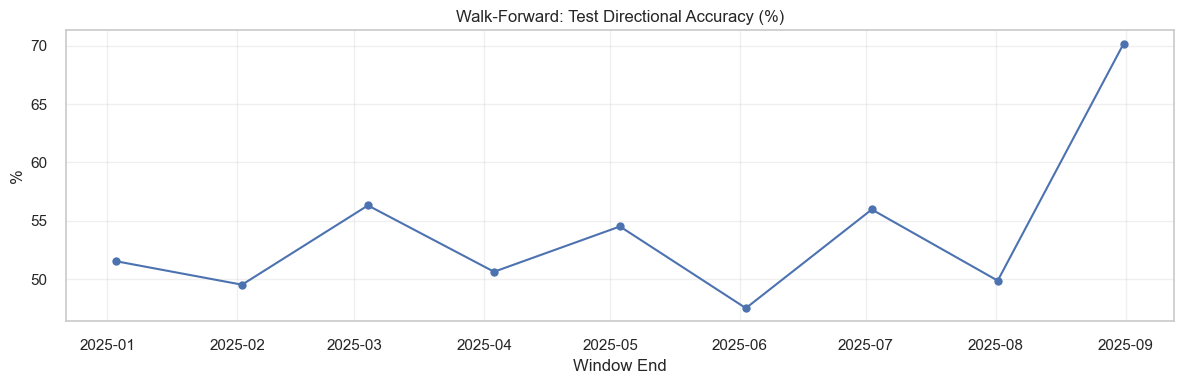

9I Power BI tables ready. CSVs exported.


In [38]:
# ======================================================================================
# 9E — PnL (1 MW) + Key Performance Indicators (diagnostic only, no costs applied)
# ======================================================================================

# ------------------------- USER TOGGLES (unchanged) -------------------------
USE_GATING = True          # if False → trade sign(forecast) directly (no confidence/magnitude gate)
CONF_MIN = 0.55            # minimum ML confidence required to allow a trade
SCALED_MAG_MIN = 0.10      # or allow a trade if forecast magnitude ≥ 10% of historical spread size

# ------------------------- FORECAST INPUT -------------------------
# f is the smoothed ensemble spread estimate in €/MWh (built in §9D). We *only* use forecast info (ex-ante).
f = combined_prices_df['Ensemble_Spread_Estimate']  # series of forecasted spreads (€/MWh)

# ------------------------- LEAK-FREE TRADABILITY -------------------------
# MINIMAL FIX: remove look-ahead leakage. Previously we filtered on *realized* spread:
#   tradable = (combined_prices_df[spread_col].abs() > TRANSACTION_EUR)
# That uses information we only know *after* the trade. To stay ex-ante, we either:
# A) allow all times to be tradable and let the gating decide, or
# B) base "tradable" on forecast magnitude (ex-ante).
#
# For minimal change + clarity we choose **A)** here:
tradable = np.ones(len(combined_prices_df), dtype=bool)  # every bar is tradable ex-ante

# If you prefer an ex-ante magnitude screen instead, comment the line above and uncomment below:
# scaler = safe_num(combined_prices_df.get('SpreadScaler_lag', 1.0))   # lagged spread scale (ex-ante)
# tradable = (f.abs() / (scaler + 1e-9)) >= SCALED_MAG_MIN             # forecast magnitude screen (ex-ante)

# ------------------------- GATING (ex-ante only) -------------------------
if USE_GATING:
    # Confidence signal in [0,1], already ex-ante (from model pipeline)
    conf = safe_num(combined_prices_df.get('ML_Confidence', 1.0))      # default to 1.0 if missing

    # Historical scaling of spread magnitudes (lagged median absolute spread, built in §9D)
    scaler = safe_num(combined_prices_df.get('SpreadScaler_lag', 1.0)) # ex-ante scale (lagged)
    scaled_mag = (f.abs() / (scaler + 1e-9))                           # forecast size relative to history

    # Allow a trade if confidence exceeds threshold OR forecast magnitude is large enough
    allow = (conf >= CONF_MIN) | (scaled_mag >= SCALED_MAG_MIN)

    # Directional signal: sign of forecast where allowed, else 0 (flat)
    sig = np.where(allow, np.sign(f), 0)
else:
    # No gating: just take the sign of the forecast (still ex-ante)
    sig = np.sign(f)

# Final trading signal (strict 1 MW sizing): ±1 when tradable & signal present, else 0
combined_prices_df['EnsembleSignal'] = np.where(tradable, sig, 0).astype(int)

# Realized diagnostic PnL at 1 MW: signal × realized spread (this is ex-post for evaluation only)
combined_prices_df['SimulatedPnL_Ensemble'] = combined_prices_df['EnsembleSignal'] * combined_prices_df[spread_col]

# Cumulative PnL over time for quick visualization
combined_prices_df['CumulativePnL_Ensemble'] = combined_prices_df['SimulatedPnL_Ensemble'].cumsum()

# ------------------------- KPI CALCULATION -------------------------
# Smooth the forecast slightly for a more stable error series (optional)
forecast = f.rolling(3, center=True, min_periods=1).mean()

# Forecast error vs realized spread (diagnostic only)
err = forecast - combined_prices_df[spread_col]

# Directional accuracy: % of bars where forecast sign equals realized sign
dir_hit = np.sign(forecast) == np.sign(combined_prices_df[spread_col])

# Helpers for Sharpe (simple) and MaxDD on PnL
def _sharpe(x):
    x = safe_num(x); s = x.std()
    return float(x.mean() / (s + 1e-9)) if s else 0.0

def _maxdd(cs):
    cs = safe_num(cs)
    peak = cs.cummax()
    return float((peak - cs).max()) if len(cs) else 0.0

# Assemble summary KPIs (strictly 1 MW, no costs)
KPI_SUMMARY = {
    'MAE': float(err.abs().mean()),                                        # mean absolute error of forecast vs actual spread
    'ME': float(err.mean()),                                               # mean error (bias)
    'RMSE': float(np.sqrt((err**2).mean())),                               # root mean square error
    'DirectionalAccuracy_%': float(100 * dir_hit.mean()),                  # % sign-correct
    'TotalPnL_€': float(combined_prices_df['SimulatedPnL_Ensemble'].sum()),# total diagnostic PnL at 1 MW
    'Trades': int((combined_prices_df['EnsembleSignal'] != 0).sum()),      # count of non-zero trades
    'WinRate_%': float(100 * (combined_prices_df['SimulatedPnL_Ensemble'] > 0).mean()),  # % winning bars
    'Sharpe': _sharpe(combined_prices_df['SimulatedPnL_Ensemble']),        # simple Sharpe proxy on per-bar PnL
    'MaxDrawdown_€': _maxdd(combined_prices_df['CumulativePnL_Ensemble']), # peak-to-trough of equity curve
    'ProfitFactor': float(
        combined_prices_df.loc[combined_prices_df['SimulatedPnL_Ensemble'] > 0, 'SimulatedPnL_Ensemble'].sum()
        / abs(combined_prices_df.loc[combined_prices_df['SimulatedPnL_Ensemble'] < 0, 'SimulatedPnL_Ensemble'].sum())
    ) if (combined_prices_df['SimulatedPnL_Ensemble'] < 0).any() else np.nan
}

# Print KPIs in a friendly format
print("\n[9E] KPI Summary (1 MW, diagnostic only)")
for k, v in KPI_SUMMARY.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k}: {v}")

# Plot the cumulative PnL curve (matplotlib-only, as per spec)
plt.figure(figsize=(14, 5))
plt.plot(combined_prices_df['StartDateTime'], combined_prices_df['CumulativePnL_Ensemble'], label='Cumulative PnL (1 MW)')
plt.axhline(0, linestyle='--', color='grey')
plt.legend(); plt.grid(True, alpha=0.4); plt.tight_layout(); plt.show()


# ======================================================================================
# 9F — Ablation Study (fair comparison of ML vs Rules vs Fundamentals vs Full Ensemble)
# ======================================================================================

# Safety: make sure §9D ran (we need SpreadScaler_lag, Ensemble_Spread_Estimate, ML_Weighted)
assert all(c in combined_prices_df.columns for c in ['SpreadScaler_lag', 'Ensemble_Spread_Estimate', 'ML_Weighted']), \
    "Run 9D first (requires SpreadScaler_lag, Ensemble_Spread_Estimate, ML_Weighted)."

# Weight builder for the non-ML part (rules + fundamentals); renormalizes if solar is flat
def _other_weights(df):
    w = {'rules': 0.40, 'outage': 0.24, 'demand': 0.24, 'wind': 0.08, 'solar': 0.04}
    if 'NormSolar' not in df.columns or pd.Series(df['NormSolar']).std(skipna=True) < 1e-12:
        w['solar'] = 0.0
    s = sum(v for v in w.values() if v > 0)
    return {k: (v / s if s > 0 else 0.0) for k, v in w.items()}

# Signed rules driver; if precomputed signed series exists, use it, else derive sign from correlation with spread
def _rule_signed(df):
    if 'RuleSignal_Signed' in df.columns:
        return safe_num(df['RuleSignal_Signed'])
    base = safe_num(df['RuleSignal']) if 'RuleSignal' in df.columns else 0.0
    corr = pd.Series(base).corr(df[spread_col])
    sign = 1.0 if pd.notna(corr) and corr >= 0 else -1.0
    return sign * zscore(base).fillna(0.0)

# Build alternative estimates by switching components on/off, mirroring §9D pipeline
def _build_est_9Dmirror(df, keep_ml=True, keep_rules=True, keep_fund=True):
    Scale = safe_num(df['SpreadScaler_lag'])                               # lagged magnitude scaler (ex-ante)
    g = safe_num(df.get('ML_Confidence', 1.0)).clip(0, 1)                  # confidence gate ∈ [0,1]

    # ML stream (in €); zero if ML disabled
    ml_stream = safe_num(df['ML_Weighted']) if keep_ml else 0.0

    # Other stream (rules + fundamentals), each z-scored and scaled by Scale
    W = _other_weights(df)
    other_stream = 0.0
    if keep_rules:
        other_stream += W['rules'] * _rule_signed(df) * Scale
    if keep_fund:
        out_drv = zscore(df['NormOutage']) if 'NormOutage' in df else 0.0
        dem_drv = zscore(df['NormDemand']) if 'NormDemand' in df else 0.0
        win_drv = zscore(1.0 - safe_num(df['NormWind'])) if 'NormWind' in df else 0.0
        sol_drv = zscore(df['NormSolar']) if 'NormSolar' in df else 0.0
        other_stream += (
            W['outage'] * out_drv * Scale +
            W['demand'] * dem_drv * Scale +
            W['wind']   * win_drv * Scale +
            W['solar']  * sol_drv * Scale
        )

    # Combine via confidence gate, winsorize shocks, then smooth with EWMA
    raw = g * ml_stream + (1.0 - g) * other_stream
    raw = winsorize(raw, p=0.995)
    return raw.ewm(alpha=0.35, adjust=False).mean()

# Build four variants for fair comparison
combined_prices_df['ML_only_est']            = _build_est_9Dmirror(combined_prices_df, keep_ml=True,  keep_rules=False, keep_fund=False)
combined_prices_df['Rules_only_est']         = _build_est_9Dmirror(combined_prices_df, keep_ml=False, keep_rules=True,  keep_fund=False)
combined_prices_df['Fundamentals_only_est']  = _build_est_9Dmirror(combined_prices_df, keep_ml=False, keep_rules=False, keep_fund=True)
combined_prices_df['Full_ensemble_est']      = combined_prices_df['Ensemble_Spread_Estimate']  # baseline from §9D

# Convert each estimate to a ±1/0 signal (ex-ante) and compute its 1 MW PnL against realized spread
def _signal_from_est(est_col):
    s = np.sign(safe_num(combined_prices_df[est_col])).astype(int)        # sign of estimate → ±1 or 0
    # keep the tradability rule consistent across variants; here we allow all bars
    return s.astype(int)

for est in ['ML_only_est','Rules_only_est','Fundamentals_only_est','Full_ensemble_est']:
    s_col = est.replace('_est', '_Signal')
    p_col = est.replace('_est', '_PnL')
    combined_prices_df[s_col] = _signal_from_est(est)
    combined_prices_df[p_col] = combined_prices_df[s_col] * combined_prices_df[spread_col]

# Small summary print helper
def _sum(label, pnl_col, sig_col):
    pnl = combined_prices_df[pnl_col]
    sig = combined_prices_df[sig_col]
    print(f"{label:<20} PnL€={pnl.sum():,.0f} | Win%={(pnl > 0).mean() * 100:5.2f} | Trades={(sig != 0).sum()}")

print("\n[9F] Ablation (gated like 9D, 1 MW, no costs):")
_sum("ML-only",             "ML_only_PnL",            "ML_only_Signal")
_sum("Rules-only",          "Rules_only_PnL",         "Rules_only_Signal")
_sum("Fundamentals-only",   "Fundamentals_only_PnL",  "Fundamentals_only_Signal")
_sum("Ensemble (full)",     "Full_ensemble_PnL",      "Full_ensemble_Signal")


# ======================================================================================
# 9G — Rule Attribution on Test Period (robust to missing pieces)
# ======================================================================================

import matplotlib.pyplot as plt  # (already imported above; kept here for cell-local runs)

# Discover rule columns
rule_cols = [c for c in combined_prices_df.columns if c.startswith('RULE_ACTIVE__')]

# If §9C objects are missing, rebuild a minimal weight table (abs mean spread diff) with support filter
if 'spread_impact_df' not in globals() or not isinstance(spread_impact_df, pd.DataFrame) \
   or ('MeanSpreadDifference' not in spread_impact_df.columns) or ('top_rules_filtered' not in globals()):
    top_rules_filtered = []
    spread_impact_df = pd.DataFrame(columns=['MeanSpreadDifference'])
    if rule_cols:
        corr_abs = combined_prices_df[rule_cols].corrwith(combined_prices_df[spread_col]).abs().sort_values(ascending=False)
        N_TOP, MIN_ACT = 50, 20
        shortlist = corr_abs.head(N_TOP).index.tolist()
        act_counts = combined_prices_df[shortlist].sum().sort_values(ascending=False)
        top_rules_filtered = [r for r in shortlist if act_counts.get(r, 0) >= MIN_ACT]
        impact = {}
        for r in top_rules_filtered:
            a = combined_prices_df.loc[combined_prices_df[r] == 1, spread_col].mean()
            i = combined_prices_df.loc[combined_prices_df[r] == 0, spread_col].mean()
            impact[r] = float(a - i)
        spread_impact_df = (
            pd.DataFrame.from_dict(impact, orient='index', columns=['MeanSpreadDifference'])
              .sort_values('MeanSpreadDifference', key=lambda s: s.abs(), ascending=False)
        )

# Choose a test slice (last 20% by time)
split_idx = int(len(combined_prices_df) * 0.8)
test_df = combined_prices_df.iloc[split_idx:].copy()

if (not rule_cols) or (not top_rules_filtered) or spread_impact_df.empty:
    print("[9G] No rules/weights available — skipping rule attribution.")
else:
    # Build rule weights vector aligned to the shortlisted rules
    w = spread_impact_df['MeanSpreadDifference'].reindex(top_rules_filtered).abs().fillna(0.0)

    # Active matrix for shortlisted rules in test period
    active = test_df[top_rules_filtered].copy()

    # Weighted activity per row (sum weights of active rules)
    weighted_active = active.mul(w, axis=1)
    row_sums = weighted_active.sum(axis=1).replace(0, np.nan)  # avoid divide-by-zero

    # Per-row proportions for each active rule
    proportions = weighted_active.div(row_sums, axis=0).fillna(0.0)

    # Allocate realized ensemble PnL to active rules in proportion to their weights
    alloc = proportions.mul(test_df['SimulatedPnL_Ensemble'], axis=0)

    # Aggregate allocated PnL & diagnostics per rule
    rule_contrib = pd.DataFrame({
        'AllocatedPnL': alloc.sum(),
        'Activations' : active.sum(),
        'AvgPnL_per_activation': alloc.sum() / active.sum().replace(0, np.nan)
    }).sort_values('AllocatedPnL', ascending=False)

    print("\n[9G] Top 15 rules by allocated PnL (test window):")
    try:
        display(rule_contrib.head(15))
    except Exception:
        print(rule_contrib.head(15).to_string())

    # Bar plot of top rule contributions
    plt.figure(figsize=(12, 5))
    rule_contrib.head(15)['AllocatedPnL'].plot(kind='bar')
    plt.title("Top Rule Contributors — Allocated Ensemble PnL (Test, 1 MW)")
    plt.ylabel("€"); plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.show()


# ======================================================================================
# 9H — Walk-Forward Stability (fixed windows: ~3 months train → ~1 month test; diagnostic)
# ======================================================================================

df_wf = combined_prices_df.sort_values('StartDateTime').copy()            # time-ordered copy

# Approx rows per calendar month for this dataset (simple ratio based on total span)
total_days = max(1, (df_wf['StartDateTime'].max() - df_wf['StartDateTime'].min()).days)
rows_per_month = int(round(len(df_wf) / max(1, total_days / 30.0)))

# Define train/test window sizes in rows (3 months train, 1 month test)
TRAIN_ROWS, TEST_ROWS = rows_per_month * 3, rows_per_month * 1

windows, start = [], 0                                                    # collector + rolling start index
while start + TRAIN_ROWS + TEST_ROWS <= len(df_wf):
    # Train/test slices for this window
    tr = df_wf.iloc[start: start + TRAIN_ROWS].copy()
    te = df_wf.iloc[start + TRAIN_ROWS: start + TRAIN_ROWS + TEST_ROWS].copy()

    # Clean for metrics (drop any rows missing required columns)
    tr = tr.replace([np.inf, -np.inf], np.nan).dropna(subset=['Ensemble_Spread_Estimate', spread_col, 'SimulatedPnL_Ensemble'])
    te = te.replace([np.inf, -np.inf], np.nan).dropna(subset=['Ensemble_Spread_Estimate', spread_col, 'SimulatedPnL_Ensemble'])

    # RMSE helper for readability
    rmse = lambda a, b: float(np.sqrt(((a - b) ** 2).mean()))

    # Collect metrics for current window
    row = {
        'TrainStart'       : tr['StartDateTime'].min(),
        'TrainEnd'         : tr['StartDateTime'].max(),
        'TestStart'        : te['StartDateTime'].min(),
        'TestEnd'          : te['StartDateTime'].max(),

        'MAE_train'        : float((tr['Ensemble_Spread_Estimate'] - tr[spread_col]).abs().mean()),
        'RMSE_train'       : rmse(tr['Ensemble_Spread_Estimate'], tr[spread_col]),
        'DirAcc_train_%'   : float(100 * (np.sign(tr['Ensemble_Spread_Estimate']) == np.sign(tr[spread_col])).mean()),
        'PnL_train'        : float(tr['SimulatedPnL_Ensemble'].sum()),
        'Trades_train'     : int((tr['SimulatedPnL_Ensemble'] != 0).sum()),  # FIX: .sum() (not .count)
        'WinRate_train_%'  : float(100 * (tr['SimulatedPnL_Ensemble'] > 0).mean()),

        'MAE_test'         : float((te['Ensemble_Spread_Estimate'] - te[spread_col]).abs().mean()),
        'RMSE_test'        : rmse(te['Ensemble_Spread_Estimate'], te[spread_col]),
        'DirAcc_test_%'    : float(100 * (np.sign(te['Ensemble_Spread_Estimate']) == np.sign(te[spread_col])).mean()),
        'PnL_test'         : float(te['SimulatedPnL_Ensemble'].sum()),
        'Trades_test'      : int((te['SimulatedPnL_Ensemble'] != 0).sum()),  # FIX: .sum() (not .count)
        'WinRate_test_%'   : float(100 * (te['SimulatedPnL_Ensemble'] > 0).mean()),
    }
    windows.append(row)

    start += TEST_ROWS  # advance by one test window

# Collate windows into a table and print/plot
wf_df = pd.DataFrame(windows)
print("\n[9H] Walk-forward summary (no refit, diagnostic):")
try:
    display(wf_df)
except Exception:
    print(wf_df.to_string(index=False))

# Plot test PnL over time
if not wf_df.empty:
    plt.figure(figsize=(12, 4))
    plt.plot(wf_df['TestEnd'], wf_df['PnL_test'], marker='o')
    plt.title("Walk-Forward: Test PnL per Window (1 MW)")
    plt.xlabel("Window End"); plt.ylabel("€")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(wf_df['TestEnd'], wf_df['DirAcc_test_%'], marker='o')
    plt.title("Walk-Forward: Test Directional Accuracy (%)")
    plt.xlabel("Window End"); plt.ylabel("%")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
else:
    print("[9H] Not enough data to build rolling windows — skipped plots.")


# ======================================================================================
# 9I — Power BI Exports (timeseries/hourly/daily/cards + optional rule & WF tables)
# ======================================================================================

# Columns to include in base timeseries export (unified names so BI stays stable)
ts_cols = [
    'StartDateTime', dam_col, bm_col, spread_col,
    'Ensemble_Spread_Estimate',
    'ML_only_est','Rules_only_est','Fundamentals_only_est','Full_ensemble_est',
    'ML_only_Signal','Rules_only_Signal','Fundamentals_only_Signal','Full_ensemble_Signal',
    'Ensemble_contrib_ML','Ensemble_contrib_Rules','Ensemble_contrib_Outage',
    'Ensemble_contrib_Demand','Ensemble_contrib_Wind','Ensemble_contrib_Solar',
    'SimulatedPnL_Ensemble','CumulativePnL_Ensemble'
]

# If ablation wasn’t executed, create placeholders so the schema doesn’t break
for c in [
    'ML_only_est','Rules_only_est','Fundamentals_only_est','Full_ensemble_est',
    'ML_only_Signal','Rules_only_Signal','Fundamentals_only_Signal','Full_ensemble_Signal'
]:
    if c not in combined_prices_df.columns:
        combined_prices_df[c] = 0

# Build timeseries and rename core price/spread columns to stable labels
timeseries = combined_prices_df[ts_cols].copy().rename(columns={
    dam_col: 'PriceDAM',
    bm_col : 'PriceImbalance',
    spread_col: 'Spread_DAMtoBM',
    'Full_ensemble_Signal': 'Ensemble_Signal'
})

# Hourly aggregation:
# • mean prices/estimates
# • sum PnL
# • majority sign via mean sign (then np.sign) for signals
timeseries['Hour'] = pd.to_datetime(timeseries['StartDateTime']).dt.floor('H')
hourly = (
    timeseries
    .groupby('Hour')
    .agg(
        DAM=('PriceDAM', 'mean'),
        BM=('PriceImbalance', 'mean'),
        Spread=('Spread_DAMtoBM', 'mean'),
        Ensemble_Est=('Ensemble_Spread_Estimate', 'mean'),
        ML_Est=('ML_only_est', 'mean'),
        Rule_Est=('Rules_only_est', 'mean'),
        PnL_1MW=('SimulatedPnL_Ensemble', 'sum'),
        Ensemble_Signal=('Ensemble_Signal', lambda s: s.replace(0, np.nan).mean()),
        ML_Signal=('ML_only_Signal', lambda s: s.replace(0, np.nan).mean()),
        Rule_Signal=('Rules_only_Signal', lambda s: s.replace(0, np.nan).mean())
    )
    .reset_index()
)

# Convert average signal in [-1,1] to majority sign ∈{-1,0,1}
for c in ['Ensemble_Signal','ML_Signal','Rule_Signal']:
    v = pd.to_numeric(hourly[c], errors='coerce').fillna(0.0).to_numpy()
    hourly[c + '_Majority'] = np.sign(v).astype(int)

# Daily PnL and cumulative PnL export
daily_export = (
    combined_prices_df
    .assign(Date=lambda d: d['StartDateTime'].dt.date)
    .groupby('Date')
    .agg(
        DailyPnL=('SimulatedPnL_Ensemble','sum'),
        CumPnL=('CumulativePnL_Ensemble','last')
    )
    .reset_index()
)

# KPI “cards” (error stats + headline PnL)
timeseries['Ensemble_Error'] = timeseries['Ensemble_Spread_Estimate'] - timeseries['Spread_DAMtoBM']
timeseries['ML_Error']       = timeseries['ML_only_est']               - timeseries['Spread_DAMtoBM']

MAE  = lambda s: float(np.abs(s).mean())
ME   = lambda s: float(np.mean(s))
RMSE = lambda s: float(np.sqrt(np.mean(np.square(s))))

def DIR_ACC(f, a):
    # Directional accuracy ignoring zero-forecast bars (so zeros don’t bias results)
    fsgn = np.sign(safe_num(f))
    asgn = np.sign(safe_num(a))
    m = fsgn != 0
    return float(100 * (fsgn[m] == asgn[m]).mean()) if m.any() else np.nan

cards = pd.DataFrame([{
    'MAE_ML': MAE(timeseries['ML_Error']),
    'ME_ML':  ME(timeseries['ML_Error']),
    'MAE_Ensemble': MAE(timeseries['Ensemble_Error']),
    'ME_Ensemble':  ME(timeseries['Ensemble_Error']),
    'Accuracy_Ensemble_%': DIR_ACC(timeseries['Ensemble_Spread_Estimate'], timeseries['Spread_DAMtoBM']),
    'Avg_DAM': float(timeseries['PriceDAM'].mean()),
    'Avg_BM' : float(timeseries['PriceImbalance'].mean()),
    'PnL_1MW_Total_€': float(timeseries['SimulatedPnL_Ensemble'].sum()),
    'PnL_7D_€': float(timeseries.set_index('StartDateTime')['SimulatedPnL_Ensemble'].rolling('7D').sum().iloc[-1])
}])

# Daily max drawdown for a quick risk card
daily_cum = daily_export['DailyPnL'].cumsum()
cards['MaxDrawdown_Daily_€'] = float((daily_cum.cummax() - daily_cum).max())

# CSV exports (BI-ready), controlled by your EXPORT_TO_CSV toggle in §9A
if EXPORT_TO_CSV:
    timeseries.to_csv('pbi_timeseries.csv', index=False)
    hourly.to_csv('pbi_hourly.csv', index=False)
    daily_export.to_csv('pbi_daily.csv', index=False)
    cards.to_csv('pbi_cards.csv', index=False)
    if 'rule_contrib' in locals():
        rule_contrib.reset_index().rename(columns={'index':'Rule'}).to_csv('pbi_rule_contrib.csv', index=False)
    if 'wf_df' in locals():
        wf_df.to_csv('pbi_walkforward.csv', index=False)
    print("9I Power BI tables ready. CSVs exported.")
else:
    print("9I Power BI tables ready. (CSV export disabled)")


In [39]:
# ========================= APPENDIX — DATA DICTIONARY (auto-built from combined_prices_df) =========================
# Produces a PowerBI/appendix-ready table describing columns created/used in Sections 1–9.
# - Summarizes RULE_ACTIVE__* and *_OUT unit flags to avoid thousands of rows
# - Optional: export a separate per-rule dictionary for audit (top-N or full)
# - Saves: data_dictionary.csv  (+ optional: data_dictionary_rules.csv) and prints a small preview

import pandas as pd
import numpy as np

assert 'combined_prices_df' in globals(), "combined_prices_df not found. Run the notebook first."

# ---------------- Toggles ----------------
INCLUDE_EACH_RULE_IN_MAIN = False     # if True, adds one row per RULE_ACTIVE__* to the main dictionary (not recommended)
RULE_TOP_N_FOR_MAIN = 25              # if INCLUDE_EACH_RULE_IN_MAIN=True, limit to top-N by activation count
EXPORT_RULES_SEPARATE = True          # if True, write full per-rule dictionary to data_dictionary_rules.csv
RULES_SEPARATE_TOP_N = None           # None = all rules; or set an int to limit separate export (e.g., 200)

# -------------- Helpers ------------------
def _exists(col): 
    return col in combined_prices_df.columns

def _dtype(col):
    try:
        return str(combined_prices_df[col].dtype)
    except Exception:
        return "unknown"

rows = []

def add(var, desc, section, src="Derived (this notebook)", units="", notes=""):
    """Append a row to the main dictionary *only if* the column exists."""
    if _exists(var):
        rows.append({
            "Variable": var,
            "Type": _dtype(var),
            "Units": units,
            "Description": desc,
            "Source / Creation": src,
            "Section(s)": section,
            "Notes": notes
        })

# ---- Core time & prices
add("StartDateTime", "Interval timestamp (local trading interval start).", "Section 1",
    src="Raw data / merged", units="datetime")

# Prices & spread
add("PriceDAM", "Day-Ahead Market price.", "Section 1", src="Raw market data", units="€/MWh")
add("PriceImbalance", "Balancing/Imbalance Market price (BM).", "Section 1", src="Raw market data", units="€/MWh")
add("Spread_DAMtoBM", "Realised spread = PriceImbalance − PriceDAM (PnL driver).", "Section 1", units="€/MWh",
    notes="Constructed when missing; used everywhere for PnL.")

# Fundamentals
add("TotalOutageMW", "Total generator MW unavailable (system).", "Sections 3/6/8.4", units="MW", src="Outage dataset")
add("TotalPercentUnavailable", "Share of system unavailable.", "Sections 3/8.4", units="%", src="Outage dataset")
add("DemandForecast", "System demand forecast.", "Sections 1/8.4", units="MW", src="Fundamentals")
add("Meteo_ISEMWIND_DAM", "Wind forecast proxy aligned to DAM.", "Sections 1/8.4", units="MW (proxy)", src="Fundamentals")
add("SolarForecast", "Solar generation forecast (if available).", "Sections 1/9", units="MW (proxy)", src="Fundamentals")

# Rule engine (signals & scores)
add("RuleScoreZ", "Z-scored rule strength from outage combo features.", "Sections 6.3–6.4", units="z-score")
add("RuleDir", "Rule-only direction signal (sign of RuleScoreZ).", "Section 6.4", units="{-1,0,1}")
add("OpenRulesOnly", "Rule-only gate open flag.", "Sections 6.4/7.1", units="bool")

# ML predictions (scores, directions, confidence)
for c in ["ML_PredictedSpread","ML_SpreadPrediction"]:
    add(c, "Model-predicted spread (pre-scaling).", "Sections 6.4/9B", units="€/MWh", src="ML model")
add("ML_Score_base", "Robust scaled ML score (|q80|).", "Section 6.4", units="[-1,1]")
add("ML_Score_exec_base", "Lagged ML score used ex-ante to trade.", "Section 6.4", units="[-1,1]")
add("ML_Dir_exec_base", "Lagged ML direction used ex-ante, base.", "Section 6.4", units="{-1,0,1}")
add("ML_Dir_exec", "Lagged ML direction used for trading.", "Sections 6.4/7.x", units="{-1,0,1}")
add("OpenMLOnly", "ML-only gate open flag.", "Sections 6.4/7.1", units="bool")
add("ML_Confidence", "ML confidence [0,1] (native or derived).", "Sections 7.3/8.5/9B–9E", units="[0,1]")
add("ML_Weighted", "Confidence-weighted ML forecast.", "Section 9B", units="€/MWh")

# Ensemble constructs (open flags, directions, PnL)
add("OpenEnsemble", "Ensemble gate open flag (ML-gated, thresholded).", "Sections 6.4/7.1", units="bool")
add("EnsembleDir", "Ensemble trading direction (ex-ante).", "Sections 6.4/7.1", units="{-1,0,1}")
add("Ensemble_PnL", "Per-bar ensemble PnL at 1 MW (from Section 6).", "Section 6.4", units="€")
add("WF_PnL", "Walk-forward per-bar PnL (1 MW).", "Sections 7.1–7.2/8.0", units="€")
add("WF_CumulativePnL", "Walk-forward cumulative PnL (1 MW).", "Section 7.1", units="€")
add("StrategyType", "Which bucket traded at bar: Ensemble/RuleOnly/MLOnly/Playbook/None.", "Section 7.1", units="category")

# Playbook / rule attribution analytics
add("PlaybookRuleActive", "True if any Tiered Playbook rule active.", "Sections 6.7/7.1", units="bool")

# Section 7 diagnostics / risk overlay
add("TradeSizeMW", "Position size used in WF backtest (strict 1 MW).", "Section 7.1", units="MW")
add("Weekday", "Calendar weekday label.", "Sections 7.3/8.4", units="str")
add("FilteredPnL", "WHAT-IF filtered PnL (diagnostic only).", "Section 7.3", units="€")
add("Date", "Calendar day key for aggregations.", "Sections 7.4/7.5/8.6", units="date")

# Section 7.4/7.5 overlays
add("RollingPnL", "Rolling mean daily PnL (window=5 days).", "Section 7.4", units="€/day")
add("RollingVol", "Rolling std of daily PnL (window=5 days).", "Section 7.4", units="€/day")
add("RollingSharpe", "Rolling Sharpe proxy = mean/std.", "Section 7.4", units="ratio")
add("CumulativePnL_Original", "Cum PnL (no overlay).", "Section 7.4", units="€")
add("CumulativePnL_Filtered", "Cum PnL with Sharpe overlay applied.", "Section 7.4", units="€")

# Section 8.0 aliases
add("TradeType", "Alias for StrategyType (back-compat).", "Section 8.0", notes="Auto-created if missing.")
add("PnL_adj", "Alias to chosen per-bar PnL in Section 8.0.", "Section 8.0", units="€", notes="Back-compat for earlier drafts.")
add("SimulatedProfit", "Alias to chosen per-bar PnL in Section 8.0.", "Section 8.0", units="€", notes="Back-compat.")

# Section 8.1 split
add("Set_8x", "In-sample vs Out-of-sample label.", "Section 8.1", units="{'IS','OOS'}")

# Section 8.2/8.3 combo shape
add("ComboList", "List of active unit names at bar (union of active combos).", "Sections 8.2/8.3", units="list[str]")
add("ComboName", "Readable joined string of ComboList (sorted).", "Section 8.3", units="str")

# Section 8.5 confidence scoring
add("TopRuleActive", "Highest-weight active outage combo at bar.", "Section 8.5", units="str")
add("WasProfitable", "Indicator: bar PnL > 0 for trades (NaN if no trade).", "Section 8.5", units="{0,1,NaN}")
add("RollingWinRate", "Ex-ante trailing win rate per TopRuleActive (7-bar, shifted).", "Section 8.5", units="[0,1]")
add("RollingSpreadVol", "Ex-ante 7-bar rolling std of spread (lagged).", "Section 8.5", units="€/MWh")
add("NumRulesActive", "Count of active RULE_ACTIVE__* flags.", "Section 8.5", units="count")
add("RuleOverlapScore", "Normalised rule overlap = NumRulesActive / max.", "Section 8.5", units="[0,1]")
add("VolatilityScore", "1 − normalised RollingSpreadVol.", "Section 8.5", units="[0,1]")
add("ConfidenceScore", "Weighted (0.4 winrate, 0.3 low-vol, 0.3 overlap).", "Section 8.5", units="[0,1]")
add("ConfidenceQuantile", "Confidence bucket (0..4).", "Section 8.5", units="int")

# Section 9 — ensemble build & diagnostics
add("NormOutage", "Normalised outage driver (0..1).", "Section 9C", units="[0,1]")
add("NormDemand", "Normalised demand driver (0..1).", "Section 9C", units="[0,1]")
add("NormWind", "Normalised wind driver (0..1).", "Section 9C", units="[0,1]")
add("NormSolar", "Normalised solar driver (0..1).", "Section 9C", units="[0,1]")

add("RuleSignal", "Weighted rule score (top filtered rules vs spread).", "Section 9C", units="arb",
    notes="Abs-corr rank + activation threshold; weighted by mean spread difference.")
add("RuleSignal_Signed", "Signed rule signal aligned with spread direction.", "Section 9C", units="z-score")

add("SpreadScaler_lag", "Lagged robust spread scalar (median |spread| ~1wk).", "Section 9D", units="€/MWh")
add("Ensemble_Spread_Estimate", "Confidence-gated ML + rules + fundamentals (smoothed).", "Section 9D", units="€/MWh")
add("Ensemble_contrib_ML", "ML contribution (g * ML stream).", "Section 9D", units="€/MWh")
add("Ensemble_contrib_Rules", "Rules contribution ((1-g)*w_rules*rule*scale).", "Section 9D", units="€/MWh")
add("Ensemble_contrib_Outage", "Outage contribution to ensemble.", "Section 9D", units="€/MWh")
add("Ensemble_contrib_Demand", "Demand contribution to ensemble.", "Section 9D", units="€/MWh")
add("Ensemble_contrib_Wind", "Wind contribution to ensemble.", "Section 9D", units="€/MWh")
add("Ensemble_contrib_Solar", "Solar contribution to ensemble.", "Section 9D", units="€/MWh")

add("EnsembleSignal", "Final 1 MW signal from ensemble estimate (±1/0).", "Section 9E", units="{-1,0,1}",
    notes="Gated by confidence and scaled magnitude.")
add("SimulatedPnL_Ensemble", "Per-bar simulated PnL using EnsembleSignal.", "Section 9E", units="€")
add("CumulativePnL_Ensemble", "Cumulative simulated PnL (1 MW).", "Section 9E", units="€")

# Ablations (9F)
add("ML_only_est", "Estimate using only ML stream.", "Section 9F", units="€/MWh")
add("Rules_only_est", "Estimate using only rules stream.", "Section 9F", units="€/MWh")
add("Fundamentals_only_est", "Estimate using only fundamentals streams.", "Section 9F", units="€/MWh")
add("Full_ensemble_est", "Same as Ensemble_Spread_Estimate.", "Section 9F", units="€/MWh")
for c in ["ML_only_Signal","Rules_only_Signal","Fundamentals_only_Signal","Full_ensemble_Signal"]:
    add(c, "Derived ±1/0 signal from corresponding estimate.", "Section 9F", units="{-1,0,1}")
for c in ["ML_only_PnL","Rules_only_PnL","Fundamentals_only_PnL","Full_ensemble_PnL"]:
    add(c, "Per-bar PnL from corresponding signal.", "Section 9F", units="€")

# Power BI exports (9I)
for c in ["Hour","Ensemble_Error","ML_Error"]:
    add(c, "Helper columns used for exports/KPIs.", "Section 9I")

# ---------------- Summarize dynamic patterns (compact) ----------------
rule_cols = [c for c in combined_prices_df.columns if c.startswith("RULE_ACTIVE__")]
unit_flag_cols = [c for c in combined_prices_df.columns if c.endswith("_OUT") and not c.startswith("RULE_ACTIVE__")]

# 1) Add ONE wildcard entry for rule actives
if rule_cols:
    rows.append({
        "Variable": "RULE_ACTIVE__*",
        "Type": "bool",
        "Units": "",
        "Description": "Boolean flags for outage combinations. Each column marks a specific combo active at the bar.",
        "Source / Creation": "Derived from outages",
        "Section(s)": "Sections 6.3/6.4/6.7",
        "Notes": f"{len(rule_cols)} columns detected; see data_dictionary_rules.csv for full list (if exported)."
    })

# Optionally add top-N example rules into the main dictionary (by activations)
if rule_cols and INCLUDE_EACH_RULE_IN_MAIN:
    act_counts = combined_prices_df[rule_cols].sum().sort_values(ascending=False)
    keep = act_counts.head(RULE_TOP_N_FOR_MAIN).index.tolist()
    for c in keep:
        rows.append({
            "Variable": c,
            "Type": "bool",
            "Units": "",
            "Description": f"Outage combo active → {c.replace('RULE_ACTIVE__','')}",
            "Source / Creation": "Derived from outages",
            "Section(s)": "Sections 6.3/6.4/6.7",
            "Notes": f"Example rule (top by activations); total rules: {len(rule_cols)}"
        })

# 2) Add ONE wildcard entry for unit *_OUT flags
if unit_flag_cols:
    rows.append({
        "Variable": "*_OUT",
        "Type": "bool",
        "Units": "",
        "Description": "Boolean flags for specific units being OUT (single-unit status).",
        "Source / Creation": "Outage feed",
        "Section(s)": "Sections 1–3 (ingest)",
        "Notes": f"{len(unit_flag_cols)} columns detected."
    })

# -------------- Finalize main dictionary --------------
dd = pd.DataFrame(rows).drop_duplicates(subset=["Variable"]).sort_values("Variable").reset_index(drop=True)
dd.to_csv("data_dictionary.csv", index=False)
print(f"[Data Dictionary] Wrote data_dictionary.csv with {len(dd)} variables found in your dataframe.")
print(dd.head(12).to_string(index=False))

# -------------- Optional: separate per-rule dictionary (audit/detail) --------------
if EXPORT_RULES_SEPARATE and rule_cols:
    act_counts = combined_prices_df[rule_cols].sum().sort_values(ascending=False)
    rules_df = (
        pd.DataFrame({
            "Variable": act_counts.index,
            "Activations": act_counts.values
        })
        .assign(
            Type="bool",
            Units="",
            Description=lambda d: d["Variable"].str.replace("RULE_ACTIVE__", "", regex=False).radd("Outage combo active → "),
            Source="Derived from outages",
            Sections="Sections 6.3/6.4/6.7",
            Notes=""
        )
        .loc[:, ["Variable","Type","Units","Description","Source","Sections","Notes","Activations"]]
    )
    if isinstance(RULES_SEPARATE_TOP_N, int) and RULES_SEPARATE_TOP_N > 0:
        rules_df = rules_df.head(RULES_SEPARATE_TOP_N)
    rules_df.to_csv("data_dictionary_rules.csv", index=False)
    print(f"[Data Dictionary] Wrote data_dictionary_rules.csv with {len(rules_df)} rule columns (sorted by activations).")


[Data Dictionary] Wrote data_dictionary.csv with 69 variables found in your dataframe.
                Variable    Type     Units                                                      Description       Source / Creation            Section(s)                                     Notes
                   *_OUT    bool           Boolean flags for specific units being OUT (single-unit status).             Outage feed Sections 1–3 (ingest)                      17 columns detected.
               ComboList  object list[str]       List of active unit names at bar (union of active combos). Derived (this notebook)      Sections 8.2/8.3                                          
      ConfidenceQuantile   int64       int                                        Confidence bucket (0..4). Derived (this notebook)           Section 8.5                                          
         ConfidenceScore float64     [0,1]                Weighted (0.4 winrate, 0.3 low-vol, 0.3 overlap). Derived (this noteboo